# Finding a New Home

Buying or selling of a house can be a very stressful event in one's life. The process could be frustrating as it is lengthy, uncertain and needs a lot of examination. Through this workflow we will guide a couple (Mark and Lisa) who is interested in selling their home and relocating to a place nearest to both of their work places. In this case study, we will explore the current housing market, estimate average house prices in their area and hunt for a new one. We will download the <a href="https://www.zillow.com/research/data/">Zillow data</a> for their current home for our analysis.
You can use your own data and follow along with this workflow which aims to help Mark and Lisa in finding their new home. 

![](https://desktop.arcgis.com/en/analytics/case-studies/GUID-F5565467-6211-45D9-A099-669701C5D8E1-web.png)


The notebook is divided into two parts. In the first part, we will calculate the following:
- Percentage of decrease/increase in house price since Mark and Lisa bought their home.
- Suggested selling price for their home.
- Whether their zip code is a buyer market or seller market.
- Average number of days it takes for homes to sell in their neighbourhood.

In the second part of the notebook, we will explore the investment potential of homes close to their work places. Based on how much a person is willing to spend commuting to work, we will create a drive-time buffer. This will narrow down the search areas. Zillow also provides data for market health and projected home value appreciation. Visualizing the zip codes by their market health will help them focus only on areas with good market health. Hence they will get a list of areas to choose from, for buying their new home.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#Selling-your-home" data-toc-modified-id="Selling-your-home-1">Selling your home</a></span>
          <ul class="toc-item">
            <li><span><a href="#Determine-an-appropriate-selling-price" data-toc-modified-id="Determine-an-appropriate-selling-price-1.1">Determine an appropriate selling price</a></span></li>
            <li><span><a href="#Get-additional-information-about-the-local-real-estate-market" data-toc-modified-id="Get-additional-information-about-the-local-real-estate-market-1.2">Get additional information about the local real estate market</a></span></li>
            <li><span><a href="#Visualize-Results" data-toc-modified-id="Visualize-Results-1.3">Visualize Results</a></span></li>
          </ul>
        </li>
        <li><span><a href="#House-Hunting" data-toc-modified-id="House-Hunting-2">House Hunting</a></span>
          <ul class="toc-item">
            <li><span><a href="#Find-all-ZIP-Codes-within-a-specified-drive-time-of-important-places" data-toc-modified-id="Find-all-ZIP-Codes-within-a-specified-drive-time-of-important-places-2.1">Find all ZIP Codes within a specified drive time to work</a></span></li>
            <li><span><a href="#Map-market-health,-home-values,-and-projected-appreciation" data-toc-modified-id="Map-market-health,-home-values,-and-projected-appreciation-2.2">Map market health, home values, and projected appreciation</a></span></li>
            <li><span><a href="#Find-the-best-cities-to-begin-house-hunting" data-toc-modified-id="Find-the-best-cities-to-begin-house-hunting-2.3">Find the best cities to begin house hunting</a></span></li>
             <li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2.4">Conclusion</a></span></li>  
          </ul>
        </li>
    </ul>
</div>

## Selling your home

Execute the following command to install the `openpyxl` library if not already. This package is used to read from any Excel or CSV files.
```
!pip install openpyxl
```

Also, when `matplotlib` is not present, run the following command to have it installed or upgraded:
```
import sys 
!{sys.executable} -m pip install matplotlib
```

Then, connect to your ArcGIS Online organization, and import necessary libraries.

In [ ]:
from arcgis.gis import GIS

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

In [3]:
gis = GIS(profile="your_online_profile")

Use the boolean `has_arcpy` to flag whether `arcpy` is present on the local environement.

In [4]:
has_arcpy = False

In [5]:
try:
    import arcpy
    has_arcpy = True
    print("arcpy present")
except:
    print("arcpy not present")

arcpy not present


Load the csv collection from ArcGIS Online for analysis, and download it as a zip file to the temporary folder. We will explain how these files created in the following sections.

<Item title:"finding_a_new_home" type:CSV Collection owner:api_data_owner>
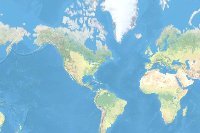

In [6]:
data = gis.content.search('finding_a_new_home owner:api_data_owner type: csv collection', outside_org= True)[0]
data

In [7]:
filepath = data.download(file_name=data.name)

In [8]:
import os
import zipfile
from pathlib import Path
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [9]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))
data_path

WindowsPath('C:/Users/shu12142/AppData/Local/Temp/1/finding_a_new_home')

In [10]:
datapath = [os.path.abspath(os.path.join(data_path, p)) for p in os.listdir(data_path)]
datapath

['C:\\Users\\shu12142\\AppData\\Local\\Temp\\1\\finding_a_new_home\\BuyerSellerIndex.xlsx',
 'C:\\Users\\shu12142\\AppData\\Local\\Temp\\1\\finding_a_new_home\\Crestline3BdrmAveSellingPrice.xlsx',
 'C:\\Users\\shu12142\\AppData\\Local\\Temp\\1\\finding_a_new_home\\ImportantPlaces.xlsx',
 'C:\\Users\\shu12142\\AppData\\Local\\Temp\\1\\finding_a_new_home\\MarketHealthIndex.xlsx']

### Determine an appropriate selling price

In this section, we will use **Crestline3BdrmAveSellingPrice.xlsx** for selling price analysis. The folloing steps are how we get **Crestline3BdrmAveSellingPrice.xlsx** prepared from open source:

1) Download home sales time series data from Zillow at <a href="https://www.zillow.com/research/data/">www.zillow.com/research/data</a>.
> Mark and Lisa have a 3-bedroom home, so we will select the **ZHVI 3-Bedroom time-series ($) ** data set at the ZIP Code level.

2) Prepare the Excel data:

> a) Using Excel, open the **.csv** file.

> Notice that the **RegionName** field has ZIP Codes as numbers (if we sort the **RegionName** field we will notice the ZIP Codes for Massachusetts, for example, don't have leading zeros; 01001 is 1001). Also, notice the median home value columns are named using the year and month. The first data available is for April 1996 (**1996-04**).

> b) Copy all the column headings and the one record with data for their ZIP Code to a new Excel sheet.

> Apply a filter to the **RegionName** field. Mark and Lisa live in Crestline, California, so we will apply a filter for the 92325 ZIP Code.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAA5gAAABwCAYAAAB7N9/PAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAMJ+SURBVHhe7J0FfBXH2oe/K73a3sqty6270lKoA8XdHQIESIJLgru7u7t7iJBAEuLu7u7uCs83cyREDoGWBBJ63t/9X9Kzc/bsvjsz7/vMzO7+3+3bt9FKK6200korrbTSSiuttNJKqweVFjC10korrbTSSiuttNJKK620qhdpAVMrrbTSSiuttNJKK6200kqretH/JSUl0dCKi4sjMDCQmJgYjdsfJyUkJBAcHExUVJTG7Vo1XYWFhREeHq5xm1b3r9jYWAICAhT/atremCXbtWzfsp1r2v64KjIykpCQEBITEzVu/6OoqfshOjqaoKAg4uPjNW7X6sGk9W/DSuaQWv82nKR/Za4uc3ZN2x+GkpOTSUlJUUj+LZWamqpRaWlpCqWnp9dSRkaGUtnZZGRlkZmZWaks8d/Z4nNNysnJUSg3N7dSeXl5dSo/P79SBQUFlSosLKwm+VnN7xUXF1VRMSUlJXdVaWmpQuXl5dy6dauWNEHeo9RDAUyZSPr4+Cg6X03bHyfJjs/f35+IiAiN27VqupJgIZNLTdu0un/JICb7g6Y44CTbtWzff7QERw6uyMTjjw6YcoBJDo40VT9IQPbz89Mm6A0ktX8fZYL+OEsO8Pn6+mr920BS+/dRDv7eL2Cq4bKpAmZRUZECFqsDZpEAybtDphowy8rKFJApVVFR8ccGTJlIenp6/iFm9WTglsmzdqbr8ZNMsOXoqaZtWt2/5ECTh4dHkxxwku1atu8/WoIeGhqqSJz/6IDZ1P0gB0i8vb21CXoDSevfhpUEeC8vrya5+qUpqDH4t6kBZlW4/K2AKUHx9wKmGjIlYFaFzMYEmlrArGdpAfPxlRYw60dawGx60gKmUlrA1Kouaf3bsNICZsOqKQGmVFMGTHXZ6oD525fIqmcy1X9L2NQEe49CWsCsZ2kB8/GVFjDrR1rAbHrSAqZSWsDUqi5p/duw0gJmw6qpAGbV2cumCpgSJsvLa89g1gWZNQFTDZRq2JTSBHqPSvUOmLJi1ry3SiaSrq6uyM636uePo2RgkcmzTEQ0bdeq6UomlvL+O03btLp/yYEmFxcXRTDTtL0xS7Zr2b7/aIApB1Zk4vxHB0x5H7ZMwJrqQ57kvbTu7u7aBL2BpPVvw0oO8Lm5uTXJ+/ebgmSO/qj9ez+AWRMyHyVgSv0ewJT/LaGxJmDezxJZNWCql8eqIVP9rybYexSqN8CUiYdMumQiImd6qm6TCaWjo+NDndWLjQwiyNmE687eeAQ9vJlTCZgyeZaJiKbtTVsyqQoj0NUe26tXuVopC65dd8YzPJ6oeE3fezwkZ66kNG1rHIolMtAdT6urmJmor811zMw98ImIJVrjdx6+JFja29vz4ANOsSTEBYrzteRGtfoodQ1zSyc8wuKIrMc6Kdu1HCx7ODMUEubCCPJwwK7W+ZkKWePgGUxwrKbv1q/kg21k4vzwAVNc4/hAvKyvY1XDB9dsHHHwjyY2/uEdk4xt0g8NAZjx0eGEuJphY1n9PK9a2nPTPUjRfhNqfOe3Sj6kzNnZuZECUDjBnu643nDGO0JTLIkiMtgHZxMbPAMiCIuruf3RSw5ASf82DQCKJDzAF1cLNwIiG098qEvSv05OTk1o9Ys6Rtnj4eZP4EPoqx9EcoBE5uqP0r91A2Y8iXGh+Nu7ESjy+ujkjDuAmRhFXIivyC08CIxMICEtq1EDprpsbcDUDJdSNQGzKmTKv9Wfa4K9R6F6A0z16zlk4igraNVtjwIw/ayPcXj0s3w1eikzjzlpLNMQerwBU3Y6xuyf0IsuTz7Jk5V6n/e+0mXBtVAcwzV97/FQ4wdMb2wPGDL/+yd55Vn1tfmCV/43kzVW3rhq/M7DV/0Bpg8RQftZ0PJTvq1WH6Xe5a1PhjPHOADbME3f/X16uIApf8OUozMG0kOc03+qnd/zQj8yYMEJTvpq+m796tEBph/R4YdY/NMXtKx2/k/yVquB9N/pgk/Yw4OlhgRMCZdnxr/MLx9VP88nP+5N++lHcBFlHhQCGi9gynplzqkFRoz/eiTLLcM1xBJ7bE6sZswzbViw+wYmQTW3P3o1LcC0xmzXJsa/N419NxtPfKhLTQ8wRYwKPMSCFn2YOWUXh7yTSNRYrnGo8QOmH6GeJ1nXWZ9tuy2wjMmtBMxMPxMc9s+jTSt9NlzywC0pv1EDpvy7qKiwFmAqIVPzLKYmwKwqTZD3KFUvgCmDlZy5lEmjhYUFDg4O1bY/dMAMteH6iYUM/vUr2n88mrlLzmMnPo+vWa4B9PgD5iV2jx3G0A86MGjFPtbu3Me+VXNYMXkU34zdw04LT0I0frfpq/ECZpiQJcdm6jJ1iA4jjFaxfdce9u0T12bbJnavXcLCK75c9dP03Yev+gNMbxG89zLri58Z3GE049btY688Z6k181ht0IsW7buiv/4s5900ff+36+EDpjGHpugy9K3WDFyym1U7VOe376DQeUztRJ2M1vTd+tWjA0xfosMOMO+b1gxpOxL9tfvYvVfpg6MXTDFxjyAq7uEtV61/wJT7ceDanmUs7DeQoTMWs2LTNtU1VmrJlAUsXbiRy6J8aK3v/zY1XsCUfjDh+KzJjPl4MIuuheFQCzBtsTq6jOFPfMfs7RZcCay5/dGraQGmgPRtaxnz6nh2WXspBjA0l2s8anqA6U14wD5mfd6FqeNEu/bSAua9VDdg+hLicZSVrUeyabsZ5tF5pKUkkulzictbNzHfaDNbjG2xD4kj5iHNYFaFy3sBptyXPC+5f3mvpXwSbE3Q/C1LZOW/Uo/tElkZqGTQlZXy2rVrmJqaagRMOzs7ReWt+nlDKcpuL6c2GfBD/xkY/jyARbM3s8k5nOiEhk+OZOIpO8DH82EwasAci/73+ixzSsIjUnzudQGrvVP5sM1i1pyxx1fjd5u+5L1XUpq2PUpFB9vhfmk0Uwb2Q3f8GjaZBRARo0qAo32I9r3ESfsw7AJqf/dRSIKlra1tPQw4ScDcLwBTBG+DrezzTCIhUbUt0A7vc0uZ0OtrOo1ZyrSDboSJzx90kEm2a9m+Hy5gjmfsVyNYfDMWlwhN5Rpe8t5jCdaPBjAPCsDszpTRG9ktrnGc+ho/Aqn9UF+AmZgQi+/1Jaw3HMTAnhOYe8IVe//qyZ23mRnWFy5gI/6OqPL575EcIJGxuvEB0OMBmBLgZf6jBcyGkfSvHJzUAmbDSAK89K/M2TVtfxj6LYB5LTSeFF9LTHesZ+3SXazeZ4N3RhYJAiIf1j2YvwUw5f7lrYTyX/maEgmNhYUSMJV/l5WVVgPKmlIDZtX3YD6WgCkTDRlkZcIlA5YES7VqAqacsbC2tlZ0DlU/r3/J5CcOr+ML2Dl/FO3W23F69QiWLJnH0K0OhMTEN3jjlsAtG6gc8de0vWlLM2Am+Blje3w+HbtvYtdFVwI0frfpS85cSGna9ugkElTrE+zp/RRDF21jvXn1+58boyRY3rhxox4GnOoATKlIXxJNjBgxYjKdJu7DJi6JqAeEE9muZft+ODNAjQcw5cu3JVj/0QFT+kHGu/oBzHjiYwI5Z/g9kyaPZfRhTyJj6wdc7yY5GCwHd7SA2TCS+dDNmzebCAA1PcCUAyTSv48SgH6bmhZgyhzdxsZGkbNr2v4wdN+Aufkyxo7O+BxdyLiR61l31B5vAYZpjfghP3L/asCUZSVcqmcuJVxKQNQ0g6kGy6qSkClhsqo0Qd6j1O8GTOkk2dhlsmVubq54GMGjB0yZkHlxdaURq8aOY+6NSFyub2LTkuUM0j+ObWQskRq/V3/6IwJmiOVuzq8YSJu5lzl5M/ihLEV+FGqcgOmMw4Xt6D/Xi1VHLLgW1fifbvrQADMhlKSoo6wZPIrRXWazxSMJ/5gq23+HtICpBcz6A8wAYqNOs7x1VyaPXsEmxzhiEjSVqz9pAbNhpQXMhpUWMBtWTQkwt8xfz+qNRxjccxV7Lbxwi0smSQBlY36KrNy/GjCVrykpV/x7Z2ms5uWx6llKNVzK/64Jl48NYMrkSnakMtGS91yamJgodDfAlEviLC0tFZ1D1c/rXQmiUQSdZsechUwbt4FzIQkEh5hzau0Spg+exV63KLweMMG8l6RvZAOVr7TQtL1pSw2Y/ej98qe07DuS/sNHMnjICIYbzGSFqRdOIY3t3p76k7y3Vi6P07TtkSnCnOt7l9H5z7qsPWWLraYyjUwSLOVyerkcR9P2+9c9ADNJLsE9x5ZBIxjXbhqrnQUgPOD9irJdy/b9cAFzKH2f/4iWvXToO2wkI0dKjRPazt4rLnho/G79Si4Nl/19/d17eL9S34P5LZ0//pHWA0aiozj/kcxevYvjTolEPMQnM8pXtcjbPerFDzHuxLhvYFKzEUwev5dTAqiU8ByKn/UJziwcycSx8lwNmbX8MBf8RQL4gOcqB0isrKwaIQCpAXMk/Z59n++6D6XPUHVdV6s3Pdu15uMnfmT8dstGCZgS4KV/mwYANT3AlP6Vg5OPEoB+m5oWYMq8/vr1640aMEM9DrGufQ/0O/ekv+5MBsy6yg3/WOKqwGVTAEz532q4rKq7zWDKGcuagCmhU70s9rEATHnvkaZlsXUBppyxkLOc8ntVP69vJUYHEWk+nwVzVqK30BifpERikwK5uW85G0cNYuI5X6wCZNKm+fv1ITkyLAOMHOnWtL1pSw2Yven+3Ft89HNHWrXrSMeew+irt5Rle65xzTPkgR9E0VglH94gpWnbI1OYKZa7l9D+z6NZc8quSQCmBEszM7N6WNFwn4A5WJ9Jneaw1Vck2A+YoMt2Ldv3w5kBUgPmIHo+/QYf/9ieX2R76yjVR2g5607Z46zxu/UrT09PxczXowHM/QIwm/Hrm5/xZauOdFCcf0dGz1zN7puJhDXwoGFVSdCWMyj14odoN2Kc1zL+64kYTj+GsfgsTrEtGC/zPRwc347+3Vvwxf++5cefJ7HCSfx+VI19/EbJe0hlAtl4AXM4vZ96jU+/b8tPlXVdrR/54evmvPnETxg0UsCU/pWD6VrAbBjJARI5qaEFzIaRBHg5+PvgD+D7/bonYHoeZH2Hroxo055+Q/WZvOg4Zs7hhMffgcuHCZhV4fK3AKbcLu+9rPkk2d/6kJ+akNmYQPM3AaZcHiVnISVASqA0NjaunL1U//3oAFPAZIgnTmu7M2XBEvT3Oyk6eSmvC2s5NK8XPy4y44xDaIM28D8GYNZ4yI/rKSxWjeSFp0YzYYcFNx7hEraGVKMEzCR77M5uYcTfh7DxpA03m4DvJWDKfqLBATMxnMT402waOhujfhs5Kz570MGPRwOYj36J7KMFzMazRLZeATPJj9jIoyz8YQILDQ9yKT5RBZhqyST6IjtHjkb/5wl/EMBs2ktktYDZsGq6gNlVAZj7tYB5T90LMNVLZLfOWcWelUtZ2ao1S/faYuaTSkpq0wFMCYwSEOV37kDm3eFSqiZgqiGzJnBqgr1HofsGTDlzqb7nUjbwmrOW8m95H6b8VxNgyjKy8lb9vH7lR4jnIVb+9D7fv/kWr3zYjJYtWyr0zafv8OH/3uPpN2cw/3jDjvjLxFMG8Mb9vsTfq7sAZrQNzheW0ffZDkxfeZ7zjfD9ZPUhOWsv70PTtO3RyQcPk80s/+IlZm06z0l3TWUalyRgyr7iwZfM1w2YcaGeeB8awTC9OQxaeJlg8dmD3h8s27Vs3380wPTw8FAsDf6jA6YEbfk8AZkkaNr+2xRKXLQ5+wb9zPjRU5h63rfGK1fqHzDlEm8ZvxsfAD0+gCkT9KYBQE0TMOVkxaMEoN8mCZgHmf3laBbOOsLFmMYNmNK/cnVRUwDMzRvOYeLsRPCVtawwmsWKHVe46JVOSlrTmcGUn9V+F+b9z2BqkibQe1S6L8BU33MpwVF2nmqwrPpvXYAp77mS2xoUMMOs8b4yhy7NO9K121DGTp3K1EoZoK8zkM5vt2DKxrOc89fw/XqSTDylj+S9Opq2N23dBTCDzbE7PIufn+nFlHWXMX5ESXBDSw6u1Kzbj16RhDmdxnLKFwwaNgq91ae54iHqYbxqe0wAsYEWGLtF4BpS9XuPTnLm8sqVKw0KmNE+N7E/vIRp3VvTfdpGZl+onwEf2a5lgv5HA0w3NzfFzO0fHTDlQ77kPWD1A5ixJMR547BTl7mjetNr5GIO34zCt/Ia1z9gyhl4maBrAbNhJAFeJuhawGwYSYCXOWdTAcyYgBu4nJpEr+8nMXPVBcUtLI0ZMKV/ZQ4vJ4U0bX8Yul/AlK8psYxMJjvGHqtja9iyZj1r9xrjFp9NnPodmA8BMKV+D2DK/5YwWfVJslK/ZYmsenmseoms+l9NsPcoVCdgyiWx0hkSLuXMjWzYaoisCpRV/5Zlaibhcsbi8uXLispb9fP6VIzTKazW9+aTPkuZd/RmjVdlhBLkcIzDfV5Ef/421po1XOcvlx7JANMY35f44FID5ghGfN4b/X2mHL5oismB1eycpsNHzRaw4IQ9jhq/2/QllwjKB3xo2vZIFeJKosk8RvdqQbs+Ixm/zoTzl1X3R186yqVTa1h2xY+r3hq++wgkwfLixYuKfkXT9vuXBMx9AjDbMKqPIXOOiP7JRHneZ3YuY/WYTrT8biiTthhjXE/JqJzBku374QLmGHTe78rYnVc4cEF1XVWydfPDXw7yaPx+/Uk+3ErO3P7RAVOCtlwCWT+AKZQo9uN3huOLdRjZti2jFp5nz3H1yqCLQquZP0wPg76L2SPO/UGfgiwHSGSc1gJmw0iucJC5UNMAoKYHmHKARN6O9SgB6F5KjIsh2s8BBxsLzu1exxbd9vwwfJnIjWzw11C+MUkOkMjB34f1znpN+i2AaR6dR3pqMgUJttw4tILVM43Ycd2TG74xhMWlNGrAlHApH9xTUPDbl8jK70mYVC+PVQOn/Fd+rgn2HoXqBEyZTKiXxcqkqmpiU1NVIbMmYMoZi/Pnzzfok1U9rmxg15g3aDvvGHuuB9YYJUokytsa+8U/0m7cYnR23KyyrX4lAVP6QS4p07S9aUsNmJ1p95e/8Y8nn+LJp57iqSff5d3PhjLtvB/WwfEkaPxu05dcIijvv9K07ZEqUSRncVFEOO5g64TONP/XUzwnr4vUmy14o9tKDtr7EdDAr0C4X0mwPHv2bD2saJCAuVsA5rt8+bd/8k9RHxXnLPX2T3zUdw0nnX3xjYmrNyiR7Vq274dzD5saMHvTSbS3f/1b1d6qqMPEzWy3bvhXh8h7j+XKjD86YMonScsZwHoDTKnEWGKjrLl5bj6jX3iBD6vW46f+xQc9pjJhv7PiFSYPOvshBz5lAtn4ZtgeD8CUAC8H07WA2TCSAH/p0qVGDZixQW64buxJ3x/e4ql/f8pLL09kobEztrEN/x72B5UEeDn425QAMy0tjfS0ZNI8L3Jz9yQ6d+nM0OWnOWgT2agBU1226uzl/QJmVciUYKmWJsh7lLorYFZ9FUnVZbFVZyrVf1eFS/n5owDMyAAX3C2PcsXeB08Nr8pIiA4l3PEil244cM3tQV+PcHc93oApk4AAPK5f4dLeveyt1DGOnryGbVAcYXGavvd4SAKmlKZtjUJRXnhYX+GMuCb71dfm8BkOXXbCOzyaWE3feQSqP8CMIj7GA9szxzldWRdVOnKe46auBEi41Pjd36eHC5gSHAPxsjHhSs3zU+nidZeHsvT50QFmNAlxXtidu4r1dVc8oh7tErMGAUyFwokIdOD6wQMcr3GNj1+1wcq7fmYcJWBKAGp8gCnrehA+ttZcP2WOQ3Ac4bViSRgh3o5c23ceW/dg0bZrbn/0koApAahpAGYIgW7OXD9qhUdoFBEayzQuScCUANSYATMhJoII5ysYnzks2u8JDh62wTG4afhXAuaFCxcaMWDGEh/ti8uV67gr3liQqQRMec9lXAhRPrZcNTbGwjkAn4hkJWBWAcuGAMyqcPlbAFM+QbasrPS+AFPCpJydrAsumwxgSriUyZ98qIkaLtXwWPXvmoApP7sbYMqEsiEBs7FIJp5yhLjxvZBfqweVfLiHlKZtWt2/JGCePn1a8UABTdsbs2S7lu374QBm45G8RUKuYnn4gNm4JEFbxrj6B8yHI7nEWwJQ03kKZ9OSBPjGDkBNWRLg5WTFowSgx1kS4M+dO1cP76j+/aobMO9IgqVa6ifHVlXlPZhCjRUwJSxWB0zN92DWBEz1ktgmOYMpO0eZSMl7bn6P5Chv1f3JZbanTp1SjI5U/fxxlLy3RQYYea+Opu1aNV3Jh3tIadqm1f1LDl6dOHGiQe/JbijJdi0T9D8aYMpBQzmQ+EcHTDnoKgdTmypgyhl4maA3lYekNDVJgJcJuhYwG0YS4OVkhRYwG0YS4M+cOdPoAbMqXN4PYNaEzMa7RFYNmdUBU62agKm+57KxQqZGwJRJhJzFlEnU75H8btX9aQFTq8dBWsCsH2kBs+lJC5hKaQFTq7qkBcyGlRYwG1ZNBTDVul/ArAqXjQUw1Q/5kd+p+qoSTWCpVk3AVENmTeDUBHuPQnU+5Ke+JAHz+PHjisqrafvjJAmYMsDUnMXVqulLPj1SStM2re5fcmnskSNHmuSSedmuZYLe+J7C2bCST0+WS4P/6IApQVvewyjfC61pe2OXXJkkE0gtYDaMJMDL5f9aAGoYSYCXkxWPEoAeZ0mAl4O/8rY2Tdsfhu4XMJv6DKb8bwmZyn+rzl7e/2tKpCRQNtZZzIcCmPKeq6NHj/5hAFMGcHmvjqbtWjVdyfuRpTRt0+r+JWcuDx061CRXNMh2LUfQ/2iAKV/RI2dum+rMXX1JgrZcodJUAVPOwMsEXTvD1jCSAH/y5EktYDaQJMDLyYpHCUCPsyTAHzt2TDEppGn7w1C9A6YAypoP+mkMgCm3y/swq85e/lbAVMOlGjA1Qd6j1P/Jd13+HsmR7PuVesZCVl5N2x8nyZFhCZjyoRiatmvVdCWfHql+kqZWv19y5lICpnyggKbtjVmyXatngDRtf1wlX88jAVPe/qBp+x9FErTlUxble1A1bW/skjPwEoDkDJCm7Vo9mOT7YtUzQJq2a/VgkgAvAVMCkKbtWj2YJMBLwJSTQpq2PwxJvlDDZqLi6dJK6KwpNYRK3RU+BWimCZhMF6BZEz6rAmdV8KwJn2rgrKqq8FkVQO8FmWrAlL8hgVGCYn5+nmLbbwVMCZVyia36AUCNEjBlhaopGYRkIiUlR2xlUJUJhvo1DVZWVpX3o1lYWFTO7KifMivvUZHLiKTkaK9cMrJv3z5FYJPLyx5nydmNAwcOKDpBTdu1arqSgyRSmrZpdf+SMyjy9QvyX03bG7Nku5btW7ZzTdsfV8mk4+DBg4rl/5q2/1HU1P0g4Wf//v2KQRJN27V6MGn927CSOaTWvw0n6V+Zq8ucXdP2h63LV69gYim4wtLsrjK9boa1jbWCUzRKxTDy9ga5gkO+elGyjRysuJvULCQHw+UEWV2Sgx3yqdx3k/p5Dern2kjAlBAtwTg9LZXsDAHEqfLvFHIy08jNSq+l/LwcCgvyFX8XCCBVw6hyBlQJpRIyGxto/p8mh8mla3J2QUrOOkpJZ6udLy+SHKmTkkvG1DAqL6CUvIDqiyuBVD7eXlZaef+a/O7jLAnnErrluWvarlXTlRxYkdK0Tav7l3xQiuwT1B1+U5Js17J9y3auafvjKtmPy/5b9vmatv9RJAdam7If5ICxHAyWcVvTdq0eTFr/NqxkbilXEsl8U9N2rR5Mjc2/nt6eePv71Ckff1/FjKsEvbokV23IW1vkv/IWAfn3vSRvhag6uyrhsKYkLNacQa0qOZMqZy7lrKn6v+UMpnImNIeigjzyxL95ubmKvzWppLiQUgGRir/Fv+qZTLXU78VsbEtlH8o9mPKpkXLUX16wx93khZaVV063a+3xMtmZyE5Gaw9mctmI7BPkUpKmZrJdy/Yt2/kfyWRglP23DF5/ZJPJQVP2g0xsZIIlkxKt1b/JRFL6Vy5n01r9m0zK5fJj+XAUrdW/Sf9KGJOzYlrTbJpA6n4l8waZ90gQ1LT9t6oqTDYmsFRLC5j1bFrAfHxNC5j1Y1rAbHqmBUylaQFTa3WZFjAb1rSA2bCmBcx7myaQul9pAbMBpAVMrT0OpgXM+jEtYDY90wKm0rSAqbW6TAuYDWtawGxY0wLmvU0TSN2vtIDZANICptYeB9MCZv2YFjCbnmkBU2lawNRaXaYFzIY1LWA2rGkB896mCaTuV1rAbABpAVNrj4NpAbN+TAuYTc+0gKk0LWBqrS7TAmbDmhYwG9a0gHlv0wRS9ystYDaAtICptcfBtIBZP6YFzKZnWsBUmhYwtVaXaQGzYU0LmA1rWsC8t2kCqfuVFjAbQFrA1NrjYFrArB/TAmbTMy1gKk0LmFqry7SA2bCmBcyGNS1g3ts0gdT9SguYlYoiNtID+3NnMLNwwM5P+bLQ36PagHlbqIiMSC98ba5y9WpVWQr5EJKUQ56ycINYRWkRmSE2uLl54ByUQqH8TLnpgUwzYBaTHR9IoO1VzEyqnqu5kCd+UenkqEo2iIkLnR3pjI+7M7Y+ieSU36JctakhrDgrjgSvq9y4dhUr9xACk6sHg1ulBRTGuuIWFIFPfK7q08ZvdQJmcTIJwe7Yiutqqr6+lvZYuMWSWlCKxJHS/DRS/a5i5+KHb3SmaAHKllCSFkZkmB+WQenkFjfklWkcdlfAzIsnMdi5Svu4ynVbZ3xTbpOnyodvlRVSGOeOR1A4XrG/r+6UZsWQEO6FqV8qqeod36fVBsxybpXnkOhri8sNebxO4nhvVR5vNSvJoSzJB3tr0cfdcMPeP4n8W7d/c79TlptEWoQb1/0Tic18OIlAnYBZmk5GtA8O4nqZq6+duRVXHSKIySyksaDM7bJiiuI98QoOwz3m9/W4GgGzQpxhRgj+bjer1V07r1AiskSdlY1cWFFmLHE+Flx3CiE0OZf6RRB1TPW+a0wNFjE1tg7ALMuOJznQFnMzE2x8oolIr1GmJJdbKb443byu2q+MX/b4iPiVXvVk8hNJCXVRlZG6zg1bH8Jzyimo0b2VZog8w9fmvsrWsrJs8pMDcb1mhoXq++YWN/CMzSddQ7MoL8ohPdACJ+urWDp44B4n+pKy+h0oqAswy3ISSAmy5Zq5KdbekYSl1ShTmsftVF+cbav71zsyjWpF80X7D3NVlVH67PpNb8KzRfJa07+Z0cT5Va2XoqyNN2EaytayshwKUoJwszCv9K/ZNUs8YnJJkwmToucqIDnAEXcr9f5VsnZukHhWF2CW5SSSGmyLpfSvV4QG/4p4k+qHq90N1XGaCdnjFZFaw7/JpIe7YWJioionfGbtRVhWqQb/xhDvf1OUVZ/7dSzvUraWCf8WpgbjbnkNS5XfzMwt8IjOUfn3jpXlJpIWbIflNVPV71iIa+FKUHI+4lLWm9UFmIq4I47hujgGa69wQlJr+LesQHSQ/rjZV/WvHZ7hKVQrWpBMhohfpqZq/1piaeVJaGYJeTX9mxVLcpA9NtbKd5BbWdlj5+hHpIh7+eWqjvUudru8gOLsWIK9PHFzcsbFxRVv7wAiUgrJltWnXBxUXgKRIcF4efqp5KuQv48/EUHBBAfFkZSeLzJ4ZQ8rTRNI3a/qAsyK0mKKc7PIETlGbn4hRaW1y8i4U1xcQmFBkVChyKVEfC0tU3xeFTDl3+Xit6p+9iikETATE+KJj3PB234DU995mfY9DZl0zLNWuftVbcCULSIG6/XDGP3xn/nzX57giSf+xt/+JvTEq/z1LzrMOeuOrzoyN4DJYG+3+FN69x5IxzkmRMrPlJseyGoDpjyHBNwOT2f6l3/i339/gr+qz/Vvz/LEX/qhv/k6rhUNd663K8pw29yeMf070UzvDJ65xTTk3FG840GODf0/3nruT7zVcw7TLsRTNYyXpIYStacz3WesZeQhX9Wnjd80A6a4brfKKY85x7GZvfhaXNt/K66t0Kstebn7bq6EpZEpimUEXefa+L/RsstE9Hc6ECe+LUN0yrWlrFuiz0tGVgK4G3JYpXGYRsC8fYsK7wMcn9GWv/z1bzyh8OETvPlNO8ZcLsUvVdk+ZMIUvb8XfWeuYvA+b8Vnv9UyHHZxbMVg/qpvgolfmurT+7PagJlPSZ4Hp0Z/Toc3/sSrX7Rm1KVifAQU17TbSe5knh5Oiw9f5E9vdqPF+HMEllWIFO23WY7POSzXdue1CafYay9rUcObZsAU53i7gvIkS65vGcX3ou4/p677//2AJ35Yw86b4QjebhQmE/yYQ/0ZMmsZvXd6qj79bVYbMEUgLUih/MYcxnX7vErf/gQthi1itcMtilRJU5z9Po6MeZm32i9k6SU/kpUf15MpY6rNhmGM1RhThzP7jBs2GZk1AFPWU9H2RH1OczrI2elf8cy//spHo7ay+kaqsog00T5vJXuRd0GXVl++oWqfz/K3v7ZkxCZLLJLEdkW5Cir8TnBpYSf+In5fUe6JN3nnK12Wu2QTnCv8pdyh2GU5yVYb2a33mWp/Um/z7td6rPHKI6zOICWSqHQXAs5No9NzT/OyPNcnnuDZl/9H/53+WEaK46naBMXxZ0e5Yj71eX5570+89F0/eu0XfUlm/Q5/aAZM4d9y4V+XI1w0asbzTz7BhzobWW6ZotouTPpXwHvR5TG0+/pNlT+eEf5twfD15pgnVvGv/2lMlnSp4t//8dZnI1jqmEFgjtq/cpflpNzcyj6Dz6v49y3e+kKXVa5ZhNQZaoR/M9wIvmhI1xee5RWVf59+4VX6bvPCPEL6V1DQ7TAuTvmRnm//RXE8yt8Q+qQjr8+yxi+hfuOZZsBU+jfd7QTGs77m5af/xgdD17LkWg3/pvpTaqxHpxZvq/zxtPDvtwxdbYJpQhX/Bp7j2vJuoszfVf59gzc+Gsoi2xT8a/g31XYHh8Z/wT/+8XfVub/J/z7RYblTOkH38m+mB+FXZ9Lj1f/yqsq/Tz37Ar03C/gKk/5VlbxVQabHKUxmf8PrLzyp+p1XeObFbsy6EoJHlrJcfZhmwFT6N8P9NKZzvuG1Z//O+4NXssCsSg8m/Hs7LYjSqwZ0++4dVT/4H+Hf5gxafhnjqv4NuoDVqh7861//VPn3dV57fxALrBLxza7hX/vdnJ/Rks8++YgPP/yQ99//gRatJrHFIY7Q3LoIXgBbTghxTruZM2wIvdp1pGuXHozWncpq43BcZXsqEP1bwEk2L5nHiOHjq2my3mTWzpnL3FlHOHcjiCSxx8oeXwNI3a/uBpgynhRkJpPg74yPoz2+IbHEZZXUKFOh6LeTk1KJjoqrVHZWDuXl5dVgsrysnPycPMoEfFbdx8OWRsAMvLKOLdPH0bb1BIxGNqfv7GUNBpjTunxDsyknOHDeAhsbG66e3Me6vu/QddYmllg23JLaW2XFioDj5xeAT2SGAi7VFehBrC7AnNfuHb4et4cNx8wU52phfJ4tOt/Qf9oCJl4MVRZvCBMXOjfOm+AAH9xCUsmrEB2GalNDmATMUyOf4Nfmn/DahyNoq3sSV/G5er7psQLMnBhuu6zHUGcEQ8ctZdUZcV2tbBTX1/TkLg4uGs7kY65cC82nrDCLzFAbPHxDCUnIUcxgyNrxhwfMMlEzkk05ZtibUd370n+DDWdMpQ+PcvrEVvSHnuOmd7Jilr8xA+bQr1/lgxa9eXXQGU57JdValZDpZ8zNWa+jN+Bb3m9r0PQBs1hkNt772DBNn75DjVh40obLFsq6b3HpBCcW9GPWfjOOe2ervvBorUEAsyCSdI/dLO74BYNHz2PqXnn+VkI72LZhL0sXWhNVXK6ILyU5iSQHO+DkHUV0Wn49z+zeAcxpnb9WxNT951Qx9dR+1vd9l26zNjLljGcNwMyivNSB05NHMVN3MqOMFjKh2T/pOqUGYMZY4bh3Fm2adWLUqiNsvyLO0+QsNutHMajPPMassMC7NI8i34NsmTKa7r3HMfmEDedkfTixiUOzx/LFT6vZfD0EGdUrRF+YYrGUJbOMGDhtEyfEcV4TsrFxwtk9hNi8CoruGqRkrxmEy+G5zP/1F1ob7GOLjKlnt3F+YS+a/6THxB02OGQoSyss0ZWAC8v4qesovvzmbb7p87AAM1skys6cnTaaWaMmMWrGEiZ88yTdJtUAzBgbXPbPpvWXHRi54hDbpH9Nz4vrOZqhfeeiu9Qcr9J8ivwOs2P6GLr11GfScdFPXhPlTm7h6JwxNPt5FRuvBSkGyyuKc0m1XMGKOUYMmLKR41X86+QWTIxIzgvrTAKCcT+2gAVtfqKN/h42HRH+PbeDy4t70vKXsYzbcgP79DuAOU1nILrbRMyzlL8h5OqDY0QWBSX1m2nUBkzZy7oICNFj9sgJjJq1nAnNn6H7hBqAGWuLx6E5tPmyPSOXHWDLZXGMZhex2TgWnf5z0Floimd5EYX+R9kj9tWt+1gmHrPmtPTvqa2cmDua5q1Wsc4kgHCxu1sl+aTeWM2quYb0nbSeY9bWlf51dAkiJqfsHv4VYHhqMQtb/0BbvV1sOGyKzfldXF3akx9ajUV/owW26cqanuGwk93LptNZdyW7r17DVPE7DtjZ+xIhrkHNWb8HsdqAKbM2Ny7OMWD2iHGMmr2S8S2eo/u4GoAZb4/30bm0a9aBEUv2sVn61/wyNpv0GTVwNkPnGuNRXkxBwHH2z9ana9fRTDhyg5Pmotzp7Zyar0uL1itZfcVP6d+yItKs1rJuviFDJm3AwcEJFxcXnJ09cfcKJT6nhMI6ZzBjCL6+jz16IzHaeEVcRxd8HczwObeKJUvXseuyIz7pRdzKTyEuKpKgwNBqCnCxwe38BlYcuoGpV2JlriZNE0jdr2oCpowjsi+WxxASEk5YTCIx/u6ERsZVA8yS4kKyM9NJTEwmKytbMXNZWFikuF55uXkUi7/lvuR+S4pLKBL/LSGzKnQ+CmkEzDDbU5zbsY0Z07ZzYEl7Ri9f3WCAOaN/O37dHoFvorLDKE4SFWzrT3Qcs5ARO10U3YcylAsHx3mJoLKCnetFx7lCarPQVW4GJ1MtTUwPJMzulKpMDYkkyNQ/TbFcJtZ2N2fNrnHOo+pYsmgE6SF4nlrP/k3q760Tuoi5e0yVUec8Ev2u43RxN+ahwZgdOyaS1hVs2rRJ0RA0AebCbp/Teq0HNwRsSCvPSyb6YG+Gj59OxxU2ItSLzxRbxDFkhOAljuFAzWNwi64+8p0VQZL7eTauX6MqV0VHzDnjniQu9C0RX49zVXSoBx3jKapcFlRCaWEc/ldEwr1V/b2VQme4aBNCvCih7CMLSA8XDfzUJiz8vTA7d47TlWX3ctLMkwDRD6nbuwTMM2OfopvOeH75bgDdOo1llLloxBnKTuuugFkYS4KPOUfEvjeozmHTzgMYBxaSqHBZqTjeJLwvncfb3QIvH0vMRJmtirL72XnAjqDCHHztLnBll/xsteLzczaBqFyusmIKM8PwPrORg5X+XSt0AVOXKMVolSarDZgZpPtfwmxEC/oPXoDRPmd8RIVVu1cufU10PMQpx0h8EkXwSo8iwmwFB8wcsApOoDArHO+zm9g6oR2d27bgyZ9HM2nWQrafs+aKo58ou1JVtmqmVEBGpOhoT2zkjF0YATWWHzcFqwWYpeL8ovezom8nerWfwHIPkQ8qqCudtIQALu9xJCw2jsigm9zYNoP5/T/h01868kXvSaxet4H9N0LxTxJ+KBdwnuXOjeN72KGqP1LHrvvgnVJKeUkygSb72G/UkwEdvuTPLXTQmTxXJKdXueyfS0GpvHAFZEa74XhoBdvWqfexVcgEu/BUQusAzMmDWtFxxAyavaXPpst+oi6qikgrjMbv8k7m//gNq+f2oe2omTUAs4TinCh8zm/l8Gb178r6ew5jh3ASRc9wW/QQYVYS3IYwqtNH/Oe7gfTWm8mm/ac55ZlJekEMoTetub7zJK4upuzdu118fy9bd9vim1MkUoVCMmPccRLntr3y3LYIiXMLSxXevrvVBky5fM4BG6Ou6A2ZyqjVFriILk+d7JTnJpPpvB9jUY/tI+UZyu/lEO18CZPd6t+WOsjeo86EVvFDSV40vhe3Ye3ghWfVzk602Xjv66w77opnbJY4G1k2RlXWArObNzER+9ys2O82dhwwwzm1nKwykQyG2GO9YxaLBn7Gl7+055OeE1i1ei37rgdhc9MSV7M9rDULISRFjfvK441xuYzVxZOc8MgmNb+8NmDm+JFovYQBb37GyBlHOK4YJ5QdYRzBHt5YXfIjVZybxJhcEb98zbaw1cwHj1jZUQi4S3PG/OBOtlf6Q2o3Ry45iWsmeirFz9xP7LsDmDP7taWNiKmyz5FWnORP+Laf6TR2If1WmNcATJHslAdht1dAyr6jbD92lM2/PslAw+qAWei+j5PzBvDE2/qstgwlRNbtYnFxwrcxs7NI0ofv4EJiOnGXJjJ2wFBaDNmKmagPGfKwMl0IOL+YX/7TjwUHHHAuFG0tzRVj/b5MmrSGmWeDkNFS3aLuabdFVEo8zyFDXX79aADTzKNFsijOJyeUNPtN6P7wNWMWHuBo5ZhtHkm2uzg3uwc/TDxJ364/0X/owwLMAgGYITjs38qxvQLMT5xkc7tnGDS9OmAWehzk7IIB/Pl/Y1hhFkSw9G+J8H/ETuZ0G8uwwVs5l5RJ7JUpjB80lG8GbMREdJvpCv+6EXxpCb8+1595e2xxKhCgn+nB1QkDmTJxJUZnAkWk+g3+lZZ0kWOzx9Dm/b5MNYnAU64hzQ0ny3krer98y+h5ezgsK4EKMBcYzmCpvSiiPu0GstqAKR0VKvrr7Rzbc4jtp86ypePzDJlaHTCLvI5wabHw7xu6LDH2V/bNJaLHi9zFgl76DOm/ibMpucQYT2fK0CF81Xc9xum3SZNOy/IgwmQpHV4cyJwd1jgU5Iu+2hvTyYOZNmE5U08GkCaS6d/m38uiPenR+u1eTL4cgrtcQ5oXSa77dsa1aYnu7B0cDBbQcDsS60XjmDt2FiP3ehGWV6qAnYay2oApHRWG85GdHN91kO1nLrCl80sMnVIdMIt8TmC8tD9/e1OXhRd9CZDdaKlo1ZF7WdLfgIG91nEmNZ/oqzOYPnwIn/Vcw6WkckRYFo3Gi2jzZXR+ZSCztlzHTvi3tMAP82nDmD5+KdOP+1NWoY4792lZDtzYuxqDrlPYbhtFSJb4oaIUSiJNOLZqGjuPX+Ja7C3KNe1W5CMpIXZcO7SGg9Z+eCSoY4LSNIHU/UoTYJbL2feUZBKT00jJyiMl1IuI6PhqgFkk2nR6ciLRUbHk5eUrvidVVlZKYX6BQnKfcv8SLgvzZL/zaOFSqs6H/MSGeOG6oTtTlz4swCynLM2ftKND6DZyCUM22iqSfZmzFGX64HppOdN+fZ+2Lb+iefPmfP3lz3z+vyFM3WuJZXKuCOLCoSKYZNrs48T0Xvzv8+Z88XVzvvr4Ld597Vn+8sK7vDtyM8tNIyjKiMF2wQd01xtHjx0io1VYqQC7AHyubWGugMHO33+p+J1vmn3PF28PQG/JaS6KJDNX/Eq5gEbXw9NY1u1t+q/fxtgeAxn0ZXM6duzI9evX7wMwK6jITyDj/ATGjJ9D23lmCqCTnUdJTghBNluZ1/2LKsfwneIYxq48z+X4bEW5WyJ45bif5dqC/nzavCWfNWtOs0/f48PXn+bvL77NG/0WM+VMkIjHZeI6tmGk3gCar3Aks0D6X1TEnAginA+xcuhP9Pzhc8XvNP/mW754tw/DpuzleFASqaIFlpEiEvPVrGn7LMOWLUN3kC464lybf9Ocj9/4ks76a9jonV85oiQB8/S4F+i25CQzJhswd9Cv/KfvQS57JinuS6gNmLKV55MVKq7j9pkMEcfxi9BXH79N8xYt6LE1CKuIYnEcueSnu7J/cGfWzNFl+fqZzBTl2jf/go/f/pnmX41l7XVj1i8cg0En4TNx7b94+zv6Gu1lt5faZ+L3c8MItdvBwl7N6PL9F0r/fi39258xy89wIe5O2apWCzDL/fE3Wc7wP73AlM03MY1WfX4Xk/f/mOn9H1/rLcfonBvZ8fZcnNqWwS1e5fVXX+CJlz/gky+a0X36NhbsPYfDzBdpMXQhkw57Ce8oaxJlIvm+tIq53/2P/mstueDf9GY8a89gZouE8Qybhg9mcLtxzDMJwze1mIJqI8DphFjuZNvAz/nh/Wd49uXXeO6tT2j5UxsGS98HplGcFULsja0sGdqDLvKafvU5n7/1DG0nbmetTRJ5BUGYLx0oEqQ3efu15/jTC+/x/qdf0klvEfNMBRAVVoh+wQvHs4uY/OsHtGnZTNnPfPGL6GeGYnjYhotBMXcFzLlz9Ri/8RAzX/6a+TtuYBanoi1h5TFXMNk4j5ZvGnFixzhGzJxfDTBLRXIR6bxHBONv6faDuk624It3+jFywQnOxiZTeDsOmy0GGLZ/lw9ef4YnXnyHNz/6grZDJjPhfAxRGTZcnj+Vca//xPQpY/i5Y1vRLwygc58dXE1KJSzZHduTS5hS7dxkHzqU6TuvYRGbqbjvXVPMrQWYFZGkBOxm+lsfMXHmEY6FKD/WbKKvE8lGesQ1ji4ahs4vnyj7GqGvPupEuw7z2CAg2i+7kCIBddnxNzjU7w1mLd/FrqoTjWHGOOyZyr9bbWSnbYQAqxxyEqwUZSdMHs7QafOYKPr8NqLdf/ZeM1E3hjDlRgr+GcmEi5iwc/AX/Pzhszwn6s4zb35Ci+9/ZNCG62zbOJ/dk1vwz76HOOYcp7xV4rboAUr9ubpkKJP79KLvsQSCRBJYCzDzQ0h22szYT35Bd8IWdjvGK+430nRrX5ztbg7pvcSrevvZbhMjglo8peFHWTW8J13ltfjyU3Et/sPTz7Wg1ahtnBfBT64Cu7/YVyb6B02AKWOqSICPDaX7qMX0m3+pBmBWtSxSAi+wq8NTtQAz22EbB2cP5G/N13HYIw7lFjn8e509A4Zh2HcxWz1SCTgykpFDx9N6kqjbYqsyNYsg2m0vU59tyfz110S7iCYj/AgzP+zGtPEb2Gnjjru7SoGRBCWJBKyu22NuiXOyW8nSUWP54Od1XM4qFBFKWi55qXYcHfIuhvPXs8FJtlGR1AlAsNhrxMyh3Vh6OYh1Y3sIiHiYS2TVlkVq6GX2dH62FmBmO+7k6FwBQM3WsN8lpvJ84Ab7h+hg2HMBWzwz8D86mrHDx/HjuDMEiK3KHjSSOK/9GL7wPfNXm2ISG0t29DHmftaDqfpr2VHNvxEECv+W13lLjvCZwxpWjhnLe9+v4UJavmpQO4/CTCeOD/8Qo7mrWOMgrr8KMA11h2Ow352bTvJ3BMCFJyrua7zHbXK/2WoDZlXLFn2MKfu6v1ALMHOc93Jyfn/+/OUqdjtEVp4PiP5jxCimd53NJu8cfI/pM26EAd/pncJP1EGlf6NI9Bf9+qs/MW/5Fa7ExJMXf4L5X/Zi6pjVbBP+dVP7NyCCgMT8ewJRmeM61uqP4a1vV3I2MUc1qJ0nwNWdkyM/Zcbs5ayyTaSi+BLrOw1jYp+5rLdyx95V9Tt+IXjH5VJYWv8zxHd/yE82mdHXONDrlVqAmeN6gLML+vFEs5XssA1XnY9s/TYcHTOaaR2N2OCTj/fx8UwapUdz3RN4iWNXZi8xJAcfYfb/fmHekgvCvwkUpp5mUfO+TBm5gu03PfHx9cPPzw//sGjCU+7t3/Kg85xZv4Y+w/Zhk5BFpoAd0ZNSXhKJ+2FDTp4+w7nAcgGYtStocZI7npaHWL1qM9bBidQcw9cEUvermoBZU+UlxaSHe9cJmPkCJtWfyzgkZy8lYMp9awFTYXcDzGxSgi5xoPt/+XrQPMYe8a1MdoLPG7FiYiueMziPuUekAuCSgpzxXN+RrsPmMnKLLXFICHHkguF0ZnU0ZI1npmjsmURe387hBT15ctRRDtpHK5Zt1AZMWdGS8Dw5l7k9vuK5UYc5ahOs+J3U2BB8dw5Cp+0Q2gzeJ7qk2+JIlYBp+NV/eOaZXxi5zoSroZmKBER2gPcGzDzyUx04PfJj2vQfR9ctbopzlaWjrq9n5+QveXHMIQ5bB6mOIVQcw2BGjp5K14VmossTFQsPrq9fxIzmo1huHYtbXCYxjicxXdKWt8fuYuXVYPKKy+8CmKkEW2xidde3eFtnM2uveCt+JyM9jYDD45nWsz9ftVnPxcwC0RkrAXPpt3/nf8+3pM/so5wJlGVTub6sNSP0hvDDWhfVflUzmONfoqcIdsevnuPmLkNa/qs9i056KWY5agOmDMbOXN51jPUzzuEjjiNRKMpqNyfndOalTpvZahUuEspcCtIdOTrsYzq+8xM/9NjIFVEuMjMAq91TmfLlP3nphWfoNPMQex3FtYgX9Wr3YEbpTqbDXFPF0izZbcZYbWHv5M94Zcx+9l8PVJy3suwwRo+ZQsd5JpVlq1otwMx0wO3Icn7+0wi2mAcQcI++vjpgCvC/VSbgJIvwC7NZOnskL0y8hJ2/SA7yC8lP8KPsygjafatP/1kXhXfk8IewtBtYbjKkw4sdmX8xGNeM2h1kY7fa92CK638rDLMl/dD5+DVeeLM/803Dqb6y8pbiwVw5Md74bO1C98kL6bPZlsysLHIKSykpDyPc5zJGnbdgYiUfApBJSoQ33lu6iCAznd7LLIm+XS4gM4cYi/Xsnt+Xv448xWn7ULJzC8gvUd7zEnh6IgsntuPVSRex8Y1W1I1Ef1s8Vreh/ZAF6C43rgMwlzLn8A0ujfoXo1YcYKv9nZnndJt1bF+mx/Njz+F8fAazawBmnN0eDk35kDdFu91u7q/43fTkOPz36zJObyKtjC4TIn4zuzCPRPtDXFjcUdTffWw29SMrJ488kdBW3HIUgDmEXn9+naf+pcuc0w44ZQpgy8ml5JbobzePYlzvX3lpwgVueEcpzy3AHs81ben47UgGzDwvek85v1/bagFmrh/x1uvo/8ZYlu6wxq3Oup9LTuJNToz4hLaDJtBvs43it6UiLLZzaEJnnn9xMivEuQT/TsBs9eaHfN1lDltFnx8s+nz3k3NYofs5z06+irFviqLu5MYF4LejJ/2mzKXrenkMyrpTFHAR27W6PPn0eBZd9hbHIKxcJPdxx9k4fDgDO8xgU/AtEgpv1wbM21lkx1myt8874hg+pUWvxQhuqZWUSKsFmPK+pYpiCnKzyRa+SApyFPGsNW17Tab/CgvCxU/INn9/sU8kFxoBM5vU4Esc7PG8iKlzhe9v/i7AvB1wgiuLxvDEvyey3k60NcWnasBsjX4nPeZeE/XJZB4TeurxXa8dYovcozQJmFsEYD6DwdyzHHcOJMVhNUPf7USbj96jRcv/8txzzynVajRtN7qSXaRuX7VNxrOki5Mx0hvNZyOO45pbrEpU7wDmqIkLmGmcLFxcTpKxEXMXzeCHJVdJyArBeH63RgeYtwPlfZVj+PPfx7PaKhjl5KsaMNui316X2deyiTdZyNQ+IkHvuhULsVXZw0jA3C4A878YzDrJEadgMlzWMuLDLrT5UPj3uyr+/WUkv6xzIT2/rvO+TfLlacw20OXjYUdxEgAvj6QqYI4eP4fplyNFUSVg9n7/H/zzP8/x7LPyd5rTdthajsSK46tf9/5uwLwddA6LFcK/Txiw4logyvEwNWB2QP/X4cy4lkeMyRJmDNCjWcfNmIuAoFzVIQFzlwDMFzEwPMJBJxEz3Neh+0lX2nzwPi2//y///a/Kvz8N54c1ziTfYyo3WdTJ+eNH8t6gw9gJgJctqSpgjhk3kykn3aiI2M6M1v1o/ebH/PTLf3npZdXvfNOd9+bdrPeHJP5ewLwdchGr1WP42z8MWKrox6WpAbML+r8MwvBaIVEmy5gzSI/Pf92ASUm5avWFBMy9AjBfYeL0Axx2jiTfdxt6X/agzXsf0LrNq3z9dTOaNWvGt/2nMHi3O8k5mq7/Hct02s2RLSsZvsiUwJgUihT93R3APHT4MIfdsgSo1s6fwiz3c2r7Emaf8SUirYCaRTSB1P2qPgAzNzdPcc+l/FwLmEJ1Aea4li/z0jfd6CSAZtCgPgzSGcKgaevZcNENt2jR7CpERU+35cQMXUb3HMUY02RCVUGhojiJ/PCtLBCANtFgLybJ+eQln2eHrhF6XdZyXuSvaSLxKRVB03q7Hv/puYd99lGKzrIWYMplN5nWXFwyG50fxjLzZgR+WcpKfKssl8LoA2wcNhadDos5nCI64FIlYC7u+CGdjC5x0jWFFFFcXuC73YM587tneP3rDrTp2lecq9BQockrWHHCFtswUV4kHHI5kemaaYxu04MRZ0JxUS1zul0uOvfog2waN5lRfddwPvkWaclmnJ4zj2HN5nA0Lp/YcvH7UdYEHxzBh4O2suxyoCLAawTMbGdsdi5lyEf9mH7eHQf10jBxDEXxZzg8fSL9v5jEzqBcIouVgLm69fP0mrSfXVaxJMjDulVBhokhc40m8fmkywSJTlV6rBIw14jjcw4jyvYIa9u+SOex61llEkKiAMyIaoAps9M04kKjCfJOUIwayk9K46wVnUGLd4xYd95LBF0lYB4b9gFjh01l2sFQxUhZieg44qy3s39cC57pOI2l572JEnByuzibwmtGTBqoT8sB+7CXAwNZrlzbYMToX7ow4mQgjooTkf4toDDmMFsnTmFEz5WcFX2nYvlGFasFmFFXRUI3lef/pMday0BVp3p3qw6Yd0prvAezRPxO0j5mtmrLCJ1V7BYRUc7+5rjuYN+K8bzfZwcmfqnIlR9NzWoDpkzWC0gOdMB8ixHT271Cqy5d6NBnIlMXHMI0UdR1Vby++z2YArKy4nG3CiU5vUA5A12YQoHLUowGGDJ07HEFpMtf1HgPZrnsLKw5PEWH0f0MGC+Sk6gcZZJbURhHfthGZvXQZ4nehjoAczkrL/kQv68jfXrPYsxa0RbFkZQSiOVSIxYON2Lc1UiiTBczrypgZnlgtX0OY35ox4ij3tyMlcuSZFMsoTD2OLsNpzGs42JOxZWRKE5M8z2YcrZUAuYgdN5oRjsjB0yCspWJi1w6nGbCHv0J6PaewyLPZOJUg0EVRfHi3DYxWyRY43R3cl5kVPkaYLEWYCY5EnlqOl+/os+M3bZ4KT/VbIXhJLvuY9KXvRi/5DjHwu88laI0wxHXk/Pp8o+uLDnkhFPu7wNMXZ0pGIq+JFxcRnnvXp7nEYxXD+Rf3fdw0DFG0eff9R7MPE8CjBfR7d8fMWnDNUzihV8KUkk3m8KESTPpM++y4oEzcr+1AFOCXZHwjaMxh2f0RrfDx3zTbTA9+xux6pC1AHzhflWCUgswq1kySX4X2f7zr0xeeIK9LqLuith3635jX1oZeeVKwBzf8iVerBpTh6ti6gVXLLyifxdgkhtLkOluZrZ7j259u9J10CCxb7HfQaPp1fIdBowYw+wbpSRH+XNl9Xj0On9DK1Gmt6KcDv179KT7J39n+IozHL3uSvz5yXz/v7Z01ZnNshOnOXXqJKd2TmPcsJ780lGPbQ55RN7l1l0ZzxLOT8BQXwCm7ik8Kh9aV0ZhRjDm0z9k/Kz5GJ31oSLBhB0jp2A0dy/bAhMoLI/AbGHXRgeY5MYRYr6PWW3fpXufLnSp6t/v3mPAsJHMvC7av/CvyfpJ6Hf+uop/hzOgR2+6f/pPhi87waHrHqRcnsLP77Sj85CZKv+eEv6dzkSdXvzUdjRbbmZRpRnWsNskXpzCrHGj+HjECVwEYCqjUhnF2RFcm/EZE2fOZupFQZBiS7zXDeyMxf7lbwjtnqPLJHFMrYce42p0pmq2u37s9wImufGEXz/IbFF/e/bpXM2/vb//gAFDhmJoWU5cZABmm6Zh0KkZrQYOvOPfnn3p8dm/Gbb4MPstvci4OpU277en4yAjllb615DJI3vxQ+sRbLJOF21V9dsaLPHydOYKwHxf+MhBAKYSE8spzY/FcvaXTJ4h8pYDtlTYzWTQd134pdN4FojfOSp/Z89c8d2+fPlVd5ZdCMWnymk+qP1ewFQ8jdXqMPNEPtyzTyc6V/XvDx/Sf+AAplpUEB0RiMUWQ8Z1+orW4rNeav/26if8+yQjF+3n4A1f8kTe1v/7PvTUmcuy02e5Ip82e3wly2bo0bf/ZA45in64jlv75X2rR7asQGfpNYJjkilW9HcVAuAyRU45i4OHDnHINbMGYMqYmIjn2Z0c37CV3c45JGu4wVUTSN2vZN7wewBTLqMtyMkkKdSP5LhYUpLTSE1JVygrQ+S5KsCU+y0uEv1hTp6A0kIqVCD6qPTIAXP896/yyveisxdBSLdfe/p1aS/g6CTHXRKUo5/yASAi8V8/rDftPunM0NUH2LD7gGJ/Bw5sFzJEp3k3RgxczcHIfLKTL7BTAKZ+59Wck3mVSApyPUSysaovTykAM1rRWdYCzFuiIoUeYsd4Q35tsYILOUVV7nWUwcKTy3MMmNNdj2Vet4nJVwLmqn4tGHcxGw/lmoA6AXPW98/yv5Y96NR3OLoDuzKkU0s+H7CHLdcilCNlEnITzgu4G0br139m4MIdrNypPtfdQrMxaNebgW2M2BZ+i/hEc87MncfwZrM4EiMAU7i1INgU101deG/gJpZfCRRdgjIg1wLMqPOcWziTb16fycHAJO6s7pTH64/1ltnM/rEni2yy8c9SAub6jq8x6WggN9SFJRC7bmDV/Ll8OvIk7jnKkeRqgOmVLfoeN3wOdaBvu36MmHWYM86eBO3oVOsezOLkQEIdL6jOV2jbQlZOGsrn/x4jOnFXfKsA5pxFG9jirvqisCz3YyKx6cNz485z3DVR+WGJSK/tl2DYZyzfdNqMuTi3jMQLHJ+pQ+tXfmTA/G2s2KH27x6Ff8d17EP/n6eyORxUeX6l1QLM4HNYLNfjTwIwV9Q3YCpSJj8uT+7CpNGGjDqbRGZhDkHHp7B6li4/bAoiWI5oNEGrDZh3LDvKBbf9usyerMuQrt3oL5L1wSuvcMU/VTErVNdDfsoLMsgNNMXswnHlNd27lQNrR9Kn+UgGDNqrmFGRwKURMOX9ItEHWNm/B+2/6IHOmgNs2qOuG2I/B6Yx9MsuLBo6v07AXG8VQ7nvKvR/6ctA3S2cjs8mP/44a/UMGTN8K8aJhWTZrqwOmElXRFvUpdULLek/axPLKuvkPqG5TOrWj77fjmNjYBlRBfcGTL3PfkHvcjE+6syuJEM06c3M7T2Vfv13Yyk+uhObZWrjxOHh/Zk7ejHbAsQ2DTl3LcCMsSFsvx5vvzSWSfcCzDQ3oi/Np/WrBsyrVTaWaJdDzHvzExZst8Q07vcBpqayjnurlhV9810f8pMi4E4kxq3fZMicI2ywTRXxIQjnZW0YO38dE87dgcHagHnHEl2OcWmDLqNGjhR9dFsBXTMxOuSAV0a5YqlrXYCZG2eBzdEpdPpqPFvPeCmfQPlbYl90GdllSsCcoI6pA9UxtV1lTI2s8z2YdQCmsNx4H7wP6bJgmi66ulKjhQxEIvgeA4cLwLQRmCzqZ6LrCS5vVJeRkg9S6UvPj/6BjgRMM3tij4zmo9d7MGTFFa4rgpTwZ5Ytl5cPYUjzrxlwMJYbjqLPtzmnOl+pqxhbBhEv4lnkXQEzCNOpH2JgNAu9LRfx2z+EScM2svaAJ+EijlcQ1TgBU1hegh++h3VZNL2Gf394n4FDBWBaCd+KepHkfhrjTTX8O6A/vT4WgLlUAKaZE0nHR/P5Wz0ZuPgilorGLuJ6tj1XVw9nSLPPGbAvAgsHN/xuVvfvlWsBxIuykXcFzHDMjT5l4gwJmKo4W8Ny/Q9zdNYQmj3fi2WWEfioQ1o92O8GTGH5SYH4iXq3xLCGf3/8UMQHAZg3RBsVTS7Z4xwmm2v4V8Bmr0//zfBFAjDNXEk7NYZm7/ak/4JzXBP+VWBKtgPm60cy5MuPGbAnFHMHdwJsz1fxrzGXzP2JE4l3pEbALKM0LxqLmV8yyUgA5l4rKkwN6PJtH9rr7eGi6MYLZLeT64GTyD2HvP0cA9bZcilIU137ffa7AVNYQXII/sfGssyoun8H/CT80V8ApgjAcs4oxesCZlt0GTv6jn9HDBpMr8+eYtRCAZjmHuScH0u7b4cydMlZzLNKlbOI4rxtD8xiSqdfmXoyDFvvYCI8b3Du3DmMjY0xuWqHrUM4qRW3SLorYGYIwBQ5rwbAvFVeQHGqLdeOHRS5wxWsE2+RU3pnu9o0gdT96vcCpnJbEblJUWSkJIs4lKFUagbZmXcAU8Yl+eRYOasp9YcHzGpLZKMtcd85iTeeGcrME064l4jWVBlk2/LFP5/h+ddf51Wh16vpF3qO38HpuEJyiq04Pn4cE34cx3KHeDzC47E/Mpflo5rx+gzRgfopg2ZtwBTH5L6JVSMN+FQA5vlqgCmPNxKrtSNYKoL9lBu3Cc/67YBZbYlskgvxp6fy7bs66G8ww04Oj1cCZi++/tvTvPjqa7xS61y/59cByzgYIxpRgSMmy2ai/9FAFpoGYxsSj9vFzWzVeZNPpx9hjzh/xRFoAky/gxw2NBD7n8meWoAZi8shI1b0+I5JlzNxT34wwJQLeW5V3GBv7+8Z2FGfvsuu4LSxPV2MVIAp91OSS5TperaM+fbONX71RV7+71v84886zK5XwOzLN0/8h5deEYlYNd9KfUerPos5IM5RNblZabUAM/wyN9aO48k/DWWpiT/+tQe7qtlvA0ylpZjMYsF8Q5rNNiEmw4dLC/qzcOxo5jmI46vNZ03C6gLMqpbldpizM9vz339+g8E+B6xFvnBXwCwvIifUDodlv9Lx+w94SV7L117l9Zef5el/tqPtfQPmL3z+r2fv0s+0ZsKE1XUDpks25bdusn/gz4zrOxnDC9EkXpjEmEmL6bn0OrFlhZQ4agLMgTT/6394WWOdbMGPXeewJ6xMMejxmwGzUPxhvwCDzvq0qQWYchQlhEvTO7Bw4hSWiHqlehZXNasFmAn2RBybyKcvD2fiditc1O7QZHG2hB8azwcv6zGlFmCmk+B9ks0//YcZm69wOvhRAKboKlICiDnQjW6T12Gw34rkWAt29vqQ2Sv2sd9fVUhYXYCpttvlJSRdncnsPq349NuRrPAoJEw0a82AKfrb0jx8zy5k2aivRYwywVhdJ39L7IsvI0cFmNWWyEZfx2PXJP73rIipx52wTM743YBZy25lCccZs7Xvr4zuMp7FTqK/qjEop7DyECId1qP3zIsYLDjPqRuOxB0fx+dv6GKwSb6iSxaqHSdP7V7E9gk/VTnXnnQbcQgbEc+CL01hhlwiO/wYLgIwlQn6nSWyI/Qn0Wfqata2+Cv6K8+wzzZe9N+RQo4cndqW0b270nG9C04h6eQWlSlWzNSHPQhg1rJbopWWmLBjYDt0Rdxc4CjSBtVCo2pWHkqMy0YMnn8Zg7mnOW7lQvLp8Xz9tkji117DpfLkEvE4PpPFXT6mzRoXju9eyq5JP1fxb3c6D92PtbgWQVcMmWOgy0dDjuCgYYnsmAlzMbxyl+Ov8BIAZITus28wbo8fN2pO1j+APQhg1rLb4qxKTNk9rCO67XSZZy9ivKaQVB5OvOcWJr7yOvqzjnPEyp30c+Np8Z6Ao5WmOMnUTVEwEa/Tc1na6X3arnLkyO7l7J1S1b/d6DBgDzcEAAWJ/mHB+FG8N+AQNzUskR07fiZTD9pSYTGRHi1G03vySazF7yjPOpWQ65tY2/oZui66xFH3u05F/2Z7EMCsZbdFp1dizr6RXdBtPZzZdiKz1DTYUBFBos92Jr/xPybMOMwxa0+yL03gxw9HM3LJaZwrcpFPV5EDgUEWW9k+tiMjd7tx8fwRLqwbw48//kj37t3p3WM6U2aexaO0nBjnPRzdspJhC0wI0LhE9giH3bKrAKYAs4JU4q33cOjoJXZfC618JkpN0wRS96sHAUxNkvspku/EFIBZ81UljUGNCzBLE4hzOcziH18TFeMAO5xF0lcZZCcx4Nf57BX7chaS+7yjcKLj08kuyqMi4SRbRrTn23//l5ff+4T3P/qE9/7Xiu9azWJLaBqRqhf/1l4iKz6PPsm+ybPpJgDzYjXAlM3aiXPTJzKj4xTWB90mrvABAbMslewIYzb0/JyR01axzFokFZWAaUj3z6aw1dmTm7XONYwI0WAyS0WDSL7MCQFL3//9GV57+yPeE+f6/ls/8NnHeqxwCMNPtQxOI2DGG3N52Tx+EYB5uBZgemK5TgSQr4ewyimHoJwHBUzZA+eScXUhi4bp8f4XEwVQ/cy3hirAFAkWHjtYMXoS7XssFsAbiKM8V+ezmG6fwc9P67OqXgFzBl0/msRmezdsqvlW5d9o6V9xiWrkkLUAs8QH3yuL6P+n55iw0Yar6up9F/s9gFkecZyDc+bRucU8LngeZvrg6YwfvpXLItHIvnuO26jtfgGzojCKkBtbmPvNk0zdfo0LoXUAZvQNnHfN4qPXRjDr4FWuymvp40Sg5TKmdJiIzn0D5gSGdF7CfvF918o6oVaEUNg9ALNCAGY+IYfHM2fmFD4zPMkFww8YN19c8/PRlArAvK0RMGfR6e1xbLjhhFWt3xW/GZVERokIUOKa/2bAlOcWtpsl/QwZVgsw5V/W7Ok3lDkjVrMvXOxfAyzWAsyycJJ8tjHhzffQNzrEkSDlxxot04tYs+V0eU1ASC3AjCTScR+G/23B4h3WWCY9GsC8XRBPqe9qpvaYhcHYVZxz2MvAj0ayZJsFDlVy2fsBTNkvluV6Y7FJj5m9WjPJNF9xLTQCphzY9DnA5gnj+V7GqLA7Meo3xT5RHytuawBMGVNdRUz9ScTU+ftZZhZRf4CZFyvC4nxGtRkhwG8XV0WflKfJLXE38No7ibefGsCMw464J/uSfGMJvd/uxoTFFzBVNMHacfKaZyTpCeFVzjWaqLhM8m+VU+KwSvmQnx/XcknDQ36M5hugu3ApE/71Jz565U3eELnAJ598LPQe/3vhSZ57+j889ebXvN9TxBHzIEX9qA+rV8DMF7HGeRFj2o2gy9DtGMvVC5r8G2+N74FJvPfMQAwP2OGa4k/6zaX0f7+H6HfOYlJ5GasDpol7JBnV/BtFZKzwr7gWxY5rWTVmLO9+t5rzaXmqXOgOYM6Yu5p1jqp6WtMy5HMCptHpv22ZfykMtzu3oj+w1StgFoikzWUJ4zqNpOOALXePqQm2BB2ZzMfPD2LqbhucU4LIsl/GoI97oj/7FMbCv0pMqQ6YV9w0+DcmQzHbXuy0nnV6Y3nrmxWcTsyu9ZCfmXOWs9oigoqAdUz8ZQDDdbdzShRSPviuiQCmHNh0Xc7kbiNp12cjl4R/MzX5N9GesOOT+fylQUzeLuJ4Wih5rmsZ9nlvxhod4XJKheo+yOqAaembQE5anCIeyz45OiqRhKRsigTYlAZf5Oz6tfQZshfrhCwyxGdVAfOUfMhPkIzVcr/SsslPc8Ni1SKOnbLBMqxYcf+7psPVBFL3q/oETBmDZDsoyMsXgFnY6OBSqpE95Ec4K94Z31Vt6d9vDmPX2RJ+q0jwhwOnZxkwsY8+M+zTidSUAUkrEQ3Nez1zZ0zmZ5FMbdq0SaUTHDnlRlhJueqpdhoAU1alfHfM181gzM+96H3EA0e5XkJuKc4iy20lC8dOYqAIpDdybpNV/oCAKapvaU4YQdsHoD90Kr1nmxMsjqFQHsP6mUz4tR9TzaLwUt98VtMkjAbsZeuyqTTrOoVVazaozvUIu/fb45dZoBp1lEU1AGahH06Hl6P/VSv6bbPEWH3DgNhvjs92tsyYROcuq7kcU0By2YMCpjThh2RrLqycTPcPPuKXH17lhYELlYBZIsrYL2Zar7E077xFgKCIUVI+JzGe34GPntJlUX0BZr4HlpvnMKFVL6ZeDcNDPvLxPq0WYIqEIdn7HKd6v02PXtOZuste8dJjxdsuhJWkBBMvksrDtmF4xhfVDZizR/DC8DPcjMqq/nChAk+ub53L2M++oueQNnzWcQYjF1sisUJTitgUrCZgVhRmKF9pYeuCedW3U6e64nliLr++/g4TRWA3EyddCZj6c+kj+gdZTxRpTuhFrFfr8cRfx7LE1A/JOyVZ0SJw9WPUjwPoWRMwF/Xjrz0PcdI9XtknVIj/z7Xj+LTRTBw0mbmOGcRpuP9Ctuu6AVMcj7j+Bd472blgBB993o0un//IpE2nORtdKDoIoZqAWeDNzV0LmfBDF6ZeDMD5Hq+eUQDmyi681n87Gy3CVO28DsC8JX4z154T08cwqsdYhlwMITRTWcvKckQSbz8D/d4TMZh9Bgfh/iINUbUWYIqWnpfkwFX979HpNZrhy0wU7x1Uv/u6LCeRDPsdnLf1wiYgiFTfkyz48ReGTBfg4qhcWSGtMMYc631TaP7hBDZe8iW4qIS8ZC+ujH8LHcNFTL0kysq+LtsL5wMzmdK1HX/7cf2DAea4WXRZYV391Q3log/KsWLv6CHo/NCC9kN78FarVWy86F/tHrKagClfqxVtu58DtlGqGCZM3m4Rc4XDs4fTvU0f5tqJ+i76hdqAmUdFiTdWc/oxfaghOqvdCBJwWTkJKGIf9xv7VDG19kN+iilMcBExtZ0ipo6ee7meADOdTOHji0Nb0qO3qLs73BQj/tWPTsa+GILOrWBDrw580vsQBx1iyRDQmxV8iqVtvmGM4RY2uYgaLGNJzFWOzRtBpx+7on85Fo+Uu5yrrA/JFzkyQ5cunw5kmXMOQbIRZIeQarsRne86MWXNLg65uHBdxMR9lXnAOqEF6HX8hF+++ZLPhy5nwV5bHEPTKvOCB7X6A8wMsiPNuKzzI717z8dgq4uiz6/tkViCL6xiU692fNb7APtsY0gvTSQn/CzL27dgzNQNrBf+UVyLWBNOLhpFx+86on8+ErekOiJIymVOzBlDp4/6sdQhk0C5C5GvZDpsFv1pFyatOMGpgBiizDfgEhmD4k1EKku0XsGWST356JvZHHATbe7+Q+w9rf4AM5OcmGtcGfUzfXvNZcwm57vE1FhCr6xja69f+aL3PnZbR5FWmkx+1AVWdfqOsZPXsMYxB8XDSOPMOLtsDB2at0XvbBjOiXX515jTC/To+F4vltik4ifTpNwIcl22MuaXbkxcepRL8Zncyr7OjmGd0Bs5g7nWIg+VnXPiTW5sn8Kv73+J7l4nLKLqz8H1B5iZ5CVc5+qY1gzoNYtR6xyFJ0VMVm6sYnGEmWxke6/WNOu9hx3XI0krS6UowZQNfdszxWg9W93zlE97TbqJ+c65DOs+hLmXg0XOXUeczHbCar/glu6TOeYpYpesn4XJlIQbc3TNSvads8Q2VQ7KyQsnrnt2BDGuJ1k/fQ2nTT0JyVN+rsk0gdT9qj4BU85YpqeLfiIrm2JxvbSAeU/AFFYgwpSXAJ+2g+k9fAvnMivIrUjF98IKthkNY8CcAxw8eQlTU9M7svXFOzKDotJcbvkfZe2W1QxbuKV6GQtrTB1FJcooUHQitQFTVqgMQq9vZsv49nzQdQHLthxXfNf44hkOL9FFf8Zqph1wIUmULRXQ+GCAKaxU9Nr+W1g4cATt2i/kSNptAXPiGG7s5IBRHwbP2sn2wxeqn4eNJy7BKRSKIFsRcoFD+9bSc+Z6zl82vlPG3BJTe5FEJuUqGrRGwBTBLtb1KIcn/0yLnjMwXHlI+V2TqxxdNZGpMxYxctNNQuVTFlVPkX0wwJSWQdg1AYb93uaNf/yFv/06UwmYZaL1B5xg4/hxdO2sz1JxHKeFTuw0Yt7wb3n/XzosOimSpAcGTHkEGYTLZRBGvRk6aztbD52/4zcpGw+cg4R/RVnFYGEVqw2Y4idSQ0m8bMjEHp3prTOdGYdNuXhVua/zh7aya/5Ipp9053p4/l0BM9tpC7tnD+GNFpNYuv8UVz1CCKy8vzKD4CsrWN3uPzzzjz/z355LmHL+HlOljdxqAmZ5XpKA7Nms3bCaGRtO3LkWe5ezZeoIPms9nTWmQfiLJLI8J56US3qMGjSCNkOWcuiaJdaiPSQEyBdpL+L7tzszYc1OdovvXz57kJ1zvqfzZ93pNWh3JWDm+hzn0spBvPCZHobrD3LRWfQfCXmUlifjfWYxm41GMGT+AY6cuXznWKRs/bHzuNcMphIwybyJ6VodOvz3v/zr9cnMP+WheAG6RsAUwTjS/hBHjXqgM0sk3AfOVf9da3ccA0RSI4KsrJMFoWY4bhvAp9+NYezCnZy1d8M1Npf8EnvNgKmAz1S8z85l0dgefNBzOTsOnlXs+9LJgxyYM4ChRttZcdFXAVM167202oAp9lqQrniZ+9KRvejWU5cJB0w5fll5zJdOif3OHcicg9c45Zso2q0Hliu6MmiILj0nbq08t9M7l7Ny5jjaGp7nin+S4vqUiGvsd6QnY/R06TFBlBV9kumRTawx6EWnFt/x1x/W/S7ALM9PJtV4PAbDdPh5wCIOml/jRmAS8dnyWsqokIzd2v7oNvsXf332NV6ZeIljbtXntmoCZmG0HX5npqC/aDsb9quu21XRF2+cwtRRenQas5UzkSXI8FYLMEtixf/2YNjyfTq3HszIDcJvxkq/2Lr5EyJiX+n9xj4RU29pBExhipi6AoO2Qxjbb1ENwCwV3XgKkc52OJie4cTueUxo9k9+6WPAyJUnMbe0wj40neT0FLLi/HASv2mh+O39HN1tyIiv2zJ+2UXOykc+y1VARQlE+ThjqyhjIrSRNdN1GdFel2mnwkQ7k8dUSFGmNzcWd2SS/gRGLDymvMYbxzBx2HB+GryJk2FFtW5RuGMypobgfnwhq7p3YPiCc+w8Jn7viHwh/ghad1nNivM+hCkLVzEZDR/2PZjCv7dF23Gxx1H49+TeBUxq/iSteo9FZ/kJ4d8b2IekkST8mx3vr/CvpcJ3Bzi+bwajvm3P+CXnOCXjqARr4d9oXxeVf6U2sc5oNDptRzDtRIhiIFP6tzjHH+tl4jz1DYR/hH/ltdg0lik6w/h+wAaOBeWjKHpXC8Xz1BJWd2uHzvwzbJf+PbqN0/N0aNt1FUtPe+IV407gxrYs372TtafUx2PK9nnDGDd6CD0Wm+MichBVtlMvVhsw5fVLI9rNQfjuLKcOLGZyy6dp3UuXYcuEfy2uYx+cSmJ6qugrAnAyM1P59yAnDsxEt2UHxi08rXjPrcK/xYnE+rtiV+nfzayfNQadNsOYKnIfN8WDGYoozQ/CZkUPpunrM2TeUUxMRNnNBkwfMZQWfdZyRASrms9wqG6iLZxdzpoubRgx9xRbj4rvH9vBufnDad9tJYtOeIgaLgBDZJvO20cy32AYPQwPc/qC6Ft2TGeJ/kA++nUB2+ziFQ8gqy+rDZiyb0wjxt1R4d8zh5Yx5fvnaNNzBIOXHMfsmgX2QckkpKWSmxiIs7nav4c4dWgWY37oyLj5J5SzrDJfLBZcEaD0r5mi3BY2zh3L8FaDmXrYD5cY6bRiyooicdyiw7JZ05my7gI3rKyxObSAVTOm0GPsds76pZFQ/T1mNSyWUOuDIr/VY93BG1y0dMHN6gpup1exZoPo52yCiBRt9JaAINleMkIdsD+0jpmLzmDqGiVQ+u5WE6J+izQBpvw7Py+PHMEMmanJxAW4i2sQSnisqLOZWeQWllAs8gQJlIXyCbEq5ecVkJwkyohrJvtzGZOkKspFWfE7Uo8aOusEzLgQb1w39mT6sjVMOe6lscz9SDNgxmKzUYdZgzrSfmckfmrAVFza6+wd0AqDrgbMvymSG0VDTRNJ2B42/PhXPnjur/z1r1X0yWiGrLUS4VV0N6KT8D8xkYWd/sJfqpZ55h3+0nIlW61CSRF1qigzFrtFH9PLYCK9qi2XUj5Sfdp//8P76u/++wX+2nw+i0XQUnKkChqPGLJm4PdMuCwAUzWYc1fAPGrE4p7NaLveE6vKHkGesx1npvbG4PueTLQQ3bria1mkBF9iT5fnaP5SlXOQeq8f7WYZi6MU5yAabLjpCjb1+QvP/LtKmX89z1++ns38M14kiJ9XAOamdugaDKblKicVYEqLJzvhOEs+f5uv1N994u/89cvJjN/jqBiRVjbhFILM1rKhy/+YciwIK/U9FbLDcBOJ38L5fDH6zsMWEpwOc3bSa/RZZ86Z6u+aEKfmQeiVmXR74Wlebj8b3SN+qg3ymTmGLO925zze7NBBnOtqhv93DLtPO+Mn8LUg3YkTOh8zb8kmtlUBzGyPExiv7ceLEy9wsipgOixjRj8DWnTdyjXxkXK1Tjbp4VfZ1+MlWr5y5/cUercPrQ0vK/xbMz5oAkyl3Sbx0jTm9H63+r5eaclLPfdjGpGuqNXpQZaYG/yVbw1WMvNClRcHplhgsUGH78R3/iP0bu85TLuUqKg50rI9T2Iy6yte+M/faWN0lIN3novUJK32ElmZJERzfdUARn5cxX9/fYePf5rM5pAK5OSfwlRLWVcN+IGPRZl/PP08X8+4wjERwDJDbbCY8E++e1v5/adee42WS5fS52dDFg7fyQ3xdQkwZDjidWIybf7xd14Q5d5oM4phx2IVL9KXIBZ6Ywurv/8rbz9T9ViEPhPJ2sKLGgDTk9NjmzF//ko2uqoAU/QUPucXMb/dW7ww+igHVPdDKwDTaTULZi/k+0kXCFIAprQcsmItFbD046s1fvft7nw38fydsjk+xF6fT///vcBrYrviKdy7QwlKseHKwqEYfNkGA+NifGtNQPnjeX4+o8V3XlXv+7kP+OuPG9jrEKV6JL9m0wSYakuzXseO0Z9UP+Zn3xf7Xc9uu0gF3Clb001OjBPHWrXc211pOeEc/sV3Vpcoy9pycnx3Vdl/CvVGR8eAjfum8+Svm9llpwZMaw4PfJs5K/ewp+ra23ATnETZpyvLCisTVz/mCBuG/cKnYr9/+9dTfDX9HAflu5NUlmwyl6UD3uU/L7/L4APh2KpXIKus9hJZ+QoWG44MeodWr6vP629CX9JlygHOisuuXtEQZ7eXwwav8T+DA+y8GSuc6kPh5TG0+uJ11ffu6LPfHPvKRVSN5eamEcweKPpNEVMrB20VtV7E1IGt2DZgQA3ATKWs2JgNbb5U9D/V9i307xf+R/P51zl/4wqO+/T5SXz2nGrbM+8044c1Xlir45l8WnHsMTaPbM1nqjJSb3aayNjT8eTJZyqoTV12VJtqZZsPWcBqJ1ED1M2rLstyJ+TyDLqKWP2y4vuv8vzrfZhnEYOPoqHXNCVgmi8WYDB8IH0OPgzATOdWhSmb2n/N91XOU61/Pfcq38wRcfK6MS4Hxyn8+1/Vtqff/JzvVrpxXT0gXS5aSNwJto1py+eqMlJvdjBA91Qc2fI5DmqTKzJE2e1j21Ur+/XA2axwhLz7Oe1sT8KvzqLHS8/wiuL7r/Dsyz2YbRqBpzKgcdvMgE7N36zcv0If6dBnuYXitpv69a4SgKoDpozo5mzt0oIfqx6DSv985iW+nnWVk5YmuB+dSKu/PcHzqm3/eeMTvlvufGfVjHxjQdwpdhl04Isq+3ijrQDME3GkF6iWZ0irUfYJVdmv+hqy1F4cp/ry12XZ3kSZz6XPa/9V9ccv8fTzXZl5JVSxEqrSkq4o3jHZXJT5l+p3Pvx1KEYioMXKmft6tNqAKftGC3b0/J6fVb9dVf946jmaGV3i6DVTvE9O5td/KmOq3PbUqx/QYokdVwNUB3lLOCX+NHsnduJLsf1vqnKvtx7JUBF/U6quGLolak7iRU7OH0qnd97hw/ff532h7uOWItP1+/HvrbxwEt32M2/YEHq160CXzt0ZPXo6Bx3CCcmpCqfRhN48zeGZS1h1KVQ1SHN30wRS96uagHnrVoXoK4oJ8/fHw96+thyd8I9OU7yWJS8vn5joeKKj4hSKi00Qn+Up9qnc1y0FhMrXlORl5yokH/hT9fcftuoEzMS4GKK8bXD28MI5MEZjmftRbcCUqXOxSKgCCff3xktcUPkeOqXJSpZJgr8nIT7BikeVK98lW0ZRdgKxHlY42VphZVVFzkEExGRRUJhJssVS5k2bSJ/xyzkmtpmryhifPsDakV8wZcsJjoje8VZZMdmRzviKzso3QdXBKKyI4tw4wmxv4qTev40dVm6RRKXmV+kwS8hNCiPGXwS5tPLKDrs2YEoTZZPDifJ1xSs2j6xCdeWW55xNapgvIe5C4ivKwFpOaUEaCT62uNmpjkEtJz+8wtMpFBUz1XYLG+dNpIPOfPaammOiKmNufJ7N43/GcM0WtjiKDlhc6Nw4L4JC/HGPyalyY3MJ5SXJRLk44qrev7U1Vi6hhCTkKMKxsmQpBRkxxPo4EJpcgOrtLcLEVuGrmMhIXIJSyBOZtTyzkpwkUkPt8YvNILXmMkP5upX0cHzsbmLvFaF4qbbaClLDiPZRHYeQg7eoG+ExBNgGkZCSI1L5CipEkpgc6EyEaGBVXwFVnpdMeowfdiFppKjfQSWXqmVHEe4XjJtPnCIUKfMWkYwVppPoa4e7/Z3fU8jRD8+wNMUy1apdkLS7A6Y457QwInwdq+/L3h0730QyisoUtbqsIJOMECvcQqIJV2aOShPQlCnagrv4zk0hR98IwqosjS4PNcVtwyBeeqYbejussL/jsiZptQFTtoNiMqP9CXSu4j8rR9H3hBJXeJviyiYjrmBxItGi3TmLMtY3bXENFx1wrrymAjJDbHB3VH7/puig3UWf4+cRRmRggiJUKmqjqEN5ySKQiLpuJ8o5eIr+I7lY9DOytpdSmCXqtLu4DjerHouQSzDOPhE1ALNCJJB5pAS7EhkZrQj4yjZTQn5qJJFejtgFJZOojohylDwnhsiISNxDUykQbVN5auWUF2eS5OcgAkuN33X0qV62PJ/izEj8HOywF9vt3HzwTiikoDSL9MgAQlxF35l+i9qvuisgTxxTkPiO/J5i37ZOWHnEiuOTc2B3t7oAszQrlvgg5+rHrNpvQrZ6v/LIs0kOEcdatZw4N7cQcW6q2VmlKcumVJa1EfIVdSaY2MQwbLziVPsVPivJIsnfkYjoBKp34+kC/MK4WVlWmJxhU4ygeyjrjs1NXMNSScq9c+alzpvYqtePF94czTr3JEIr+zql1QbMO8fgWXndRB9q5YpPaCJyBb66ty3OTiQpxB6HkERxTGLHpaJHSwvG08Ve9b07cvmNsa9Y/IpoJWTFBRLh76UxpiaKmBrk5KRhBjOdWE9XRf9Tbd9CNnYOuEVmkpop/RmMh/jMVrXtpqP4TkyVeKaYAUomLtATF1UZKQfvEIJT5Hta1Z4Qpi4bVL2sW0AkIkTVevecRivPpTBNxBIRq2U7trKyx9bBj4jMYsUrnWqb9EcRGVG+hAX645dUTHHNG+0f0GoDpqhbtzOI87qLf23tcYsQcVL4NzcppLp/HVxwj84ls4Z/44O8avg3mKCUYuUyQrWpywZXL+vqH6F4kuc93lOvNFWs9pWxWvF94V97XyIyRAKrDGiC74LxdnOo3L9CzoH4RWcqhs/r17uaAFO2XeFfbzeF76odh5DNTTsRH9JJEf5V9/l3/Oss/JtDhnomTDHDlkJCsHd1/3oFESjiQ7VXWtylrKtfmOL1GXfu7avDhH+LMiLws7dV+deOm7Y+hKcXKv2rtpJ0UiP9cBNlbFS/4+QVQJiAUPXt2vVlmmcwM4n3ddfo38r4m5FBXorwr40ypsptN+2dcBPOqARz6bOSFBLlxJX8rqqcg2dglfirMkVZkcuJeObt6IiT6LekfEKikI+puB//3i4vpCQ3kYiAAHy9vPD29iEoKIzEbBEr1e+OUliRiPkpJIVHEZ0mfF+ZbGg2TSB1v6oJmFISMgvFZ7mi79Ck/KJSSlQzmEVFxZWSryOR+5OxSLkf1Qym2Hd5mYhLQuptj0p1AmZ9qTZgNoyVZMfjt7k1/XUn0Gm5tSKhVKYOxaSHXefssP8wfN59PLzgAUwzYNa/yVnJ4AMDGa8/nK+mmxKeX6IAQpnYFqb7c3XSBxjMmI/RFdXaXa09sNUFmA1p2Z7HMV3Unhe+X8aaqwGqWfSma/f7kJ/GaLXvwfxjWF2A+TiZfGrzsnGDeaPrXizjshUrD6rafT3kpxFbVp2vKdHag1ptwNRafVptwNRafVptwNRaTdMEUvcrTYD5IKoKkI8aJjXp8QLMnAQ8d3Zh9GR9+iw6jqenp0o23LiyneV9vmHCqhOK9980lD1MwPQ/NhIj+c5Mo4PYOrqqztUOB+sjrB/ZmskLt7HpZl0L37T2W+zRAGYhwVeWs37Qu7wz3Zgzng03OPKwTAuYTc8ef8CUo9a52K/pzoRRvfhmtQdRGbWTWC1gaq0u0wJmw5oWMBvWtIB5b9MEUvcrLWA2gB4WYN6+XUJZoR9ma4ej2+wZnn/+eZX+y/8+/55fltpg5pdOUT0vi6lqDwswxdlSXhSM3f6pTP72aV5/6c65vvL2B/ww8zzHnZMoUN8ApLUHtkcDmF5YbdJn/AefM+JwHA5xTf96agGz6dnjD5jypj0b9g38Cb1uYzG0LCOloPY6TS1gaq0u0wJmw5oWMBvWtIB5b9MEUvcrLWA2gB4WYCpX/BeQEuyEq8kJTpy4o7OXzbAIzKp+I3ED2MMDTGnyfhIvvMxOcObUnXM9fe4iZj5JxGb9sZLghrZHA5gZJAe54HrFFNfoYtIfg36/KQNmRkaGFjAfS5PAlUyYnSWuNm6KJ/Bqur9JC5haq8u0gNmwpgXMhjUtYN7bNIHU/eoPB5iyM6wpWcGCgoIUCggIUMjf3x8/P79K+fr6KuTj44O3t7dCXl5elctS3d3dFXJzc8Pa2pp9+/Yp9iE74MdZMgGVHaCEEU3btWq6komllKZtWt2/UlJSFH1KcnKyxu2NWbJdy/Yt27mm7Y+rYmNjCQsLUwCKpu1/FMXFxTVpP8gBMhnf09PTNW7X6sGUmJio8K8ciNC0XasHk/SvzEu1/m0YyQkh6V85oKhp+8OSBN2ays3Nraa8PKk8jZIQp0lycLumCgsL70sSumtKDnRIyb/loNLdJMFSSpaVxyE/kw/tqaioqor7lhom69rWGPR/zs7O1JSdnR03b97ExsaG69evY2lpiYWFBebm5grJ9wOZmJgodOXKFS5duqTQuXPnFDpz5kzlbNqxY8c4dOgQe/bswcHBQZGcPe6SszMyyGjaplXTlXrQRdM2re5fsm1IwGyKbURef9m+NW17nPVHPe+aaup+kG1Oex0bTuq+TdM2rR5cWv82rBpDbJYDeBEREbUUGRlZOcgvFR0dTUyMZsmBQDkYXFNygKKqqq60lAPecvBbkyRwy0G5mpIrFeVgo/z7boOOEo7VcCv/VQNwUVGhAM3iKipRrCy5m9SQKiXhVIKk/Lfq51ISMjXB3qPQ/8XExIgLUl3ywqmlvpjy4lZVzYsvl42pJSuIWnJGVM5k7t+/X/F3Vap/HCUrjjxvWSk1bdeq6UrO4khp2qbV/Ut2xDKIyc5Z0/bGLNmuZfuWwULT9sdVMhjLfv5eI7WPu2Qi0pT9IGd+ZBInkxxN27V6MGn927CSibyEHzmDpWm7Vg8mtX8lFGna/qglQavq379VNWHst0jC3O9R1dlFeQySEeT+JCD+XqkBrq5tjUGP2T2Yj95kxXl492Bq7WGaHAF7FK8pedxMwpnsE2RH29RMew/m43oP5v2Z9h5MrdVlcsZCPZCutfo3CT4S4LX3YDaMSf9KwJQDaFrTbJpA6n4l8waZ99TXLGNVoGxscCmlBcx6Ni1gPr6mBcz6MS1gNj3TAqbStICptbpMC5gNa1rAbFjTAua9TRNI3a+0gNkA0gKm1h4H0wJm/ZgWMJueaQFTaVrA1FpdpgXMhjUtYDasaQHz3qYJpO5XWsBsAGkBU2uPg2kBs35MC5hNz7SAqTQtYGqtLtMCZsOaFjAb1rSAeW/TBFL3Ky1gNoC0gKm1x8G0gFk/pgXMpmdawFSaFjC1VpdpAbNhTQuYDWtawLy3aQKp+5UWMBtAWsDU2uNgjwNglhfnkRvvQ2hcConZjyZIawGz6ZkWMJWmBUyt1WVawGxY0wJmw5oWMO9tmkDqfqUFzAaQFjC19jjY4wCYmWG2WBm9THvDDSwyDlN9+nBNC5hNz7SAqTQtYGqtLtMCZsOaFjAb1rSAeW/TBFL3Ky1gCgVb7ObAMj369u2r0hyMllzESmyLqFH2fnTfgJniTbj5JsbqjmDYsGFC4zGYvIVzAZnEFqrKqKwgwhbX43MYPUqnsqz+pM2c9c9Qls2NpdRjH8tmTVBtV8pojwVXA3KVO5GWF0So1X4Wi21jVWXGGS1kj2shUdmqMqUiEQ4+z5ENs6rta/Lqw+xzzqS4/LaqoBYwNVpePLe897Ny7kSV70YLLWCXuR/+VS9FsAU3D86s9K+UwfR57HbOI1J1LW6V5JHhsJO9K9T7klrH1tNuhIrt5cpiFCX6EHZpAUYTde+UGz6c9VcCcEuSJWTJNHwvbmSnoXo/Kk2ez7ADPvgn5smClVYnYGa543h6I3PF90eo9zNuAQbrrfFOyaNG9W1QK89LJc1mA5tPXWXnzVjVp0rLCLqOuf6f+UZvGYbnglWfQpztbk5tm4/+Oms8k3MpUH3eEFYnYBYnURR1hT2zJjNJ7UepmQfYcy2YDFGkampfUZJP2JX5bJs3jIlzVrDfq4L4KnWqvq02YBZTVhyN8745rJ5U5XgVmsXkGeexz8hH3RtUlBSI413A9o3rWXjYlYSKWzTGVDTe4QBnt89l9OobuMZnE6UJMEuEo4POcmBd9Ta7YNclTMJFPXwoDFYhlE6gyQ72zqjqe6nxQns55x5DvLLwA1udgJnghMf5NTWOoapmMmHaGWxE+4oKMuPGvhlVts1jxiJj3IrKyJH7ygghzXYHhhPHVilTVfLc9nDWNZqweE+Czs9n6rhRldt1Ro5ig0mIaMuKI6u0RguYt4U/I0y5snth5TkMG2bEoq1XuJku+gxFx55HWpg1ZouHYThWXUalVafZZx+n2JW0vOBr2ByoWi/nYrjgMi4FJajDOhUCUjIcuLZnOTOr7GvetjNcCRPVW1YtaUUJ5IVeZIfhBCaqygwfrsN640DcFbHkjjVewBQ5SqQ5JnsXVZ7nsGGGLNx0CZs04S/p30RX/C6vq7K9pgzRn3CS63GZpOWFEGF3iCXicz3VdoNpc9nllEN4lvIXuSXqWIYjlvtWMKtyH8OYs/kkl0SwLlIH6+JECsIvs3vGpGp9/rrLfrgmqsqorFEDZpQF5gcWVx7/sGHTmb/hAlbCv7kyXCS5E2i8Hp3hd86xuqYzxuA4FtEZpCr3qLAoi3UcEHVed4IhCy6G4p2ggr9bYqeZTtw4uKqaf2dvOsaFENFmKkNUsiKm7p1dPaauveiNswb/NlrAjLPH/txWpk2bptCsWWvYeugaDqml5JXdycGl5Yde56You3TpUoU2btjG6StWeGVWiL5ElM2JIcnbkr27DrFz+wF27TzL0ZNO+CQXka3uGm+LDqAwmhAPa66cOcu5c1cVsnT0JzjjNqUVKpC6VURFUSyRblY4WdliYe2jkF9sDulF1YHrDw6YsULenN+zgtn6w+nXr59C3X/pR59Bc5lk6o1rmLgw1b5zb90TMGVwSQvA98Im1k4cyI99htNrsA46fQcwvNsQhi424ZxXsiK5lBe9MMYFmxNrWDhxCP1GDGewjiirM5FxUySMSsDMJivAArvpAxg0eBidB4rtQ/uj07slHQbNZ/YuR8LzKyi9lUL0jR3snzqIH1v0pn+/IaLMrwzs3o5fp17khEsyScUFlGT54716IoYjhtCmn9iXABWdfq3oNmAcQ+eZ4JFSSq6qs9QCZg0TDTnB4SSHDQfQW1yLTvJaDBJ+bt+VYdP2scksguTb5ZQVROJ2dhNrJgymt7ieQ4QGdv2J7m1a8uvka+L6p5MlMK04NwjrNdOYpzeMfqLMcHEtujTvxOCp69nolyo6VVGXihJF8DvF7imD0Bk1nEFyf3060+vbl2g/ehfrTWJFB14iQCWKa0t6Mu7nd/i0vQ79ZJ2TdWnqQnQO+RKQWB2ANAJmiUgHRWJ5/dgqlkw1YEhfcUzDlPsZPGwMg8bOZ+vNcAIyH15CV5oeQfS+7vSeuVoBylXtroBpt5fT2xcyboMNXsl5jwYwsyKIcjzD/pVTMBgmkmVZV+T1EOo3dAKGm89wKbKAwsoBnSJRHwK5oNeKYV+/ymdte9F6ZwwusQ2XfNQGzHxK8jw4NfpzerX8hA9b9VMMZMhj7tO+N11aDWGyiS8uqcohhopSAZjGi9ixeQOLj7g1XsB0PMi5HfMZu8YKt4Sc2oBZKlpjtC03l/Vj5IA+fNdNXicBNjqd0TXcyKrjMWSItqjOIRvO5HWIwWrtYMZ99yqvtOxN935DxXEMpF/37rR8uQ0jNl3mQuVo4YPZvQDT88JaxbWvqW7f/Y+P3v+W19ps4mqM6MPOb2frhKGKvm6oUK9fe9K98ximWYfjmymSu0wBmHY7mTFZv9a+ev/6Fc3ff4O/vj+f9ZeuY2V9nJ2TBzFspKqv691J1MXXaTdmP5vN4xD5beWgTKMEzOIsbsU5YLFpOpN0B/Oz6EOHCoDT6daL4SPmMmG3J14ZRaKlpYv+YS8bfvgzrdt0oHWvKn5ZLfoNBzmMIKkwBb+LO9mu8q+MJb1F39C9wyimXhcJutiXyBwpzQvE5+B0Zg/pT7s2/ZRxvUtzeg0Zj856R9xTysgtyyLN/zLXlg4R++hDj24ipgzozvB2H9FJfwurLoUQJTpLkWsqrFECZnE2t+OdsNxixJTRSv8OkTGqW28RP2cxbqcHHumF5Ce54XdFAJDap1XU7Yd3+OT9r3j+h/WcC/HH3WaPiOmD+OHbXvTrK/Omdgzq1pq2U85w2CGRxOJCygpD8D1kxNxhwr+thX/lvrp8K3I7fYautcc1qYQc4d/0QGMsl4lcrn0funeV/u2BTtsP6KS3ieUXghX+VXf5jRIwZQ6Q6MyNbTOZNmYwPwn/Dpb+7S78O2wGetvdcU0pIC/Jg8CrGxk5orpvpbr/+C6fvf85T7dYz+nAZCVgygG8RBf2LxxC1+9f5Y1P3qPFMntMAuUIahHlRWH4HZ3JguH9aSvijsyFdLq2oPegsQxebYdTQjHZwr8ZwaZYrRjCwA596d5lIDoDewr/fkjnsetZcjYIEVKRaZO0RgmYcoInxRvHo6tZMWsS/fWnMmWaIXMmTGL+7DUsPuZFQFqB8IgcM8qlMNaVm+d3sXXjMoyWL2ep0OZN2zljLAAzo5SCjChiXC5z5dAm5q/fz8atB9mz+QD7Nh/ngLEvvnHZYl9l3CpPJ8HVGLNTR9i976QCLs8fO8Kps1c4ZxdKtCDRwjKRk2ZFEu97DaurlzAzscHSygNL0+tccwjGU8SdrOLbVNxSAtcfHDBDhC4wb8dVVh92q/w84MIS1s4axtMjjnPZMYiEat+5t+4JmBWlVDisYvHwPrz97QQ2+RcqKj2JjkQfn8jnr41m4laR6AgH3irPJfywPtP0xvHjtMv4F4oKo9zLHbslgPDSJsb8oz2rz4jkTo6olaSIPGQvC7vIDmw1B6ILyS6w5Mi4nvT/sgtdD0bjlyw6rWhLPHaO4fVnWqK79ToWArozIo8z94NeLFx8AROxG8XIRtJFjhoa0POLMazzzCdMlStrAbO63Qo4hcmSwfz5H22ZetJLeS3yRCJgN4eRv46ls85+LEsLxUfn2bdhFzMXXSVaFJGdRY73KUznduKlJ3WYecwZ71tJ5GZasH7CYS5d8hNphLgUt2/hsbUTo/UG8NViW5LzSrmdZo3V6d0icTuEY0yGYkagKM6NyJ2/0uqjwfQ3OottRYlI7JWAucRAhxlWIj+sPmFZy2oDZjnlSV7kHBfg/H0vuk05yAWxuUg18p0fZo3v3iHo73Xgom8G5SWF5CZnUpCbIxK9DJKTU4VyyCsqE3sSDfJWGcU56WSmJYvP1coiO68YmQ6qsep2eQll+Rmkp6Woysj9ZJBXXEJRYT4ZYS64b+hAlwnz6LvRipSUVDLyxDYRRe4GmOVF4jhyM0kV/itTZEu3qCgrojAzmTyxz9zcXLLFb6Uofi+NjKx8CsV5in5TZfKPCgFbmWRXO/5MMrOLqh1/bcCUW0opct7F4ekDef6twSw0i8BHMZWjtBTzxRzau57x5xLIKFA5+Fa8SIpOsqDFIAxa9WDApMn8ffgFjH1SGgxs6gLM0frTmXA+QeU/UV9u7uTQxPd4cfQh9tjFKpN8UV/LCjLIFnUgs6BMceZlhVnCvyLRyhf9YKVDZQetrA85uXnkFouApPhcQFtxPvkZIglJUfs4TVxjEVjLKhTptSwjOjwKs8Q1zcwSfs4mNVXWFXktCikRHX95cQ65WWmq70uJepcjgrTYgfyd8qJc8kV9SMmV9eFW7SWyOb7EX59P39dfYuCUfexTjGNIr7tjcfwcG2YaE1ZSrpy5v10uuvh8US9SSVX9XkpKiuh/y1SzRPIXZd0Rxyr8kCuSm1zxe+mKsqmibKao2+WVSVB1uwOYRgM60HZHJH5JMvnMJjngAvu6PM1Xg+ajf9RP5Rtpom6LPqdA+DCt0ofKtphfLNuiNHlMpRSLep+XniXqbI6AS6UP7gqYmkwOnlYU4rS5LxPG9uTzZVZEpFlxcdcZdiy3FEcu58Ah0mw5Www+5V+6ZzjjnqSsK5qsopigi4tZPeoLXpx6lcuWJ7l2fDcjRh/FNSEbmXoWRjsSvLUt3783hCHzLmIvTlzdHhojYN5O8aHo4ihaNetM58n7uZAoaq90gP8hDhuN4403DNnln0TUbSVgbvr5b0zdZaOYBatt0pvOXN57hm1LriliifwkymIN2w0+5indk5xwTeRWRQyZkfuZ9fH79Bq4hHnmIprIuO61gw16/fjwy2EscxHJdqYbtnunMuSZt+i85DoX5ZKbjCDKLafS7du2dDbYxjHxI+o+vzEC5u1Uf8qu6NL2my50GLcH0YUqjzfwKCdmj+PVV6aywzueSE2VTlV/XXcOFfDUmfcWXicg5gonp/ZjwCft6LAvGk85oxZrjf8+Pd598Xt01pliFh9HTtxh5n7+Ib36LWS2mWoq3Xs3W8f3571PB7HEMZPADA8cDhoy5D9v0GWhOWd9RaefKS6s1XR6fdeOjmM3c0T4VzmD3TgB83Z6EBVXx9CpZRfajt3BaeFfRYgKOs6ZueN46flJbHGLIfyu/i3Cbc9IjMa05835dvjEy0RE9FHiuhWeH0F3nXm890s32nd+nx9XqQBTEfuOsqDZJ/TqPZcZJsmUy9jhs5cdkwbwzkf9WWibin+GJ87HZjL03y/TZd5VTnkL/2aFg7UR/X7sQLtR6zko0nLFDLawxgiYtwXAVdyYzYieIxg4bS8mcSXKWcgIY2y2L6ZTqxWi3ojc7FY5RclBhB+dwOzlB1h+JQCZ4VTr6UTudCvgBGc2L2DKvE0YCw5IKRLXQNS5FIejzJmyg/PWASRXZFOa547JmlUc3W+MZWi+wr+3U71wMzvBuo17uBaeTVJOAikyp9q3hTMCOv1F7LldksvtRFcsrlpy8Ya/uAa3RZxTAtcfHDDjhcLxDYrAP+TOTGWc+1FOb51Pi45bOXXTj5Bq37m37gWYMmFOuTSZ6WNG8fmw/dhllZAtG2NZBKn+e5n4bi/mLbuMeXomZcXW7O01lDnjN7PNQwRUUdFqtdssexwPrKD9P0ezwyqEINnYbwuyKTVhe99RTJeAGSISd+c1zOwzip87reBYRikpMoMpjSfO9SALf3yBqRsvcso9iBSnzei8o8fiTZY4K/JKUa7MniuLZzJOAOYGLWDe1bIdd3BkTj/+/PVS9jhGkSivRYW4FvkX2dxfj0n913Ak4RaZIslOT0kjISlH0SHIa1qR4oDfyRm0frYjhltvYJ1ZRkV5LilxIkEX0KK4FKKDjjmtz3SDkXyqdw5v8XlheR55WSIZic4gv1Qkt3J/ueEUeyxmbMs+jDDYw9lkAVwVDwqYUUTabWPJ2/9l5MwT7LEXxyUOSs0IcjlvUXoUsekiuS4KJ9LpFEu+GM6+5bOZPHkYX3zxs9AcNlz1JZQCARO+mM7ryZh2X4jP1RrPtA2WeIn9qTvKgihH/PYOple7lqoyPwgNY6OZPRfO7WRjn49o/tZ/ePqFl3nm9ff5+ruf6bfxJqYiMN0NMEMvz2PjktG0Wu9CcLIcspEJujEnRnzJulN7WLJkCYbit1oofq8rAyftVCQqWZW9twz4cVivG8XUTlWPXxfdWRdwEVvVOFkbMCWGuHJlRn+mdx7EiANReCbK66PcKq0sN4mM9BRiswQAqB2c5k3mtRm06b6QmcvXcfLQer5+0Yjd14OJVJaod/stgFkaaorHbh1e77GJNaZBpIvPyotz8dk3mJlL5jHqsB+lAt4CT01i+ZJJ9NzhIQKWOjEtpLQwCPNF/Vi8dC0rLFNV551GiOUOtg74gp+aq33cmZY/rOa4f4K4AtIkmTtyevJ8No+cxNatM/j55+9EuZGMMDyHY1kR4dcWs1K/ver7Uj0YOfcIV5KUyVz41SVsXTKC71c74SsahmbAXCoA8yfGLTrPJcUPy+MrJFdAbUpCjgJkFaXzRfB23sb09j/TRvV7X3/7HVOO+mCrWMEtzzmem5v12Ll6IksuXmTJr7/SS1H2Z5q3HMtai3D8qgw43LG7AWYFBXHu+Kz8jjYDZjJskx1yNaMyj8oizuMMh4Z+Qefv1effRmgB224EI9IvYXIfHpguX8X6vuM4dGghnTu3YfHixb8NMEvEVY8/w5r+/Rk5dCGrPfNIL84TsJ1FWnJuZV+X5riHk3M68GSHLeyyjaxcUl3NJAClWnJ2/gQG/zAEoxvJ+An4zs1MJzomkwLVAMOtnBBynRYyollvdCcf5IJgp1LV4TZGwCyKcSZie1u+6zyN0ZutCBGXVNH0ixyxEgnk0FcHst4qFr+8+wFMWQcLyE4X/k2649905wMi2W/P0x03s91axOcUNxIvTuP7twahu/wy1xVrGMV3CwOw3jkJo24/Mtk4Ew/bE5yYY8Dbr4xhjUMkgbJTKs/mVrY9e3R/ZPr0Bax1E7+o6g4aI2AWx7kRs/NXfuo6lRHrrxMsjlUxI1jszM09SxnyYj/WWUbhoyn+lYpYnXCeTcMHo9NvFsucRE7nsI6Fg3T5vvViDqeXkqjImxJJ8jrO0javMW3NSY7aeJJmPI2f3x3MyCUXsFT4V5jo02z3TmNG5xZMvpyKm+0pzsw34M0XdFl5Mwx/hX9FQ89zYv/YX5g+dQ6rXSFXVV0bI2AWJ3gRt7sdrbtPYejqawSJU1Ws2Cx2wf7AcgY/15u1pmF4ydGfmlYmzjXxIltHDWN4b0MWu+WToKDTbFL8znOi74uif92H3oSZzOz0Hr+qAVPGPtPptPlwCMPnn+VaTpmyry0KEr9pxIyOXzP5QgLOtme4uHgcrz87gmUiLvpJ/1aI7+c5c3BcG6ZPMmKFs/g1lTsbI2CWJPkRt68rnfpOx0D4N0d0ZopQWOKP15XdTP1Wj72WwQTkxBHve4VNHYax4aAVllF5il5cFlXbLRH7Mm03smvDGpFXmZMmGm6Z3Fl5CtmxNzg+exEm15wJTY6nJOAMe9Yc5YypN5HFFeI3Rbky0Qd53cD44B7MA7OJiwkk0tWMA4eM8YhNU6zauX1LwKNcqeRsibuLixYw7ynXQ5zYNo93+u7nvH0AUZrK1KH7Acx8y3nMGTWWT7vt5EZeiSrAxpEedZT57zdjmtEhjvrFCf47yOzv+jK49QD0FxthaGSEkdTafawwiyAtX/RERXEEm+9n/g9fM3zsBrZf8yIgxReHvcOYMXYBizda4ZOYRvIFA0YPGMcvY46LVEK0OcVviuQo8AK7OjzFmEUH2H4zmuxQC7b068DYITOZd8CWkIpsXC7MYe30aYybegZHkQyLvFdhWsCsbkWeBzm3YDh/fmMu2x0iUN4RKHvaG+wf0ptJIuitEs5P0XSTYqIt/kem8fkz/THaZ4dzrTIFohIHYWbUDd1+Y+i40okocf01pk7ZodxynMPAb4cxZPIRzEQdK76tBMyJbT/h2wFG6E+WdWkFa3ZcwV7khRIWq1otwCzwwOvccnr86TsWHXXFoc5LHkygxTr0/u9Vun7Zm96jZzFh3XZWrzPlZmAS4bFOuB0bzXDd0YyfNod169YptGCEjjiupUw+5UlkYSklIln3u7iXxZ0GMG7hEuYoym0VOoFtcBS+vo4iQZrD4oGf8FnrLnw9YDobt2znyM0IglKK7wqYvodGMEOvDS8Y3sArTl6fDOLcj7Dlpz/TpVsfcbwLWDRvHWvXrMNwYDsGDh1G72NhhGcoI1NhahAh58cyceJodCfMqDz+RXpjmaA/C539znim5StmpmsBpmhPZJ5jy+ARjO2+gL0xIn7eR/6bG2SG6+rvaTf1AJuMrfGx3s+E95oxZZsplxVLIOrf7h8wc0m028vxSW14acAutlyPUKy0kLOVjiu/ZaDeCAXMl5TfIuWqEYv0h/JOz/1YC+hQLOYsSaQw6gxLO7Ri7MS1bBCJh7ynMd5hK7tWjKb70PEsFfAjfbxi1ixm9u3HkBVnOeIeJ/AyUwTVa+zo0YUBr/9Ah24TGLF0FfPXneLUuRuEikC6U288hvpTmCS+v1ZxrQ5wytQdeXu6hBH/Y3rM1fuJ/0y2xDlKzoDWAMySOFJ9Rd/8w5f07qTLxM1mOGXcGQm/YwlEuFtwevkmdqxdz0Z5vLPHYdT7I1qNP8gGi1hxvMXieCO4OrsdBu2+5PtBMzA0XM3KZaL+TNNH9+d36bziAkc8JaLXNHkdNAFmIVnhNzA1eJceequYcSpI0evIo0/2OsbpTaNp138s8xYuVfhw1cIFzOnTC50FB9hiE65Yjl/BTU6MG8KQF76mbTt9hs1dxr5Ll34TYBalBhJ6uCsDB41Hd4mx4p5zxexcpcn/iMHr6FwWd/mZD/Qvc84rRTHkUtNknIy9Opl5E0bQZuRe7KvEnWqWFUTxzdn0/nIoOjNOck0ENvUtSo0RMMsSPEg92peffp7CyNUW+InPlNXIG4f9czF4qTkzT4XhmKwEzI0//oWO3QbSU1f213OFtnDKLqxykLe6yROPxefEQpZ2/pGP9C5y2j2ZzPDr+G3ry4ffzmD6ASfF/fvKsgm4HzVkWc8v6bs3DNMjK9g6dSQvtFzLmbA0xaoZWbduVYRwYdJ3TBs/mWkm2eSVKB3cGAGzLMmLzON9aNVqMsOWm+ErP1Ns8cH5yAIM/tuMmceDsa9xP6m0koxwwsV3dYYaMGzeBXySs0i6NJkJQ/RpOfwwgq0V7UoCUXr4VfZ2ex69+TtZdcSYoJ19+KSlEVP2Oqj8Ky0Rz5OzWd79E/rtDsL4yCp2Th/Bc81XcyIoGeU8p6z94Vyc+hPTx00QoJ9NlpxlEtYYAbM82Y/sk/1o9+tkBi0yEV4Vfahiiy+uJxah/8xnzDjsx80a9ztKK8mKJvxkf3SH6zNo1jnFqh25Mqgw2gqbE/NoJ/KanZdvcGqrqL8CMNuqALMkypaw3b358gdDJuwQOanYl7IGJuJ1Zh4run5I/51+XDqylr0zdPjPlys54pegGGQTvZJQBFeMWosYoMf4y1mkF9zxb2MDzPK0ELLPj0Jn8DwmrzcjStQPJU6HEWCxm4Utu7P2fICIU0GE2e3HsFVf5k5bxpqNu9ixY4dCm87aYOydLPrQYgrd93Jk82aM1pgRkl9IgaIvzyA3xZ5Lc+dw/qIDzkGCJez3sGHrZc7YhQuvKntqSQnx/nZYHt7FebdkArzs8Ltxil2HLQlIzSa/ClzFe1ji6WSHS7xy9Zj8TAuYVZUYR1KUF25HRRIybx7frrzGde9wzWXr0L0Ak1sinASdZa/RJNr9osviK1c5bWGBhcVZLhxbwriPX0R3mqgo1qLjdlvK8K+70err1vQZ2YGOnTrQoVUzvvq1Gx/rbOeafyaZou/JjnTGcX0HBnzXmaHjRMJ9cCPj23yJ/uqTHPXKpjwvmZjDAxmmM5G2M41Fc1M2O1mB0kJMOdz7KYbM2srqG6mU5qXid0QXw+6d6NpVj5VmJ5k6uCP605ex0iaNwiprt7SAWcNibXHYPZ9v/teVKVv2c0BxXY2FdjG/W3NG9BjJTCvRLdYaPS0h1/MkFov68/ZXi1lzNUB0LMJkXcmKIMTbSVE/rl1bjkGHTgwbuYJ11mnkV8/eVFZGUawj0du60rHdTPTWWREgPisT4cz92CJWi3rUoYNSrb9tRafOYxh3KBCXxIJqy69rAWbSDRzFuX3yJz02WwYqlmPc3SRgLheA+X989Z4BEzbZ4S8+VQT60gxCzHewtufb/DjvNPtd7jyZI8NhNWunj+PHnlswixN1M9GCa+tn8evzg9lgE0mAhjjwe+7BrAswf27ei+FLLyGaAsUi+EVdmMayqT143sAYp+hsUeeziXc5y45uz9Fhxg5WXb/zYKFszz0cXKzHxz8s44RnIonihGsBZnGaaP9bmNtzGkMG7+O6+EiZtNRhwmdhlrvZ1PstRmy15EJAIin+lzjZ/3l6TNrKsqvRtUYv68PqAsyhffrSY8FJzMxlHT/FgQ1GTBvah25rLDAPkHfCieutATAJO8ZBIz2ava/HFu80wsSBV2T4kXJ9Jv1bDGHcwnNYppZwqzAWk4U90Rszgk67/UjMUaYxRQmuhJ7SEfV3OkbbrAkoyRTBUAJmSzq+8BMteh3GJDFXcS8e+WHke61nzJeDmTz7JOYioVFNuFazewKmaBn5aV5YLB3CmF++pV3HwUw6YslpE0c8QxJIEeeg3G04vvbW7F9hSVimCObik+I4Z8IO9qNV+zlM22En+t5icbxKwBzZ8gu+6ipAzjNDce9VVqAZN+e+y+e665l/QYCTYp9VTV4HJWBO6fwNzSYeZs+pq8L/5zm1ZxETv3qRwQuPsMdNnOht0XcUJ3Jz81imD+9Ks3UeeCUo62BpZhhJxmMY1m8KoxZcwquokOLbEjC70vOZz3n3x+0c9UnE+zc9RbaQtGBzTvR9ko4TVzPrilywqbL8ZFLDPcRxmgttYdnEYfT5SVyTk+H4JGpK7kqpKI3HfMZ3jNQdTY89QaKvkzMdNa2UIpF8hm7uxq9tZjFhiy2B4lN1yUZ5D2Z2FGVOGxnbcSiDDRaxScQIM0WcOMKO2UMZ/u4bjNkXhFV0DsmiPpyf0oGRvZT9dbvWbfn5kx/4//bOA6yKK+Hfyfftflvz7ebbNdkkm900UzVtYzRrjN0o2BAFREAURUSldxsgCIKIFRVFpKgoNopKkY703qsUaVKUIk3E3/+cuffCBS6Xm4T7X8DzPs/vQe8Mw9wzM+ecd8qZtSbuOBNbzZ2Y5r7rk1o0lKSSZQSRHIWtripW/VsBO7wLkPagAy25gYixm48PFltj5+U0rgPJ22MbkO5jDrs1UzDXMRlehw1gr7sOr684iztlTbyTP3R/fUaORZOZ2LF1C9QvVqKZVoyEMfkMZnM5ehOdoSWjAqVNu3GIlO0tfvme3KkGlXfewKbTWQgZ0j3rQFNpBHyU/wpZbSvoXi3Fs/YmVHirQmPDVnyvd5272s87GdJG5g2Fl+IkqBo7wuiwB+Lt5+GjJVYwu5jKL19KIzJ9d+OA/EeYfyCedPSN4Ki/Fn9d6oqA4gZ++dKyq8Zt89nQ1dKAqncFmqh1EcaiYKKlEkg+gu3LVaGwYSecSNkGcuXriVN71KHy9l+xySUVd4bcVtOBxxWxuKL6BpZv3Y1tl0kvlN4y20nE5cohHDLUwjfOCYgty+OkUVgwWwtCkewwB1Nk98LQMxm0V8KrbxuRfd0Kjqs+wEL7GLgdNsNhAyX8afEp3MivA31CSVC+QbvmQ5+0Q8qeFXjIPzM4FgWTHsukAw4nXVMYWNjhZPRt3I2Owr17/rh2ch92zlmIvRdyEZ6Sgkw/B6gukseODTow0iPz6+tAX1sVcttJf8c1HA+anxI5jySCeBo2VifgfS8JselZyM5KRXLsLXiZW8DjSixCUgpRfvcoDpy+hUsJ5UKC2Y66gjhE+5yCd2wFkmJuITng7LCCmRgTgcjiNrR3M8EcmspC1CQ5w1JOD+uWHMJF8ln+4HkkyIiCyac40AqHVr6E3//PS3iJdMRfeul1/Pa3X+Pbr38HhX1EMG9noOPmJsz6bAEWbXOFzwPSnNKtXhsIPxtFzH6ddDbPFCKcPthCoM+QxTvMguo3ZFl//Cdemm6Po+FF3APUwwsmOcjKEhGi+ydoWPMEUwC9lW3vj2RZ//UrvDRlB7RPx3GjEwp3NZhgDqU++zYCN7+EL94UbNc/kEzDJx9OIhXrcIJZReTPGJYyn2LuAbI9CvgzdJEmKMYSBnJTect6+WW8JLsfpnTYtGFpQHmCG5xn/hfkzEmnJYYbLkokDdFHcU5rEV4m0mg7SBqHCGa+L4JtNEXOO5R+wdS0CYaQ2wF1QbjjqE+kcSksA4qRwmtl+SQhxHEPdD5SxcG4JuQVU8FUwQ9/fg1qx9MRLOKQGm3BNDh2B1eE1zfTHRccjPF/MqfhV1iPR42xSPY0x/f/PROmbvGIGnChiZ7FdcDWV5fA/mYhkkkLN0Qw20j1HW6CDQs3Y7akgvkwBKHOBpjz5yXYe6OAW27Hg1SUHP0Bs+VNoX44irtazms2Rw9xgrnw74L9m5c3flDDWo8K1Ald1hMpmEhB+NGt0Pz7x9Ak89PBMNuKwpDqOBufL90DfTrabEcVnpccg/G81ViveggepI7rX2wtOppvYP+3q7FL/zx8q5qINPIEU3PZduyOIustqNw4wbQngvlPyKlawyGerJMITxlZMPvJ9t4Ci4X0O/83yVQs0T2HK6Ri7BuLaTBtxWjPIELxlS7MLAMQTzrsz/iCuXeHNnZFkuNQcAmvLg2tN7XwnYIddNwShtS3woK58aOB5f/SS6+QTMdGl0iEU7umt6OVu8NRWRVrFprhBOnwcRc7OWjXKxgnV22E6VoHuJe34/FTnmBq/lsOO4KBEjLLT3tNCb0t3gk6r/wOmjuvwpueURKQexE3di/qX9evlTHDLg4tncPtsXV42nETDrM+g+ba3SCzQvSs9SiNOQWnWb/F8l2X4ErqDGHGpGASenu6kXBwDtZPE95+H+Jvr7+P+Uv+AXVPKpj8mYXoqsvH/VOLIfuVAhZpeCCcfMbVKnk+CLRa3L+sLxXwje097rlnimjB5FFyZz/cdKZgvtNwgkk9oAeJTvOwy2IcCCaBjlWQ6LwAG6cLl+9kvP4akZYf38T686IE8z4q04/D8LU/Q9PYC+cySZ9qWMEk9dGDDIQZvY4tVuIEkyw1xBHndT7CwoPDCSaPpMOLsMd8HAgmn+SjS6D5nXD5foDXJk3GvIWToHZOlGCWoTrnJEze+gs09c/hTDr5iI5sXHkRLlvMsXaeEwJJ+1BPSk9ywSRLvesMzx0fYLHjcILJI/mYLCzNxoFg8kk5qw7Tlf/Ae++9x2XKlB8x/zslaC1XIMdwIULCQxF9yhgzvlXH7ksJiH/4FM+ftqKnKgAe+/RgYmjHjRVQ9wQojbqEizuVsF5ZEyprt0BVZSc0NY7CxngnXK/HixFM0n+pykBJpBt84plgjpRhBbMk3g8hR7Ugv3knTO0v4UZoGnLI55WD5pMkkgpme30pytODcTeUnv2hGXQFkxNMTSKYKlhtdgXh5Fjkbv3pKkSitykMZryN5Q4x8CN/rzTeE85LZGDleA6uV4MR6OsFj11KUFXcjK02pPEprkWOmyRXMHPQSjqzHhuVYWNhj0M+ZL3u3MYF+23QVVfH6i1OuFTcQTqA3C8zwRRBd1sD6nODERcp2K7ir2DSxrDgmi72aMlhrrIN6ZjV40HfwC6kIuy7gslb3sVjxjDZYoT1Wy8gormDqNFAKqOP46zZYnw8UxuOgRnIGXzvqxBPH8UiztMQMi+/DZ3j0QjqH/leyoK5ATN+PQmfffU9Zsztv6K6aNF0/OvDafiKCKZtXCPyiOA05t1GuIsm1i9aikWzFkFuoz70rlch/yGvU/OfEUwdIpivYupn32LaHOH1/w7Tp36DyUQwzW/yRHA0BPNx/DGcsViPt7+zhmdqFarIJn3WUor2hJ3YvFAV6jvcEPCQ1Cki5OmXIPEVzOPboKeyCVOXnEJgDf/qIUG0YLYg398OjqvewWekLrqYUoSKe25wV3gbqvtvwTO5GV1EMMEJ5rf4+o2PMIVs93kLBWU8G/PnfY3Jf5oBJX138YL5rB3PmouQ62+N/VsUsWg6+X2yHI1DgbgqNKrSTxHMtppcFKcEI+iWPy5YKGDjqjX4UeMILt/v5gTuSWkM0ty1oSwvy1vf+d+TjsFn+PsritAYRcEceAWTbINr3gi2U4OCvBbWW11B8INmPCmhgrkA3/zlXXzy/SLMni8ow7kk/8Inr02H7CgJZmv+dQQdWY8Pv9KC3dU05PF3d46+K5i8OuyquyMOmm6B7JKDcI8u4ganEaazJhX3r6hgqYwmtO39kUR64qIEvjziEE6ZyGDKHB04B+cgb1BdN1YFk165aS5PRnYCrzx4GXwFkz+vEL3dD9Hx4Cxsly2E6nIiK6S6q6fu0XcFk7esa+ed4GSmScrvINwiCpHxIl3B5HhOyjcFOYPKV9wVzLaiQES4qGHqt1qwvpiIHNJGsyuYw9NSkYrcROHyFX8Fs634DmJOqeGrGVuw1zMO2a0d6H6Sj3CbpbAyscFe73I87H2O7p8kmBPwCiaflqpsFKVHITo6msvgK5hUMGNO7cSs6WY4EZKDInr1qbcbzzuLkOBji5OOtrAObULl4x60P6pFTXEmsrNykZWZy65gSikiBbMk7gZuedjD0moXtttegE94GopEzCdpJBXMIbRmozrKFmve+R5au31wPWvgsyXBpMLjPVtSi2w/G9gufAs/7guBZ8AF3HHZhpnvLsa+K1lIaaBXLKvQGOcAi1VzILdWH+a3i1FwQXPEZzCd/CNReMcEq6fJQN/uOumk0LbwGZozPXBaXx4y38tiy41KpNbyGnImmBLQTbrbFa7Ys1wOinK74EJaqQZ+e0wHxSkJcoTNjjXQ0NuN3T5pKO94ylWJIiE7cUucIxzWK2Pa54Y4XdyCMn7fib5zsCruPM5YaUBjkyY2HY9BfOXjAbe9DqEjFelX92DVy29B90gUbpfzPycMEcyHEYg7a4QvXp4BU4mewRQnmNvx/e+/wXK1LdgkeK64L9awPnARoaTTyzlkF+lUVdzFJQfyudFGbNVWxfIVZjh7uxCFZB3+M4JpQgTzC8jKq2PDkPXfC4vdZxCQU48HpN0aIph0IJTik9gtpwi5EZ/BpB2NZuQQoTVf+SV+97E81E32wpo+R7h/FxzNVmL2+1MxR84C1rEteNw5sgj8FCR+BvMB6dTu14Pst6thGlSI1AbeFxItmKTWybmOkIPL8eV8ezhfuorAy07Y9tlM7LuZzT3bSN/FxxNMWSz4ShZKpFz1BpSxMclBnPVLRmZzE3qHE0wKvVW0OR0J111x0Gg7jI1WY63ydux09AN90wN9P91PEUwBz591oTnjHE7sWIkVC1ZjZ0wH8grSEed5EAar5aGoqwtNuq46GtBVm4/PX1PF1lEUzIHPYBI6SLeg0Bl6C+ZihfxOOKc2o6mQCqYC5k5egNVkXbYPKEOaAzjuHYGkR+3oePZzBZM2SjXI9rGEoyKRWb0QXM9s4F1ZG4b2Qj+EO6rhw9+vgun5OCQKvj9HI6oSveC5cjJktc/C8U45N4wTr0PJg476S99denLPBmhoboXWSXJMVrf0XV0SMGYFUxQP78Dffhvm/m0hdt8qRYrw5RcBz0iF1+yLQ6tksGGZIexTyTYS0TfuKA5E1CE1fPKKPIzdYhCZ+eI8gzks9cG4fXAH5kyah11+RUge0H7VIu+6HQ6v+QHf6QbiUspDbv/t7XiEx/7sGUyJqA9F8GFd/PDqD7C4loeEAWe+a1Hg54Cja2Zipo4fvJPqSP+ziYhPKFxkP4LSAhks0xE8H78b+irz8eNHf8VkmW3QsL2Gy57uSD+yHFNnkDZngj+DOSxNcUjyOYDNs9SJUBYjNScOKT77IT93G04GpSGXOylBxfkh8m85weuYDcwDalDePzJhPx2VaMoLwHFjO1wKSEZ6CXsGczQyUDDpM5fluQh3NYW97R5onU9BVjH5THien5GfJ5gdeJIbgATbtfh0ijFM3OOR11GB7iJXGP8gg03aR3G2gD/MfUchErx3Qn/WZKx0ioaHqy3cTBXxm+kH4Zn2gPdOoedEK7oz4GuwAFpKa7H2bA4ehNlyo8jOkbHDFWKX9XRZ3Ciy57Fn5tswJjuXu38g4hxk8N7sPbC4lMIfpIYcyk8LEX1SG4YLv8Siw9mIKOE15UwwR6IbT+uzUXNOHYoLd2Cl3lUkkvKkj20/aXiA7CA3HFd7CwvULLHnchrX4PR15Xq7SEeqERW1zXhMB3PiIAdtsSfOkE7r/M80cSj9MYrae0inn8hMegS8jf6NtWqaUHEM50bYFDRLvT1daK+/j0dtrQMGJukqD8Tdo9r48g8ysLyUxl0pEDBEMHEfxZFHsPPNP0DNyGuEUWRzhhfMxiiEHbPGyn9uxOFo/kh6ElOMgjAH6PzhZWjtD+KW2yeY+jZYeyqFG3CAv0rSEczHpEK+7ADZV1bDzjcRSYIx5YdhiGByHYpEXNNfiR0L5cWPItvYjJ6WZFwxl4PC1Nfx1sef49OpgpFAefnknUn4bJ4KVjilo7SZ7G/8ZYwGkg/yU4+CQHtutNdZBn64mPSQa9aHE0y05uJB5FGofaACczNjGNvsw4x3d8E7tZI3MmwXORIqz2Ov7FboaJ/G9UekoRLsaEOgdY8YwRwA3cEj4LrmO2jL9887kmA+62wmx2s5yogJ0leocHAvps5CsPMWGMktgM6ddmQFueC4tibenLwT7vcbuO/S05SNurvGUJ6yFYbSFMxnDaRcfeGw7HuoLdOFVXQrGkp8cUxDH5vk7ODd2I2Hg17Q3Q9dgZ8pmPS9vs23cclkLdZ99iMMg9uQJehc0jLqfoT6xseoaRR8SbKqtVFI9TDEzD8shPHJKEQKNR89bQmI8zLCmt+8iR0n4hEkdNKLdqA6Wx6inHRmPPWnQUFNG+rOkVw5iVKc8SGYdH9qQ1PwARzW1MA/vzmAi0Tuykid3tpUDbLZ+l5Z86ztAdqSLGEguxbKaodxuaoXj8kx1kDLt28nIvPVxSDD2wg//O8iGB4PR0Re/yiymvZEPrnjg+wL3Ciy+jBZNhfGQU1Ij+GNIvvem5vhnPQAhbTY+kaRJfMYW8E5nfwav8obH4JJC4+Ub6gTjmttxN+/tINXfh13FUzA0+ZgXLNcD+XJs2Hg34BUwZNC3aSjlObEjSI7c541fMh/a+l350aRvQDrue/B+NBlXIrpH0V2k40fIgWbghtF1ggmMrNgfLseqTG8UWTfeW0jDt4rQz5Xvs3kuKWjyM6HscFuOKWR//J31/EhmLzyfRTmjJPaG/DGFFu4Z1Vzx6SApy2huLlvA9a++2/o36gB8UtCPToeB8FVURZrhNqzzz//BJP/8Rpef+V/8Me/vY93FhhDd9cRFPlsw6wPlLDB8jrCSflyhwQ3iqwpTBZ/B+OAaiTF8EaRffvV9TgQVYI8Wo59o8j+CGM9czimkv2Wv7uOD8Gk35S0O4meuLnfHItXncatgjrUtRahKPIsjFfIwOFyOKJJH4JewURnMVKuHcCZI3bYd5f0C4fcwdaNrqo0FAWchqm5F/ziitHYKjSK7O0M3O8mAkebiqcNKE2NgL/bOYQVNKO6gjeK7Dl3f6RXNeFRDxEroVFk0xLjUfioF91sFFmSskzUJDrD3NYNli4RKLhPOtTVQtN/Zn6eYGYj4bwxtr/zPn4wCMDF5AY8fd6KnvZUeG8iHafNuth2vYa79Izs83A3Wou3/7kMJrfuIznKCzf2bMJv/lcHTrHF3G0c9KoPyt1gtexrrJDRgHFoK+oe8d6DufHfq2EQQToQtK/FvQdzO/7+Z1WY+yQitTQKpW4a+PAdLWifiOBeF8F1Empuwst4OZZ8Og3qPo1IquZ1VJhgjkQ5qjJdsfeDv0F2nQP2+FWSw5scbKR5iz+jB8PF3+Ivc2xwMiIfZe10ihBthWjKPgdtm0DciOT3sshOXBtgBAu5lfjoy73wrm1F1fN6FIWdgJPse/hkrh6Mz0Uht7WLW5agO9n+sBRpxxXhGxmGCMH9i4RiPws4qH+B/5lmj7NxZajjam0eQwWzB62lMUi3nobZXy4c4T2YCcMLZm8VcgIcYP3D21hlT2SOvgtMYuq550udpr0M/aODBFPVACv3hXAnRfjts3QEs7eOrIM7Dkz/I9bu9sTJePH7/lDBpFulG5X+e+G4bpb492CeT0Fj8G5slZXFt0sM4JBYi+wKwbsMeck4rwWDFSvwAdmGl6tJR5O/jNFAcsHsRU/xHaQfVce77+jA2COeN6jTcIL5vAmNpYFwWfou1OZ8hc+Xb8ekLQG4V/qIdww8Jz2IZ7m4qrcI29U3YeOVB3jYNpzI/xTBpBMKccNgHnZtk1ww6TNsia4bsd41BXfyefd+oId0+pIPw0Z9FT6brgG79E4URw4VzPpMPwRu+z98/sYqqElTMJtJexNpBEV6K6ySHc6WdONxZxGC96vCcM0yLHcvR27dcCJAV+DnCSYd7bWGdK6Nl6/E59MtcbGxE9WC2XtIWT24DBf3q9h3jj50xeNxiidumCzBq79dD4vLycgUWnxj7DG4bVuKP/1uA+zoa7cGbPaHyA9yxgHZyZg8xxAWXrHIH1TXCTM+BJPWP1Hw2rgIKrMUIHskF4UNnbgfdhJ3vfbAraz/2dnWyjRE7fwHFixRwxrr2yjseoKuB7447XEVe89wrTVHc9pF+JstxqQ/rIfphURkPO1/D6am9nGcojd60Hadew/mFnz+7S541bThQRfvPZhqf30f287lI4LuwNx7MPWxdBoRBFMfhJOiJP1PjvEhmLTejcHFLTJQnbkKi51zkfeQHoMCSJt62wy7V6/Ex19Y4PyDFlQK9sfnpOC7w7j3YG74Zhl0woACWt1U0Pdg7sD7r6nC6HwsUrr634OpueUwTgh2de49mFvw6VfmOF/ZjMou3nsw1V59B9quWbhLG6u+92BugILhRYRRR+CX7/gQTHqPVCx8tJdB7bsVWHAwB1m1HULlS9szC1gqrMDkT03hdv8RyrmJRBB6O9HWWI9GofastjYDoaf1YDL3Xcyy8INX7AM8bi5BS5UHdn31KTZvcsRRsqtzzQ73HkwtfDzVhCy3CeVdvPdgqr3yFrRdUhFCu01978HcCHldT4SS8u0QKt+xL5h026cjxFEfFio7oOZWiPyHpHx7e1CTEwc31WmwPHkdN7ghu0knIvcCPBzMsdPOBdfud6FxyF1NlSiJ8cWFndbY55OFxLJWUr/3vwfzgkcwwst7uXdU0/dgJgT6w8HxFnLr29DW+YB7D2bw2aMIyahG6WMyj9B7MMOjMtDW0dknfy+2YBYloTpQD4qrluOLGUuwevVqoahDSXk3jgWmIq5Y6HckyIiCSSv2R4mI9j4ICzU1qJOoqS2Fgup6KG07hUvkgKrgLmv3kFkbUX5nLxy2K2DeD/JQWacKtaUzsEphPeT3RSCy7Ake1Zchx98F+vM+wnLFlVhJl7duDdTkpmORkg4MjgQjrfYZOnvqUHb3BDyMVSC7QA1rFcl8cquhumoT1u2PwJ2CRjx+8hCPMgJgv/YHKMotgixdlir5m6tnY6mCGpTMvBBeQnZa/vHIBHMQrQUojnKHNSm3Ldx2lYOyqhyWrrPFEd9UXmfwKamQC71xSGsOPpz0J7z82jTMlJWHIjc/P3Y+cA1PQnMF2RaaitBcLcf7nGyL1XPmY43qTtKJz0Rh+1O0VwQh0HEdvpz0a/xu0hRMmSWL1cLL2nkMZu7BKPVQg4mOMhas6Z+2Ql4Filq74XgnD3kNpLPC/xqUoYJJ9sgnDdzrMi7uWgcNBRl8L68GZRXestaqbILS5l04GlmMnKbM4QWTVJjN1SlIvW6LfdvWQVNFqX9daXTsYHr6HorbutBZGY17l+yEpitAXkUZ0xQMcY50PstJfdr7pAZtcXugv1oW33yxAGs2a8PcJw1x5NiQimCSUnrSmE86ugfhZLQBWusUhNaPZNseaB0MR2ptC9f0DhVMHp01WUjzdYSN8vdYJK8IWXo88pexet02GB6+DJ/EDKQcnIkVyhqQ2eOHQrIIwQU0AR2VvvA2V8XS95ZgVwgRzlE8FCUXTDopGxVRdlB861/YuvcKrpHGfVjBJILd/jAL8VazoDjjbbw/l6y/ew1pOAUiQL9kKypTrsDX2QA6yqugrqrSX8bqGmS/vogLMaVkewheUyJCMJvL0JHkCkuT7fzfVSaRw1ylrTA4eh3pdaRNJn9qJMHsfpSPstjjsNJeh82C/VWF1ItLlkNlixXMvOKR+egZWusKcO/8PmxfOBVLlMm+SubbsFUVmy3WYeE/18Pc+uaoCebWGW/ijelyWLZ6HW99lEgdseBjyGyyx55LOSh50ovu3ieozbmF26fNoKcsh42q/HkFMT0Ll1u5aCCCyXtNyU8VzBbi2Ynw3TQX6xZvxArLKBR19vCf7yeQDiSeJOLqYRNor5Dp+7uKMkshv1iJ1+4UknaHm5lueyI1BzZBb+5CfLbBn2uT6NHZR/ktXN+viM8n/Qa/nTQVn89eOrCu2+3CDRzW0c07SMakYHbV41n1HXhYGkGfW2+6Py2EnIoBjBz9EVFMOnJdvWhLOkc6fIr4Vk4N8sq876ekrIqFS9eRNv0q/LNJvdfbReq/JFw/aja0fBcpQNk2DLfyG8kx0k46kLnIOGcAq42qWClL5qPtuswKqGy2hYlnFoo66HZ7hPrsmwjZtw7rV6hizSoynwJZvwWyUDG7iDNRFdwdUoK9YUwKZncDntcGwcvahF++a/nlqw8D+5sIL2pDa9/o662kP5aBG9sWY/0iFSyxiEBOSxd3uoUH3Y8eojziNC6YqkBmPtkGpB/E9ZtWqmOdTSj8c2mb0E7qugLSVBhhn4YKVsjwtgNXvhrWMHLPRAFtq8mcDbn+uGuzDhtWkvIl25Yr3/kyUDH1xumIcq58BVX8mBTMbtLA1IXgoq0ZDPrKdxEpXz3o7b+Bu6SR6rvLg5P7TNzUlcWGRWux0DQMGY86hcpXFEOfwaQnBns6ipDlaQLbzbzyVVUlf1t2BVQ3WsLgXAZyW0mbQsq3Mf8WwveT/okc6SvR8lUk60fL18QTJ8PKuNu+hct3zAkmHZytIQZ+J+xho68PQ0M9EnVsN9kP29N3ce/+E7L/8r5BR0MZivz24KCVFYxNbWBjtQc2hhtg5eyG82GFeND2FB1N2UiMCMApl3NcTrocw7FTHjh5IQYJxY/RyN2B9RS9PQ2oSiR17mWyH7r5wtc3AFe9PHD56m34JVShgdQPPb3t6HxUiqqsIMQGBSIkKBohYSkIuRWKoNh8ZJc/GiCTL7ZglmahOuIorI01IS8vPyhqUFAineXAFNyThmA2JSLKywHmKqTTRKJCom15HEeiGvoe8Obom9dxwLwmDm64nEcOEH69Th+4TjmjAtNtvOmCGJ0ORgB92ZuA1jwUhp2FJZm2mZtnB3TNz8C/vAu1/DqMDlKTf9UYTqRCFV6Wjv15nIlvIqLK71ASmGAOojUfxZHnhMpXBRo6ptjjV4pswWnop6R6LbgOb2ezAeU7IPsv4XQ0abhbixDrYgTb7cLTTWDnFop7jWRb0XayIhLRF2yFpg+KxRFYXIpHS4oHXPYbDpymdwj7vFO4SndwF0yUYAp4lOwFn0N6A5e1dTcnVul1raSiryaV0E24kc/dbmYhsX/UAz6d6H5SjHunjLF/h9AyaLbbwvgkXzDpa18uDvpuO3Zyz1pmVQmuJJGf9RG4eXgPDMn09Zu0yPdN4yrituocZJ5TxS63G7ggtBKVUadwyc0WWy/koJyzkTY0lsYgyFoVF0IyB64vkdy4wIvY4tgvjbzSqkPKBRs46wmtG83WXWTeMKTWiBdMSmdNNu6TBsJUR2PgMkzccDooH1WPq5B9aQfs3bxxnHQ+RHMfOUFucNM1gVtME/dc6mgxVDA78bSzDPFnzHHG7QLOJ5EGpe/W1QY0V4fDR3cr3LwiuNGt6XPBRX67cdztFGxulaBHIKMEerKiIfIwjlpqw2DfMXhlk804pOfxGBWJV3Flpwq2qAuVj9oGqJh7wzuaCuYTIphZCHXaCzcnD1zNJ1tTsDM/vo/2xNPYa6w9sHwPXINHXP++TZ/nu+Jmjc2e2SgmKzH0Gcx2tDflIOqIDqz66lg1EjM4eEUhkZS54Ks15IUi4rgKtm3izadlYQHrgNs4akCE4UYKSGmSDvpDpPnY4ZqnO3fyRXBLHH3FQmcKqT+O+sMzsoS7NttfYhTaNjQgN/AEXI0F6zEw9r7JuCd8fxpRtLr8uwjcqwJ9/jr1xdgVJwKpYNK7J/Jxz90RblbO8MgiezfZeUcWzGb0dKcg0NoUzgc84JbQhO4Bo/Hw1jfvtgvODFhfHehZnEUAaXfoK1540ELIR9z5gzhuZgfbkIf8E61ClIch3HOf0HIGZdcJ7PUvQvuYF8zbOL/XELpC6250OohIo1BbXR2P9OsOA7+fhg5U9vghKKeWL970ezYiP+gU3EyE5iPtuo6ZK/zud/S169yInY2xCDptA5O++Uxhd+4u6OC7fW8f66hCa+F1nDDchu3cPJpQVbPG+dj73AkuYcauYN6Bp5UR9Pq+pwoMT97GjazBd8vwBPOO/U4c3n8Wp0ij+oRrVAfRWoCSaHdYkeVocsvbjh3GJ3Gz+AmqBeVLb09svIeQM7Yw7fu7RIjOhPS31ZTOajwpvolTxjuwg5tnM4kl3KNLIBg8XsDYFEzyZeqCccHGZGD5ngjAtSF3I/EEM9hhN47YuMIlthGtI44T8BjlCb644WAIO/9CpAtGlOwlbVBTHO6esxtQvjbkuCGL7T/x2lmLjvt+cDXTESpf0jZEFEFw84mAsSuY0bh5zA7WurrQJ5JJs98rtP/uGT7Pn7bgWWMiQi6dw9H99rC2tuZyISQNmfRMxfMe9D7ORkKEP1yOu/Xl/PVI7k0F3B2RAqhrtJehICUcfpevcIJJE5aQDfqa7W56RZOKVG8HnnVUoDQpDHFhUQgOz+CSVdFMJHSgcL3YgimljCiYEwgmmBMXcYLJkBxxgjnWGSqYLwaSDPLzIiDZID9jl3E1yM84ZHzcIjt+GZOCOYEYk4I5xhAlUpKGCaYUwgSTMRFggjk6MMEcfzDB5MEEkyEOJpjShQmmdGGCOTKiRErSMMGUQphgMiYCTDBHByaY4w8mmDyYYDLEwQRTujDBlC5MMEdGlEhJGiaYUggTTMZEgAnm6MAEc/zBBJMHE0yGOJhgShcmmNKFCebIiBIpScMEUwphgsmYCDDBHB2YYI4/mGDyYILJEAcTTOnCBFO6MMEcGVEiJWleOMFMTU3F4CQmJiIhIQHx8fGIiYnhEh0djaioKC4REREIDw/nEhoaipCQEC537tzhcuvWLfj7+3O5efMmrly5AldXV2655eXlEzplZWXIy8vjOqGiprOM39CGjUbUNBbJU1paipycHO6nqOljOfS4psc3Pc5FTZ+oKSoq4joeoqa9SBGUw3jd/oL9l0qyqOksvywlJSXcyTNWvtIJK1/pZiyUb0VFBXcyf3DoyX3h1NRUD7mYJUhdXd2Q0JOk9AShcBoaGgaEnkCmF4dEhZ48GpyWlhYugn+3trYOCRXK9vZ2TtrpT/oZ/UlPktATfYI8fUrzdNj09PT0hQoqFUrhzwQZS6L5UnZ2NgYnIyMD6enpSEtLQ3JyMpekpCROEIXlk+bevXuIjY3lIpDQyMjIPgENCwtDYGAgzpw5wy1P+IXoEzHV1dV9HRBR01nGb2jnjEbUNBbJU1lZyQkm/Slq+lgOPa7p8U2Pc1HTJ2royQB6ZYY23qKmvyihHS96kmm8lgPtwFHBpB00UdNZfllY+Uo3rHylGyp3VDCp0Ima/v8jAhkcHFFy2NgoOlQI6d0agzNYEOkVW+EIhFFUBosjDb0bi0bwbyqOokJlkt7VQCWTCif9yZNKYYEcKJHiIhBM+lMQ4c9Fyd5/IuwW2VGG7ihUQugOzphYCM6iMX4Z7BbZ8Qdt4Gn9TRuvFxnasRnP5UA7WewWWelBO63sFlnpQSWA3SIrPWj5sltkxSNKpCQN7Te8ULfIihLC0Q4TTMZEgAnm6MAEc/zBBJMHE0yGOJhgShcmmNKFCebIiBIpScMEUwphgsmYCDDBHB2YYI4/mGDyYILJEAcTTOnCBFO6MMEcGVEiJWmYYEohTDAZEwEmmKMDE8zxBxNMHkwwGeJggildmGBKFyaYIyNKpCQNE0wphAkmYyLABHN0YII5/mCCyYMJJkMcTDClCxNM6cIEc2REiZSkYYIphTDBZEwEmGCODkwwxx9MMHkwwWSIgwmmdGGCKV2YYI6MKJGSNEwwpRAmmIyJABPM0YEJ5viDCSYPJpgMcTDBlC5MMKULE8yRESVSkoYJJklRWjhign3h68tPQDhC47Nxn0yrGjSvJGGCyZgIMMEcHZhgjj+YYPJggskQBxNM6cIEU7owwRwZUSIlaZhgkgQ7LMXG736FX/2Kn/eWYq6uO+LJtLJB80oSJpiMiQATzNGBCeb4gwkmDyaYDHEwwZQuTDClCxPMkRElUpLmBRfMCpIM+LgewYkD9vD29uZiZ6iEDRvkMcc+GOHpxULzSxYmmIyJABPM0YEJ5viDCSYPJpgMcTDBlC5MMKULE8yRESVSkuYFF8xKkhxERMQjNjaj7/N0HxPsM1iJ32+8BL+4/L7PJQ0TTMZEgAnm6MAEc/zBBJMHE0yGOJhgShcmmNKFCebIiBIpSfOCC6bolAUfhKvDdryh44dbiYUi5xEXJpiMiQATzNGBCeb4gwkmDyaYDHEwwZQuTDClCxPMkRElUpKGCaaIRJ/ehMMmy6DmcR/3cqtEziMuTDAZEwEmmKMDE8zxBxNMHkwwGeJggildmGBKFyaYIyNKpCQNE0ya5Gu4esICSkpKXHYYm8LJ/TJup9egqFzE/COECSZjIsAEc3Rggjn+YILJgwkmQxxMMKULE0zpwgRzZESJlKRhgkmTeBk+hw2xYsUKLlqG5rB28Ybr1RgkF9xHuajfERMmmIyJABPM0YEJ5viDCSYPJpgMcTDBlC5MMKULE8yRESVSkoYJpohEuW6G0Zov8Kfv9uLk3VTkiJhHXJhgMiYCTDBHByaY4w8mmDyYYDLEwQRTujDBlC5MMEdGlEhJGiaYInI/1xe+h8yx/PWtOB6YgAQR84gLE0zGRIAJ5ujABHP8wQSTBxNMhjiYYEoXJpjShQnmyIgSKUnzYgtmZRFq8gJxJykXYVn9nxfHnYW71TZ8/aEhTgQlIVX4dyQIE0zGRIAJ5ujABHP8wQSTBxNMhjiYYEoXJpjShQnmyIgSKUnzYgtmeSZq0g7hoIsHLA9fxdWrvLjt14ORljpmbDmDy/E5KBL+HQnCBJMxEWCCOTowwRx/MMHkwQSTIQ4mmNKFCaZ0YYI5MqJEStK82IJZk4+a6ouwXzoD3/3q1/j1r/l5TxZzdpxFdGUVSqurheaXLEwwGRMBJpijAxPM8QcTTB5MMBniYIIpXZhgShcmmCMjSqQkzQsumJUkOUgO8keAlxe8BLkahFsxmSgl81QNmF+yMMFkTASYYI4OTDDHH0wweTDBZIiDCaZ0YYIpXZhgjowokZI0L7hgSidMMBkTASaYowMTzPEHE0weTDAZ4mCCKV2YYEoXJpgjI0qkJA0TTCmECSZjIsAEc3Rggjn+YILJgwkmQxxMMKULE0zpwgRzZESJlKRhgimFMMFkTASYYI4OTDDHH0wweTDBZIiDCaZ0YYIpXZhgjowokZI0TDClECaYjIkAE8zRgQnm+IMJJg8mmAxxMMGULkwwpQsTzJERJVKS5oUTzKKiIgwOPYBp6I6Wl5fHdQZpcnJy+pKdnc0lKysLmZmZXDIyMrikp6cjLS2NS2pqKqKionD27Fnu9+gOPJFDxZKWHRURUdNZxm9ox5JG1DQWyUNlhdYFdXV1IqeP5dDjmnYg6XEuavpETWVlJSfWtAMtavqLEloOtI0cr+VQXV3NtU/0RImo6Sy/LPSEOu03sfKVTmj50j5pQ0ODyOksvyy1tbX/8fJtaWlBa2vriKGiNlzoSWxRaW9vHzZUqsWFntQYHHoiiUbwb3riTlSoWNLQeej60Z89PT2caP6cCGRS+P+Cn2NHNJ/j/wFfJ7hN2JGQ1gAAAABJRU5ErkJggg==">

> c) Select (highlight) fields starting with the month and year when they bought their home and continuing to the last month and year column in the Excel table. So, for example, since Mark and Lisa bought their home in December 2007, they highlight the the two rows from column **2007-01** to column **2018-08**.

> d) Copy (press Ctrl+C) the selected data and paste it, along with the column headings, to a new Excel sheet using **Paste Transposed** (right-click in the first cell of the new sheet to see the paste options; select **Paste Transposed**).
This gives two columns of data.

> e) The first column has date values but only includes the year and month. In column **C**, create a proper date field.

> * Right-click column C and format the cells to be category **date**.
> * In the first cell of column C, enter the following formula: **= DATEVALUE(CONCATENATE(A1, "-01"))**
> * Drag the <a href="https://support.office.com/en-us/article/Fill-data-automatically-in-worksheet-cells-74e31bdd-d993-45da-aa82-35a236c5b5db">Autofill handle</a> down to the last data cell in the column.


> f) Insert a top row and type the column headings:

> **YYYYMM, Value, and date**.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAASUAAAFGCAYAAAAsB4mDAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAC/4SURBVHhe7Z1bjiw7sYbXVM4c+mkN4Iyin3sCZwRrBvuVixCCRtzvsEAIhBA0iIsQAsTLfmcaddKXrIy0w3ZE2k5nef2fFNqrqpwu+4+Iv7Jqd2W9++9//3vj4o9//CPiEw2uHkYHt07EnJE0JQQCgRgRMCUEAnGpgCkhEIhLBUwJgUBcKmBKCATiUgFTQiAQlwqYEgKBuFTAlBAIxKUCpoRAIC4VMCUEAnGpgCkhEIhLBUwJgUBcKi5hSv/617/Y+xGygH51Af3Gxy9/+cvbP//5TxuXMKV//OMf7P0IWUC/uoB+4+MXv/jFtUzp73//O3s/QhbQry6g3/i4nCn99a9/Ze9HyAL61QX0Gx8fP34ca0rhe/g///nPu9sIXUC/uoB+42OoKRlD+tnPfra7z1xtjt5G6AL61QX0Gx8///nPx5jSakihKf3hD3/Y3UboAvrVBfQbH8YTTjclakihKf3ud7/b3b5WvN0+PL27vXv37vb8yj0+Pq6o39uHJ6vZPp5uH9748SPj2vVXiLcPt6dA56cPb/zYC8fpphQaUmhKv/3tb3e3LxWvz0uin2/Pz0vCn1/5MYPjivo5U3q+vZL7Xo2GFzSmS9dfJpye4YulexF9NGP66U9/ep4pcYYUmtKvf/3r3e0rhU28MSNvTrTJrhJX1I8zpfVV/WoNc+X6S4atx+uevWvjNFNKGZIJOu5Xv/rV7vZ14vX2fE+8+/cVX4GuqF/OlK7WSNetv1T4jxSePtze2McfL37yk5/0N6WcIZmgY80fTtHbl4ng7MieNV2wEK6oX/rt2/XONi9bf8lwL5BX/TjhSPz4xz/ua0olQzJBx4e3rxH+1Ygm3prU9T4TuaJ+/Afd1zzTvGb95eK6Z+1Ho6spSQzJBD3GnLrR25cI9q3GNYvhivrl3r5d7WzzkvWXjfnOlH70ox/1MSWpIZmgx/3whz/c3b5CpF7pXVzrLch19Yt1cvdf62zzivrlY77PlLqYksaQTNBjv//97+9ujw/mrdsaF/y/HtfT77FM6Yr6lWJ90Zzl/76ZF4ampqQ1JBP0+O985zu728MjazzXO3W+nH5L8KZ0zbcdV9SvHP6Fk6lT8z8UHu3zpqamdMSQTNA5vvWtb+1uj47S/yW62v9Fupp+JtZX8igu+DnIFfWTBqfzI34A/oMf/KCNKR01JBN0nm984xu72whdQL+6gH7jw7yFrjalGkMyQef6+te/vruN0AX0qwvoNz6amFLL+OpXv8rej5AF9KsL6Dc+vve9713LlL7yla+w9yNkAf3qAvqNj8uZ0pe+9CX2foQsoF9dQL/x8T//97/3ePef//zn9u9//9s6lPlVB3MR9b/97W+3v/zlL/YyoX/6059ub29vt9///vf2ujPmMg+/+c1v7DerzRcZzU+jmEtZms+JzF/Gmj8XN/97z7xH/O53v3v79re/ffvmN79pP0x8fX29fe1rX7Ony+bV6ctf/vLti1/84u0LX/gCAoH4hGNnSpxrnR1mUeA45kUFHAf6jYfmAKY0AWiqOqDfeGBKk4GmqgP6jQemNBloqjqg33hgSpOBpqoD+o0HpjQZaKo6oN94YEqT0aupPr68u717/9ntc397VqT6fSp6jKCdKflLfNR+8zs0pc8/e7/M+/72WZj9zz+7vV+e7/3ywJlj3E0zznwLmxl75+PtxY7ZjjPUHCsBplQHTGk8DUxpu5aLjcamdG/Ql4/+tsMWxbuX5VF768Qx1FjSppEaU3OsBJhSHV1N6ePLktPcixEwVJvSdvXAzBUaFcG9fXNNSpIZnLkYzh/zcvvM/3dvYYbPb5+9N8d8Zk2u1bESYEp1wJTGU21KW/QzpSWbuzMYviDOG7May0dvWMGJlTnIF5+bizOlI8dKCJvKrp8xv3BfbhyJYGH78c4482M8dj9+ThOR3tciZUo7fZZ9c3vNaRg9tsQutw+mU08exJTWZl6a9WOimRfOGnM3llxz2vsypnTgWAlRU/li3z/Nfm7znLvnYQzTrktpStteV/xxF244zpTsvsg+3L72+5BouAxajjMvOP625xF16snDmNI9UUEx7DlnzK6IwkLbFWPOlBaUx0qIm8rtZTePfV7aBCF+/6Sj9Kbk1h8M8c8dN+ZViPXj8xAacAyjEbv3x9SpJw9kSgs2UUwCKSeM2b+y7YvWPhY0ZtKUlMdK4F7p9/OarYWGQkyYBhmjNiVvsNGcNh7IlLgznoXYlMoaupoK9v6gOvXkAU2pkKgTxuyNxQw1BWRuh0ZSMiXdsRI4U3KFv+7Fzbv1im8mrsEamFLYzFfnmCnJNFwOimvqQXXqCUwphcKU7oX1Yo4h9zPGUnOsBNaUfIPYucy+aPOwTVEyJX876KT9mGPrH02sH7+PsgELTelBdeoJTClFZkxkLGsBLsW1b1SBKSmOlcCb0oLZz9JEny3NtJ/TPU9kQNx9xJTcPjZ97sdkxlj8OuhdV4LTz+1ty1m8V5mGvHk9pk49qTal5G96HfwttMc0pfW+sOAkpiQ/VkLSlNbG4fbkm+Weu2UhtqnIguztXZMQM13CrNPuI2ikdW/3uHij8foJ9irQ0HA3qyXoQ4+mU0+qTal1ZE0JFEmbEpAA/cYDU5oMNFUd0G88MKXJQFPVAf3GA1OaDDRVHdBvPDClyUBT1QH9xrMzpav87ptZAwKBQOBMaQJMIsFxoN94aA5gShOApqoD+o0HpjQZaKo6oN94YEqTgaaqA/qNB6Y0GWiqOqDfeGBKk4GmqgP6jQemNBloqjqg33gamNLr7Zl+u3mJ51dunCx4U1q/4b5F8OVrS/RNa2ZQdkz4Te8guOcMkazBYq9CkHn8IP2bSpYL+m14E8mrHRR0qM6pR5qXUabUu26Gzq/sq0pTctdQoib0+uye6KgxxabkLhtBF74W/H7fRhR6WQ7fPGSQZAyHO25/uREO2fz7y2Bok1+ib1PJcuHuI3r5Qt8bU1mHVjnV5H2EKfWum2vMH+OOi/uq0pSYePtwe1oW9PThjX+8EKK3b955tyJ3IoSvxvtNS8ZwyASWzr8l0BeBIvkSTm+qMBdRbhzWqMg1gso6tMqpLu/nm1LvurnG/DHuOO555jAlfzuua/cKbe+XjGHYkuXvSKGef1JTSuw3XaQJHVrlVJmXUfpJ15fUK8Xl5nfk+qq9Kb0+28W0e/vGEG7Y3mY2SAWTjIlQJEg9/ySmFOYiW6RcESZ0aJVTZV7G6Nexbi43vyH/HI1NyX/o/fTh9sY+Xo6yKfnTPnq50A7FabHHpIQN6J18Iec2FZOLdV/cfZw+KR1a5VSZF5hS7/kX7DGJxxaampL7kPvp9uGNf1wSJVNyH6IGIkiEOZqc8FrJXtAt/FuSo/OnMnOQM5uKzYXFmxWJ+NdaVmBKTerGzkM1b1yXrecP+4rQzJRaGJKJnCklmyAlABVMMobikxCLmkA7fyr5lZzVVGlD4rGfIbCFmNChVU6VeTndlHrXzdXmt/cz4wlNTKn2zwBopEzJNUFqM5L/AyAZs+Gej3tlT6GbX518IWc0VT4XHG6voTaOlA6tcqrLy+mmpFxfWq8U15pf0lfVprT+xFILQzLBmZLbYL4Joldu7+BULMkYS+r+AuL5LY9pSpJc7PH7TJ6up3VolVNNXs43pf51c5n5s8+7UWlK8V9zb3HsrVxsSs6J+ecgQiw4cbbgNi8fk3fzFKX516aO49jzhfRtKkkufFHTx5gCl+rQNqf5MYYRpmToXTej5ze4MeX5Kk2pfZQ+6AZ5RjXVLEC/8cCUJgNNVQf0Gw9MaTLQVHVAv/HAlCYDTVUH9BsPTGky0FR1QL/x7EwJv/uGQCCuFDhTmgCTSHAc6DcemgOY0gSgqeqAfuOBKU0GmqoO6DcemNJkoKnqgH7jgSlNBpqqDug3HpjSZKCp6oB+44EpTQaaqg7oN54GpoTffaOU1yDby1H6N5Vs/eG3xrlLl0i+WV6dU49kjGGUKUnXt4iWfzxB77rMzq/sq2pTMhd4oyZUewXK2JTcpTDowtdi3u/biEIvZeJFJoMkYzjcceVLLpTnl+2lhr5NJVu/u4/q5XUgxhSN8c1GjalVTjV5H2FKsvUFl4Rh1p6id11q9KW44+K+qjalKN7wu2+U4vzCC19JOb2povX75gn02umQ2LNthLtxtcqpLi/nm5Jsfe62aXxe3zS96/Lg/P44bh/dTKnrTyyFgvnb0f7o9YAlYxi2YvB3pDg4f7SXSsabktkyNRdD0EgJTXaF3CqnyryM0k+6vuUAnSmp5/f444p1eXD+XF81NiX3M959f2JpIdywvc1skAomGROhKIBD8y8Ukqfl9KZi1+9fBa0e67/Jq2a2kL2GEj1bjSGM0U++vuUBnSmp5/fY4zKPrxyaP7+HBqbkjWhZgIvn2ys7ThZlU/JFTl+JJcIcEU+aGMOh5DB7qeTcpsqtfzUjF/v9+6LkzqZWDVvlVJkXmJJBUZdH5rfHpJ67iSntY/0hgV6fKbkP4AIRJMIcTX6YGC/oFv4M4EBy2L1UcmZTpdbvTs23Pa+39420Ny07nv42XKucKvPysKZk56F6Nq7LZvMn+orQ3JS2M6djZ0w5U0o2cUoAKphkDMUngUsai3L+HoZkOKupSrmIPosQ6GnNay3WVjlV5uV0U1KubzlAd6aknF9dl9r12/uZ8YR+pnTwc6WUKTmxUptxr7phI+w+OBWN2XDPF9+fRj5/fi91nNFU2fWnii5VvHdcs236tcqpLu+nm5JyfatOYlNSzH+sLnXrl/RVpSmZP5wMzohen+3GWr59cxvMi+U2S5zZNwEVSzLGkrq/gGR+yV5q6N1U5fW7Ig1Pz/PFyJ/St8qpOO8L55uSbn13rRQFJJm/pi7F68/ua6PSlLbPkGi0/YtuX+RsECEWnDhbcJuXj8m7eYr8/PK9HKVvU0nXz42jevrGoo8nuqFtTvNjDCNMyVBa32oaccjqtHddynNQXm+1KbWO0gfdIM+oppoF6DcemNJkoKnqgH7jgSlNBpqqDug3HpjSZKCp6oB+44EpTQaaqg7oN56dKeF33xAIxJUCZ0oTYBIJjgP9xkNzAFOaADRVHdBvPDClyUBT1QH9xgNTmgw0VR3QbzwwpclAU9UB/cYDU5oMNFUd0G88MKXJQFPVAf3G09SU7lcMaH6N7vhbzNyXyqNvUjODsmP8pRV2j5OQXNahvAbZXo7Sv6lk6w+/Nb67LMkBne+6MlcsrM47YZQpSde3CJt/PEHvuszOr8x3O1N6M79i8nR7fl6Mqakpuctc0IWvBb/ftxGFuXwGGSQZw+GOK19yQTK/WXu8F9nlIST0bSpZLtx9VC+vA2MolKTOtqjf315elseDOVrnfYQpydYXXO6FWXuK3nWp0Zfijovz3ciU3NUmzYXd7NlS718ziS4W5UTgr0GzbloyhkMm8OH5o73UcXpTRevnL0J2XGc3n5nfzrEzpfZ5P9+UZOtzt03j8/qm6V2XB+f3x3H7aGJK7m2buwLlEFPyt6P90UuzSsYwbMXg70hxcP7kcQcZb0pmy0ux7cyj3EgpnWlx23/TeTvkfZR+0vUtB+hMST2/J3VcyMH5c31Vb0pv+x+fPMWUwg3b28wGqWCSMRGKAqiZv/C2RsPpTcUWn38VtHqs/869aiZ0DrSLTKlD3sfop6kbpSn1rsua+RN7qDal1+dl8ufX++3+puSLvHNxWuwxKWEDxPP7hJg92Mg1q55zm4rJxZ3VjFxkNUzobM+4yJ0wJUMvUzpYl+r1L9hjEo8t1JmS/ZGA/Q8H9DYl9gM4iTBHkx82nBc0St6R5Cy401jJe3cZZzZV6sPQdU/rntfbfCPldN43BkzJkDAlO4/JxxqN67LZ/Il8E6pMyZ4l7Ra6jyO/aJIzpeT/EUgJQAWTjKH4JKSSFqGd/876CiV8ZSpwVlOVchGZbErPxP1u/nTY+Tvk/XRTUtdNwpRS9K5L7fz2fmY8ocqUuOh1prQWKb8Z91YhbATn9quokjEb7vk0RqGbf6P8yqHhjKbK5iJVdIni1egcnSmJNNfl5XRTUq5veURnSur5V6R1qZtfku+HMCW3wby7us0SZ/ZNQMWSjLGk7i9Qnt8kMEiIb2Ltc6Xo3VTlXLgiDYuZLUalzva52Xkb5X3hfFPSrW95UGlKkvnr6lK8/uy+Nh7AlHyRs0GEWHDibMFtXj4m7+YpSvOvTU1DUV9F+jaVNBfcuFhPrc6cKRla5d0wwpQMR+rGhUy/3nUpz0F5vc1NqTZKH3SDPKOaahag33hgSpOBpqoD+o0HpjQZaKo6oN94YEqTgaaqA/qNB6Y0GWiqOqDfeHamhN99QyAQVwqcKU2ASSQ4DvQbD80BTGkC0FR1QL/xwJQmA01VB/QbD0xpMtBUdUC/8cCUJgNNVQf0Gw9MaTLQVHVAv/HAlCYDTVUH9BtPtSmlLvS2XrNbG7wpxd86577BHH3TmRmUHeMvrbB7nITkW9OSNazcxxavWSOnf1PJchF+azy1x2gcP1n6sYXqvBNGmZK4bgpapOhdl9n5lX3VxpQqLlUSRmxK7voxdOFrIe/3bURhLp9BBknGcLjjypdcUM1vE8X/llkNfZtKlov4EhVeh90+JRcR82PMsQkdW+d9hCnJ1lfWIkXvulTNT3DHxX31AKbEEF0syonAXyNm3bRkDIdMYN38rsDMWPv4w5gSQ5QL3zyBXqEOZd3XMabY+Tl75P18U5Ktr6xFit51qdN3wx3H7WMOU/K345oll2aVjGHYisHfkUIxP02YPPkyxpuS2fJSE7s9hY20Fb+MRCN2yPso/aTrS2qRonddqtfvyPVVG1NanpzGkR8MWENkSuGG7W1mg1QwyZgIRQFI5w9uP7wpscXnXwWtHuu/6aumf3V9ebFabLXDF2kyDx3yPkY/+fqSWqToXZfq9Rvye6g2pTDs5XCXxRw1prIp+SKngnUoTos9JiVsgHB+exZBJnxsU2JycWc1Ixd7DbnjfKGyp/wwpY0+pnS4LtXrX7DHJB5baG5KJmre0pVMyX2IGoggEeZo8sPEeEG38E0kXsO+6R7ZlNhcLNg9EU3X21vR+zOl8ECvbTIX4QNizeV5f1hT8tpt0bgua+bfkegrQj9TCn6kUho5U0o1QVIAKphkDMUnIRY1gWB+t/50yD9jSXNWU5VykTechCmVCjl8oEPeTzcl5fqSWqQQzF9Vl9r12/uZ8YQOpvR2+/C0bKbxmdIqHL8ZvsjdK/T6CiAZs+GeL74/jW7+legVqZIzmiqbi1TR7Yo38WqpbsT2eT/dlJTrS2uRondd6uaX9FWdKb19uD0F5rN+ptTyjyfdBvPu6jZLCto3ARVLMsaSur+AeH6CPPkyejdVOReuSMM9RcUYmZc/jp043YhN875wvinp1pfTIkXvuhTPL3heQ50prWdFyxNtcext2xqxKfliZYMIseDE2YLbvHxM3s1TSOanPJYpSXPBjYv1XA3uHkGjRY/fYz9Xq7wbRpiSobQ+qRYpetelPAfl9VaaUvsofdAN8oxqqlmAfuOBKU0GmqoO6DcemNJkoKnqgH7jgSlNBpqqDug3HpjSZKCp6oB+49mZEn73DYFAXClwpjQBJpHgONBvPDQHMKUJQFPVAf3GA1OaDDRVHdBvPDClyUBT1QH9xgNTmgw0VR3QbzwwpclAU9UB/cYDU5oMNFUd0G88zUwpulb38ys7rhS8KcXfOueu3FD61rkhO8ZfWmH3OAnJ1SJKawi/Tb2GZG4J/ZtKloton5lvnN81Y8ZU59QjGWMYZUrS9S3C5h9PUJq/ti6z8yv7qoEp1V3ULYzYlNz1Y+jCVwH3+zaiMJfPIIMkYzjcceVLLkjmt2tveKmSkL5NJcuFu4/q5XXg9m0Llv+dsVY51eR9hCnJ1uevo2TuT6w9Re+61OhLccfFfVVtSu6ibnXXUKIhevsWXSzKicBfg2bdtGQMh0xg6fyPbUoMUS74i5DxOrux5lj7+E6XVjnV5f18U5Ktz902jc/rm6Z3Xer03XDHcfuoNCV3llTzk0phHDIlfzvaH726oWQMw1YM/o4UwvnnNyVuj2Wjsv+mx7TKqTLvo/STrm85QGdKwvkP16V6/Y5cX1Wa0uvteXnip+fn29PyX7MIF0+3D2/c+HKITCncsL3NbJAKJhkToSgA4fw2+VajLcJXmRpObyq2+PyroNVj/XfwqhnoEplSq5wq8z5GP/n6lgd0piSc/3BdqtdvyO+hiSntP09aL5Hb/tdMHL7IexRwiD0mJWzAoeSYh80rRjtjOrepmFzcWc3IRbh/2wTkTpiSv72SrJs+phQirssj89tj0s/dxJSit2+vz/ZJj/x4QMmUnKMHIkiEOZr8sOG8oFv4M4AjyfEcPnVmOLOp2FwsrAW97nm9fW8kq9X+zAmm5G+vlOoyfMDOY/KxRuO6bDZ/oq8IfUzp7YN9O9falFJNkBSACiYZQ/FJyCVth3Z+gttX8PbmIGc1VSkX0Sss0dMdmw57bKucKvNyuimp60Z5pqSef0NUl9r57f3MeEKlKSX+HMCeKR37XCllSmsh85txbxXCRnCv0KuokjEbeqPQzb9RfuXQcEZTZXORKrpU8XqiMyWRnu3zfropKde3PKIzJfX8K9K61M0v6atKU1oieqvmP2dq+MeTboN5d3WbJc7sm4CKJRljSd1foDi/uR0kWbI3Db2bqrxeV6RhMZeK0c7LHlOfU3HeF843Jd36lgeVpiSY39yuqEvx+rP72qg3pSXWH6C8x0FDMhGbki9yNogQC06cLbjNy8fk3TxFfn5fUOTxo8+Tom9TSXPBjcvvkzMlQ9uc5scYRpiSobS+1STikNVP77qU56A8bxNTahmlD7pBnlFNNQvQbzwwpclAU9UB/cYDU5oMNFUd0G88MKXJQFPVAf3GA1OaDDRVHdBvPDtTwu++IRCIKwXOlCbAJBIcB/qNh+YApjQBaKo6oN94YEqTgaaqA/qNB6Y0GWiqOqDfeGBKk4GmqgP6jQemNBloqjqg33hgSpOBpqoD+o2nzpTe3MXc6LeDabS7yFv8rXPukgrRN6mZQdkx/tIKu8dJSC7jIFmDIfxWteZSFDn6N5UsF9H+mCsAWPz1l/j9n5R3wihTkq4vr1ea3nWZnV/ZV3WmlIian12KTcldVoEufBVuv28jCnP5DDJIMobDHVe+5IJsfunFs47Rt6lkuXD3Ub28Drs9B5fLYHJg5onn3V+upnXeR5iSqm4yeqXoXZcafSnuuLivOphS+4u8RUQXi3Ii8NegWTctGcMhE1g6f/n56ji9qaJc+OIO9OJ1MIXMj2c5Ie/nm5KmbpR6WXrXpU7fDXcct4/mpuTOkjr/xFJYnP52tD96aVbJGIatGPwdKUTzu4IKE9iS8aZktrwUG3dWxIqsN6X70A55H6WfdH0qvQyi+SvqUr1+R66vGpuSv2Z30ytPMoQbtreZDVLBJGMiFAUgmt+/qry82PvMHlwITE/I6U3FFp9/FbT7Wv+detWUauzHUbPrkPcx+snXJ9fL07su1es35PfQ1pQqflppjbIp+SLvXJwWe0xK2ABF8vnPVo6cOsec21TcflZWM3KR1jBXoKs2awQadcj7p2xKh+pSvf4Fe0zisYWGppT4ZRNllEyJ+7BTJMzR5IcN5wWNGkU0v0t+dJpcSJKGM5uKzcWCOzXf9rPezhqPYPPrPHf9OuT9YU3J19AWjeuyan5Koq8I7UypwVmSiZwppZogKQAVTDKGQhMiQTR/IvnJBOo5q6lKuZAbr9yU7mPXhuiQ99NNSbk+nV4Lovkr6lK7fnt/fs5mpvT6bIrl2J8B0EiZkmuC1GZ4Ud0r63r6KRmz4Z4vvj+NZP7Eq0SyAPWc0VTZXKSKLlngB0zprl/7vJ9uSsr16fQy9K5L3folfdXGlN7cH1FGv5R7IDhTchvMu2v0yu2bgIolGWNJ3V9ANH/UtC6p8iLL07upyrnw+wkKPF2MqSYz8wTjvXbanIrzvnC+KenWl9YrTe+6FK8/u6+NJqbU6izJRGxKXhw2iBALTpwtuM3Lx+TdPIVk/rWx76EosBJ9m0qaC27cXs9IA2YcN4aTqlXeDSNMyVBan0SvHL3rUp6D8nqbmFLLKH3QDfKMaqpZgH7jgSlNBpqqDug3HpjSZKCp6oB+44EpTQaaqg7oNx6Y0mSgqeqAfuPZmRJ+9w2BQFwpcKY0ASaR4DjQbzw0BzClCUBT1QH9xgNTmgw0VR3QbzwwpclAU9UB/cYDU5oMNFUd0G88MKXJQFPVAf3GA1OaDDRVHdBvPE1MyV0lgETF1Sd5U4q/dc59gVnyLefsGH9phd3jJCRfmu49f4n+TVXIhWSPCh1afbtdMsYwypSk61sEyT+e4JHqvtqU4suW+J9YOmhMsSm568fQha+Fut+3EYW5fAYZJBnD4Y4rX3Kh9/wS+jaVLBcckj2GY6JLXTDXU5JorsnLCFOSrc9fR8ncn1h7Cs3+KWE+UrSev9KU+F8vaftjlAzeebfidCKEr6L7TUvGcMgE7j+/jNObKsoFh2SPwZjEvNaoPsErT7rbpvG1F3nT7X8jyEeS9vNXmpI/U9qdFdX9zNIhU/K3o/3Rq+lJxjBsxeDvSNF7fiFXNCXJHqMxCd12xd4h76P0k65vOUBnSr3rssP81aZ0f7tmf4By/ffxq1CKTCncsL3NbJAKJhkToSiA3vMLOb2pCsUn2yMzJlvsXucOeR+jn6ZulDWjnt8wtu4bmJKJ1Yxc4HffCK3mF3JuUzG5CJHskR3jC3c3t79v1VmiuTIvMKUFNh8JOsxfbUru86PNiNbbvd6+uQ8/AxEkwqjF45piwQu6hX8r0Wr+Ss5sKjYXOyR7zI3xpkfi5cXorNBcmZeHNaXeddl7fkKdKb0lfsWk4jfgcqaUbIKUAFQwyRiKT0IsaoLe8ws5q6nKhrQg2aNSB/tZxFrQHfJ+uilp62ZtarlgD1f3daaUMp83Z1YtTck1QWozkv8DIBmz4Z4vvj9N7/llnNFU+VxsSPao08E15KZx+7yfbkrK9a0aiE1JOf8V6r7OlBJ/k1Tzk0ucKbkN5pvAbZY4s3dwKpZkjCV1f4He80vo3VSSXFgke1TpwJ/2N837wvmmpFvfXQexKT1e3Veakon9h9wuWv7fN+fE+/nXIEIsOHG24DYvH6N5tdjoPX+Jvk2lzUV+j/kxvvnocyQaUa55foxhhCkZSutbXwzikNWRXKPxdd/AlNpG6YNukGdUU80C9BsPTGky0FR1QL/xwJQmA01VB/QbD0xpMtBUdUC/8cCUJgNNVQf0G8/OlPC7bwgE4kqBM6UJMIkEx4F+46E5gClNAJqqDug3HpjSZKCp6oB+44EpTQaaqg7oNx6Y0mSgqeqAfuOBKU0GmqoO6DcemNJkoKnqgH7jaWJK4e++RRd9UwRvSvG307kvjEffpGYGZcf4SyvsHichuVqEZA3hN6pzV+HT0r+pCrkQa1jOaaRTYlx13gmjTEm6vkWU/OMJetdldn5lX1WbUnTtJH/ht6PGFJuSu4QFXfgq3n7fRhR6+Qxf9GSQZAyHO658yQXJ/PHlG/yYRsbUt6lkueAINTTHxfMwlz8p6NI67yNMSba+4FIuJcEJvetSoy/FHRf3VZ0pvfGXw41/dkkeordv0cWinAj8NWjWTUvGcMgEls3PX6CrvAY5pzeV6MJdAg2Zecqm1D7v55uSbH3utml8vobS9K5Lnb4b7jhuH3WmlLgc7uk/RulvR/uj1wOWjGHYisHfkUI4f9xo2iLLc0VTEmnI6Fc0pQ55H6WfdH3LAbp6Ec5/uC7V63fkaqLOlPyZUnQtbmtW5nfggvsFITKlcMP2NrNBKphkTISiAMTz+1cIO3b9d+nVSM7pTVUoPpmGfkxgQO4txT525tch72P009Sl0pR616V6/Yb8HupMaf01XO4XcruZkheMFnCH4rTYY1LCBqjmX5PuQjS/kHObislFSFJDX5h3HcoN4F5diTF1yPuna0qGA3WpXv+CPSY9f6UpmYiv0f38bM6U+rx9c6+egQgSYY4mP2w4L+gWvpmE86+NFd4WF1mBM5uKzcWOhIYMkeEk2L3N6JD3hzWl3nVZOf9GuSYamFIc9jOlDh90J5sgJQAVTDKG4pMQi5pAsYao8bTPleGspiob0oJqX75YC2dM7nn9mA55P92UtHWZMqUUvetSu37BnB1Myb19a/cnAQ5XjKnNuNPOUFTn9muRS8Zs7IpfhGD+VEJSiT3AGU2Vz8WGTkPJWVU4pn3eTzcl5fruGoiLpXdd6tYvqYnGpsR9xqQLzpTcBvPiuM0SZ2bcXzLGkrq/QHl+l8Cw8XTNm6d3U0lyYclqaHQI9usb4z7eHB/oxD1307wvnG9KuvUtDypNSTJ/XV2K15/d10alKa0fapN4fmXGySM2JS8YG0SIBSfOFtzm5WOOmUR5fm4/bQzJ0LeptLlI72s1GBr7PvPNtxvDz9cq74YRpmQorY/Ty4WsdnrXpTwH5TkrTal9lD7oBnlGNdUsQL/xwJQmA01VB/QbD0xpMtBUdUC/8cCUJgNNVQf0Gw9MaTLQVHVAv/HsTAm/+4ZAIK4UOFOaAJNIcBzoNx6aA5jSBKCp6oB+44EpTQaaqg7oNx6Y0mSgqeqAfuOBKU0GmqoO6DcemNJkoKnqgH7jgSlNBpqqDug3nuOm5H80IHVVAPfjAeSbw8KrB/CmFH+DmbtyQ/RNamZQdoy/tMLucRKSq0VI1iD9xvoR+jeVLBeGcJ+hFtHjzLWUJFpV550wypSk61sEyT+eoHddZudX9tUBUwouV8KYjTMkeo1uf8lcgTHFpuQuYUEXvoq337cRhV4+wzcPGSQZw+GOK19yQTK/WzuZK7yOUCV9m0qWi3Vc7oJtkQ6rVuQYiVat8z7ClGTrCy7lwqw9Re+61OhLccfFfaU2pc1wvDlFRuMMKLzypPRnl0Rv3xIXqQoF3G9aMoZDJrBo/sRFrmxBZBpYw+lNxeyprKlvsEBTvVbt836+KcnW526bxue1S9O7LnX6brjjuH2oTWmLhCm95X52ibk/iEOm5G9H+/Nub++XjGHYisHfkUIyf+K5ygmUM96UXNOERRoSF3zQbBKtOuR9lH7S9UU6lehdl+r1O3J91d6UUr/5ljKrIESmFG7Y3mY2SAWTjIlQFIBk/mwCBcYn4PSmCnPhXwHfv7zYvZrHXIT786+U9v7136QBJFpJNJeMIYzRT76+5QGdKUnml2idQr1+Q34PD2hKvoDpq6xEmCPi2WNSwgaI5vfJ4M4QuGMPcG5TMblg71v3GL7qrmbkYq+zQKsOef8kTUmidQr1+hfsMYnHFh7OlNwHcoEIEmGOJn+XqAUv6Ba+0cTz7xvRxMtyVlE8TRZyZlOxufD7i96+BYXoTt/j2/tmK2jVIe8Pa0pe3y0a12X1/CuJviK0N6W3up/yzpkS3wQLKQGoYJIxFJ+EWNQE2vkJtiEzSdJwVlMlc+GLOzIlqo//d8m4OHZadcj76aakrpuEKaVQz78hqkvt/PZ+ZjyhvSl1+r9vrglSm+Ebwb36rmcgkjEb7vni+9Po5t9wRRY16EHOaKp8LnJnmL5IU4WZKvA7oVbt8366KSnXt2ogNiX1/CvSutTNL+mrDqb039vrs3liclb05s6eJD9QyZmS22DeXaNXbl/gVCzJGEvq/gLi+e8kGriC3k0lyUVsOq5wt0byt4N95wuW16pp3hfONyXd+u46iE1JO79BV5fi+YvP61CbUvSX2vfYnwU5Y9pC+ou5sSn5AmaDCLHgxNmC27x8TN7NU+Tn98kmj2uKS0LfppLnYjWve0T75Oaimsu1apV3wwhTMpTWF+l5D1md9q5LeQ7K61WbUu8ofdAN8oxqqlmAfuOBKU0GmqoO6DcemNJkoKnqgH7jgSlNBpqqDug3HpjSZKCp6oB+49mZEn73DYFAXClwpjQBJpHgONBvPDQHMKUJQFPVAf3GA1OaDDRVHdBvPDClyUBT1QH9xgNTmgw0VR3QbzwwpclAU9UB/cYDU5oMNFUd0G88x03J/xAAd+mSe0jGBMGbUvyNcu5LzOVvphfG+Esr7B4nIf7itL90R+qb1pJ1HqV/U8lyYQi/OV7Ug70sSRzhNNV5J4wyJXFNFGorS8e6zB6r7KsDpuSvo7ROyhqOZAwfsSm5yyrQha/Fut+3EYVePsM3DxkkGcPhjpNcIiK4BAQz79E1SOnbVLJc3HWQXI/HFuz728vLogtnSoU5Wud9hCnJ1leurTR96/Lose64uK/UplT+3TfZmFSI3r5FF4tyIvDXoFk3LRnDcSQ5vgiiY46uQc7pTcVcuEu+H6eTOdYeozal9nk/35Rk63O3c7WVpnxsTV0ePdYdx+1DbUpbSAznJFPyt2OtyRUQJWMYtoT6O0Qkkn9wDRrGm9JmNCVo4dp/a02pQ95H6Sdd33KA2pQ2OtTlwWNzffWYphRu2N5mNkgFk4yJOFoAieMOrUHH6U0VFZ9/5Sz97luw56Qp7eYIzK5D3sfop6mJDqZUU5eHjs3v4QFNyZ/20QLuUJwWe0whKSyfiikxuWDv83qQ03lrOGTDnCmFuFdXYkwd8g5TIkjq8six9pj0vA9nSu7VMxBBIszR5IeN4gXdgnvf/GmYEpsLb0rR2zdaiPbfe90kpmTYvaWT6KnU/GFNyevbrS5T8x9dfybXD2VKfBMspASggknGUHwSYlElJJKvXcMBzmqqZC5SpkT27o5NR+7zKHesb4gOeT/dlNQ1kagtER3qUnusvZ8ZT3gYU1oLmd8M3wjudH99xZCM2dgVv5pU4ejWcIQzmiqfi8QrYaHAZWdK4dzt8366KSnXd9cg19VJetSl7lhJXz2EKbkN5t3VbZYUvXdwKpZkjCV1v5h04YjXcJDeTSXJhTMgOsYVbq6R7LzUlIwugUlxz9007wvnm5K2JnqYknYNe8THCudUm5Lkd9+kvw3HRWxKvqDZIEIsOHG24DYvH1N6hYhZmyaO/VySNRylb1PJcxFpUWiiyJTWBqJzJHLSKu+GEaZkKK1PWlscZ9SlPAfl9apNqXeUPugGeUY11SxAv/HAlCYDTVUH9BsPTGky0FR1QL/xwJQmA01VB/QbD0xpMtBUdUC/8exMCb/7hkAgrhQ4U5oAk0hwHOg3HpoDmNIEoKnqgH7jgSlNBpqqDug3HpjSZKCp6oB+44EpTQaaqg7oNx6Y0mSgqeqAfuOBKU0GmqoO6Dee46aU/U2319sz+cawiefXcAwfvCnF307nvnQu+WZ6doy/tMLucRKFL7pv+Et3ZL8ZLxlzgP5NJcuFIfzmeLjXcr5OyjthlClJ11dVNx3rsmVfHTAlf42kddLIlNzj1IRen91YiTHFpuQuYUEXvhb7ft9GFHr5DF/QZJBkDIc7rnzJhXWtd23YeSVjjtO3qWS5uO8xc9G2ci7G5H2EKcnWV1M3kmOPz6/Rl+KOi/tKbUqHftPt7cPtaVnk04c3/nESordv0cWinAj8NWjWTUvGcMgENmzJ8QlmjpGMqeH0pmIu3CXVVJ2LE/J+vinJ1uduH6sbybHH5z+YS38c9zxqU9riQqbkb0f786ei9n7JGIYtWf4OEZLEzmpKbl9hke44mIvouTrkfZR+0vUtB1TUTYe6PJjLXF+dY0r+86djb98Ywg3b28wGqWCSMRFHC6BD8oWc3lRR8flXztzvvh3KxcIJeR+jn0aLmrrpUJeHcpl/jhNMyX/o/fTh9sY+vo+yKfnTPvp5RYfitNhjUsLm6JB8Iec2FZML9j6/1/V0/lAhn5N3mJJy/iO5tMek8nyCKbkPuc1nUPzjYZRMyX3YGYjQoTjvyQk/rPWCbsG9b+6QfCFnNhWbC28e0ds3WojqXCSeq0PeH9aUvL7d6jI1/9H1h31F6GpKWkMykTMlvgkWUgJQwSRjKD4J2fwlqUh+JWc1VTIXKVOi+itzcWbeTzclbV1W1U2HutSu397PjCd0MyXNnwHQSJmSK8zUZvhG2P8fAMmYDfd83KuNhLlNKZ8Lvy/2DHMtUnkuzs776aakXN9d30N106Mu2/dVF1Naf2JJa0gmOFNyG8y7q9sscWbv4FQsyRhL6n4xPZIvo3dTSXLhDIiOcYVL9yrJxel5XzjflHTrWx68mCkp1p/d14balMq/6Rb/NfcW5bdysSn5gmaDCLHgxNmC27x8TN7NOdYmimObSzKmhr5NJc9FtE+myPO5OD/vhhGmZCitr6ZuzqhLeQ7K86lNqXeUPugGeUY11SxAv/HAlCYDTVUH9BsPTGky0FR1QL/xwJQmA01VB/QbD0xpMtBUdUC/8exMCb/7hkAgrhQ4U5oAk0hwHOg3ni0Ht9v/Ay6sVm58RwRGAAAAAElFTkSuQmCC">

> g) Rename the Excel sheet (probably called Sheet2 at present) something like <MyCity>AveSellingPrice and delete the other sheets (the first sheet contains a large amount of data that we won't be using further in the workflow).
    
> Mark and Lisa named their price Excel sheet **CrestlineAveSellingPrice**.

> h) Save this new sheet as an Excel workbook.

> Mark and Lisa named their Excel file **Crestline3BdrmAveSellingPrice.xlsx**.

3) Read the **Crestline3BdrmAveSellingPrice** excel data from local `datapath`, and restructure it as a Dataframe.

In [11]:
file_name1 = datapath[1]
data1 = pd.pandas.read_excel(file_name1)

In [12]:
data1.head()

,YYYYMM,value,date
0,2007-01,291000,2007-01-01
1,2007-02,289000,2007-02-01
2,2007-03,287400,2007-03-01
3,2007-04,286100,2007-04-01
4,2007-05,284000,2007-05-01


In [13]:
data1.tail()

,YYYYMM,value,date
135,2018-04,252200,2018-04-01
136,2018-05,254000,2018-05-01
137,2018-06,254800,2018-06-01
138,2018-07,254900,2018-07-01
139,2018-08,254900,2018-08-01


In [14]:
data1.shape

(140, 3)

The following line of code adds three columns (year, month, day) by applying `lambda` function to each row. The `lambda` function creates `pandas Series` for each row to store the year, month, day separately. 

In [15]:
data1[['year','month','day']] = data1.date.apply(lambda x: pd.Series(
    x.strftime("%Y,%m,%d").split(","))) # split date into year, month, day

In [16]:
data1.head()

,YYYYMM,value,date,year,month,day
0,2007-01,291000,2007-01-01,2007,01,01
1,2007-02,289000,2007-02-01,2007,02,01
2,2007-03,287400,2007-03-01,2007,03,01
3,2007-04,286100,2007-04-01,2007,04,01
4,2007-05,284000,2007-05-01,2007,05,01


We will also use `unique()` method to check the unique years, and create a new pandas Dataframe by calling `groupby` method that groups `data1` house **value** column by year and performs mean operation. The new Dataframe will illustrate the mean house value of each year.

In [17]:
data1.year.unique()

array(['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018'], dtype=object)

In [18]:
grpby_data1 = data1.groupby(['year']).mean(numeric_only=True)

In [19]:
grpby_data1.head()

,value
year,
2007,276616.666667
2008,221875.000000
2009,188391.666667
2010,176216.666667
2011,154766.666667


4) Create a graph using `matplotlib` library to show how average home prices have changed since they bought their home.

In [20]:
grpby_data1.reset_index(inplace=True)

In [21]:
grpby_data1.head()

,year,value
0,2007,276616.666667
1,2008,221875.000000
2,2009,188391.666667
3,2010,176216.666667
4,2011,154766.666667


In [22]:
grpby_data1.value

0     276616.666667
1     221875.000000
2     188391.666667
3     176216.666667
4     154766.666667
5     145158.333333
6     163741.666667
7     183975.000000
8     197133.333333
9     229566.666667
10    235966.666667
11    252025.000000
Name: value, dtype: float64

In [23]:
grpby_data1.year

0     2007
1     2008
2     2009
3     2010
4     2011
5     2012
6     2013
7     2014
8     2015
9     2016
10    2017
11    2018
Name: year, dtype: object

Text(0, 0.5, 'average house price')

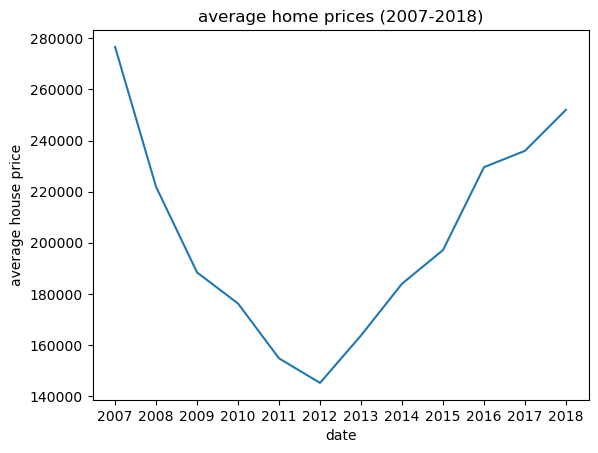

In [24]:
plt.plot(grpby_data1.year, grpby_data1.value)
plt.title("average home prices (2007-2018)")
plt.xlabel("date")
plt.ylabel("average house price")

5) Determine an appropriate selling price based on home sales trends as follows:

> a) Determine the current average selling price and the average selling price when they bought their home. Divide the current average price by the beginning average price to see how much homes in their ZIP Code have appreciated or depreciated. When Mark and Lisa bought their home in December of 2007, 3-bedroom homes were selling for \$276,617. 

In [25]:
price_initial = grpby_data1.iloc[0]

In [26]:
price_initial

year              2007
value    276616.666667
Name: 0, dtype: object

In [27]:
price_current = grpby_data1.iloc[-1]

In [28]:
price_current

year         2018
value    252025.0
Name: 11, dtype: object

In [29]:
house_worth = price_current.value / price_initial.value

In [30]:
house_worth

0.9110983912755316

This indicates that homes in Crestline are only worth 91 percent of what they were at the end of 2007.

> b) We can get a rough estimate of what their home is worth by summing what they paid for their home plus what they invested in it, and multiplying that sum by the ratio computed above. Mark and Lisa, for example, paid \\$291,000 in 2007 and invested \\$100,000 in solid improvements (new kitchen, major landscaping, hardwood flooring, and so on). Multiplying (\\$291,000 + \\$100,000) by 0.91 gives a rough suggested selling price of \\$343,134.

In [31]:
(price_initial.value + 100000) * house_worth

343134.83912755316

### Get additional information about the local real estate market

If their home is part of a seller's market, they are more likely to get their asking price. In this section, **BuyerSellerIndex.xlsx** data is being used for local real estate market analysis. The folloing steps are how we get **BuyerSellerIndex.xlsx** prepared from open source data:

1) Download the Buyer-Seller Index data at the ZIP Code level from www.zillow.com/research/data. In **Home Listings and Sales** select data type as seller-buyer index and geography as zip codes.

2) Open the **.csv** file using Excel. Zillow reports ZIP Codes as numbers. We will need to pad the ZIP Code numbers with leading zeros so the Zillow data will link to the ArcGIS ZIP Code geometry.

Follow these steps:
> a) Sort the RegionName column from smallest to largest so we will be able to see how the formula below works.

> b) Name a new column in the Excel table zipstring.

> c) In the first cell of the new column, enter the formula to pad each RegionName value with leading zeros, keeping the rightmost five characters: =RIGHT(CONCAT("00000",B2),5)

> d) Drag the Autofill handle down to the last data cell in the column.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAtwAAAFOCAYAAAC178q8AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAACT+SURBVHhe7d3fqyTZYR/w+yfo0Y/Cz37SoCU7YY0IBulRQokczT54HsI1iOBgCCR52SsSiYEYe0agNwvNWEJKpGUFIngiJIvdiZKNkbSrB8HaYRDKKlYckIIEAj3opd2nuqv71OlTP7q7TndV388Hvsztrurq7qo+Vd+uqblz9Vv/4W8WIiIiIiJSJlcLAACgGIUbAAAKUrgBAKAghRsAAApSuAEAoCCFGwAAClK4AQCgIIUbAAAKUrgBAKAghRsAAApSuAEAoCCFGwAAClK4AQBuqZubm8V73vOexdXVVZUPfOADix//+MfrqfMV3sv3v//99a12YZ4wb2l7PcPT69XG2OT66XoKAABzE8r248ePF7/4xS8Wr7/+enX7wx/+8HrqfNVFuqt0D5lnLAML9/PFo7u7Bfvpo0fLKUd6er24ujvCcgAAOEo44/3e9753fWveugr1Kct2MKxwP3+0uHt1d/GoRCtWuAEAJuH+/fsXcYa7livWpy7bwcAz3E8X18sX1ncFyfNHd6s3sEnjAauz5NdPV8u6urpeXLtEBQBgEsKlJaGP/eAHP1jfcxnign2Osh0Mvoa7LtN3W05zr6ZfL6t5Lb0MZXX77t3r5plyZ7gBAM6qLtvhz0tUF+1zlO1gr380ubq0ZPVim8U7nLXOXHJSzV+X8HXhTmdSuAEAzib8g8nwjyUfPny4vufyzKtw10JJDi+6Pntd3Y7PbtfiIl5fUlJN2FK4AQDOJvx2ktDrLlVdtsOf8c+ndPjajf8hpcINADBL4Qz3pfz+7VSuYJ+jdB/xdSb6h5Rtv8Ukc0mJwg0AQGldxfrUpXtY4Q7FOWnKz5N/JLn6T3His9zpNdsdhTt7dhwAgNLCGe7wqwAv6beTDCnUpyzdA89w17/KL85uSV6V8O08zX8g2VK41/dXj9mdCABAQaFohx52Sf9oMryfIUW6Lt2llX8GAAC4xRRuAAAoSOEGAICCFG4AAChI4QYAgIIUbgAAKEjhBgCAghRuAAAoSOEGAICCFG4AAChI4QYAgIIUbgAAKEjhBgCAgq5++ctfLkREREREpEwUbhERERGRglG4RUREREQKRuEWERERESkYhVtEREREpGAUbhERERGRglG4RUREREQKRuEWERERESkYhVtEREREpGAUbhGRkXJ1dZW9X0REbnd6C/drr70mE4ttdJmxXeebepulhTs37ykSvwavY95J16GIzDODCve7774rE0luB2wbzT+263wTb7tc4c49pmSm8lmayuuYc3LrUETmGYV7ZnEQu8zYrvNNvO0U7m2m8jrmnNw6FJF5RuGeWRzELjO263wTbzuFe5upvI45J7cORWSeUbhnFgexy4ztOt/E207h3mYqr2POya1DEZlnTla4P/O9/7T4rVc/nJ0mw+Mgdpk5ZrvevfuPWvP7v//PFm+99Vb2cTJO4m2ncG8zldcx5+TWoYjMMwr3zOIgdpk5ZruGYv25z/354tvf/vZO7t3750p34cTbTuHeZiqvY87JrUMZJ3fu3DkquWWKdEXhnlnGOoj93ZMn2fu7cshjZFiO2a6hcIdy/Zvf/KaRX/3qV4sf/ehHiz/5k/+4+Iu/sO1KJd52Cvc2U3kdc05uHco4CaX5UAq3HBKFe2YZ4yAWivP/f+kfL/7vn/1pdnouYd7wGKW7TI7Zrm2F+2c/+9nijTfeWHz1q19tjTPfxyfedmMV7nfeeSd7/5AM/Sy9+eabo+S73/3uzrJDhr4OaU9uHco4Ubjl1FG4Z5axDmJ1gR5SuveZVw7LMdu1q3B/+tOfqqa35WMf+6dK95GJt90YhTsU2C9/+csHl+6hn6VvfvObi89//vOLz33ucwfnyfILuMJdLrl1KONE4ZZT54IL95PFvas7i5tnuWkhfdNPkf1fw5gHsSFF+nRlewrbY6ycdruG4txVuP/wD693poX5w+N+7/f+idLdyHHb7tjCHUr2l770paoIf+1rX8vO05d9PkvhOb74xS8uvvOd7yy+973vDc63vvWt6jWG0p5bbsg+r+O0Cdv4anHvSW7atJJbhzJO9i3cYVv8+te/rn6eXuF+dXH/6oXFg7dz08ZK6ec4xXsIOdXz7GZ2hfvJvavF1b0hlzX0HTi7pu9/0D0sxx3cx9hGXYV6v7K9OoiFwrHNPu9t6Lo4Zttc5nY9pnD/9V//z4Gl+9ni5k68be8tnmTnK5V5bLuwbg7ZhnXqAvyNb3yjt9C2ZZ/PUl3wv/KVr2SLdS6hnIfX2PeFYJ/X0Z2wTeLP3r6fg1N9dsZPbh3KONmncH/2s5+t5g/bIxhWuEOxW35e77+ambbOq/eXn+cxyt/QEnlM2SxdVE9VhE/1PLuZV+F+drP8oN9b3Fum/2Dft5Ptmn6qHfT+zzPeQWybXLHer2yHZN7Lk3vVAXLYmaSh6+KYbXOZ2/WYwh1+7i/d4f1cLe7cPNvetxyLNyc9QziPbXdM4a4v8Qhnj0Ox/frXv17dbrtkoy37fpbC8sPzhOdLy3UuoZyHkt53ycu+ryObsM9P9yG5+zpzqs/O+MmtQxknQwt3XbbDn7XhhfuFxQsvtJW7txcPltPap++ToSXymLJZuqieqgif6nl2M1rhDoW6K//qv/1ZVbhz0+I8/sHXs8sPeXZzpzro13+m06uz38sdccidm5udnWzf9G26dtDxmb7tPGHZjdcUyuadm8Wzjscce3Dfdxt1JS7Y+5ftkJb30lgPIUPXRWa+9YF2dd8ym7/paFtmmsvcrscU7vBnSPi1guF2+BWC6fJ31kEm8dhqbu/1ungSb7vtF+bu9RtnHtsuLO+QbdhWeoeW2ziHfJbSst+Wfb4EHPI60rR+9hrbsuMzlt1n7G7jfT6/jaIfXkf9uAJ/65NbhzJO4sL985//fP1TU65sB/sU7vv3X8ie5X77wbJsP3iwKX+v3r9a3n57O084+/3Cg8Xb0WPihPnrz168nGp6deZ8O/3+q8v73n6weCG6b/OacvNGz7PNuqi+ul3OzuttW05j2v3Fq/X9jfQsv/qCUi8jKcw976FzXbUuN3k99bYY9F7yGa1whzI9Rn73L/9ldvmrA+R6Jxl2oslBOZTweEdZ3Y52qn3Tm2k/6FY75rroxa8j7HijS13iA0XrY448uO+7jfpSF+39y3ZI23tp3j90XeyzztrnTdO+vluXMYPtekzhzqW5/PBeuotEOrYa66V6/PJ2NL0xf8f6bWYe2y7shPfdhl2XdQy9fCPOoZ+lvuu5h1y3HefQ17FN17aIP5c9n7Gd5TRv7/X5rQp2/Lzjl+w4uXUo46Qu3GEdf/CDH1z85Cc/qW7X2sp2sE/hfvB2/WfPtFDkomK+U8CjhLIel/Hq9uY5lgXyflTUq4JYF8P0tXTNmyY8djkWGsWznrfvOYcU067lr0tzvX7Cl4fN++9+D93rqmu5yevZ3DfkveQzn0tKGgfFqHxXt9Mdanpf3/Q0bdPS++PXEabldsR9j8k9T3uOP4i1p3zhHrouhs7XN2+adN62++e1XUNJ3rdw51KX8Mbyw7jrLBW599q1ntL74nnDOmx7rtxycvefd9sdUrinUnSnUvw36fzsxdspt826pg95bNtnpe+x4ya3DmWc1IU7/EPIT3ziE43S3VW2g/0K97rkRWV6e3s7T7PMhbOubcUufkzXfblpXfOFDF1O7nacfZ6zTtfy02lh/bQts++5hy6377H7ZzaFO5yFiM98NW/HO8g66Y6xa3qatmnh/uU3nka284UzI9VfNzbOrHU9pus15HP0QawlddkOf8Y/5+bNp2udxQevIeti6Hx986ZJHxvf376MqW/XooW7ei9tpSckNz1+/7l1ERfcaP2GghWdkW6mbZ2G+9u2w+m3XVjWPttwapdynPvSlma6tkWYFu9X0vm6vkTFt+PltE1ve2x9e/UZalxqMlJy61DGSV24g7h0P3jwoLNsB/sW7mE/r862bi7/iAp6M+ExaRlvLmd1Fjfev+Wfr3veNOljhz5nPe/q/t5LVrLL3z4+t/zu99u1rrqWG88XZ/uY9veSz0wK93an1kzXDje+r296mrZpXY9ZZn1QD18GtjvfQ56nPccfxHaTK9j7l+78e6n+urZRdIasi33WWde8adrm7VnGxLfrPoX7vz79y8VX/vOXG/lff/u31bR84Q7FpatM5N5ruK9vbEYlJ7t+07St07b71znxtgv7paHbcKr/WPFc/3hzN6vPXvYSo7BdWy8Zqe9r+wzGt495bJy2+49Lbh3KOIkLd1CX7r6yHexfuLdntes/c/NUl0Os5xleTJP7wjJ2LoOo5888X+u8adJpQ58zzoHL73rcPu930PQ6XdNC+qbvZh6Fu7FzrdMsAs3r7ta3ox1g3/Rm2nee6XKaWT0u/CaVTZlYpv0x+++kjz+INdNVrPcr3bvvpSrbyX1D18U+66x7m8RpX99z3q77FO4vfuHJ4jOP/rSRH7z9VjUtX7iXCeNvWSQbZfjZ9reUVOuh7xrYaD3trrflPL2/fWge225o4e66fKMtp/x1fPVlLqf69YStqS4rST571ecx3kZ9n7F0mzZvV/N2fn7bH7tNfDyK52n7eVhy61DGSVq4g1C6w2e+zyGFe3V7+dnauS+5/cL9Ks2zss00rjuub9fLSQro6uxv/RzJ83XOmyb3foY8Z5xwyUbbmeGO5S9vp+95k57n7lxXmenbpK8nTdd7yWcWhTvsAHNnOZpnT1c7vPrs970n6c6tb3qcMG07b0jz8pVoWvJFIH8gb3tM12vIZ5SD2DpDCvXw0r27zna/JGXma10XbfPVRX55X+OgmJ+3md3XeAnbdZ/C3ZXWwh2yLj6d6yc7bb0ublalPffYzeN31m+ceWy7sKwh27Dvuu22DLme+5jPUp36C0F4rn2u244zxuuokn724r8dqdL/GWvuM3a3ce/nt7Ffqm+Hn7ePa34e43lyPw9Lbh3KOMkV7qEOK9zbs9xd87QXwDirsld/9u6/Gi+nOS39rRyrQlo/R/e8zaSvdehzhvniafl/CNq9/Pr2djnbkt33HrrWVddy0/l2521/L/nM5x9NSpWxDmLDi/S+Z7rlkByzXfcp3OGM9r/7N/+6kTf/x3+vpnUW7oMzrGSEwtM4izmjxNsu7IT7tmF9yUbuv0ofmlP8l+ph+af4L+aPz/5Fdi7JrUMZJ+UL92EJhXvfa4NlHplF4d5882hJ7jGXmjEOYn+3PFjvW6Dr0h0em5ue2y5pco+TVY7ZrqEkv/zyx6tiHeev/upbO4U7XD4SCnac//f3f99auHPbMU48bz4DylB1BrPrcpJpJ952YZ30bcM333xzlJQu3CGHlu2QY19H+llri8IthySU5mOSW+bRqX5XdvflJJea3Niuk5t/jnGGe2Y59iBWp604d+WQx8iwHLNdQ6nO5Y033qj+jAt3V85xhnv1V/nzLkvxtksPDoeMzWNzzGdpzJzudSjcMv+k1xbL5eVkhTv8D5K/2/qf2sjQnO4gJqdMqe0aCnc4+x3KdF/q/20ytxxpT7ztFO5tpvI65pzcOhSReeZkhVvGiYPYZabUdg2FO5TofZJbjrQn3nYK9zZTeR1zTm4disg8o3DPLA5ilxnbdb6Jt53Cvc1UXseck1uHIjLPKNwzi4PYZcZ2nW/ibadwbzOV1zHn5NahiMwzCvfM4iB2mbFd55t42ync20zldcw5uXUoIvOMwj2zOIhdZmzX+Sbedgr3NlN5HXNObh2KyDwzqHDLtGIbXWZs1/mm3ma5wn2OxK/B65h30nUoIvNMb+EWEZFhSQu3iIhIiMItIiIiIlIwCreIiIiISMEo3CIiIiIiBaNwi4iIiIgUTGfh/vcPHomIiIiISE9yXbpOb+EGAADaKdzA4qc//en6J2CujGOYnnpcKtyAAzVcAOMYpkfhBjYcqGH+jGOYHoUb2HCghvkzjmF6FG5gw4Ea5s84hulRuIENB2qYP+MYpkfhBjYcqGH+jGOYnokX7qeL66u7i0fP1zeBohyoYf5OM44dn2EfJyrczxeP7l4trq7qXC+H6hAGNJxS64H6+aPF3c34XeZ62AjOGzquw3zRc9oXwCDdhXusceX4DPs4QeFeDe678ahcHrwfDTpeG9BwStkDdVW2m+Pw+aNHy9F5qAHjel3wG70+dx+wo++L8zjjyvEZ9lG8cD+9Tsp2Rphn82377qPFdu54QKeDOzPt6WrHEZZT7TyeXm+Wu92ZtMwLtBfuxrjc1TuGo/HWSMvga91vhDG9Wb6xDDlthfugcRWN53ic311+6a7m2ywu/pvs+P725cFtUrhwh4HWffnI80d3dwf05qi5HqjVxPjnIJ0WDeS6aNfLqW7XryM379BLXOCy5Q/U6wNpy4Gyfwynj03HcqprephmLEOX/Dg+cFytpeO8uh0trzHuG1/S88uD26Zs4a7+qqrrAJjbAaQDv56ezjt0WrDPvHB7tZ0ZC1YH2CHlOdyXG8O1njHXud+IH5sup2e5cEtkx/HB4yrouy+dHr6kdy0Pbp+yhbsaaH2FO53eNojTQTt0WrDPvHB7dRXu2qp4x4V66Biu9Y25runx86Xz9S0Xbof8OD50XAXx9Fo8X/h5+WW8kXiacQmFC/fqr6Lbr6vsG9jpgI7nHTot2GdeuL2GFO7muM6Nn3Bf38G7a8ytlj/4WtPNbH3LhdshP44PHVdB331dY8+4hKBw4V6qrqtMSvfz7W8pqa77iv6Kuv0a7ubOonn9WDqgu273zQu3V/ZAvRzDzYN0c8wMH8O1AWOu+uvvZL9R7Uu6xq6xDEHrF+eDxtVKc1yvb0fzpdO3jEsIyhfuYD3IN3/V1LgGtB64uWnJQF2X95Dmv5DuO/DGt/vmhdur68zYZowukx5XB4/htc314NkD9Fq63+j8K+3AWIagtXAHe4+rWnM/cP00N/6i5W72A8YlBKcp3MAsdB6ogVkwjmF6FG5gw4Ea5s84hulRuIENB2qYP+MYpkfhBjYcqGH+jGOYHoUb2HCghvkzjmF6FG5gw4Ea5s84hulRuIENB2qYP+MYpmfUwv2/f/x/REREREQkSaBwH5BXX/svIpNP7rPbl9xyROR8yY3TvuSWIyLnSRiTgcJ9QMIKhCmrB/m+8dmG6TCOYd7qMRwo3AfEzoyxvPbaa6MncKCG08mNw2MTGMdwGrkxeGyCegwHCvcBqXdmf/7dX1T5F+9/jz/9ufefQRiU77777mhJB/m+caCG/RnHMG+lx3Aw88L9hcW9qzuLV97ITSuXemcWlyeRfRI+N4EDNcyfcQzzVnoMB+MX7jc+uXjf1dXiqs7Hv9Ccvlf6CvX5C7fIoQkcqGH+jGOYt9JjOBi3cFdlu1mAn73yycXjevremX7hdoZbDokz3HA5jGOYt9JjOBi/cL/vk4tn9e1MHn88OvvdmHddnh8nZ8jrZM+U5x7z8qbgh+d63yvf2c7/+OXkOQ9LvTPLFanx89XFS8v39dJnctNkzgku+0D9dHF99eLi4fP05zGVWi4Md9njeKhTjHcoo/QYDsYt3D/+zuKV9y1Lb0upffbKnca0qnxvinQoz+ljh5zhbj6m8RyhYEdFfaeAH5h6ZxZK0+oM96oUN78kvH/xsa/li9Z5sn6Nv/Ppxaey06b2ei878zvD/Xzx8MX48329PKT2GXYAfnp9tbjOLezp9eIqOyHmwM75zWIcP3+4eHEzfpfpHVv7GrNw9z2+9PLPacqv7XKVHsPByIV7lar0hgHdW57DffUZ6bbpfYW76zHx8sOXge3Z72NS78y2BSpTWD/zB8t18AeLP9rMc+5svxT89h+/lZmmcJ86wSwO1NUB4GrxYnwEWB68H/Yer+MDR8dBpKVYtxbxBgcnzm/y47gq281x8vzhw+XoGdPA8T5I3+NLL/+cpvzaLlfpMRwUKdx1VsU7LtRp4U3L8RiFOxTr7X3hrPa9x8ufw+UuR/0Dzm3qnVkoTdsz3GlhTe97a/Gx36nPLuyW2z/6SD0tFOJPR4/dXXY8b/OM9Xrez3x68dvr6dtLUerlhD/TS1SS56i+LGyfY2cZ6fKj+ZvL7X7Ptzl9Z7g/9KEPLZ49e5ad9s477yw++tGPZqeNfqBeCsW3UbZ3xGe/4wNFfODoOoiEaekZ8+S+UMrXn7GQbRHveo70dtvrXGosf8jZe9ia/DgOhfvFh8sRkLMeJ0+3Z8Cr8RWNicYX34PG4h5jr+9MfMf0sK/a3N/6foP09UX63l+9nqLlx8/74vKLTLH3TjGlx3BQtHDXl5hUhbe1UJc4wx0V+/VlJaH8r17H8al3ZtsClRTWZT71x+9fXH3kq5vbVUmub39tWVijolzNm97eLK+57HTexnKreZe36+mNs+zRcnbOvsfPsSzJH4lK/M4y0uVHz58st+s9S/cZ7jDAcwO9HuCPHz9u3F9n9AN1dZDpLqDVwaY+MDQO7F0H4KadUr88EG1vLw9Y19HBszpI1a+p6zmat7tfp5LN4aY/jtelL1tCw+c/mlaXwHqsNMbbYWNx/7HXfPyu3enPH764W4JbC2vb8vve3+46TJ+3ul30vVNC6TEcjFu4l+W2eY10sxBX12x3XsN9SOGOl5Eucz3P+16uMsblJCH1ziyUprZruJuXbcSFNiSc+c0X6t35236O582U6s7lpMU9t9w67cvovp1Oi9+zDLmGOx3ofQM8ZPQDdXXGJXdQqKUHh3Bgr2/H03oOIuHAtjkQxcvIaVtu+hxd09peJ+xv8uN4bVUGl8eoRmnsGjdB1/iIpw35ORgy9trur6XTc/OH+9r2XX3Lr8XztT1H133p9DHeOyWUHsPByGe41/9oMiqe6VnlqhDX0wf8A8nN9eDZy0HWj3nl5ZZlrrJbwo9LvTPbFqhmuUzPQq+mr1/fJnExjc821/flius+8/ZNW13usfpi0Jy2OsPe9lrblp/eDj/Hy4iXIyFB1yAPqQf606dPewd4yPgH6rDz7yvc6XbOHVD6DiLRgahxFmhlUxT2eo50Wvz4eBnBdnrrSTFoMf1x3LQaT/GZ27ZxEzRv7z8Ww8/x/PFjgu307dhrPueudHq4ne6nupbRPm3Y+6v1PW/4OV5WvLxgO334e6eE0mM4GLlwTzOhcI91OUlIvTMLpantGu7dSz3aymZuWlpccz/H8+5/hrs5PZoWLgvZ+bLQtoyu2+k0idN3hvuHP/zh5ucw0F966aXGAI+nxxn/QB2KcFcJ7To4pAee7oNIONCFy0jqPzcaZ7+DtuWmz7Hf868MnQ+2pj+OU/G47ho3QXT7oLGYLq/NPo9Jp+fmD/fteYZ78Pur9d3X8jw7DnkMYyo9hoPLL9zVf8Yz3uUkIfXObFugcuWyeV+zgDeTTqtutxTXalpUiLuLfXw79xqXqa/DrqclhbvrevK+213vWWb0W0qq6xiT0v18+1tK2q+V3PMgUp3Zvl5cp5eTJAfB1Rmo3HJXJaIu6835ul5nrO8LBuya/DhejqHGl9jOsdlxe/BYbC5j/7GXvobU7vTqOaLX1v2cLcsf/P620uepbkfzjf/eKaH0GA4uunCvLl/pugb8sNQ7s1Ca2s5wh6zKanz2ObyedRpnkePf5hF+00e8vN1lrwp5bjnpvN3LqdMs+M3X0v0bU4bc3i6r+Vpvd4Zcw31IRj9Q16pruaNtuXMWKDctPnAMOYisDjq7B6f1/evlN38LQLLc9ZeD3fmCrte5vb9ZTKDf9MdxcwyFbIdZOja7bg8di7llRM8/YOytyu7y/paympu+KrvrNPZRqeT1LLN67j32NRvNx1w/Lf/eGV/pMRxc/hnuAql3ZrkiNUrCb/TYuVZbLi3B9A/UQB/jmI3ef2jOFJUew4HCfUDqnVkoTasz3PlCdVjWZ5hdinHRmd0ZbqCVcczK+my3M9OzU3oMBwr3Aal3ZrkidUgal4iEKNu3IoEDNcyfcXx7NS5jCVG2Z6n0GA4U7gNS78xCaRr/DLfchjjDDZfDOIZ5Kz2GA4X7gNQ7s7g8+dOf+/4ZOFDD/BnHMG+lx3CgcB8QOzPGEgbl2AkcqOF0cuPw2ATGMZxGbgwem6Aew4HCfUDszJg6B2qYP+MY5q0ew4HCfUDCChSZenKf3b7kliMi50tunPYltxwROU/CmAwUbhERERGRQglGKdwAAECewg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQkMINAAAFKdwAAFCQwg0AAAUp3AAAUJDCDQAABSncAABQ0NGFW0REREREupPr0nU6C7eIiIiIiBwXhVtEREREpGAUbhERERGRglG4RUREREQKRuEWERERESkYhVtERESK5urf/o0USG5d9+W1116TAsmt6zgKt4iIiBRNrizK8cmt676Ecvjuu+/KiFG4RURE5OypC2KurMj+UbinFYVbREREzh6Fe9wo3NOKwi0iIiJnj8I9bhTuaUXhFhERkbNH4R43Cve0onCLiIjI2aNwjxuFe1pRuEVEROTsUbjHjcI9rSjcIiIicvYo3ONG4Z5WFG4RERE5exTucaNwD82Txb2rO4ubZ7lp40XhFhERkbNneoU7FLGrxdUmaSnLFLUn9zLznSfzKNzPFjd34nV8b/EkO1/JKNwiIiJySzKpwv3sZnFnWQDvPem6LylqVdk+R2HMZ/qFe/WF5s7Ns+19y3V8E6/zk0ThFhERkVuSKRXuJ/eSIlgnlOo7N4tn1e2oqE2sbIdMvXC3ruM61Trdnv3e+aLzZPUFqDltlbDs+nHb54jPpscFW+EWERGRW5LpFO6uAham1cU6Ln7TKtsh0y7c8XrMZVmO79VfbJZpfKEJj12W5vqLT/Jl59nNnehL0bPFkyerwl2V8HtPVssLf1uR++JU3S4ThVtERETOnskU7urSkbYyGJezdfFrnEWdTiZduDvXcS7peo8Lcte03Dwh4Wx332PGjcItIiIiZ89kCndnAQvT4jOtYb7w5+5lDefOpAt3Yz3mU52pXn+haV4Gkm6f+HbbclfbaNjyykThFhERkbNnOoV7da3vXtdw7/yDyvNn2oV7tY5b11djPYekpTouyF3TcvPsM228KNwiIiJy9kyncC+TK9DVtcJtRW+Z6jHli9vQTLtwL1Otz2QdL9dh9VtKksK9Ottdr9u0IDdvN67VbruGuxGFW0RERG5JJlW4Q9ale3sJQnqpQqaorUvkFK7pnnzhDknXcfSPHePfz33n5iZa192FO33sttCH+bb3Z/+morpdJgq3iIiInD2TK9wzzywK9y2Kwi0iIiJnj8I9bhTuaUXhFhERkbNH4R43Cve0onCLiIjI2aNwjxuFe1pRuEVEROTsUbjHjcI9rSjcIiIicvYo3ONG4Z5WFG4RERE5exTucaNwTytp4X799dc3qe9TuEVERKRo6oIo4ya3rvuicI8fhVtERETOnlxZlOOTW9d9CeVQxk+8jhVuEREREZETR+EWERERETkw6Rnt9HaIwi0iIiIicmDSgp3eDlG4RUREREQOTFqw09shCreIiIiISMEo3CIiIiIiA5Oewe67HaJwi4iIiIgMTFqo+26HKNwiIiIiIgOTFuq+2yEKt4iIiIhIsfxy8Q+YnCTAQGHgHwAAAABJRU5ErkJggg==">

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAA4QAAAFmCAYAAAA1XVSbAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAKM4SURBVHhe7b3Jr2TPdteb/4dHT3ojRgx+E87EEwuJPwAG6IfEKD198htgxMD8QPjybAmOQEh2Ua5XKp965XLdunWrbNe1DQJbuj+DMY25Nm0B5oK59H3fab8dXe5o1opYsdfOzB15vh9pqSozY0fzXU1EnHPq1OE73/nOBIPBYDAYDAaDwWCwx2e4EMJgMBgMBoPBYDDYI7XDL/3SL02w8Y1y7rWNmicMFhviBQaDwWAwGOy6dvjf//t/T7CxzTgyPljvxcy8qPnCYMbyuEW8wGAwGAwGg13ecCG8AcOFEDai4UIIg8FgMBgMdn3DhfAGDBdC2IiGCyEMBoPBYDDY9Q0XwhswXAhhIxouhDAYDAaDwWDXN1wIb8BwIYSdw/7bf/tv01/6S39p+vDhw/RzP/dz0z/+x/+YbLfWcCGEwWAwGAwGu77hQngDhgsh7Bz2z//5P7eXwa9+9avTq1evpl/91V8l2601XAhhMBgMBoPBrm+4EN6A4UII29r+9b/+19Of/JN/cvoTf+JPTH/9r//16Qd/8AenP/yH//D0b/7NvyHbrzFcCGEwGAwGg8Gub7gQ3oBtdSH8qZ/6qZNRn/ea5oBvflzxX/7Lfzn9nb/zd+x3qv7n//yfZLtbsP/xP/7H9B//43+c/tN/+k/k59ew169fT7/v9/2+6S/+xb84/eZv/ub0Qz/0Q9Of+lN/ChdCGAwGg8FgsBszXAhvwG7xQvgv/sW/sD+iaPr4C3/hL0x/62/9renf//t/T7Y1Zi6Q5hnzna3/+l//K9lmj2bm/Ru/8Rv24vtP/sk/Idtc2v7+3//79ruB5kL49/7e37Pvffvb37bzM/PN2681XAh77JvTV77ne6avfJP67DFarMe3p1ff+z3T93zlm/azb35l/vv3vpq+XTwzil1rPW7c7331beKzHtuqHxgMBoNdyg7/+5tfmb5n3liX4u02WvNeMBxC9m23eCH8D//hP0z/4B/8A/sdKtOPsb/8l/+y/W7h//pf/+vUzlxQzEXl137t16a/+Tf/5vSv/tW/GuZCaOb+d//u37UXXjN3oxnV7lIWdP2FX/gFexn84R/+YXvJztttZXncauJFYt9+9b1JXXP2vdOrb2dtbU0k3jf27VfT9xZ9fGX6ZtTGjZO+58zVVldr/aG/6CsyfyE49UldCoj5UAdxcu1R/yfz+0F7/tlnwnnE6073FZ0e9tJUuUAV6yfWvqc2rfXEVvRljYpfwd5u/U/5fjE7n6yfoi9BPzAYDAbbjx3sJn7ajNymHBf2UPxxKdyv5QfrvZj2gG8uKOYCGL5TaOyXf/mX7W+7ND9mab4b+K1vfcv+Jsx/9I/+kX2P6mePZi68f+Nv/A07d7Om8KOxVNtLmLmc/rk/9+emn/7pn57u7+/thdD8u0HzC2W+8Y1vnGVuedxq46Vl7uBMXd6ow2x5oOZqoe0jOrBT4zirXKhql1DmOy70fPK24aKV9x0uB7Qe1oqLDD1/2Ty8+YvCV8wzxEXpZJ162Dn4/mh/xH35tUfj761NbT25uf5SPzqfxGM4zWIf0X5zc8ljPDb7XGU+ztr9wGAwGGw/dmgWdv+V32Jjh+3G8oP1XmyrA775t3XmRxfNxcn0ab6jZr4jaC5T5heebPnv2i5h5jL467/+63Y9xsyF13xn8z//5/9Mtr+EmX/D+Gf+zJ+x/3bwB37gB+yF0Pybwa9//ev2Qmj+PSf1nMb2cCGkDuPUZaQ8xPNGj2PMjUXW0toFyNbg7DPbvn3grs47fFevuKx8ZXpFPkfMXziPYKeLjn2O0shbpx7FBeq0Jlrz1Ed7a1NbT2n5s9Yk+zbTJh6bMtmFsN0PDAaDwfZjh2QToUyyscDU9od/8I+yRrWPbasL4Z5+ZJQy02f8I6TmIrWnHw8139E0v/zmv//3/578WGts5jJoLrNm/uZCa9aQ/xjsNSyMb3781nxn0FwIzY+OmvWYy+A//af/1F4aTRvzbzm3+FHSPG63jpfcyIMzdUAvLiP+u2zCwy09jjH6MmCtcgEq+/PzaR7K2/O2h/ao72Usaox8/tJ5BHPPu8tjRQtjXXq4dYS+7OdhzX7/Ki6stn///t7azK/Z9RBG6cGOE5tvk/uA7C8y6YWw1Q8MBoPB9mPtXyqTbVSw89may6Cx/GC91vZ8ITQXv0+fPtnvDpp+jZkL1Tm+c7XWzHcqzYXK/AKW//Jf/kvxuVmD+RFX811BM3fzXcI9zd+Y+eU9f+AP/AFrZn7momg0/yN/5I9MP/uzP2svhn/8j/9x+19SmEuh5re/5nG7Ol78wdbUqdKWSwV1QHUXouziYWte9B5zcOaMPwivuxCWB3DXT/uC2rh0zebmymhU1P68P+k8vNn+Fl2qF4suPSrG9RNfmPbWJn5fYHxcUzEYmZ0LMSY3R2+u79R6YxoGg8Fg+7LGhdBv+OKvAMO01nsZNJYfrNfaXi+E/+7f/Tt7kTL9/cqv/Ir9N4Tm4mJem180Yz6nnru0me/2mctT+FHW+L+RMJdBM+dwGfxrf+2vWY3i5/dg4RfKmAtgmJ+5tJpLoHnva1/72vTu3Tv7bw2N7pp/t5nH7Vbxwpk7OGeHWeoykx9kicN60VdUI8lxIus7PFPf5Wtf9Kz5ea++EM6WXizoC2FzHtaIddQuDF16VIzr5xwXua3axO8LjIu3ul8qe3vnXML4xXiKNcFgMBjssla9ELrDALF5wc5qPZdBY/nBei+2xQHfXDrM5cn0ZS5S4ZebmAvW3/7bf9u+b34Ec8v/DmGtmcupmY+5tJq5mgug+XeB5tJkfpuoec9cCM3l1vybwWv/mGhu5rt979+/txdC8x3AcNE22r58+dK+/+rVK9vOmFnXLr5DKLT8shMOssWBNT+0+4Mtd8DOv2OVj7NY5QLFXRQqF8L2pah9YaM1ieaerD3vTzqP2cjLwVZ6VGyrS9ol28TvC4yMN98f98Xc6t6+Yi55DlhTrAkGg8Fgl7UDV6xxGRzH8oP1Xkx7wDf/Zi38hlFzkfpn/+yfJZ+bi4r57Zzmc/NjmvFn1zDznUtzOQ3fBTR/mktruAyai6L53Px2VOr5a5u5vD59+tRe/H7iJ34i+feZP/MzP2PfN98hjJ/RWB63q+MlHH5JW2oYdXAmD7LFob1+8bnIhTCZI/UeZe3Lk2Tu7j0zt3z+0nmEPua2pBFadelRMe5SEve/tzbx+wLj4m3xW/p+c2/n5lgx12c2hxX9wGAwGOw6duA3DBTyUSw/WK+1Pf3I6L/9t//W/t98pg/zY5jcf9pufoGLuRSaXzZjnqHaXNLMj4maS2C4AJpLoZmbef1X/spfOev/66c1M7c/+kf/qL34mR8dDe+bNT1//ty+/3M/93P2u4LxZXGtbXYhFBp5cLYH8azWEYdz7nBt7LwXwrJ/Y26Mdo2uHv79gT2eDz33cCH+SjF/2TwqF1NK/9P7cj14ozVP17m3Nn3GPeveTzUU7e0V7WljLund/cBgMBjsWnawhTzaTNwm0j5owPZjt3ghND9uGX6BjPkP6ms/Xmm+U2j+Tz/zo5h7+NHRMB/zI6ThYmj+NL+kZYuL1LnsH/7Df2gvfX/wD/5B+x1Xs4Yf+ZEfmX7yJ39y+sVf/EV7WTT/FYW55JrvhlJ99NguLoTUYZY8yPp2RW0sn+cP9/RlwFrl8FydN1GrzaF/GcONWTzvL4P0RZOYu52fGy+dv2Ae/ll6T/Hzyy+L3XrwVlyKiYvw3tpULdOG1qPU1bVr7+1Ff/F4Zq5kzJT99voJBoPBYNezQ9iM3MYRDg+URRsYbFd2ixdCc3kyz5tLifkuINUmNvPjjuZCaC4y1/z//IKZ76KZ/yzfXAaNmR993csvvwlmfhOq+W8wwiXVfAfTXAifPXtmL7XmF+OYXyRjfoGM+dz82OgP//AP28tt7b/WkNo+LoTh/ai+VS4j4XKTmPRStfJCWPssHMZjo/p3l5B2u9ohPvRBXShq83DP8RcD8vOVenCWr1+i0bXbcJbHK6W9teSSLd/b7dyKL3CENssXABarxEuWGzAYDAbbp7X/2wnY7m2rC+HWpjngm38vaP7tXfglMhIzP1ZqvstlLjnU55c280tXjA7mYvUbv/Ebu/slMuY7f3/sj/2x6cOHD/ZS+PDwMP3+3//77XcAQxtzaTSfhV8kY3581FwGNb9MJtilL4TjWuUi+Sjtcetx3otWqe268RCzMBgMNpLhQngDdosXwlsx811B8/8nmt8qSn1+TTM/Ghp+UYyZ4/d///dPL168OP0H9Oc2XAjlZr9Lg++2nOzx6uEuWq0f+1xt9ruv8Xf8Vo5X9AODwWCwPRsuhDdguBDC1pj5xTE/9mM/Zn+zqPkxUfP/C4bf5HqJ72biQthjZ74IDGePUw97EaZ+Oc8m5n4cNP6u3rrxyn5gMBgMtm/DhfAGDBdC2BozP/Zp/r2l+beOv/mbv2l/PNS8f6kfbcWFEAaDwWAwGOz6hgvhDRguhLARDRdCGAwGg8FgsOsbLoQ3YLgQwkY0XAhhMBgMBoPBrm+4EN6A4UIIG9FwIYTBYDAYDAa7vuFCeAOGCyFsRMOFEAaDwWAwGOz6djCHMNj4Fh+s92LUPGGw2BAvMBgMBoPBYNe1Q3wgg8FgMBgMBoPBYDDY4zFcCGEwGAwGg8FgMBjskRouhDAYDAaDwWAwGAz2SA0XQhgMBoPBYDAYDAZ7pIYLIQwGg8FgMBgMBoM9UsOFEAaDwWAwGAwGg8EeqeFCCIPBYDAYDAaDwWCP1HAhhMFgMBgMBoPBYLBHargQwmAwGAwGg8FgMNgjNVwIYTAYDAaDwWAwGOyRGi6EMBgMBoPBYDAYDPZIDRdCGAwGg8FgMBgMBnuktvpC+Pzt/zf9v3/jG7CVZvSjdIXJ7Nd+7dfI92Eyg346g346g346g346g346g346g346+9mf/dnpW9/6FmylGf0oXXEhvJLhQqizX/3VXyXfh8kM+ukM+ukM+ukM+ukM+ukM+ukM+unsG9/4BnnRgcnM6EfpigvhlQwXQp391b/6V8n3YTKDfjqDfjqDfjqDfjqDfjqDfjqDfjrDhVBnuBDuzHAh1Nmv/MqvkO/DZAb9dAb9dAb9dAb9dAb9dAb9dAb9dPbx40fyogOTmdGP0lV8Icx/5hkXQp3hQqizX/7lXybfh8kM+ukM+ukM+ukM+ukM+ukM+ukM+ukMF0KdqS6E5jL40z/908l7uBDqDBdCnf3SL/0S+T5MZtBPZ9BPZ9BPZ9BPZ9BPZ9BPZ9BPZz/zMz9DXnRgMjP6Ubo2L4ThMjjUhfBHfsd0OBym//P7f4z+fAe2ywvhw+dWt9w+fyDaXtm++c1vku/vwb784jNCx8+nB6LttWxv+tGa7U+3YLuMPyZ/96jhXvOXi8O91cDx6t++NNxn/ePy9GH6fNbvsy++JD67ju05/r7z5RfTZ4fPpi++JD7bie1aP2tfTl98tq+Yi83cR6iLzlXt7f81fdfv+b+mP529/40nv2t+/7dN3/3k55P3r2n5fS5Y9UIYXwbHuRD+2PS7f+t8Gfytv2U6/Nbvnf4fss31bb8XwnRTchvV/orrL/7iL5LvX9XsRjQffj77Yvoy++zh831puDf9uAPR6XD5+UPy/rVtl/FH5O9ebZf6zWbjjcjfvdlo9c/E5p4Ol6PUP2f7uxDuNX+tDXAh3LV+1nAh7DbqQmjf+23T730bvbcD674Q5pfBvIPdXgi/8b3T/3n4HdP32T9/y/S7v0G02YGNciHc42Zk7M//+T9Pvn8926dOnO1Nv+qByB8096Tt/uJvtoEuhLvUb7ZRLoSofzobqv7tUNu95q+1AS6Eu9bP2r4vhD/1Uz9FXnSuavmFcKeXQWNGP0pX8kJIXQZHuRD+P9//W6bD7/xD9u/f9zv3+2Ojo10I9/YjU3/2z/5Z8v1r2cPnzFfGd2p7069+INqfvnvTz9pAF8Jd6jfbKBdC1D+djVX/9nch3Gv+WhvgQrhr/azhQtht8YXwF35o+u6d/ZhobOILIXcZNBa32+eF8A9N3z0Xzu/+Ef/a/lvC3zF9X9Hu+jbKhXCvG/3P//zPk+9fx8b66rixfenXvhC62NzPJr83/awNdCHcpX6zjXIhRP3T2Vj1b3/67jV/rQ1wIdy1ftb2fSH88OEDedG5qp0uhD8+/d4dXwaNGf0oXZMLYe0yaCxuu8sLYXEBzC6IO7L9XgjnC2Bi+zxgcv+x5lXM/0jjHn/5Dme70m+20S6Ee9PPGpm/s+3s318a26V+s7k4zDXcXw1E/dPZPutfHnep7elwvtf8tTbAhXDX+lnb94Xw/fv35EXnqmYvhL9r+u7v+23Td/3gj9NtdmJGP0rX04WwdRk0Fj+4xwuh+RHR8OOitff2YKN8hzBs9nsrDHk8XtUGPBDtSr/ZRrsQ7k0/a1T+7tR2qd9sNg4H+A7hEPUv/wLFjnQdq/7t7zuEe81fawNcCHetnzVcCLstvhDOf/7ALxBtdmLVC6HkMmgsfnB3F0L7S2SizSex/f1ymWEuhLM1D+tXMO5b3tex8X5kal/6tWNsbzG4N/2sDXQh3KV+s41yIRyt/u3tnx6MVf/2t7/sNX+tDXAh3LV+1vZ9Ifz6179OXnSuaqcfGf356QfspTD7jaM7MqMfpetBehk0Fj+4twuh/WUy5L8XdD82urdfLjPShdC9v68C++7dO/L965grniMcJIPtS7/Wgcjru6MffdybftYGuhDuUr/ZRrkQjlb/9nYhHKv+7e9CuNf8tTbAhXDX+lnDhbDb4l8q4/8d4Xd93w9N38jb7cDYCyF18eMsfnBfF0L3fw9yPxpqf2x0Z/8nIb5DqLO3b9+S71/NrHb7LaC57U2/aozt8AsSu4s/YwNdCHep32yjXAj3Wv+4H5vf24VwqPq3wwvhXvPX2gAXwl3rZ83F3F7/GYy5UFMXnataciE0tt9LIfcFidu4EPofF2V/eYz9ZTP7+uUyw1wId3rR+cmf/Eny/Wua29Tngw/xnay9/cf0e9OPOxDZg+QON6Y9xt9IF8Jd6jfbKBfC8erfvi6Eo9Q/Z/u7EO41f60NcCHctX6z7b0OjnEhnM3/9xN7+yUzN30htN8BrP73EvXvIF7D9nshdAfw2Pb4VaKf+ImfIN+/vrnNu9BxZ7/pcW/6nQ6TO9ct2C7jj8lfY3vL4b3m7ygXwv3WP//jo0UM7usLFfusf+NcCPcbf7MNcCHcp35x7u77C4tf+9rXyIvOVY26EJ7e39d3Co1+lK438iOj49kuL4QD2cuXL8n3YTKDfjqDfjqDfjqDfjqDfjqDfjqDfjozP3JLXXRgMuN+ZBkXwisZLoQ6+/Ef/3HyfZjMoJ/OoJ/OoJ/OoJ/OoJ/OoJ/OoJ/OcCHUGXshpN6UGC6EOsOFUGfPnz8n34fJDPrpDPrpDPrpDPrpDPrpDPrpDPrp7Ktf/Sp50YHJzOhH6YoL4ZUMF0KdPXv2jHwfJjPopzPopzPopzPopzPopzPopzPopzNcCHWGC+HODBdCnf3pP/2nyfdhMoN+OoN+OoN+OoN+OoN+OoN+OoN+Ovs//u/fDlMapevhw4cP0/v37+2vITU/V/rmzZvp9evX06tXr+w/fH14eJhevHhhv8Vtvqrx9OnT6cmTJ9OP/uiPwmAwGAwGg8FgMNhFjLrgwPqM0nX1dwjNw2A9v/7rv+7/BtYA/XRAPx3QTwf00wH9dEA/HdBPB/TTAf10cPrhQnglENA6oJ8O6KcD+umAfjqgnw7opwP66YB+OqCfDk4/XAivBAJaB/TTAf10QD8d0E8H9NMB/XRAPx3QTwf008HphwvhlUBA64B+OqCfDuinA/rpgH46oJ8O6KcD+umAfjo4/XAhvBIIaB3QTwf00wH9dEA/HdBPB/TTAf10QD8d0E8Hpx8uhFcCAa0D+umAfjqgnw7opwP66YB+OqCfDuinA/rp4PQb9EL4abq/O0yHu/v5b2Ny3YCGfo+d29ZPHt8fj+vyoF+/8XNurVYpTgfop2Oc/N2n37B/6Hjs+uW53Jvb0O+S+l27Bu2vBnL6bXoh/HR/Nx0O88ITu5vuN1fhXAL7fos1RHb86NvqoBwyvn6ej0c/9+NUqvVxOs6f3SkXRQd07r9zaHcbVAvqp/vp7qShs9hf8jiV+mNpV08vaX7K43vtIb0//uRzknK5euEQa1WNH6cD9CtZ5lObg6uf4v1jo/1qfd/b+y2hUas4xPoJ+zsXW/q0J75Mu9q65fqdL5/WU6szMs5xoYF+Ov14zlyDmlx7/BJOvzNcCNNLQAjyjfaly2IvNudJSL4gjK9fUtiKiZ/rQkgknTksxK81/jxjLFwDriDYwlzEm9M2+IyKU/dcrI/AHwGr7XE6mj56Ar3HJ0zb3o0osCr+NubS9UKilSR+DNCvJIxtjKuPoQ27fyT9+8N9j4ZMnmzS98ZIY42C1S+Lh/lNd+G8+Dp9PhS+CBe2bJ4CeuKr1sYg1c/5SFijL8I2dSbP5VZu50C/7fW7KIOfBzn9zn4hnJVzBewcO+y5OaPTxRvSgPqFddzbP+kNrbVhtyj1E/Sr8efgBSCHLAh2je3DMBmn/uC06C/3s90MzKB2/Dz+K/T4hGnbuxEFVsXfxly6XjS1EsaPAfqVpHWTyoNw2bnn94+sf9dnR91i8mSTvrekI9YoWP0o3Yvadn6q2oZLaufiw/ok8dXKRbF+V9CuzjZ1Js/l3n0E+m2v30XpOXvsEE6/i10IiwDyBf1kRTCEr5Dl5vonAygUysjymmmfm990c/XtuEBknG77IApqPCfzd7PmZJzoGfmGNJ5+yzqIryYx63GaRpYNnI9b6uf65TbJov/Z4jnUxm89OzdIPy98sT9K/Shf0ZBx6mNnka3ujwXXzjVjYp2jUpStz/xaav6L250Q+LM3/gzpWL59YtlaGvPoqReFBtk87efze7W8zrUKbd1Y8vgx/UC/XL9oPkUueU7x/pHfP3L9iRxJ5hiNX6wx+kzSd9Dg1I9vn6/bwM3hRNV30ljz7QhfsfoV8eBwa0o/O60zWDQO1d6QaJHtt8vj9Lxj8v7t67l9oiupuSy+Wjkg1q8Yi/dJmG++tkDcxlKNEd9+Huc0b/t5u85YJH1H7xVzM1T6gH7pe8XcDF361fcDajwT30m+MNqHz8OST3pEltTQQjN6fNOulq8nX4fPT1b6thcq/gxnvxA6YagNKW7nF34SpAx618/yTC7w/Mb8eVbk/HtxYXP9xH3Txc9in0/nbqEKavZeOU66RmlBGFG/ZH5Fv2V702eiP6FvPi6vn2lH+MzA+FMyPvds2xf7hC2oyaJp+DhN32v6w2B1rcRlDcYnhqKfiu/jdlJ/rom/2trWzIP3Qzq+ea83v+Z3yDw9jW/1LPNaEj+mH+iX6xfPp6zfBvu8fU9+IXR9LuvJX8/vzGNFr5k8kfRdauBI1j3TmoP7vOY7aazxOvLxl8ZDgFprNSaoPSR5L48PM9cwdhk7OW3tyz6W9fG6uPfo2I1fS/Vz8yJ8SY0d/NvUjhorj5EwdjmWe9Z8FsfggrjvyutWH9Cv/nqNfjGt/su15XOs5edM7TxBaNYenxov7cc9E2uyHk6/8/9SmUyYsPDy7Vhgok3mgFTgUrxALqJ9nbVL+4pgnE6Nlwcw2WfUH18QzHwjK4XavX6kFqfXeeBTMMkQjcEWBF/4nH6Z71h/5hB6kM9KfLFPSv0kfnGQcco9W/OHWGeGSts8Xri2aTu5P9fEXzGnQNG/bB6yekHB5Ff2bD7f02s7j3x+8vgx/UC/cn5J3czXlBzohBfCoOVpIDfvqo8KLR3tvv36orofSHVozUHiO2msEfVlxsyH1Y+Yv4XRZSEfqxw77b+yBq9tbX2ur2U+VmNinbHPkvEb8dXSl9dvHjOztB/eJ3mMtLTLuijWZPvk/Bni11rs146+I23T1+0+oF883/z1Ov1OZGMZ6uN5kufcHNgcIMYwcJqR41d9SGjAjLkGTr+zfocwBHiyqCSQcguLLQM6F7opXiATse2IiIoD0rUy880nFBVdyYY0qn75OsKcXXJRiebne1qHt3z+0RjVgmA46RTNg/Vne3zyWZEv9kmpn/NLEbMEhX8NQQsqjwyUP/x76ZBUfDBU8jOPF65t0q7Dn2vir5iThdBdOA9RvbAI8yt7MJ+vfe2fLf0jjx/TD/TL9cvnk+aB/ezUV+VCGOZGjeN1qbqIyZNm3zOUBoZEh9YcRL6Txlq5DxrMfHj9lniIcZ/FurRjIu2vnMuiaa536nuKfK6U9onuM+kz9fgqx0/XK9Yv+PPUN+8Tfq7ZM8L8pjQpOPXlx+rpO5pv8lrQB/SbX2+sn4OuDeR4+dr8uItMRsNlzITaeYLQTDJ+2qb0s/08j4+VcPpd5kdGIyFy0Wm8GNYZwSr91vq0jluebTsionLgnD9ciiYxPjVO3E5aEEbUj1qHe89omW82fq6J/kwyRG34ghBh5x6ti/SnbHzyWZEv9kmpH6UDDeVfw+Jj/0ZO5g/Xfh6TtLL/AtKfjiJvmLbiPMhYE3/FnGbse/lahfOg/FCO0ZFf2YB5X+H1R++3tLk8fkw/0K+cXz6fZW15zez4N4QxEl2YPGn2PUNpYEh0aM1B5DtprJV+Mpj5sPrlseRZfGGQxcT8VPWMEHB9E/1XREg0Da+JdcZteuKrtUf36OfeDzHF+yTVs6KdKEZ8n61GhrjO9PSd6x9eC/qAftvrZ7D9EBqS4+UDMOO6PrN+mTpJ9jsjGT9t4/1sxw1WrmstnH7n/6Uy2aY+v5EVGwLrmFLsmFQ81+c2johgnB4Iz9kNPnue7DPqT1wQBtSPLmxhjGM6fzIJy6KXj8EFdELeN+VP4fjksxJf7BQ+/nItSmj/hvcrcZdoTW9sliLmGUifOPJ44dqm7eT+XBN/xZzI2DPI5iGqF8L4tnPLJpLPN35t/57pKY0f8yz0m/9O6hfNJ4w918x0nisvhBJdmDxp9+3XVDoj06E1hx7fUb5PoeZk3uPrX1nXgh9OcxLGhCGsnTojJGR92ueY2lbMZ4ZbZzxmT3wlPiDW26Ofe39Zi2SuhvBeqZ0sRqhxSJL1dfQdzSl93e4D+qXzTV+v0y+dR0p9PE/lPFH0XTtPEBMgx8/aJW3seMxcNoDUb+b8F8J5ebZQRmLkAW4xAp/auIAwBT+xXNCizywY8s19pumImFqAGHz/xvLgtX2az05j+TX51/KCMJ5+9DpmSL1SXQylduUYhX7J+g1et3geZMGQjU8/G9Za88U+oQtC0Kxcp9Ek+Iz2b6Zjyx9EbC2UPiGxfdD5mccL57+8ndSfa+IvHct/zqxRMg/aD77fU7uO/MrmkmtDzj8ZP7xXjx/zd+hXrq+cz6Jn2vfaC2EYI9bFjBG9rtW5Rt+UBoZch9Ycys9n2PiQ1KqlLzuX+RlWvzwevB7p2MI9w2Dmbd6fLTkjmPfjtrZdvGY/hmg+fvxsbFp3WXyZsWt7tFg/4lnOJ/manCbus0S7mbwPSxYjlCZ5m0WDZd7iviuvW31Av3S+ev38PPL5esjxEl0znc1YcV/mdTyf2nmCmAM5ftYubePnk1vUhwYq/gwXuBDSznXvcQt1zk318g737XKBLdZpUZ95QM20HRGRB0FBSAZ+nGSd0RjyghDeH0c/bh0G23buO+kibHLB5g/zcfIxeP2ifvL1zYTxjZ26F4xvIJ+dkYy7N7iCYCjWM1u8oVCfW8v0qunitKRjxND63FLJT/t85gfKf1Q7iT/XxF8yVh5z3qo6k/MU1AtpfmX+y7UptSoPK4Zi3rPF6zL9QD9Dqh81n7CGtOv1F0JD6DNYfli08/SfhXElfVMaGMp1t+eQf86NXbSbLe0r7NHLZ+YZUfx5I5ZkGov2jGV8Zi+N+qDGydsYy7UyUGPnurv1yeLLxGUyTrbeHv14TZwFn5Q+5rUzFONlz9P+aD9nEPUdvZe/NtT6gH7pe2r9GvsBOd68tmQMao5RX7kU8efhs9BvDjd+TNrG+S5t4v2ZzXMNVPwZNr0QboVzErdRl+9fD95BXGAEOIdswTj6reec+j0GoJ8O6KcD+umAfjoup992h7g9cRn9blM7A/TTodWvdT6/Nuc+w3P67fhCSH/ValdO9F+VoKZ0/QvhAPopuExBvV2gnw7opwP66YB+Oi6mX+WMMDIX0e9GtTNAPx1a/ca4EJ7vDM/pt8sLoSEIEhv1oxLXxAYVc1u/5oXQMIJ+Gi5SUG8Y6KcD+umAfjqgn45L6Vc7I4zMJfS7Ve0M0E+HVr/W+XwPnPMMz+m32wvhrXOpDelWgX46oJ8O6KcD+umAfjqgnw7opwP66YB+Ojj9cCG8EghoHdBPB/TTAf10QD8d0E8H9NMB/XRAv/X8H//3b4dtZDmHr3/961Owd+/eWfva175m7e3btyf76le/au3NmzenzkxQw2AwGAwGg8FgMNg5Lb7QwHSWa3v41re+NfVa6Aysx4gP1gP9dEA/HdBPB/TTAf10QD8d0E8H9FsP7h96OA1xIbwSKAg6oJ8O6KcD+umAfjqgnw7opwP66YB+68H9Qw+nIS6EVwIFQQf00wH9dEA/HdBPB/TTAf10QD8d0G89uH/o4TTEhfBKoCDogH46oJ8O6KcD+umAfjqgnw7opwP6rQf3Dz2chrgQXgkUBB3QTwf00wH9dEA/HdBPB/TTAf10QL/14P6hh9MQF8IrgYKgA/rpgH46oJ8O6KcD+umAfjqgnw7otx7cP/RwGl7wQvhpur87TIe7+/lvAAVBB/TTcVn9zpj7n+6nu8PctzHb/7qxPh7bz8RtEH86oJ8O6KcD+umAfjqg33rW3T9ADKfh4fe+pS99NSM7+3h0hzLKFAe1W2W4ghD8e/zo30j5dH+X+pxoJ2ljaYxloPRb+r+b7tkg+zgd/fh3ZCMfp/PnleGHh46/Ze1tHXs4V+77fhNHrRvrli+Edt4nn1LrXHIiWCppdOkmbGnb6CfiMR6I1H6IkOsn6VM+bk6+JrqmzghqeqEP0ZZtI45RB+JvNq7erdx/a0h8S9KYiyT+xOeOmVPbWJvO2JKstUc/yRpZOvXLY6L43FvenUTj1lhzC1Ed4i4zhq3OmJJ+thrrGnAaHr7rB3+cvPTVrOaQBJ9IXQH8SBhnQ8ouCURQu8SILw8+saO2kjaSsQKUfnGCcjHXbGOT9zgdTfGqjD86pX7ERcrkL3do2AUuhraoL3azaqw1bjNK/rpN+DgrFfB5d1qr83sc6mHjboW/y6Wlb/Nc2Q/9RYVx6t82tP1wDv0kvl3v/2JN/uCT5qOkphO1p0DSpiSP0QDir4w/ma8ccv3W+U0yF0n8yc4dHntevZv3/vkZwXzL2JKvVaqfLMcoVugXtInmb9s01iPRWDpWPE33TFn/uPuHzNdtXST9bDXWteA0POOFUJ4cj5FRNqQl8L0/i6B2iZAXKPdcKACSNpKxFij9Qn/3Wb8Lrt+7+3tyPgZbhMy4/mLIz2BsSv1oH+2b7eYs2fjiNmPkL51Hed4ViL6QR22AGZV+Rql/27C9H1brJ/Gtok2eR5Ka3tRhRtKmhI9RxF+pqcRXAal+6/wmmIso/mTnDocbx7S1nzfPrWVs9axVpJ8wxyia+gljoj2WRGPZWAXM+un7h8zXbV0k/Ww11vXg7nCH737y8+Slr2ZcZwn+KxmxBnlwmddGVCfc/Jm1SoDcEONtSExQ+6TN3078L2mT0E4gSr9TQlbHMwlKJ/TcwL7vnuPa3Aalfm69Nc0l+WpzfO7D/mk+9/lO5b5pl/RVbDw+Dk5jBZvH9LETW/BVPpYlb599Tj1zWoOxsCbfZpT8Ldcl2JyYjThm2ez8GxRcHs6MV/90aPywqX4C34raMLX7VIP96wVuve796liiNiW1GEX81eKvHZsy/db5LYWZiyT+uPwhno2fs3/P9oKcMrb61irSrzvHKHhfSmKibJMh1HjL+kfePzp87WDGl/Sz1VhXhLvDHX7gF+hLX824zhbow2UeFPZ10s4L10jGW2C8DYkJapsExKYbJ42kTUI7gSj9lkJJP2/jzU2IvuzZeS6FtlkMB4bXb14zc4iS5GvZxpFrWbbLfVL60D0Tb4S0H/Oxyg2UmXcxv+WZkza+zTj562ux9Wn4e6wFAbuxBdr5SWkcM17909LrhzPp1/TtjKRN9VBE1Q8uZnwOH4+2P5tj1uI+JG1y6jGK+DN/5+Kvnd8y/db4LYeZiyT+uFjMn81e21rP5J2DmlPfWkX6decYRc2X7Zg47dORJfutVGPBWCl+3oQfyPuHeB4BRhdJP1uNdUW4O9xZfstoeXBzkIeu3OFdwT4u421I+0ogSr/k4J+PmYzli3cyIWLMG45FNv68TtRmJsnXrtzP/Ju2cT5KmhT+oPwo6MdAzTt7ptbvWPnr1hM29EKLBN828lWB1a6St6ex+A1/vPq3BS0/nFs/gW9FbQx+rkm7MH+qZhL11UKNF/oJ65e0yWBj1IH4q9UBzlcLMv1W+K2Am4t/vxZ/xX7hyc4d+V7UvBCSsdW3Vpl+gjU28e1ZX0pjwhG+MHraG4UaO1pjhbUFo2OEvH90zcPA6CLpZ6uxrgh3h9v+QkgmiyM9dPnXeUNW1NtivA1pXwlE6ZdcCH3xCYUrLfLpZxZyLkS7G6EZf16PuChL8pVsMyPJ/bRNGQP282SToP2T9HNaB2VLTFLP5MuI24ySv2EDD2sJr7ncchoTuXrC+yXyJUdxeIgYr/7p6PWDYWv92r6VtVlID3h2fUdT66mDHFfTmRqbnCMkbWLaMYr4q8Xfuv23pNdvFLW5NOJPfDZJ49Vqw8YOF1t9a5XHX2ONTXj9+mJiIdkrJRrbl/1jhTa5puT9QziPBUYXccxsMNYV4e5wG18IffAyyZQEUnidi8SKeluMtyExQc35K04aSZuEdgJR+rkCshRKd7gxr/NiXRbvU4EiTVp8x0EUf9Y/i98k+Uq2mZHkftrGx0DVD/QmnPQjrCeSZ+I2Q+SvX4f0kGLXR+ZjBPMsTfBhmT/j1T8FnX5Y2E4/iW9F/m9g62iU5wtcTadzOM1BSZsIQYwi/mZYndbtvyWdfiNpzyUmib9qfLg4dzHPm1yzvrVq4o/PMQpGv+6YWHCa+Zok0Hj9WHT9I+8fknkk1HWp9rPVWFeEu8NteiF0h2pKEIcNpCiQ89cWVtTbYrwNiQtquhC6WAiJLGkT004gSr+iv5C4xVfU8vlUxmsWrTERxV9W+CT5atsQYpG5n7VL2tixW3WAjqt0LGajzpA8E7cZIn+52CU2NLs2qm2Ga0flLIXPq8jvgfHqn4IOP6Rso5/Et1L/13HzpXONq7HMGpO6ImmzIIlRxN8MG3+crxZk+vX5jaY9lwXXdom/3nOHw35O5JyBj62+ta6Pv3yNLRj9umMikK9ToPFmYzno+0evrxldRP1sNdb14O5w210IvXNrgWqTKXJu2IQWoZzQexLuXIy3IfFB7fwYFT0iFiRtFtoJROlXJqTvp4ipLKG5gmW5zZgs9DMaJIU3aLfoKclX24bQyr6f537WLm3j+84tmWPmR08+louLbFPO1kvOj1q7bzNG/noNE83KtTl9ahuzp5qzZqxsM/R5RbUfr/5pkPjhPPpJfCtp4+ZaO8T7epGtcaFS04v66/WK20raGATnEAPiz0g6v5fHnGXd/ksi8Fs9ttpzcdDxV/QtiA+bD1Qct56VxujMuvgTrjGB008QE2a92edUrWhrLIk/00ZW/7jLTJ+v+biS9LPVWNeC0/DwXb/nd029v2mU6iwECm3O0VbEKCjs61mk5NksaG6VUTYk3q9p8roEWYxKjFYb6VgGSj/3fNo29DmHWYQrUGF8N69yjEDr8xHh9Yt0pwp4I19Dmxz7PpH7MWkbV0TTJvmGmPoxkI9lEK0tec+P5dubMWwfvs0o+Rs0StaexDL1ebD0kGE1quRBofFsRChYxtFvK1p+OId+Et/K/O98H8dDmh/WiMlSa3LWWLukL6JNK0YDiL9SJ6mvDD36tfxWxpZkLrL4M7j+F6POJjF27Gx/MEhiSxKjBpl+sjWu08/QiglifGb9bY23q3/cZcbQmodMF8l6thvrGnAanuW3jEqxgh6vLc11eHwb0rZAPx1r9LtkvrpiWhZO7v1Lg/jTAf10QD8d0E8H9NMB/daz1f3jMcNpiAvhlUBB0AH9dKzR7/IXQvo7u3uoGYg/HdBPB/TTAf10QD8d0G89W90/HjOchrgQXgkUBB3QT8ca/S6dr9SPXLR+3OdSIP50QD8d0E8H9NMB/XRAv/Vsdf8AJVe9ED5mUBB0QD8d0E8H9NMB/XRAPx3QTwf00wH91oP7x3qCdrHF4EJ4JVAQdEA/HdBPB/TTAf10QD8d0E8H9NMB/daD+8d6gnaxxRy+/vWvT8HevXtn7Wtf+5q1t2/fnuyrX/2qtTdv3pw6MkENg8FgMBgMBoPBYOe0+DIDk5uBej/W9vCd73xnWmM/+qM/agcA6zDig/VAPx3QTwf00wH9dEA/HdBPB/TTAf3WQ11qYG3jtIvBhfBKoCDogH46oJ8O6KcD+umAfjqgnw7opwP66YB+68CFcKcgoHVAPx3QTwf00wH9dEA/HdBPB/TTAf10QD8dnH64EF4JBLQO6KcD+umAfjqgnw7opwP66YB+OqCfDuing9MPF8IrgYDWAf10QD8d0E8H9NMB/XRAPx3QTwf00wH9dHD64UJ4JRDQOqCfDuinA/rpgH46oJ8O6KcD+umAfjqgnw5OvwteCD9N93eH6XB3P/8NIKB1QD8dl9XvjLn/6X66O8x9G7P9rxvr47H9TNwG8acD+umAfjqgnw7opwP66YB+Ojj9Dl98SV/4WlZcCD8e3aGMMsVB7VYZLqCDf48f/Rspn+7vUp8T7dptPk7H+PPZmOFI/Zb+76Z7NsiWMe7IRj5OK2PfAnT8LWtv69jDuXLf95s4at1Yt34htHM/+XU2IrhbbYrPK3qdcpFpM1z924C2frr6RyPrM58bXRsj4i/EEBaPUV23uB/JOs6h3+3Q42PkL8MG5yBDj37duRnTmG+rJhWfe8u7k6y7NdbcQp2/Uv1bukj6abeRr+fScPodPn+gL3wtE32H0Bf7rgB+JIxTULNLApsY8eXBJ0LUtt3GjRN3HwoIlUSUfnGCcjHXbGMLxXE6mrGpgW+EUj/iImXylzkQ7AMXQ1vUFxtrjbXGbYbL3+ra2m1cLh5nxQM+f6lnbN2/m3NozjWmz3H02waJfqZNWf/oL8rI9JPV1GJu/rC0Jq9cfV36kqybIu1Hvo5t9bsdunyM/CXwNdLErrE40DztM86CVL8uvyW051v0Heab1SRZrtbXLR1Lk78y/bfxY7uNrGZdCy7+zngh9MI3gumxMkpBXQLf+7OIZpcIeYFyz4UCIGlDUPmCAl8QjtM9269bw939PTkfg01as0Z/MWTnNjilfrSP9s12c7Z+b9SquM1Y+VuP43YbOvfp50KOfXKfM5qOot829OgX0Vn/ROR9MmNI8qGEPhR1r7voh6CizYlz6DciXT5G/lK4mNWegxZE+ilysz1fWW62x5Kse2Ud6Mpfmf5tXST99Pn6hKRmXQgu/s73bwj9VzJivfPgMq+NOE7I+TNrFUFviPEKKpNAPsjLvIr8L2lD0VUQTHOfkNXxTDGgE3puYN93z3FtbgOuoJYFckGSrzbH5z7sn+Zzn+9U7pt2SV/FxuNj7jRWsHlMHzuxBV/lY1ny9tnn1DOnNRgLa/Jtxshfp189hiVtKH3oehBvivbvuR8849U/HVL9Erg6NrNav7ymMjU49qMU94ypr/6NmTXrpvopqOwNJ86h34h0+Dh+z/4d+ZvBxG/1zFG+L9Jvk9zk802Sm2WbDOG6z17/OvVnx5f00z2Wxz/X2msvARd/Z7oQ0ofLPCjs66Sdd1ItAG+E8Qoqk0A2CYjNO04aSRuKSoJR+i2Fkp6rjTc3IfqyZ8dbCm2zGA4Mr9+8ZuYwJsnXso0j17Jsl/uk9KF7Jt4IaT/mY5UbKDPvYn7LMydtfJsx8tfrczzaPHO+NRb7V9LG4Nq598PfY01nsny2mkWaxoxX/7QI9EsoYzRmtX55Ta0ebug6QEPX3NXrLvrJqOwNjjPpNyJSHyN/BTDxyeULo71Iv01ys5ZP7dw87dORJfuteN0r64A0/jr1Z3WR9NM9lsc+V/n8gnDxt90vlYkoD24O8tCVO5wT+8YYr6BeOoF80ejYkJKDfz5mMpbrO71IEOu74Vhk48/r5Ip/unZJvnblfub4tI3zUdKk8AflR0E/Bmre2TO1fsfIX7eOWPdTnJ98JGkT8G295ZrmPsWBMqeu36J7sDKPAuv0q/ia9H9H7bP5RK3J0Fp3RLWfALUOw7n1GxWZj5G/ErxueYAWe5OHOePI9JP5rQ4z3xMduTnjzljR3ti17jPWv079WV0k/XSPZeBq1nXg4u9w+PyBvPC1jL0QWrFoUdJDl3+dN6yKejuMV1Avm0A2NqhnPJR+yYXQJ2AoXOnmln5mIedCtLsRmvHn9YiLsiRfyTYzktxP25TxZj9PNgnaP0k/p3VQtsQX9Uy+jLjNGPnLxG9SoyVtjCTuIJC/PvnHtk838DTnUsarfzqa+hGENlT9WaOfyx+qproYsPPxdjyW/uTxuUr4um/dfD8x/DpSttZvbBo+Rv4KUZyDIuT6bZSbRL715eZCslcK171mrNBGlL+d+s8frPdj91heM+qZK8HF3+Hw2RfTl8SFr2X0hdAHL1NEkkAKr3P1KqLeEuMVVCaBOH/FSSNpEyFJHko/V0CWQun6Ma/zQ2/+Ojxr2lMmLb7jIIo/65/Fb5J8JdvM2PcbuZ+28fFW9UPpR0PSj7CeSJ6J24yRv7Q+6foEbfzfizZRfFht5r9zlj87Xv1TINCPJuRAWX969XP+kR9IbD2M8rUKt47edTf16F3HdvrdIrGPkb9SFOegCI1+XbnZmG9/TQqx4nNKsu5L1L9O/U99M7pI1iMdq7f2XgIu/jb9DqE7VPMLt8JEgZy/trAOvC3GK6hMAjEHShcLIZElbRxhYyqGyaD0K/oLiVt8RS2fD7e2mWbRGhNR/GWFT5Kvtg0hFpn7WbukjR27VQfouErHYi48GZJn4jZj5K+P60h3S+IzQRsuB7iN0VM7uIxX/xSs1I/1zUyPfjZuq+PkuHFbORNw/ZeHtt51s/141q5Dq99t0vYx8pfCx1QRhPIzjmG9fn25yc53s5okWPdF6l+f/qe+i8El/cjH6q9Zl4GLv+3+DaF3bi1QrTiRc4NYi1Oc0KWTbo/xCiqXQMGP0eGdiAVJG5dQsuSh9CsT0s+5iKksobmCZbnNmCz0MxokhTdot+gpyVfbhtDKvp/nftYubeP7zi2ZY+ZHTz6Wi4vscpmtl5wftXbfZpj8LWKbiOdmG/860d48ZjRJN8AYq3v2TGC8+qdBop9pk2np/ULtqVL9emqqgz6EublmOWSo7vsdcdM4P7TXcR79bhPaxznIXwrdOSiwTr/O3LRw8xXkppl/9jmVh+11X6b+9ejP6yLrR9Kmv/ZeDi7+Nvsto2HxtDlHWxGjoLCvZ7WSZ7OguVVGKai8X9PkdQmyGJWE9Ta+aJBWFjtKPzfXdF50UrqxwvhuXlkximh9PiK8fpHuVAFv5Gtok2PfJ3I/Jm3jCnbaJN8QUz8G8rEMorUl7/mxfHszhu3Dtxklfw3F2gn/tNtQ+VnPiVivnJH024a2foUPZiNcZZHpJ6mpaZxbIwa1+UHUYfd+LQ5kcVPvR7KOc+h3K8h8nIP8XaBiy1kasy6OF6POQQaZfutzUzbfVm4S4zM52l73Zepfax5b+rHeRlazrgWn3/n+H0IBVlBBYbpFHltB3Rrop2ONfpfMV1e4y82He//SIP50QD8d0E8H9NMB/XRAPx3QTwenHy6EVwIBrQP66Vij3+UvhPR3dvdQMxB/OqCfDuinA/rpgH46oJ8O6KeD0w8XwiuBgNYB/XSs0e/S+Ur9eAf3IziXBvGnA/rpgH46oJ8O6KcD+umAfjo4/a56IXzMIKB1QD8d0E8H9NMB/XRAPx3QTwf00wH9dEA/HZx+uBBeCQS0DuinA/rpgH46oJ8O6KcD+umAfjqgnw7op4PT7/Dhw4fp/fv307t376a3b99Ob968mV6/fj29evVqevny5fTw8DC9ePFiev78+fTs2bPp6dOn05MnT+yF0HQKg8FgMBgMBoPBYLAxDd8hvBJGfLAe6KcD+umAfjqgnw7opwP66YB+OqCfDuing9MPF8IrgYDWAf10QD8d0E8H9NMB/XRAPx3QTwf00wH9dHD64UJ4JRDQOqCfDuinA/rpgH46oJ8O6KcD+umAfjqgnw5OP1wIrwQCWgf00wH9dEA/HdBPB/TTAf10QD8d0E8H9NPB6YcL4ZVAQOuAfjqgnw7opwP66YB+OqCfDuinA/rpgH46OP1wIbwSCGgd0E8H9NMB/XRAPx3QTwf00wH9dEA/HdBPB6ff4YG47Ems/0L4abq/O0yHu/v5bwABrQP66bisfmfM/U/3091h7tuY7X/dWB+P7WfiNog/HdBPB/TTAf10QD8d0E8H9NPB6bfdhfDj0R3KKFMc1G6V4QI6+Pf40b+R8un+LvU50a7aJj7YE5Z3R+m39H833bNB9nE6+j7vyEY+Tokxbwk6/pa1t3Xs4Vy57/tNHLVurFu+ENp5n3xKx70kf/N+KL0kbQzD1b8NaGuz1KZgXA3q1q9Rvw3F/AQFcE3c0HV3pjHHVj/F/L1R3SH+ZrtI/Mn7zGnNt+nvzjPF3KH7rDHBU8xfKH9bcV+lM6e6NfZss3/o9ZPMw7Kz8+yl4fQ773cIvShdAfxIGGdDyi4JbGLElwef2FFbSRsK99xxbp1C6RcnKBdzzTa2UBynoyle187aM1LqR1ykTP4WRXtPuBjaor7Yzaqx1rjNKPnrNuEof/xGGGsmyc2in9Am0kzSJjBO/dsGqX5xyXHP0F+UkevXrt9k7gtYFTdE/EnmKOnHthGuAfF3ifhzfi37bB+IpfPtjVlDeaaQ5IjHnmnv5vPB3Ec29vb6ETqQ+UOxIqdWarzl/qHRTzIPiS6SfmRjlZSxdx24+DvjhdALvyJhHwOjbEhL4Ht/FgHvEiEvUGngS9pQ8EnGF4TjdM/269Zwd39Pzsdgi5AZz18M+bmNTakf7aN9s92cJRtf3GaI/GW+IJeuVZKbdO73t1kYpf5tQ582JypfUJXq58ao1W/BPEgEcSOKP8Echf1IcjiA+Mt8RbFB/BVU+lyQzbfH3wvlmaIZfyfc52bu9pnW2Fr9hHFP0V7TVhpvtX8QdOknmUd4vb/z7KXh4u98F0L/lYx47VQBN6I6IefPrNUEvR3G25CYBPJJW+ZV5H9JG4Ilef0bEZR+p4Ssjmf6oxN6bmDfd89xbW4DrqDWipUkX22Oz33YP83nPt+p3Dftkr6KjcfH3GmsYPOYPnZiC77Kx7Lk7bPPqWdOazAW1uTbDJG/TH6d8sS9EOVmqU9ZDyRtAuPVPx092pzgfDPTrx83nnu/u85J4kYSfwnMHIX9lBrzIP4uHX8e32cr3tbVmzYuZugzRUuTON7s31tja/Xrzh8Kfk2baCypA/Zle6yCHv2E81hgxpf00z2Wox57l4WLvzNdCOnDZR4U9nXSzjuplWg3wHgbEpNANgmIII+TRtKmoF4wKP2WQkk/a+PNTYi+7Nl5rjtgjAav37xmpmhJ8rVs48i1LNvlPil96J6JN0Laj/lY5QbKzLuY3/LMSRvfZoj8rW5c3sfi3PQ13bYNf481NUjaOMarf1rk2jjKGI3p14+uiWFed8ej9bfLf2NETMRI4kYSfwnMHIX9nGpKZNzFA/Fn/n7J+PNYnxG+LGjPt8ffDi4HApXPsxi0+wGjjWMD/brzh6K25g00ltQBS3uslE79xPMIMLpI+ukey1Dzw+Xh4u8sF8L8MBWw70cOzl9buoJ9XMbbkC6cQPYZLrlo/ZKDfz5mMpYrSOnmQazvhmORjT+vkyv+6dol+dqV+5lz0zbOR0mTwh+UHwX9GKh5Z8/U+h0jf6lN1b8X1s7FOJmbTpdwMCg0tUjajFj/tqClTfBNMP7A1K8fU7/DnMgYqRzYRHEjiL8Ebo69/TjCF3GoSwLi79LxZ6BirYaslgRq/rbYmK31w8WfeTR9n74Qbq3furhP4dfkUGq86f6h0K9rHgZGF0k/3WPNNGPvsnDxt/2FsLLw9NDlX+cNa6LeEONtSJdMID9WZeOg9EsuhL74hMKVFvD0Mws5F6LdjdCMP69HXJQl+Uq2mZHkftqmjDf7ebJJ0P5J+jmtg7IlJqln8mXEbcbJ33QTNnY8mnz0OgpzMxwE8texfyRtAuPVPx092gRCG6r+9OvH1G8mh1xcLPMtENf0RvwlcHM09PSzkNaUBcTfpePP+4KKGYI18zVw/p57aJ4pTm3yMWysp3Fm51Pta5mzTr91cb/A59QmGm+4f+R06SeuR4Garxv9rB2rES+XhIu/We/D9NkXX5KXvprRF0IfvMzC82S1r3P1WFFvi/E2JCaBOH/FSSNpE2Pfr8cApZ8rIEuhdBuQeZ0fevLX4VnTnjJp8R0HUfxlfpDkK9lmRpL7aRsfb1U/lH40JP0I64nkmbjNePm7YGO9pQ+Rv8XGHMeHpE3EyPp106nNQsiBsv7068fUbyaH2LgISOKGIYm/BG6ONHw/CzZnN9FvYHYQf84P9bg4sXq+vL8lz3Lx5/rkrZjniS3zd0ES9wtMTm2lsaQOXCL+JPNIqOsiWY94rOY6Lw8Xf5t+h9Adqvmkt4EUBXL+2sI68LYYb0NiEmhOVepA4WIhJLKkzQJb1CMo/Yr+QuIWX1HL58OtbWaHybwFovjLCp8kX20bQiwy97N2SRs7dqsOCC6ETJscyTNxm/HyN+BifVmbIDe5HIjjQ9ImYlz9VtCpzYKvS1HeBPr142ocM0aW1yWCuCHJ4y+GmyNFrZ8As7YZxN/MheLP1s3qOBlnmK+bQ/1McXpeMFEb58Q4KeeIP9dnPe5jmDVtpvFG+wdJj3699YjRRdRP31iy2LssXPxtdyH0zq0FanroCkLFTnFCyzaEsRlvQ+ISKPgxOjwQsSBpYxHEkYHSr0xIP+ciprKE5gqW5TZjstDPaJAU3qDdoqckX20bQiv7fp77Wbu0je87t2SOmR89+VguLrLDbbZecn7U2n2b8fLXQG+wbm213PS+IJ8LGknaLIyp31qk+mU6+bpE1cJ+/fj6HcZZPvLzzfM6y6F23OTQ8bdQmWMC0Y8ZO+vX5T1d1xF/wX/njb+aDwJlbAnm2+Nv4ZlibiiMPz9WMv6589dA5w+VmwvcmrbTuBi/0Psy8deeRwzva0k/4rGqc7geXPxtdiEMgUKbc7QVMQoK+3p2SPJsFjS3yigbEu/XNHldgixGJYC8TVYYCCj93FzTZ6kCNo9iC1QYvzWmdE4jweu3+Ics4I18DW1y7PtE7sekbVzBTpvkG2Lqx0A+lkG0tuQ9P5Zvb8awffg2Y+RvugZrhG8Mdv1RuzI3/aaeWJ4TkjaOUerfdrS1KWJ0NsZdYv2oPp01xqZykzh01uNGFn/tOUr6IdowsWdA/JX6bB9/1JjBlliiY6s1X7m/Xf98LEhzJMY+09pjZtPpJ8sfSj/ZmrbWeLE1+8cW+rXmIfV1ez09bWjNrgmn34G67EmM/aUyHVixOI/fOI9vQ9oW6KdjjX6XzFdXuMtCyr1/aRB/OqCfDuinA/rpgH46oJ8O6KeD0w8XwiuBgNYB/XSs0e/yF8L8K4T+q4w7qBmIPx3QTwf00wH9dEA/HdBPB/TTwemHC+GVQEDrgH461uh36XylfryD+rGMa4D40wH9dEA/HdBPB/TTAf10QD8dnH5XvRA+ZhDQOqCfDuinA/rpgH46oJ8O6KcD+umAfjqgnw5OP1wIrwQCWgf00wH9dEA/HdBPB/TTAf10QD8d0E8H9NPB6Xf48OHD9P79++ndu3fT27dvpzdv3kyvX7+eXr16Nb18+XJ6eHiYXrx4MT1//nx69uzZ9PTp0+nJkyf2Qmg6hcFgMBgMBoPBYDDYmIbvEF4JIz5YD/TTAf10QD8d0E8H9NMB/XRAPx3QTwf008HphwvhlUBA64B+OqCfDuinA/rpgH46oJ8O6KcD+umAfjo4/XAhvBIIaB3QTwf00wH9dEA/HdBPB/TTAf10QD8d0E8Hpx8uhFcCAa0D+umAfjqgnw7opwP66YB+OqCfDuinA/rp4PTDhfBKIKB1QD8d0E8H9NMB/XRAPx3QTwf00wH9dEA/HZx+uBBeCQS0DuinA/rpgH46oJ8O6KcD+umAfjqgnw7op4PT7/DZF1+SF76W9V8IP033d4fpcHc//w0goHVAPx2X1e+Muf/pfro7zH0bs/2vG+vjsf1M3AbxpwP66YB+OqCfDuinA/rpgH46OP22+w7hx6M7lFGmOKjdKsMFdPDv8aN/I+XT/V3qc6ZdvZ+P0zHuYzauG0q/ZQ530z0bZMsYd2QjH6eVsW8BOv6Wtbd17OFcue/7TRy1bqybvBDGl2XCYtmk+Ws1aLVr1ArDcPVvAwrtinjT1T8aeZ8Sv5EInzvFWLxuYYwW2mWf55BjRQwZfx35bBDlakSPxj36teOeQhK3I7ZxaPSjzy0Mjdxs+UYaE5L9ox0Hev2k+1hLl236ka/n0nD6nfdHRn0B6wrgR8I4G1J2SSAi2iVPfHnwiZC0bfdjCkb8tisg9KWE0i9OYi7mmm1sgh+noxl7L9l7Bkr9iIuUyV/R5n0tXJxtUV9srDXWGrcZJ39LXA4cZ/Xi18L8rWrUzvHAyPqtwdWyRfOTxpGe2vpHIetT7reUjufsWeBurqtzrAlqSh6jdt6C5yyCsW4p/nKtTn6R6uXp0bgn/lpxTyGJ2xHbBFbr5y8g7T2vnZtF34RvbJuGryT7h3QsjX5d+5h5v/jMsVU/Peu5NFz8nfFCuK4oPRZG2ZCW5PD+LALfJUteoPJNqt0PQeULCnxBOE732dgLbuy7+3tyzgabtGZu/mIomOWQlPrRftw3283Z+l1wSAltRsnfknxz68nfej705Pi4+q2B1qOpaWf9E0H02eO3GPlzoe5+cs80zwR5jMry0yEb63bir9SqGVcMco2l+q2Me4pKLpwYqI1IP+Z5iZ/auSnzTXssyf6xMg669OvZx2q6bNUPgSRmLgQXf+e7EPqvZMQ65cFlXhtxnLjzZ9YqAXJDjLchMYHvg7zMq9L/jv4EoppS+p2Stjonk8R00s8N7PvuOa7NbcAV1JpfJPlqc3zuw/5pPvf5TuW+aZf0VWw8PlZOYwWbx/TxFVvwVT6WJW+ffU49c1qDsbAm32a8/HUsG9npDUH+Oj/Ic6Gd46Pqt5YyvgR1sLP+iaj0KZoTSf25U10Of89zM6OI0RkypwmkY91K/JVa9ebqglRjg1S/VXFPUY1bz0BtRPoxZ6g4xtvwekt804wJbo3Z3FfFQY9+wnksMONv1Q9FZT2Xhou/M10I6cNlHhT2ddLOi1sLwBthvA2JCXybKOnmbWGDX5pA9Vig9FsKJT2GjTf7HnPZs2tZCm2zGA4Mr9+8ZsqfM5J8Lds4ci3LdrlPSh+6Z+KNkPZjPla5gTLzLua3PHPSxrcZL38NRF6I8tfrfDza91yMGKPjhBwnY0z9NPg90WoW/h7HZE4ZozHr9Kv3KfEbTeW5bB+wecSOb6D7OtWLyIr63THWbcQfpVVvri6INPbI9euNe4pW3BrGaiPSjztDcTWbxM+j6MTQ9k0zJsTnv9446NRvq3PoVv0U1Ndzabj4O8tvGc0PUwH7fiRI/trSFezjMt6GdIkE8p/ZYmGMLxiUfsnBP59XMh9XkNLNjpjXDcciG39eJ6d/unZJvnblfhYDaRvno6RJ4Q/Kj4J+DNS8s2dq/Y6XvzN2zS1NPUS+xP475QuZo7Ucdwypnxqvo7dSHl39o5H3KfEbDf9cnufNCyEVowThCzRxjvaMdRPxR2rVm6s8lMaBPv1acU8hidsR2zhk+vn+SF8SNZvEt2dF7/NNEROi/SNwxvrXNQ8Do8tW/Vjk67k0XPwd5hvh9CVx4WsZeyGsFPT00OVf5w1Z4W+L8TakSyRQSu+G5NqHpHPFJzybHg7SzyyVAkaNPzrN+PN6xEVMkq9kmxlJ7qdtyjixnydFlfZP0s9pHZQtcUs9ky8jbjNs/kY+sIjyl8kDtta3c3w8/XSEWhYkCa9rGvXWPwm1PiV+o2Ges/GRHoLSOpzDxChDkrOdY40ff5xWvblaJ9E4QqpfiLeeuKeox61jpDby+HP+NP0EOx7LWOfhczrMr9c3Zd61z39rxurSTziPhVrNuvx59tJw8TfP7/PpgbjwtYy+EPrgZYpwXlzs61xIVvjbYrwNiQl8zl9cYnUk0KktUfwo/VzCLW1tfNnX+SZZbpqnAkWatPiOgyj+skOEJF/JNjOS3E/bBN/HlvuBPvwk/QjrieSZuM1w+Zv58oQof2mdeW3bOT5e/VPgdSr043xyoq/+yeD7lPiNhn7O5su8Ps769Uhx/bt19I41fPyxWvXmap1Y4xiRfqvjnqIWt4Fx2mjiz55Vor20jp9DLrbCN0lMcHFl+/H7xyXqn2QeCXVd1P2Q8Ou5NFz8bfodQneopkRz2ECKAjl/bWGFvy3G25C4wKc3oPxytrAigYjiR+lXjBmSu/iKWj7nypyaRWtMRPGXFUdJvto2hFhk7mftkjZ27FYdEFwImTY5kmfiNqPlr507mY+S/GXyULFJjlf/FHA1hDt8nOirfzL4PiV+o5E/VzvM8jFKUVuHozbW6PHHa8XosupcxWss0m913FO0/T1SG23+tvazBT+HXOzNapJg/7hI/ZPsYzGMLpv1Q8Gv59Jw8Xf4/IG+8LWsuBB659YCNT10+dfzM4uYzhkyccdmvA2JD3znx2izqcZCLRGzhPOFhOqH0q9MWj9WEVNZ0nMFy3KbMVnoZzRIClXQbtFTkq+2DaEVmftZu7SN7zu3ZI6ZHz35WC4ussNQtl5yftTafZuh8rdRm93aGvlb5EgtL/haERiv/mnwWiWxG3QPMWba6OpfSV+fNb8VMZLQ9nfA5mKmg6UWo+az7BmX07XDZGWsmaHjr5HPklwlc75DY3n8zeNU456YiyhuR2yzsC7+fJ6Revbmppkv15dfhzAmyFgqtGmMZdvo9GvPI6aj1q3qp289l4aLv81+y2gIFNqcMFboKCjs61nI5NksaG6VUTYk3q9psLskWiwPekk/VBsiXy2Ufu75dF6hz7QfV6DCHN3cs+SNaH0+Irx+kf5UAW/ka2iTY98ncj8mbeMKbdok3xBTPwbysQyitSXv+bF8ezOG7cO3GSV/DXZtjfh1bdL15hQaZv4rPj9ZOfZI+m2DPxRVdKH0I1LJItVP0qfEby4+0kNnj78D9pks9wz1GE1zsTVGgBvLMHL8SfK58A1VaxN/9mks168d99LYksTt3tsEZPoRPiE6XJ+bLd/IY8LNYbFy/7hM/WvNQ6bLNv30rOfScPqd8T+mb2NF34tCF2bkDWkPQD8da/S7ZL66YlpuPtz7lwbxpwP66YB+OqCfDuinA/rpgH46OP1wIbwSCGgd0E/HGv0ufyHMv6Lmv8q4g5qB+NMB/XRAPx3QTwf00wH9dEA/HZx+uBBeCQS0DuinY41+l85X6kcuqB9lvAaIPx3QTwf00wH9dEA/HdBPB/TTwel31QvhYwYBrQP66YB+OqCfDuinA/rpgH46oJ8O6KcD+ung9MOF8EogoHVAPx3QTwf00wH9dEA/HdBPB/TTAf10QD8dnH6HDx8+TO/fv5/evXs3vX37dnrz5s30+vXr6dWrV9PLly+nh4eH6cWLF9Pz58+nZ8+eTU+fPp2ePHliL4SmUxgMBoPBYDAYDAaDjWn4DuGVMOKD9UA/HdBPB/TTAf10QD8d0E8H9NMB/XRAPx2cfrgQXgkEtA7opwP66YB+OqCfDuinA/rpgH46oJ8O6KeD0w8XwiuBgNYB/XRAPx3QTwf00wH9dEA/HdBPB/TTAf10cPrhQnglENA6oJ8O6KcD+umAfjqgnw7opwP66YB+OqCfDk4/XAivBAJaB/TTAf10QD8d0E8H9NMB/XRAPx3QTwf008HphwvhlUBA64B+OqCfDuinA/rpgH46oJ8O6KcD+umAfjo4/Q6Hzx/IC1/L+i+En6b7u8N0uLuf/wYQ0Dqgn47L6nfG3P90P90d5r6N2f7XjfXx2H4mboP40wH9dEA/HdBPB/TTAf10QD8dnH7bfYfw49EdyihTHNRuleECOvj3+NG/kfLp/i71edHu43SMP5+N6qrdj4PSb3n2brpng2yZxx3ZyMfp/Dkz9E1Ax9+y9raOPZwr932/iaPWjXWrF0I755M/FyNjm8vx+NJN2NJcluOG4erfBhS+KOIN+vG0temJ9Uel31XzV95nTjtfzNLa54W8n3zfl8VN3zpO82L2lJ74a82/SuPc1tJYps06P5yj/knPjy1d2v3I5iqez4Xh9Dvvj4z6QtQVwI+EcTak7JJABLQL+vjy4JPl1Nb1ET8aikP8XrufBUq/OPm4mGu2sYXiOB3N/Ihxb4VSP+IiZfKX2dD2gYuPLeqLjcfGWuM2o+SvZF0n3/u8kMa9y6Xj7AX7SpTjgXHq3zY4LYJWBl/bIt+YNqV+9BdlHpd+stiy7wnr1WOLP4o0f88Tfz19xrh29XyRnBeKfvxFIN4zbJtq3PTVNrtvzvM6Huf5Mf326NeaP027pks0bmuz0g/MWKXG8viTzEOiS7sfWTzI5nMduPg744XQC98IpsfKKBvSEtTen0UwuyDPC5R7Li4AGcUXC/r64QvCcbpnx3ZruLu/J8cy2MQ2a/QXQ3b+g1PqR+u/b7abs/V7o1bFbUbJX8m62jlOIdjcKl8QHEW/baB17a+RC49LPwJCG0msBx69ftfK30qfC5J8EZwXmLHyOOmJmxPsOsIZ45ObC9OvSD/h/CnaNV1Wk9pjCfwgHKugK/4k8wiv93eevTRc/J3vQui/khHrTSWiEcyJNH9m7fpiXYLxNiQmgXwilHlV+j8hT6DOfij9TslW7csUAzpZ5wb2ffcc1+Y24ApqWSAXJPlqc3zuw/5pPvf5TuW+aZf0VWw8PuZOYwWbx/RxEVvwVT6WJW+ffU49c1qDsbAm32aU/CW1YOE2yRLnN5NL/g2KYpNcGK/+6Sj9INCaq2Mzj02/AiK2emL9sevXk7+bxl+lz5hmvnD9xOcF5uxwOif413010kPEnyHu2/6d6Vekn3D+dfg6I6lJTW0kfrAv22MV9MSfcB4LzPjd/XjyeFjbz4Xg4u/wQFz2JFa/ENKHyzwo7OuknXdSLQBvhPE2JCaBbIATG0slmS15YnT2Q+m3FEp6rjbe7HvMZc/OQblRDAKv37xm5qAgydeyjSPXsmyX+6T0oXsm3ghpP+ZjlRsoM+9ifsszJ218m1Hy96RzZEXcn2ByvEDYrrL5jVf/tPg90eZW+HsckzlljMY8Pv0yiNjqifXHrZ8kf88Rf/U+Uxr5IjkvVA/ly7N9NdJD1bZsPLtnaPQTzr9OzdftmtTURuIHS3uslM74E88jwOjS3Y8nj4e1/VwILv4Oh8++mL4kLnwtq10I88NUwL4fOTh/beGEvDHG25C2TCBfEGLfd/ZD6Zcc/PP+kn7c+GnRJ9Z3w7HIxp/XyRX/dO2SfO3K/cypaRvno6RJ4Q/Kj4J+DNS8s2dq/Y6Xv45wsaUPPLXDQ4TVjsvtgNMw9nnMqPrp8Jp4K/Xz+p/a8Aemx6lfoB5bgVqsP2r92Pw9R/zJ+yyp5EuxF3iSfd6PncRJmA/xrKdeIw10/OV7mvpCuHL+Kb596WxPqyalFNqI/BA4Y/3rmoeB0aW7HwMRD6v6uRxc/B0+myf3+QN96asZeyG0QtALTg9d/nXecCeCnZvxNqTtEsj6PX+msx9KP1esQhFxSRoKV1qc088s5DhEuxuhGX9ej7goS/KVbDMjyf20TRlv9vNkk6D9k/RzWgdlS7xRz+TLiNuMl78Lqc4xrcODwbchn19wviLy2TOyfmsIB6kgbXhd07o4fEU8Nv1iWrEVw8X649VPlr+Gc8Rfrc+YZr6Izwv+sB7Z8WierV9M+RrJxJ+dT9qnnTPTh1y/dfNf4Gt6U2OGRBuhH9aMFdqI4q/7HMro0t2P14OMh75+LgkXf4fP58ltdyH0wVtLpOgz+zpXZieCnZvxNiQmgTh/MQlBJo+hsx9KP1dAsguMfZ1fHMqLxKlAkSYtvuMgij+r/eITSb6SbWbs+43cT9v4eKv6ofSjIelHWE8kz8RtxsvfBbsOMqb5w8OJLCYoXP9EjkeMrF83Pp6Kg01Ty5ADpa8elX4RktiK4WL9seonyd+Fc8Qf3+cJSb5wdd22qceH3eujvYiCixsu/tz7vOVr0cSfZP4LTE1fXZMybSR+uET9646Hui7Sfrh46J/PZeHi7/DZ4bPpiy/pS1/NqAuhO1Tzi7XiRYGcv7bsRLBzM96GxCTQnKrUoTy/nBlC0Sy6sMj7MVD6FW1DUhZfUcvH4tY20yxaYyKKv6yoSfLVtiHEInM/a5e0sWO36oDgQsi0yZE8E7cZL38DPtYjXyxU8sBjNSDyMeA+b+fLuPqtgKsh3KHhBO+rR6WfRxpbC9Avp5W/KefQr1Z/PKJ86TsvLLjx6/sBPcfe+LNzYdap1a+1ny34teST3qwmCfxwkfrXGw+MLh391ONhbXxeBi7+DofPH8gLX8uKC6F3bi1QrYCRc4Ogi1OciLUDya0w3obEJVDwY3R4J2LBJUIt+WX9BCj9ymTzcy5iKktWrmBZbjMmC/2MBknhDdotekry1bYhtLLv57mftUvb+L5zS+aY+dGTj+XiIrtcZusl50et3bcZIn9N/iR6BS24WOdz3NKo8ZIcD4xX/zT4WM58kcaYaZMdFHxdkta/W6YZW52x/tj0s1Tz9xzxJ+vT5UFcnyX5QjzXqE9zA1ff4n6FcdNT2wL2mazvwLr4I+Y/U+oXw9V0gcZCbdp+kPhTH3998cDvdZJ+JPHQN5/LwsXfZv/tRBCINudoK1AUFPb1rGjybBY0t8ooGxLv1zR5XfAvlga9LwikpYWs3s8CpZ+bazovOnHdfELfbsysGEW0Ph8RXr9If6qAN/I1tMmx7xO5H5O2cQU7bZJviKkfA/lYBtHakvf8WL69GcP24duMkb/pGpyVcVxow7S1GrF5IM9xwyj1bzsofVItKT8QqWR5XPpJYksW64HHF3+t/D1P/En6dPPKa0Q7Xwzu2cXSvYCIiWJBkrjpq22BeL/IkeknmT+tn6ymtzSW51TdD4bL1L/WPGS6tPqRx0Nbl+vA6XfG/5i+jRWL8/iN8xg3pC2BfjrW6HfJfHWFu9x8uPcvDeJPB/TTAf10QD8d0E8H9NMB/XRw+uFCeCUQ0Dqgn441+l3+Qph/hdB/ZW4HNQPxpwP66YB+OqCfDuinA/rpgH46OP1wIbwSCGgd0E/HGv0una/Uj3fs/UcugAzopwP66YB+OqCfDuinA/rp4PS76oXwMYOA1gH9dEA/HdBPB/TTAf10QD8d0E8H9NMB/XRw+uFCeCUQ0Dqgnw7opwP66YB+OqCfDuinA/rpgH46oJ8OTr/Dhw8fpvfv30/v3r2b3r59O71582Z6/fr19OrVq+nly5fTw8PD9OLFi+n58+fTs2fPpqdPn05PnjyxF0LTKQwGg8FgMBgMBoPBxjR8h/BKGPHBeqCfDuinA/rpgH46oJ8O6KcD+umAfjqgnw5OP1wIrwQCWgf00wH9dEA/HdBPB/TTAf10QD8d0E8H9NPB6YcL4ZVAQOuAfjqgnw7opwP66YB+OqCfDuinA/rpgH46OP1wIbwSCGgd0E8H9NMB/XRAPx3QTwf00wH9dEA/HdBPB6cfLoRXAgGtA/rpgH46oJ8O6KcD+umAfjqgnw7opwP66eD0w4XwSiCgdUA/HdBPB/TTAf10QD8d0E8H9NMB/XRAPx2cfoeZ6fMH+tJXs/4L4afp/u4wHe7u578BBLQO6KfjsvqdMfc/3U93cw0zdcz1v26sj8f2M3EbxJ8O6KcD+umAfjqgnw7opwP66eD0Oxw++2L6krjwtay4EH48ukMZZYqD2q0yXEAH/x4/+jdSPt3fpT4v2n2cjvHns1Fd2UN33I6JF0q/ZQ530z0bZMs87shGPk7nz5ml3gR0/C1rb+vYw7ly3/ebOGrdWLd8IZTklDTvDKc8I9q064BjuPq3AW2NZTXS0K1fo373+D9mmzW12xTjkO3OqN/IxF80IyxoJNPYsXX81eDrjczfrRhtrluo3wnBWnv0y+dHn1sYlHkvjQlJ3W+NNbdQ5690/2np0u5nm9i7Fpx+hzXfHTQm+g6hT6SuAH4kjLMhZZcEIupd8sSXB58sp7auj/jRkCjle8f56YDvh0giSr84ibmYa7axheI4Hc1cqAy/EUr9iIuUyd+dFDAaFx9b1Bcbe421xm1GyV9JTvXknavpd3N+zHmUfd6uAwvj1L9tkPqhrIf0F2Xk+rXrd5f/I9rPyet+a932PcF8ttfvdnH5uvhPonFgy/irwtab7c4UPeuOyfXrWatUv2L+/iLT3vO2yXuJNpK6Lx2r9J08f2X7T1uXdj/bxd614OLvsOa7g8baF0Iv/A4Wv0dG2ZCW5PD+LBLIBXleoMpimVF8sYDun+uHLwjH6Z4d241xd39Pztlgk9jMwV8M2fkPTqkf7cd9s92crd8btSpuM0b+SnKqJ+9C/nxynyd69dWBUerfNvTVthOVL6hK9XNj1Or3yrmdYU0niDaS/CzYQL/bxR9OI//1aLxd/NVwzxj/2X5ac1t5plgVW4R+PWsV6cfEr2S+7blspY2k7svGKujKX9n+09albx87sTL2rgUXf+f7pTL+KxmxHnlwmddGQCfS/Jm164t1CcbbkJgE8olQ5lXp/wQi2cviwyUtrd8p2apzMsWATvq5gX3fPce1uQ24gkppHZDkq/Xh3If903zu/Zn7NrRL+io2Hu//01jB5jF9fMUWfJWPZcnbZ59Tz5zWYCysybcZJX/LdZU5JWljiDcz+/f4mc46MF790yHVOIHTdKZfP368VXOb0aypWleJdZdjCdhUv9vC5bLZC/0bMz0abxl/HNV6Q0HEliRG18QWpd9Ce60i/ZjaGevShp/LJtpwOZbNXTJWQU/+CuexwIzf3Y9nZexdCy7+znQhpA+XuUD2ddLOC1YLwBthvA2JCWabKERhrCSzhUwwHzfRpY0rfJR+S6Gk52rjzb7HXPbsnJbxyoS+HXj9gv7+zQhJvpZtHLmWZbvcJ6UP3TNxPNB+zMcqN1Bm3sX8lmdO2vg24+SvJKcEbbJ8tnpEes2C+ef96wBTB8arf1okfogpYzSmXz+6Jjp65xZY8VzrYMWs+1QvIivqd8LW+t0SdCz0aLxt/BG06g3FyjPF6thi19Jeq0g/7gzF1VqS2lw20EZc99tjpfh5S/O3c/9hdenux7My9q4FF39nuRDmh6mAfT9ycP7a0hXs4zLehrRlAvnkIJM9JI4zLgEp/ZKDfz6vZD5ujLToE+u74Vhk48/r5PRP1y7J167cz5ybtnE+SpoU/qD8KOjHQM07e6bW71j569ZTz6l6m9xfuBCuoeUHX4NObfjDQ79+TP0+IYkRip7nfNs4bizydQfCF2jIGi7o53HGn8fmatvHtMaO7eMvpVlvCrjYMvTFdm3dlqZ+7bXK9PP9JGsKMU7UWpLWXJTadNX91lhhbcE68rdz/2F16e7HsF3sXQou/ra/EFaSJT10+dd5w6rwt8N4G9J2CWT9TjwTik14Jrymihmln2sfiohLxFC47Gen2Es/s1QKGLsxDEwz/rwecVGW5CvZZkaS+2mbMt7s58kmQfsn6ee0DsqWGKSeyZcRtxklfyU51WxjczzdnNN8mumsA+PVPx0SP+SENlT96dePPxiumZuh9zmXv0SMZNTWHZPkLEGtn8cWfws+Diq6xXAabxl/BZJ6k8HFVm+MBvjYkujXXqtcv/RCYddyLPXh2T7vE22EdX/NWKGNKH+7z6GMLt39eD02jL1LwMXfxhdCH7xMsuRJZl/n4lSEvyXG25CYBOL8xSQWlzyhnyL5bT9l/5R+LuGyC4x9nV8cyovEKVlJkxbfcRDFX6a9JF/JNjP2/Ubup218vFX9IL8QElNKkDwTtxkifyU5JWhj1z3/nTP7LKczUwfGq38KJH4gCTlQ1p9+/er1u3tunc+5GCLqPgm/7hjXZ63NlvrdCM2YS+E03iz+CET1JoKNrdV5x69b8qxkrZr4s2eVaC+ts3HezyTa+H6K9rYf75PVY3Xkr2QeCXVdpP2cI/YuARd/m14I3aGaEt9hxYsCOX9tYR14W4y3IXFFjj6U55czg0seJhm4RGESlNKvGDM8W3xFLZ9zpYDvJIG3RhR/mfaSfLVtCLHI3M/aJW3s2K06ILgQMm1yJM/EbYbIX0lOdeZdoDyUyOuAYbz6p2ClxnMDV5cSnR39+jE1bu3cOp6zeVNdZw6/7gVdm0cVfxHOF2U+0lwg/oSU9cZRja0z5J1Mv/Za18ef67u1ny0wc9lMG0Hdv0j969t/Tn0Xg8v7OU/sXQYu/ra7EPqF1gLVChg5Nwi6OMU5Y23RGInxNiQugYIfo8M7EQsuoWqJ4H2fJT9XgCn9yqT1cy5iKkt6LnkttxmThX5Gg0T7oN2ipyRfbRtCK/t+nvtZu7SN7zu3ZI6ZHz35WC4usstltl5yftTafZsx8tdrmGiWr03SpsRqSj5TrwOB8eqfBqkfMr19XdpGv/oBqOX/wrfC52R1v7FuE0fZOGW/59bvBqid0UQaL2wXfyFm6l/8o+qNLLYaMdqz7pp+CfxaA+viz/dLrofTT5H3Qm2K8QudJLVCn7/tecR0xCPRzyaxd0W4+NvsQhgEos0JYMWIBLKvZ0WTZzMBb5VRNiTer2lQu0BfLE1CnxykxYWMakcnD6Wfm2vank5cN06YYytJ95LEW8LrF2lPFbNGvoY2OfZ9Ivdj0jauYKdN8g0x9WMgH8sgWlvynh/Ltzdj2D58m1HyN2iUrL2IZXneBWItYqyOUT+5bwLj6LcVbY2LGJ2NSCWLVD+qT2fx2O25Ob/mh87Wc9TnwZa+2utOc9FZGZ/n0O+WcD4sdXPINA5sGX90bKXYfpJ6I4utdozK113XT7bWgEw/Ym5EQFP6yeaytTaLlXW/NRY95978bc1D6qN6P1vF3vXg9Nv+l8p0YEXnPH7jPMYNaUugn441+l0yX13hLosn9/6lQfzpgH46oJ8O6KcD+umAfjqgnw5OP1wIrwQCWgf007FGv8tfCPOvEPqvuO2gZiD+dEA/HdBPB/TTAf10QD8d0E8Hpx8uhFcCAa0D+ulYo9+l85X68Q7uRxAvDeJPB/TTAf10QD8d0E8H9NMB/XRw+l31QviYQUDrgH46oJ8O6KcD+umAfjqgnw7opwP66YB+Ojj9cCG8EghoHdBPB/TTAf10QD8d0E8H9NMB/XRAPx3QTwen3+HDhw/T+/fvp3fv3k1v376d3rx5M71+/Xp69erV9PLly+nh4WF68eLF9Pz58+nZs2fT06dPpydPntgLoekUBoPBYDAYDAaDwWBjGr5DeCWM+GA90E8H9NMB/XRAPx3QTwf00wH9dEA/HdBPB6cfLoRXAgGtA/rpgH46oJ8O6KcD+umAfjqgnw7opwP66eD0w4XwSiCgdUA/HdBPB/TTAf10QD8d0E8H9NMB/XRAPx2cfrgQXgkEtA7opwP66YB+OqCfDuinA/rpgH46oJ8O6KeD0w8XwiuBgNYB/XRAPx3QTwf00wH9dEA/HdBPB/TTAf10cPrhQnglENA6oJ8O6KcD+umAfjqgnw7opwP66YB+OqCfDk6/C14IP033d4fpcHc//w0goHVAPx2X1e+Muf/pfro7zH0bs/2vG+vjsf1M3AbxpwP66YB+OqCfDuinA/rpgH46OP0On33xJXnha1lxIfx4dIcyyhQHtVtluIAO/j1+9G+kfLq/S33OtDOc2hKxIO2H0m959m66Z4Ps43T0fd+RjXyczp9XljA8dPwta2/r2MO5ct/3mzhq3ViP4UJYyztLJcft2k9xsRiVI0VbotGI+mkpdCn8sNSmYFwNkusn71PitxRZ3+11n68NXeMfWfzFXzQjbPHZxvEnHrdC49wR4GvbNjFafO7t1FfnWnviTxrTJA391Ov2SM5trbHmFur4k54fW7qI+5mp7as9/VwSTr/DfCOcviQufC0TfYfQJ0lXAD8SxtmQsksCEdAu6OPLg09sKvhtTNxNx+P8TJZAPf1Q+sXJx8Vcs40tFMd5fsz8b4RSP+IiZXxFFLn94OJji/piN6vGWuM24+Svp5J3J9/7vKDiXqIPGUMMw+mnxB2GjnPEBnxti7QybWLp3TP0F2Vk+jl/lH3mBy2532Ik83Xvtdd9ljb+0EfVh8cWfxRuL1z0MvptG380+bg07Zp0gq1tsvgXx1bStwxurVL9irlVYjqlrd9W63ZrrJ/bpGOVfpHHn2QeEl1k/Xg2Os9eGi7+znghXLfJPBZG2ZCWoPb+LILZBXleoNxzeSF0fZi29vMkNnr6qRWE43TPPLOMf0+OZbBFyKzRXwzLPm6DUj9a/32z3ZwlG1/cZpT8ddTyLuRNLcdl+nC5SjGWflpoXZt62cMGHd+r9SP67PFblaJvybo3asNoxcXt44o/CsHh9BzxJxl3xvm2XpMc7nMzR/tMo0aVa5LEn6z+lfBrFenXGdMxbf22Wje9B6f9yMYq6Io/yTzC6/2dZy8NF3+Hzx/oC1/LmhdC/5WMWO88uMzrk5hzW2fXF+sSjLchMQnkk7bMq9L/cTIUCdTRj4HS79R/tS9TDOhknRvY991zXJvbgCuoZYFckOSrzfG5D/un+dz7mMp90y7pKymoBh9zp7GCzWP6uIgt+Cofy5K3zz6nnjmtwVhYk28zUv5W8y6B2yQZTROWzVHCePVPR6kfr/UJro7NrNavOGT1+a0KMV/Jujdpw+wTcezHPLb4y3G6mL3Qv0FxhvgTjZtQzxN5bfMU8b82/trU1irSrzOmaXj9Nlk3FyPZ3CVjFfTEn3AeC8z4Hf1UY697PpeFi78z/VIZ+nCZB4V9nbTzTqoF4I0w3obEJJANcKLo5QmRvS4SSNqPh9JvSVB6rjbe7HvMZc/OYSm0zWI4MLx+85qZTUySr2UbR65l2S73SelD90y8EdJ+zMeKC7eDmXcxv+WZkza+zTD528q7BCbHZ07+iizV3fvieLTjLe0UB6Kbwu+JVo/w9zgmc8oYjVmtX3Eg6fMbDzdfybo3aFM9gJVreXzxF8Pn+cI54k8ybk7lma7a5ini39COv3b9y6mvVaRfZ0zT1Oaxwbq5uRRzb4+V0hl/4nkEGF2k/bRir3s+l4WLv8Ph8wfywtey2oUwP0wF7PuRaPlrS1ewj8t4G5Iugayvo2e1CUTp5w7tPu7y/pJ+XEFKCzqxvhuORTb+vE6u+Kdrl+RrV+5nTk3bOB8lTQp/UH4U9GOg5p09U+t3lPzNdV57IcxxuRZr5DRL+/b9EfEwXv3bAq+Rt1LmoFcw/sC0Tj/KR31+S5HOt7Vug7aNnwu5jrKGP87489jad4X4Y8et4edEPNRX2wxUrAck8bdQ1r+Mxlpl+vXFNA2vn0O57mJP9pDnttZYivjrmoeB0UXYTzP2uudzWbj4O3x2+Gz64kv60lcz9kJYSYT00FWKatmJYOdmvA1JkUC2TZrc2gSi9HPFKozjik8oXOl46WcWchyi3Y3QjD+vR+w3Sb6SbWYkuZ+2KePNfp7EEe2fpJ/TOihb4o16Jl9G3GaI/JXkXULr8JCS+ovJFWY/GK/+6XC1adEhvK5pHdpQ9WeNfi5/8hrb57ca1Hwl696qTViLfd/b8VjmgOGxxd+Cz3G2BiwEjbeJP/m4KbVzR09t4+J/WWc9tkrS+hfTXqtcP3lM0/A1fZN1C89ta8YKbUTxJ5zHQi2uGv1IYq97PpeFi7/D5/Pk1vw7QvpC6IOXSYQ8gezrXJmdCHZuxtuQmATi/BUlhCvEvNmEF/QTQ+nnCsiSqG5c8zo/9JSHoFOBIk1afMdBFH9W+8Unknwl28zY9xu5n7bx8Vb1Q+lHQ9KPsJ5InonbjJC/dr4n7UorN1r+8EDh+g8+oX3BaTle/VPgNSi0yfKrJORAWX969XO+Ig4onX6rk81Xsu6t2jAUBzXPo4q/GIFmC9vFX9+4MXRN6q1tbPwrYiutfxGCZzXxx8U0DVPTt1q376dob/vxeq8eqyP+JPNIqOtS60cUe93zuSxc/B0+mye91YXQHar5xVoho0DOX1t2Iti5GW9DYhJoTlXqQJFfznLKotbXD6Vf0TYkZfEVtXwsbm0zzaI1JqL4y4qaJF9tG0IsMvezdkkbO3arDtAxk47FHHgzJM/EbcbLX0eZdzGVPCjwbU995a89TD0fVb9VcDWEOzScYDSd6dHPxi07Tp/f6mR9Sda9VRsSNx8q9x9V/EW4WOD35ZRt4s/QN26MnwPv5BNcbavG/xlyU7LW9fHHxzQNo99m6xac286gcamfYB4JjC7d/TjK2FvXz6Xg4m+7/3bCO7cWqDZRItFCoi5OcSLKDiRjM96GxCVQ8GN0eBDEQplAff1Q+pXJ5udcxFSWrFzBstxmTBb6GQ0SfwTtFj0l+WrbEFrZ9/Pcz9qlbXzfuSVzzPzoycdycZEdbrP1kvOj1u7bjJe/DirvFpgcN3mYPeM0zXKmyCM+d0bVbx1eh0zDNMZMm+yg4PWU1j8K0k85Ar+5ucY5JJmvdN1btMnxsZw9E3hc8eep7ssSfy506dc4D5SxFcOfO3Ko2taOf0FsSeufobHWwLr4o2N6nX7brbsYv9BAmuO6+GvPI4aPq75+HFTsrennUnDxt9lvGQ2BQptztBUoEs2+nh2SPJuJequMsiHxfk2T1wX/Yq2gpxLIIO2H0s/NNZ1XmH+a965Ahb7dmFkximh9PiK8fpH+VIFr5Gtok2PfJ3I/Jm3jCnbaJN8QUz8G8rEMorUl7/mxfHszhu3Dtxklf3PiNQQKbU4WYj7VIv0speiLiAXDqPqtxx+KEqNrVWyMfEL9qDGDpQfIlt9sfrSema2cb3vd27QhYpQTb+bxxV/wIZ23hu3jz9EaVxpbzhrzT2qbNP5XxBYzj9ZaAzL9ZDG9Xr+t171YeW5r5/gW8deahzSu2utJKWPP0dvPpeD0O9N/OyHDilUp2rfMY9yQtgT66Vij3yXz1RXucvPh3r80iD8d0E8H9NMB/XRAPx3QTwf008HphwvhlUBA64B+Otbod/kLYf4VQv9Vxh3UDMSfDuinA/rpgH46oJ8O6KcD+ung9MOF8EogoHVAPx1r9Lt0vlI/3rH3H7kAMqCfDuinA/rpgH46oJ8O6KeD0++qF8LHDAJaB/TTAf10QD8d0E8H9NMB/XRAPx3QTwf008HphwvhlUBA64B+OqCfDuinA/rpgH46oJ8O6KcD+umAfjo4/Q4fPnyY3r9/P7179256+/bt9ObNm+n169fTq1evppcvX04PDw/TixcvpufPn0/Pnj2bnj59Oj158sReCE2nMBgMBoPBYDAYDAYb0/AdwithxAfrgX46oJ8O6KcD+umAfjqgnw7opwP66YB+Ojj9cCG8EghoHdBPB/TTAf10QD8d0E8H9NMB/XRAPx3QTwenHy6EVwIBrQP66YB+OqCfDuinA/rpgH46oJ8O6KcD+ung9MOF8EogoHVAPx3QTwf00wH9dEA/HdBPB/TTAf10QD8dnH64EF4JBLQO6KcD+umAfjqgnw7opwP66YB+OqCfDuing9MPF8IrgYDWAf10QD8d0E8H9NMB/XRAPx3QTwf00wH9dHD6XfBC+Gm6vztMh7v7+W8AAa0D+um4rH5nzP1P99PdYe7bmO1/3Vgfj+1n4jaIPx3QTwf00wH9dEA/HdBPB/TTwel3+PyBvvC1rLgQfjy6QxllioParTJcQAf/Hj/6N1I+3d+lPs/a2cN0/Lk3qruiLdGI0m+Zw910zwbZx+no+70jG/k4nT9nlnoT0PG3rL2tYw/nyn3fb+KodWPd5IUwviwTlse3JO8MpzyL9eoca7j6twGFvkW8LbUpGFeD5PpJ+pSPm5OvKa+pxZq95f1vo8059Lsd2hrL2hhE+nXWBIpiPtRDjbNJ3ge177fOLzFk/fNsqp9HMn+WTm3y+Rafe8u7k+jX1kafv2I/7uw8e2k4/Q6Hz76YviQufC0TfYfQF4SuAH4kjLMhZZcEIphd8sSXB5/YUVubFExxXJAf5in94iTmYq7ZxhaK43Q0891B4p6LUj9Ce5O/Al9cDxdnW9QXSXzGbcbJ3xKXA8dZvUDHJdrW9Ls5P+Y+BO3LsRwj67cGdyiIdfA1MtLQtIlLjnuG/qKMTD/n17LP8j3puDGuXbQmf8iK89G2keTVBtpI2gQQf7TGrTYBjX5cTUiR1CTfxszRWOx8T7EmIkbdfOrnlxOV+ncO/STzp1mhDTFf26bqA5l+0rE0+SvzY1sX8XoaupzGara7PFz8zZp8Nn3xJX3pq1n7QrhfMfbAKBvSkhzen0UCuWTJC5R7bikA8sISFw0eviAcp3u2H7eGu/t7cs4GO0+zRn8xlMxlREr9aD/um+3mLInPuM0o+VtSbm7yvAv588k906zt5ViBcfVbA107m7pXvqC6Wj/JF2kVbfI8aufV9tqcOId+QyLRuM8P6/Xja0JM0/8zrk3lbCKKUXoPocd345i29vMkrs+gnzDHKJraCOfbHkuiX582J7ryV+bHti6yfuQ+qKzvinDxd74Lof9KRqx3LqJ5bYR3ws2fWdungFsz3obEJJBP2jKvUv+3E8j1TyU/BaXfKQGrczLFgE76uYF93z3HtbkNuIJaFsgFSb5aP8992D/N597nuf9Du6SvIj58zJ3GCjaP6eMrtuCrfCxL3j77nHrmtAZjYU2+zXj563B6mxzwb3iNJXF+yq/w98JfKeVYC6Pqt5YyvrgDSQRXx2ZW61c5ZJ2ojHuC2N8NcYwYyFzM2FqbE+fQb1AkGvf4Ya1+tZqwIK9JDmaekhjlYoR4Nn7O/j2L6831E+ZYHX4O62IiQ6hfjzYnevK3w48OZvzV68lx/ctj+LJw8Tev8RwXQvpwmYtoXyftvJOqQt8G421ITALZRCEKfJZYJ19HliaLv4Adj/a5pZ38QLkUSnqudg72PeayZ9fSd5gZFV4/XnNJvpZtHLmWZbvcJ6UP3TPxRkj7MR+r3ECZeRfzW545aePbjJe/BiovhHmX5bPVI9KrhM7BwJj6aXA6O13D3+OYzCljNGa1fuwBKVAf90T14LTEzinPIysPSdtq4ziTfsMi0Vjuh3X61WvCghtbehZg+5XEqPD8Iqt/G+snzLE6Nc3b823mr1S/Dm0cnfkrnkeA0UXYT7uuuTXKY/iycPF3+OwMF8L8MBWw70cOzl9buoJ9XMbbkHQJlBMO2EsS+SKRxIMfk4glSr/k4J/PK5mPT9Zk0sT6bjgW2fjzOlHFS5KvXbmfBUfaxvkoaVL4g/KjoB8DNe/smVq/4+XvjF1zroVba+wbKu9yfzUvhORYC0Pqp8Zr7a3UJugerMyjwDr9KF8b5OMu+GfIuOFrZln3A1toc279RqelsUHSZqV+jZqwQMVp8G3F70XH/v1ajBZ7ioe6AET98/VvS/0E82/CaROQzTdQ5K9QP0drrLC2YB352zUPA6NLdz+Osq71xvBl4eJvXsPn0wNx4WsZeyGsJH166PKv84YN4W+F8TakbRPIkMaDS6DioMDEE6WfS8qQbGl/aQEnxqoUsGJON0Az/rwecfGS5CvZZkaS+2mbMt7s50kxpf2T9HNaB2VL3FLP5MuI2wybv5EPHIK8s39PNzH+QGTgxloYTz8d4cAQYiq8pnIlENpQ9WeNfi5/iFqdURs3xcWOXYe347GMlZwk12a21iawtX4jI9FY0ibQr1+7JiwIalICczaxNGJUcn4R1r/z6LcuxxZ4bXrmG5Pkr0Q/+7J/rNBGlL/CeSwwunT3s5DWtd4Yvixc/G38W0Z98DJJn28E9nWujED4W2C8DYlJIM5fXGJFWP+fChuTQEz/lH6ugCyFcuk/77sc61SgSJMW33EQxV9WvCT5SraZse83cj9t4+Ot6gc6ZpJ+hPVE8kzcZrj8ZTeidt7Zdc9/56x4VrDpjVf/FHgt+3UKOVDWn179nA/r9XiBH7eFraNRnlO4ufi+z6DNwnb6DY1E404/dOsnqAkLfWeBk59lnacxyvVp5+vyRVT/zq1fhCTHFhhtOucbQ+VvTb/1Y3Xkr2QeCXVd5P0sJLp0x/Bl4eJvvg9+SV74WkZdCN2hmhfNChYFcv7aIhD+FhhvQ+KKLh34LhYEm/XJ//lrDxMPlH7FmCH5iq+o5XPm1jbTLFpjIoq/rHhJ8tW2IcQicz9rl7SxY7fqAB176VhMYc6QPBO3GS1/7dzJfOzLu0DtUMKPtTBe/VPA1ZDm4YDxzUyPfs4fPTWMH7eOe66ea1nfZ9BmYRv9hkeicacfevWT1IQFxm9sTfLt+WCJcG2XGF13finq35n1W8jn34LRZrO8E+i32VgLpX69fmR06e4nkM+VmTsbw5eFi7/Dmu8OGisuhN65tUCND1Sn1/Mzi1OcM2SJPTbjbUhcAgU/RkGex4J5nSWGS7CsGBSFg48HSr8yaf2ciz6ypOcKluU2Y7LQz2iQ+Chot+gpyVfbhtCKzP2sXdrG951bMsfMj558LBcXWRHO1kvOj1q7bzNU/rZqc0feBaymiS88gn3AMF790+D1zPRKY8y0yQ4c3i+UllL9yDqbIBvXzbV2kCEOQKK6v5U259HvNpBq3Gqz0KVfoyaQsdVVk/izSQoRozPF+IIaVta/M+p3Qjj/BE4bwXxF+UuMX+gnjb9Mp878bc8jho+ZZj9CXcL8l/dqMXxZuPg7UJc9ieUXwiAIbc7RVuhISPt6Fid5NhP6VhllQ+L9miavS6LF0iT0yRd9ThVJQzEekzyUfu7ZtN/QX9qNS8wwRzd3ej6G1ucjwusXaU8V8Ea+hjY59n0i92PSNi5m0ib5hpj6MZCPZRCtLXkvjVkzhu3Dtxklfw12bY34LfQhfBgTaxEjGcswkn7b4A8DidG1KjbODTL9qDGDLQceybjOr/Ghk6jpxWSldX8bbbbX75Zoayxr4+jRr1UTythyFP7MnEn521kYSxKjDjeHxfI9JceOXdS/rfWTzZ/Sr62NoTVfaf5K9NsmxwOcfq15yHRp9SPXpRiPW9CF4fTb7EK4Biv6TgS6NI9vQ9oW6KdjjX6XzFdXSMsiy71/aRB/OqCfDuinA/rpgH46oJ8O6KeD0w8XwiuBgNYB/XSs0e/yF8L8K4T+q4w7qBmIPx3QTwf00wH9dEA/HdBPB/TTwemHC+GVQEDrgH461uh36Xylfryj9aM8lwLxpwP66YB+OqCfDuinA/rpgH46OP2ueiF8zCCgdUA/HdBPB/TTAf10QD8d0E8H9NMB/XRAPx2cfrgQXgkEtA7opwP66YB+OqCfDuinA/rpgH46oJ8O6KeD0+/w4cOH6f3799O7d++mt2/fTm/evJlev349vXr1anr58uX08PAwvXjxYnr+/Pn07Nmz6enTp9OTJ0/shdB0CoPBYDAYDAaDwWCwMQ3fIbwSRnywHuinA/rpgH46oJ8O6KcD+umAfjqgnw7op4PTDxfCK4GA1gH9dEA/HdBPB/TTAf10QD8d0E8H9NMB/XRw+uFCeCUQ0Dqgnw7opwP66YB+OqCfDuinA/rpgH46oJ8OTj9cCK8EAloH9NMB/XRAPx3QTwf00wH9dEA/HdBPB/TTwemHC+GVQEDrgH46oJ8O6KcD+umAfjqgnw7opwP66YB+Ojj9cCG8EghoHdBPB/TTAf10QD8d0E8H9NMB/XRAPx3QTwen3+E7X34xfXY4TAdvn33xJXkBzK3/Qvhpur+bx7i7n/8GENA6oJ+Oy+p3xtz/dD/dhfpl+1831sdj+5m4DeJPB/TTAf10QD8d0E8H9NMB/XRw+h3MZfDzB3/R85dDyaWwuBB+PJ4ulYUpDmq3ynABHfx7/OjfSPl0f5f6PGtnD9Px595OzeKDPWH5sJR+yxzupns2yD5OR9/nHdnIxykx5i1Bx9+y9raOPZwr932/iaPWjTX0hXBnuWk4jcloOlz924BC50KbpTYFY1y6sX7ycQ0t38Y0Y8siG3+/+u2frXN8a/1aNaoFGZOdayo0oubQqLV5H/QZo08/aZ8knfPNc6oZNx6J/1pjzS3U+SuOox3umZeE0+9w+Pwhueh9+cVn8y3xi+nL6D3KRN8h9KJ0BfAjYZwNKbskEJHskie+PPjEjtraBBIcIHJc38e5xxRKvziJuZhrtrGF4jgdzXyvnbVnpNSPuEiZ/F3hs8vh4myL+iKJz7jNPvJ3n7lp42Ye83icP2f6Haf+bYM7QMRaeT9E+pg2sQvdM/QXZbbTz8VQOS5zaBH4NqYdW7Lx3Xt71G8M2n6g6dl/1yKpUVU6Y7JcE7H3FbRrbRGj/tJB7U9S/Xr6TFkx36B7llMtTcV7jGAsTf7K4qiti3g9gljLKWPvOnDxN98Hs8vel+a7hJ9NX3yZvZ9Z+0IoSbLHyygb0pIc3p9FArlkyQtUHvjrEohKaAdfEI7TPZt0bg139/fknA12nmY8fzEs+7gNSv1oP+6b7eYsic+4zR7yd5+5GXLskxuH6XeU+rcNtH9yPxRUvqB6Vv3YcWW+jVkVW8X4g+m3Q7bN8S31k9Uont6YLNckGcu1qdRaJtY43UX6dfYZ05yv162VU+2xJP67RP7K4qiti6yfrfPp0nDxdygvfg/T5/Oki4tiZs0Lof9KRrz2XETz2gjvxJ4/s1YJkBtivA2pXgjLvEr9vyaBluT1b0RQ+p2Stjon0x+d9HMD+757jmtzG3AFtVasJPlq/Tz3Yf80n3uf5/4P7ZK+ivjwMXcaK9g8po+v2IKv8rEsefvsc+qZ0xqMhTX5NvvK3/3k5ikHw9+ZfserfzpKjbkDSQTnv5mz6sccxKS+jVkTW9T4Q+m3Q7bMccNm+glrFEdvTJZrcnEk3+eZuGPmG88vRqRfZ580fJ5IcqoZN0L/nT1/u+OIGX/1etqUsXc9uPg704WQPlzmItrXSTvvpE6hR2S8DYlJIJsoRJBniXXydWT1IlwvGJR+S6Gkn7VzsO8xlz27lqXQrkn6UeD1M76hi5YkX8s2jlzLsl3uk9KH7pl4I6T9mI9VbqDMvIv5Lc+ctPFt9pW/TK5cOjezfq1mkaYx49U/LX5PtP4If49jMqeM0Ziz6kcdojp8G9MfWzPU+CPpt0M2y3HPZvoJaxRJd0xSa/J7yPFo+1r0ofdAVhduvsz6RPp19klT82M7p5pxI/bfmfO3O44YXYT9bJ1Pl4aLv7NcCJ1YpbPt+5GD89eWrmAfl/E2JF0C5YQDNptEtl/+eUo/16ePu3xeyXz8JpCMTazvhmORjT+vkyty6dol+dqV+5lz0zbOR0mTwh+UHwX9GKh5Z8/U+t1X/u4jN3Of1g5o49W/LXBx5XKL0t/78dSGPzCdTz8/x8xvPb6t0YwtZnzHCPqNwdocD2ym38oaZeiOSXJNVLyFOKLih6m14X2yn3J9Mv36+qTh5hto5VRKETdd/jtj/nbHEaPLynjU5tOl4eJv+wthZeHpocu/zhsKCsEtMN6GtG0CGfJ4WPBjkZ85KP1cUoYi4opPSNB0s0g/s1QKGJvkA9OMP69HXJQl+Uq2mZHkftqmjDf7ebJJ0P5J+jmtg7Ilbqln8mXEbfaVvzvITTtWuoHXDmjj1T8d4cAQNA+vqVwJhDZU/TmXfi7Hspjp9G0LPraY8WdG0W8kunM8YjP91tao7pjk1sTs8bZ/anym1lpcXzYuvR2P5TwNcv3kfdLw812TU4YkboT+WzNWaCPK3+44YnRZG48zmny6NFz8bfxLZXzwMgvPBbOvc4UFwt8C421ITAJx/uISK8L6nypsbDFeoPRzBWTpb+k/L/rlJnAqUKRJi+84iOIv84MkX8k2M/b9Ru6nbXy8Vf1Q+tGQ9COsJ5Jn4jb7yt/r56Zrz1vuo/HqnwLvh+Jg06xzIQdKP5xDP+fDMi56fduCiy1u/FH0Gw3OD21dN9RvZY3qjkl2TfQews6Lq7UM9lwR7XsBjX5cnzT1vaE/p4L2Pm4k/rtE/nbHUV0XeT8Lmny6NFz8HfL/c1Dz3064Q3UjiaNAzl9bBMLfAuNtSFwhpAtqfjkr8f0RhY1NrAhKv2LMkNzFV9TyOXNrm9lhMm+BKP6y4ijJV9uGEIvM/axd0saO3aoDggsh0yZH8kzcZl/5u6/cDNQOLuPVPwVcDeEOHyd4P2ytn/OrvM7VfFuHXlN1/AH0Gw9djm+n39oaVVKLSX5NjA7sOdS3FyWKa0vtPev14/ukYea7WU4J/HeR/O2NI0aX7n4C/Fx79sxLwcXf7Kfou4Ffuv+YvvXjosaKC6F3bi1QrTCRYGETWJzinCFLtrEZb0PiEij4MSqeeSyY11miuATji0QtjgyUfmXS+jkXMZUlPVewLLcZk4V+RoPER0G7RU9Jvto2hFZk7mft0ja+79ySOWZ+9ORjubjINvdsveT8qLX7NvvK333lZsD2k/UdGK/+afCxnGmRxphpkx0afF2i9N5SP9bfFSjfkrEmiK32+PvWb/ecIce31K9Zo2aKNgRUTFpaayr2fx9vZEDytTbFt6PmM7NOP7rPujbcfAU5JYybtv8uk7/tecTsc8+8FFz8Hb7z8LldSDDJZdBYfiEMgtDmHG2FjoS0r2cFk2czoW+VUTYk3q9p8rokWixNAJ980ef58wHXD/1ZDKWfm2v6LJ2orkCFObbGlM5pJHj9gn9mowp4I19Dmxz7PpH7MWkbFzNpk3xDTP0YyMcyiNaWvJfGrBnD9uHb7CF/izWdLI1Vu7bo83PnZiDWK2eU+rcd/lBU0ZnyJ5FKlu30o+YVjD+AU7518RE/I4kt6fh71W8Ets/xrfWr1ygqtkq4eiNZUxE7WeBQseUs9EtozAXfjEw/WZ+UNu35Glo51Rs3i+X+a49Fz7k3f1vzkOnS6mf7fLo0nH4H6rInMfaXynRgxaokzS3zuDak7YF+Otbod8l8dYW7LKTc+5cG8acD+umAfjqgnw7opwP66YB+Ojj9cCG8EghoHdBPxxr9Ln8hpL+zu4eagfjTAf10QD8d0E8H9NMB/XRAPx2cfrgQXgkEtA7op2ONfpfOV+rHO8ofRbkOiD8d0E8H9NMB/XRAPx3QTwf008Hpd9UL4WMGAa0D+umAfjqgnw7opwP66YB+OqCfDuinA/rp4PTDhfBKIKB1QD8d0E8H9NMB/XRAPx3QTwf00wH9dEA/HZx+hw8fPkzv37+f3r17N719+3Z68+bN9Pr16+nVq1fTy5cvp4eHh+nFixfT8+fPp2fPnk1Pnz6dnjx5Yi+EplMYDAaDwWAwGAwGg41p+A7hlTDig/VAPx3QTwf00wH9dEA/HdBPB/TTAf10QD8dnH64EF4JBLQO6KcD+umAfjqgnw7opwP66YB+OqCfDuing9MPF8IrgYDWAf10QD8d0E8H9NMB/XRAPx3QTwf00wH9dHD64UJ4JRDQOqCfDuinA/rpgH46oJ8O6KcD+umAfjqgnw5OP1wIrwQCWgf00wH9dEA/HdBPB/TTAf10QD8d0E8H9NPB6YcL4ZVAQOuAfjqgnw7opwP66YB+OqCfDuinA/rpgH46OP2WC+HD59Ph8Pn0EF36atZ/Ifw03d8dpsPd/fw3gIDWAf10XFa/M+b+p/vp7jD3bcz2v26sj8f2M3EbxJ8O6KcD+umAfjqgnw7opwP66eD0Ozx87g9T1hQXwo/HqJ/MFAe1W2W4gA7+PX70b6R8ur9Lfc60s4fqSjtpP5R+y7N30z0bZB+no+/7jmzk43T+nBn6JqDjb1l7W8cezpX7vt/EUevGuuULYZFzlXWecohok/eT5E98MScsz6Xh6t8GtP2w1KZgXA3aVj/5uIZajOQUa/aW9i8bf7/67Rxhbsp85VijnzhuOmtJMW86ePjPZvI+qLNB62xyLv0kc2PpXHfuG+maWtoYWmPNLdT5K5mHZWfn2UvD6Xf47PDZ9MWX8yXvHN8h9IndFcCPhHE2pOySQAS0C/r48uATO2nbPqjL+nFQ+sXJx8Vcs40tFMfpaBJ9J8l7Dkr9CP+Y/G1t3lfFxccW9cUW9sZa4zaj5K/bsI6zUgGfU9Rabb2+m2N/zpHs86Ifv6G2tHf5Fo/vGKf+bYPED6ZNXHLcM/QXZbbTz+V9OS5zGKvECIXtq9pONr57b4/6jUuem21fLXTr1xk3FGUtaZ8pTm1MrBgjgrqILaK2ubHrZ5Nz6CeZG82KdYc1ZTnVWpNYG8FYmvyVzEOiS1c/FW1k/VwHLv7O+COjkmR9vIyyIS1B7f1ZBLML8rxAueeWApC/LpH1E+ALwnG6Z8dya7i7vyfHMtgiZNboL4b8fMem1I/Wf99sN2fJxhe3GSN/6Zylcyrkxif3eawF84W9tmb8BjhK/duGHj9EMLobzqofO24lRhgkeVVQjD+YfkNQ5maPr/r064+bknK+Tf/PuDaV84uottH7TD7+5vqJ5kbTXLf3SSun2mNJtLlE/sp81Nalp5/K3IX9XAsu/s53IfRfyYj1zoPLvDaCOZHmz6xdX6xLMN6GVC+oZV7F/nfPUol9QtTPAqXfKdmqfZliQCfr3MC+757j2twGXEEtC+SCJF9tjs992D/N5z7fqdw37ZK+io3Hx9xprGDzmD4uYgu+ysey5O2zz6lnTmswFtbk24ySv+W62puz/Xv8DJOD8TMU7nOTb/6NiPHqnw6pHxK4OjZzVv2Yg1g1RhiovGpCjD+UfgNA5WaPr3r0WxM3OeV8BWeKBCZeJLWtep5Y3t9cv5V1N4XPE0lONde0WpuN81c4jwVmfFE/7tlq7HXP57Jw8XemCyF9uMyDwr5O2nknCZNqZMbbkJgEsgFOHPqShPCXq+PRvmd9bi16TtTPAqXfUijpudp4s+8xlz07h6XQNovhwPD6ZX6JkORr2caRa1m2y31S+tA9E2+EtB/zscoNlJl3Mb/lmZM2vs04+etrsfVp+HusxUyWY3atkRb55ye4nLUw9cIzXv3TIvBDQhmjMWfVjzq0tGKE4ZTnkTUP8dT4I+m3e+jc7PGVWL+VcZNCzdfFQPVMkcDUI0lt4+pc9uzm+q2quznMui3tnGquSaiNZKyUzvwVzyPA6CLqRxB73fO5LFz8neVCmB+mAvb9yMH5a0tXsI/LeBuSPoFSX/v+Qpx0JhClX3Lwz/ujEjoZjFjfDcciG39ep6LAzUjytSv3M6embZyPkiaFPyg/CvoxUPPOnqn1O1b+uvWEjSvXIvdFeWijNueQv0x+WH0J3T3j1b8tqPth0TQYf2A6n35+jomvJTEiw9XoMrcW6PEdI+g3AI3cDNR8JdVvk7gh50vFSfA/5Xf/WbFo/z7Zj69txb7jaRzu9foJ5taEW3eglVMpxZq6tDlj/nb7iNFF1I8g9lbGzKXg4m/7C6EVgl5weujyr/OGOxHs3Iy3IekTqCiMcax0JhClnytWoYikY6YbETEfchxm3jdAM/68HnFRluQr2WZGkvtpmzLe7OfJJkH7J+nntA7KlnijnsmXEbcZJX/DBh7WEl6fdLV5l268aa4EnNaxfsdj+azD+67oY2G8+qej6QeC0IaqP+fSz+VYVofFMSIjybUMcvyZUfTbP+3cjOF8JdJvk7jh5svszfGZIoE5v1gata3zbBKj0s/SU3cp+HWvySlDsiahNmvGCm1E+dvtI0YXUT+C2FPEzCXg4m/jC6EPXibh8+Swr3NldiLYuRlvQ2ISiPNXkhBMAsXPivpZoPRzBWQplDa+7Ot8/HI+pwJFmrT4joMo/uICZ1/OWjT8T7aZkeR+2sbHW9UPdFwl/QjrieSZuM0Q+evXUdu47Jrmv3NWPBthcyby6YksbijGq38KBH6gCTlQ1p9z6Odioay1mhihcP2Va+LGH0W/IRDkZgznK4l+m8QNO1/BmSKBOb8wJLWN69POjYjXCI1+HGzdJamf2/pzKluTRJtL5G+3j+q61PvZ/jx7abj42/RC6A7V/GJtIEWBnL+27ESwczPehsQVVDo5XCyERPbPVn0t6WeB0q9oG5Ky+IpaPha3thk7RyKxB0cUf1lRk+SrbUOIReZ+1i5pY8du1QE6ZtKxmOKdIXkmbjNE/nKxy21WHtmBw+UMpavVicjZmPHqn4KVfggaU77YWj/ns9pcUmQxQkGvqTr+APqNgiQ3F7bXrzdu+Pkyc8v2owXfXhTgru1S2/rOJgvniL98bi2YdW+WUwJtLpK/vT5idBH1w8wrib21MXMZuPjb7kLonVsLVJvckYhhE1ic4kSUJe3YjLchcQkU/BgVYSoWiqJQ+lrUj4fSr0w2P+ciprJk5QqW5TZjstDPaJAUuKDdoqckX20bQiv7fp77Wbu0je87t2SOmR89+VguLrJDQrZecn7U2n2bMfLXa5hoVq4tx+qVPZPCbIgGwT5gGK/+aZD4wbTJfOLrkrT+rcXlR+1gVkLFiFtPVr+zNtRY7fH3rd8w1HJT6KvAWv1EcRNo1ZJi3/ZxQgYSf35JoWsbGdvx3C6in3BuCdy6BTklXFNTG8lYto0uf9vziOHjQdSPIPb65nNZuPjb7EIYAoU252grUBQU9vUsYPJsFjS3yigbEu/XNHld8C9GBX3RF5uMi3HJQ+nn+k/nFcZMh3LJG/p2Y2bFKKL1+Yjw+kX6UwW8ka+hTY59n8j9mLSNK9hpk3xDTP0YyMcyiNaWvOfH8u3NGLYP32aU/A0aJWtvxHK8TkeqhTXCxwaroyBXxtFvK9p+KGJ0NkbmDfWj5hWMO2RSMRJ8Hz9DxE0RG9Lx96rfONRzU+KrhbX6yeLGIaklhc8zh1Mx4Sz021vbFkv3nXPoJ5sbpV973YZWTsnXVNfGcJn8bc1DpotkPURfrG8Wo/q5Bpx+y4Ww09hfKtOBFYvz+I3zGDekLYF+Otbod8l8dcW23Hy49y8N4k8H9NMB/XRAPx3QTwf00wH9dHD64UJ4JRDQOqCfjjX6Xf5CSH9ndw81A/GnA/rpgH46oJ8O6KcD+umAfjo4/XAhvBIIaB3QT8ca/S6dr9SPd+z9Ry6ADOinA/rpgH46oJ8O6KcD+ung9LvqhfAxg4DWAf10QD8d0E8H9NMB/XRAPx3QTwf00wH9dHD64UJ4JRDQOqCfDuinA/rpgH46oJ8O6KcD+umAfjqgnw5Ov8OHDx+m9+/fT+/evZvevn07vXnzZnr9+vX06tWr6eXLl9PDw8P04sWL6fnz59OzZ8+mp0+fTk+ePLEXQtMpDAaDwWAwGAwGg8HGNHyH8EoY8cF6oJ8O6KcD+umAfjqgnw7opwP66YB+OqCfDk4/XAivBAJaB/TTAf10QD8d0E8H9NMB/XRAPx3QTwf008HphwvhlUBA64B+OqCfDuinA/rpgH46oJ8O6KcD+umAfjo4/XAhvBIIaB3QTwf00wH9dEA/HdBPB/TTAf10QD8d0E8Hpx8uhFcCAa0D+umAfjqgnw7opwP66YB+OqCfDuinA/rp4PTDhfBKIKB1QD8d0E8H9NMB/XRAPx3QTwf00wH9dEA/HZx+h88Ph+kQ2ecP9AUwt/4L4afp/m4e4+5+/htAQOuAfjouq98Zc//T/XQX6pftf91YH4/tZ+I2iD8d0E8H9NMB/XRAPx3QTwf008Hpd/jiy+ii9/C5+FJYXAg/HpOLZWKKg9qtMlxAB/8eP/o3Uj7d36U+j9vFh3bCQlN74K58HkPpt8zhbrpng+zjdPT93pGNfJwy494KdPwta2/r2MO5ct/3mzhq3Vi3fCEs8ipbZ0/eFW2JRpI2w9W/DWj5YW5xqk3BuBok10/e5zxB14ZtQNPyd/45VXfb2ngkcxS0eVTxJ9x/Z+HOEH9m+MrZoEIrboqY8ZZ2L1mTbN1bxmiPfpL8YWnMpbUmmcYyH7f108efONYaulz6PHtpOP2yHxn9cvris3nSnz9E79Em+g6hF64rgB8J42xI2SWBiGaXPPHlwSd2I/Ldc8e5tcMmEFdkMyj94iTmYq7ZxhaK43Q0c9lD5p6JUj/iImXyV+iP6+DibIv6Iom9uM0o+es2pSXHgmbxWmV5J7loyy/j49S/bZD6IS457hn6izIy/Zw/yj7zQ0m7xtO0/V2s2x/E4pyVaCObo3wdjy3+KKj9t4wVTfyFMfrPBuK4EdSjck3le611F/NZHaMOqX7FuIQONO25SNZk21Q1lvlYOlbLDwFKP1mstXVZG7NUPrW0uxZc/BX/hvDh83kRm1wIvfA7FeTajLIhLcnh/VkkhUuWvEDlyVHCFA1hvPAF4Tjds2O7Ndzd35NzNtg5mDn5iyE//7Ep9aP9uG+2m7Mk9uI2Y+QvnbNrNq52PsvaBEapf9sg80NB5Quqq/Uj+nTzqNV4mrXzT+NNpo1kjj3reFzxRyE45Krjb+XZQBQ3srpVUFnTiaLNdjEaEOkn1IGiPRfZmtpjSXwsG6ugK/5ksdbWZWXM+ufi/lbF54Xg4o/8DuFnX3wZvUdb80Lov5IR600ltBHeiT1/Zq0m+u0w3obEJJBP2jKvSv/HLInp35jpSSBKv1PSVudkxqSTfm5g33fPcW1uA66glgVyQZKv1odzH/ZP87n3Z+7b0C7pq/C9j7nTWMHmMX18xRZ8lY9lydtnn1PPnNZgLKzJtxklf8t1lXlM6pXgnqnngqTNwnj1T4fEDwVcHZtZrV/lkCWa0wmBv5k94FSn/es+bSRzbLd5bPGXQ+2/Bdr4W3k2WB83Aqrx7yHmvXWMivQT6lCHn4tkTU2NhT7u08/TE3/dscaM392Pg8qnVfF5Ibj4Sy6EX37x2byoz6bk3xUyVr8Q0ofLXCD7OmnnnbRTEbdkvA2JSSCbKMTGUklmrq9TPETGFW5Kv6VQVvq37zGXPbsW5YYzCLx+Rnf6oCDJ17KNI9eybJf7pPSheybeCGk/5mOVGygz72J+yzMnbXybcfLX1+LoCyGpFmGtqaWaep2PR5vTS7s4TiRtFsarf1rafkgpYzRmtX7Vgw1dN2kE/q4ersrYkWkjmWO7zeOLv5gODTXxt+psMCOMm3bdIqjGv4Fb97YxKtJPnD81anNpr6mpsdjHPfoZOuOvO9YYXbr7MdB9rYrPC8HF3+lC6C6D2/yW0fwwFbDvRw7OX1u6gn1cxtuQNkwg+wyXXAvhEE4lEaVfcvDP55XMxxWktF9ifTcci2z8eZ1cAUvXLsnXrtzPAiBt43yUNCn8QflR0I+Bmnf2TK3fsfLXrcf5dE3e+ecj/53y5eRrSZuF8erfFrT8EPQKVuoWWKcf5aMYpsaTSPztX5Nt8rra0iYgmWO7zeOMP4+tfReIP27/rB6uDT1xs1A7Lzi4+Jeue7sYlcXfOh1SWnORrslRaNzl49ZYUj8Q+nXHGqPLmphl8ymlHZ+Xg4u/+ULof5GM8DuDwdgLYUWc9NDlX+cNm8XiNhhvQ9oqgXw/RVGmyWMmQOmXXAh98QnJZz879ZN+ZqkUsD0k8NY048/rERdlSb6SbWYkuZ+2KePNfp5sErR/kn5O66BsiVvqmXwZcZtR8jdsQmEt4TXlo5jUF0weJLVe0mZhvPqnY40fQhuq/qzRz+UPUatPMDWeROpv186u1dvxaNosedynjWSO7TaPLf4W5PuvOv66zwYx7bihSOtWSjv+HdS6t45Refyt02GBn0vfmhYSjYU+XjNWaCOKv+5YY3RZ248gnwy1+LwkXPy5/4fwsy+mL4lLX83oC6EP3lpCRp/Z17nComIxPuNtSEwCcf7iEsu+L/evK+Jl8aP0cwVkabs8mx9e8tfhWdOeMmnxHQdR/GW+kuQr2WbGvt/I/bSNj7eqH0o/GpJ+hPVE8kzcZoj89esoNlRBDtq1nvSmdU51krRZGK/+KVjth5ADZf3p1c/5s3UYZmo8SZ+/Y2ytzXJNro1kju02jyr+Yrr2X2X8cbFg59CKxZIkbhjSurUgi/9Atu4zxKgm/iQ6LDBzWV2TMo0lPl49Vkf8dcdaXRdxPwK9Yrj4vDRc/B3WXAaNURdCd6jmk86KEQVy/trCOvC2GG9D4oocfTBwscAVZmlC+DGJ4kfpV4wZkrv4ilo+Z25tM50JPwqi+MuKoyRfbRtCLDL3s3ZJGzt2qw7QsZeOxRxcMyTPxG2GyF8udrlN70Sed0weJr6XtFkYr/4p2MwPCz362bitjhOo1MGCPn8vuOdOudWtjWSO7TaPKv4iXCycZ/8t6Tsb1MnihoSerzz+A1k/Z4jR9fEn0SGGmctmNUng44vUv95Y43zU189W+XRpuPg7SP/NYG7FhdA7txao8YHq9Hp+ZnGKc0YtkW6F8TYkLoGCH6NDABcLtRgxn2WJ4pKQLhiUfmXS+jkXMZUlPVewLLcZk4V+RoNE/6DdoqckX20bQisy97N2aRvfd27JHDM/evKxXFxkh9RsveT8qLX7NmPkr9cw0SxbmzTvihwh8kLSxjNe/dMg8INtE9euGa8nVS+l+tVqaElHjTd0+NtBHYgk2sTwc1xot3lc8eepntHOE39F3BBzIGMrgYgbYd1qx79k3dvH6Lr4o/KnpR83F8GahBq3fSzRTx9/7XnE8D4S91PrX6jdteDib56fWXxu7X9PmF8Iw2Jpc462Qkci2dezOsmzmYi3yigbEu/XNHldEi1GJYlrkyX9CZ+gUR98W1o/N9f0GToJXYEKc6zPq/35iPD6RfpTBbyRr6FNjn2fyP2YtI2Lh7RJviGmfgzkYxlEa0veS+PRjGH78G1Gyd+gUbL2JJbleVdoSPhZ0sYwjn5b0fIDod1sjHxC/agxgy0HHmpcZ8v8bH4Qh866v4nYIhe0Tpu8naRN4PHFX/BhqUVg+/hzuHEXI+t1EluSuJHUrfXxX657mxgNyPST5Q+Vm7K5tNYk3xtaPl6rX2/8teYh9VF7PaENrUePdteA06/4j+mlxv5SmQ6soJzHb5zHuCFtCfTTsUa/S+arK9xlAeXevzSIPx3QTwf00wH9dEA/HdBPB/TTwemHC+GVQEDrgH461uh3+Qth/hVC/1XGHdQMxJ8O6KcD+umAfjqgnw7opwP66eD0w4XwSiCgdUA/HWv0u3S+Uj/eQf3oxjVA/OmAfjqgnw7opwP66YB+OqCfDk6/q14IHzMIaB3QTwf00wH9dEA/HdBPB/TTAf10QD8d0E8Hpx8uhFcCAa0D+umAfjqgnw7opwP66YB+OqCfDuinA/rp4PQ7fPjwYXr//v307t276e3bt9ObN2+m169fT69evZpevnw5PTw8TC9evJieP38+PXv2bHr69On05MkTeyE0ncJgMBgMBoPBYDAYbEzDdwivhBEfrAf66YB+OqCfDuinA/rpgH46oJ8O6KcD+ung9MOF8EogoHVAPx3QTwf00wH9dEA/HdBPB/TTAf10QD8dtH7T9P8DFwo4yUpiIV0AAAAASUVORK5CYII=">

3) Read the **BuyerSellerIndex** excel data from local `datapath`, and restructure it as Dataframe.

In [32]:
file_name2 = datapath[0]
data2 = pd.read_excel(file_name2)

In [30]:
data2.head()

,RegionType,RegionName,State,CBSA Title,SizeRankCity,SizeRankMetro,PctPriceCut,DaysOnMarket,BuyerSellerIndex,BuyerSellerIndexMetro,zipstring
0,Zip,1001,MA,"Springfield, MA",8273,83,22.916667,81.0,6.190476,9.185083,1001
1,Zip,1002,MA,"Springfield, MA",6684,83,29.787234,94.0,10.000000,9.185083,1002
2,Zip,1007,MA,"Springfield, MA",9088,83,16.091954,83.0,2.857143,9.185083,1007
3,Zip,1013,MA,"Springfield, MA",7061,83,31.147541,76.5,8.333333,9.185083,1013
4,Zip,1020,MA,"Springfield, MA",5172,83,25.000000,73.0,3.809524,9.185083,1020


In [34]:
data2.dtypes

RegionType                object
RegionName                 int64
State                     object
CBSA Title                object
SizeRankCity               int64
SizeRankMetro              int64
PctPriceCut              float64
DaysOnMarket             float64
BuyerSellerIndex         float64
BuyerSellerIndexMetro    float64
zipstring                  int64
dtype: object

In [35]:
data2.columns

Index(['RegionType', 'RegionName', 'State', 'CBSA Title', 'SizeRankCity',
       'SizeRankMetro', 'PctPriceCut', 'DaysOnMarket', 'BuyerSellerIndex',
       'BuyerSellerIndexMetro', 'zipstring'],
      dtype='object')

4) Select **BuyerSellerIndex, DaysOnMarket, zipstring** fields

In [36]:
cols = ['BuyerSellerIndex', 'DaysOnMarket', 'zipstring']

In [37]:
selected_data2 = data2[cols]

5) Explore the data values as follows:
> a) Sort on the DaysOnMarket field and notice the range. For the data Mark and Lisa downloaded, the range is 35 to 294.5 days.

In [38]:
days_on_mrkt_df = selected_data2.sort_values(by='DaysOnMarket', axis=0)

In [39]:
days_on_mrkt_df.DaysOnMarket.min()

35.0

In [40]:
days_on_mrkt_df.DaysOnMarket.max()

294.5

In [41]:
days_on_mrkt_df.head()

,BuyerSellerIndex,DaysOnMarket,zipstring
7420,1.120000,35.0,98107
7434,4.960000,35.0,98136
7097,0.526316,35.0,94022
7426,0.640000,35.0,98117
7399,0.080000,35.0,98043


In [42]:
days_on_mrkt_df.tail()

,BuyerSellerIndex,DaysOnMarket,zipstring
800,9.006849,252.0,8752
1177,10.000000,254.0,12428
1141,8.938356,261.5,11963
1189,9.160959,288.0,12545
753,6.000000,294.5,8403


> b) Sort on the BuyerSellerIndex field and notice the range of values. ZIP Codes with index values near 0 are part of a strong seller's market; ZIP Codes with index values near 10 are part of a strong buyer's market.

In [43]:
buyer_seller_df = data2.sort_values(by='BuyerSellerIndex', axis=0)

In [44]:
buyer_seller_df.head()

,RegionType,RegionName,State,CBSA Title,SizeRankCity,SizeRankMetro,PctPriceCut,DaysOnMarket,BuyerSellerIndex,BuyerSellerIndexMetro,zipstring
517,Zip,7063,NJ,"New York-Newark-Jersey City, NY-NJ-PA",10423,1,4.687500,90.0,0.017123,9.585635,7063
4546,Zip,53168,WI,"Chicago-Naperville-Elgin, IL-IN-WI",10505,3,9.756098,59.5,0.033223,9.488950,53168
485,Zip,7004,NJ,"New York-Newark-Jersey City, NY-NJ-PA",10846,1,7.894737,92.0,0.034247,9.585635,7004
6572,Zip,90025,CA,"Los Angeles-Long Beach-Anaheim, CA",2122,2,6.451613,46.0,0.036364,4.185083,90025
1609,Zip,19152,PA,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",4927,5,6.818182,67.0,0.041667,9.150552,19152


In [45]:
buyer_seller_df.tail()

,RegionType,RegionName,State,CBSA Title,SizeRankCity,SizeRankMetro,PctPriceCut,DaysOnMarket,BuyerSellerIndex,BuyerSellerIndexMetro,zipstring
6091,Zip,80016,CO,"Denver-Aurora-Lakewood, CO",2658,21,27.226891,62.0,10.0,4.502762,80016
4598,Zip,53954,WI,"Madison, WI",10773,87,21.875000,75.5,10.0,3.522099,53954
262,Zip,3049,NH,"Manchester-Nashua, NH",10693,131,28.787879,74.0,10.0,3.577348,3049
7321,Zip,97209,OR,"Portland-Vancouver-Hillsboro, OR-WA",4742,23,26.258993,78.5,10.0,5.096685,97209
1224,Zip,13104,NY,"Syracuse, NY",8916,79,28.323699,89.0,10.0,9.033149,13104


In [46]:
buyer_seller_df.BuyerSellerIndex.min()

0.017123288

In [47]:
buyer_seller_df.BuyerSellerIndex.max()

10.0

> c) Filter the data to only show their home's ZIP code

In [48]:
selected_data2[selected_data2['zipstring'] == 92325]

,BuyerSellerIndex,DaysOnMarket,zipstring
6888,9.622642,79.0,92325


Notice the average number of days. Determine if the home is part of a buyer's or seller's market. Mark and Lisa learn that their home is part of a buyer's market (9.6), and they can expect their home to be on the market approximately 79 days before it sells.

In [49]:
selected_data2.rename(columns={"zipstring": "ZIP_CODE"}, inplace=True)

C:\Users\shu12142\AppData\Local\Temp\1\ipykernel_26008\3169181311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data2.rename(columns={"zipstring": "ZIP_CODE"}, inplace=True)


In [50]:
selected_data2.shape

(7548, 3)

In [51]:
selected_data2.dtypes

BuyerSellerIndex    float64
DaysOnMarket        float64
ZIP_CODE              int64
dtype: object

In [52]:
selected_data2 = selected_data2.astype({"ZIP_CODE": int})

In [53]:
selected_data2.dtypes

BuyerSellerIndex    float64
DaysOnMarket        float64
ZIP_CODE              int32
dtype: object

6) Search for the **United States ZIP Code Boundaries 2017** layer. We can specify the owner's name to get more specific results. To search for content from the Living Atlas, or content shared by other users on ArcGIS Online, set `outside_org=True`.

In [54]:
items = gis.content.search('United States ZIP Code Boundaries 2021 owner: esri_dm', outside_org=True)

Display the list of results.

<Item title:"USA ZIP Code Boundaries" type:Feature Layer Collection owner:esri_dm>
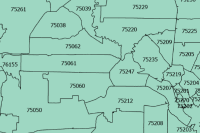

<Item title:"United States ZIP Code Boundaries 2021" type:Feature Layer Collection owner:esri_dm>
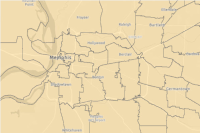

<Item title:"USA ZIP Code Areas" type:Layer Package owner:esri_dm>
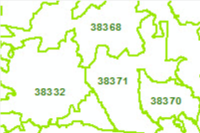

<Item title:"USA ZIP Code Three-Digit Areas" type:Layer Package owner:esri_dm>
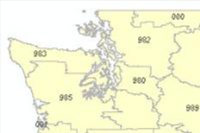

<Item title:"United States County Boundaries 2021" type:Feature Layer Collection owner:esri_dm>
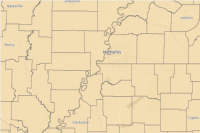

<Item title:"United States Tract Boundaries 2021" type:Feature Layer Collection owner:esri_dm>
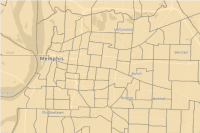

<Item title:"United States Boundaries 2021" type:Feature Layer Collection owner:esri_dm>
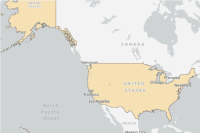

<Item title:"United States State Boundaries 2021" type:Feature Layer Collection owner:esri_dm>
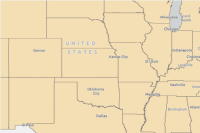

<Item title:"United States Block Group Boundaries 2021" type:Feature Layer Collection owner:esri_dm>
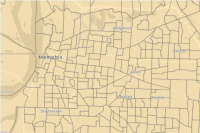

<Item title:"United States Country Boundary 2021" type:Feature Layer Collection owner:esri_dm>
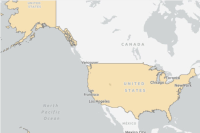

In [55]:
from IPython.display import display

for item in items:
    display(item)

Select the desired item from the list.

In [56]:
us_zip = items[1]

<Item title:"United States ZIP Code Boundaries 2021" type:Feature Layer Collection owner:esri_dm>
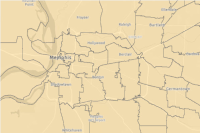

In [57]:
us_zip

Get the layer names from the item

In [58]:
for lyr in us_zip.layers:
    print(lyr.properties.name)

USA_Country
USA_State
USA_County
USA_ZipCode
USA_Tract
USA_BlockGroup


7) We want to merge the `zip_code` layer with `data2` to visualize the result on the map.

In [59]:
us_zip_lyr = us_zip.layers[3]

The `from_layer()` method helps convert feature layer to pandas Dataframe.

In [60]:
zip_df = pd.DataFrame.spatial.from_layer(us_zip_lyr)

In [69]:
zip_df.head()

,OBJECTID,ZIP_CODE,PO_NAME,STATE,POPULATION,SQMI,Shape__Area,Shape__Length,SHAPE
0,1,1,N Dillingham Census Area,AK,<NA>,16019.53,6.657141,24.677454,"{""rings"": [[[-160.431152, 58.689351], [-160.43..."
1,2,2,Yukon Flats Nat Wildlife,AK,<NA>,95862.85,48.948815,131.77645,"{""rings"": [[[-160.038452, 61.947605], [-160.03..."
2,3,3,Alaska Peninsula NWR,AK,<NA>,14572.9,5.655405,41.564165,"{""rings"": [[[-159.900745, 56.439047], [-159.90..."
3,4,4,W Kenai Peninsula Borough,AK,<NA>,6510.85,2.728764,20.553203,"{""rings"": [[[-154.748861, 59.259518], [-154.70..."
4,5,5,N Lake and Peninsula Borough,AK,<NA>,3760.07,1.593722,9.571684,"{""rings"": [[[-156.0002144, 60.9074352], [-155...."


In [62]:
zip_df.shape

(32201, 9)

In [63]:
zip_df.dtypes

OBJECTID                  Int64
ZIP_CODE         string[python]
PO_NAME          string[python]
STATE            string[python]
POPULATION                Int32
SQMI                    Float64
Shape__Area             Float64
Shape__Length           Float64
SHAPE                  geometry
dtype: object

In [64]:
zip_df = zip_df.astype({"ZIP_CODE": int})

In [65]:
zip_df.dtypes

OBJECTID                  Int64
ZIP_CODE                  int32
PO_NAME          string[python]
STATE            string[python]
POPULATION                Int32
SQMI                    Float64
Shape__Area             Float64
Shape__Length           Float64
SHAPE                  geometry
dtype: object

We use the `merge()` method from pandas library to join `zip_df` and `selected_data2` Dataframes.

In [66]:
merged_df = pd.merge(zip_df, selected_data2, on='ZIP_CODE')

In [70]:
merged_df.shape

(7548, 11)

The `import_data()` method helps us import the Dataframe `merged_df` with geometry namespace into ArcGIS Online.

In [68]:
merged_df.spatial.set_geometry('SHAPE')

In [71]:
mergd_lyr = gis.content.import_data(merged_df,
                                    title='MergedLayer_2024',
                                    tags='datascience, dlpk')

C:\Users\shu12142\AppData\Local\anaconda3\envs\geosaurus_dev_env\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'geosaurus.maps.arcgis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


When arcpy is present, the `import_data` will upload the local SeDF (Spatially Enabled DataFrame) as a FGDB (File geodatabase) to your organization, and publish to a hosted feature layer; On the other hand, when arcpy is not present, then the `import_data` method would have the local SeDF upload to your organization as a shapefile, and then publish as a hosted Feature Layer. This minor difference will result in column/property name differences from what's defined in the original SeDF.

To get accurate field names from imported layers, we will double check the field names before drawing them on maps in the following sections.

### Visualize Results

1) Create a map of the **BuyerSellerIndex** field


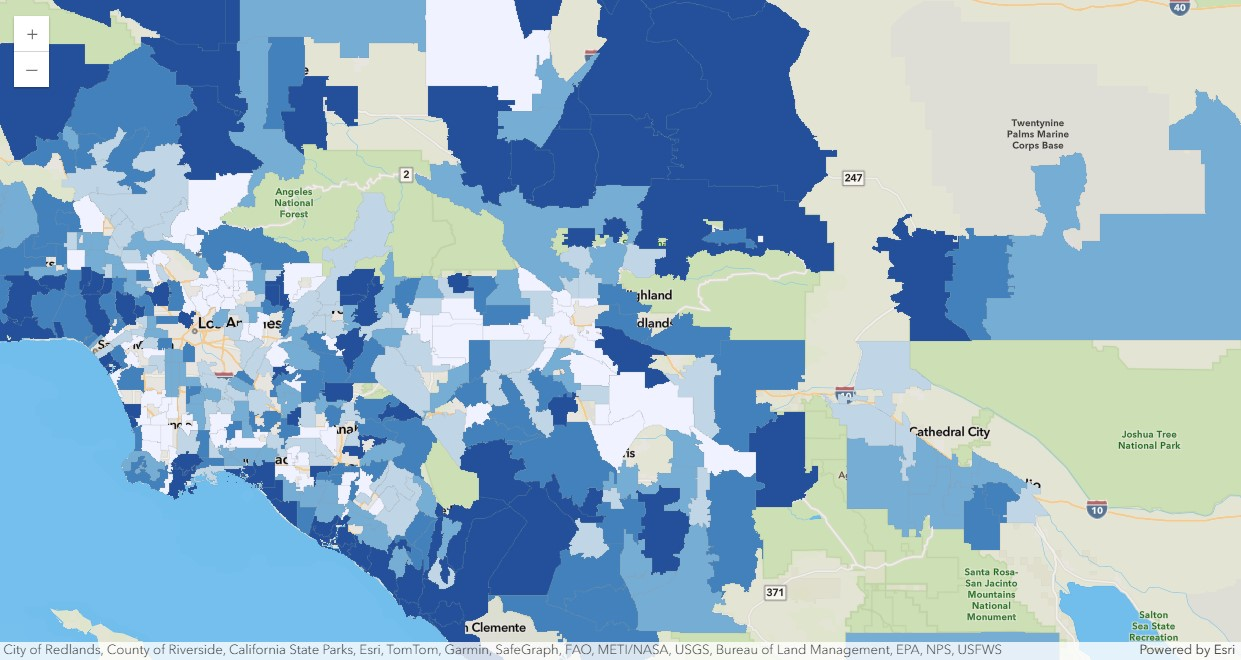

In [81]:
m1 = gis.map('Redlands, CA')
m1

In [78]:
m1.zoom = 8

To get the accurate column name, let's check the layer properties and display all field names from the imported `mergd_lyr` data.

In [79]:
field_names = mergd_lyr.layers[0].properties['fields']
for field in field_names:
    print(field['name'])

FID
objectid
zip_code
po_name
state
population
sqmi
shape_area
shape_leng
buyer_sell
days_on_ma
Shape__Area
Shape__Length


We will use the `smart mapping` capability to render merged layer with colors that varies based on **buyer_sell** (buyer_seller_index) field. The code below shows that a `SmartMappingManager` is created first by calling `content.renderer(0).smart_mapping()`. Then, we will call the `class_breaks_renderer` method to classify zip code boundary areas in colors. Please refer to [smart mapping](https://developers.arcgis.com/python/latest/guide/smart-mapping/) for more details.

In [80]:
m1.content.add(mergd_lyr)
sm = m1.content.renderer(0).smart_mapping()
sm.class_breaks_renderer(
    break_type = "color",
    field = "buyer_sell",
)

2) Create a map on **DaysOnMarket** field


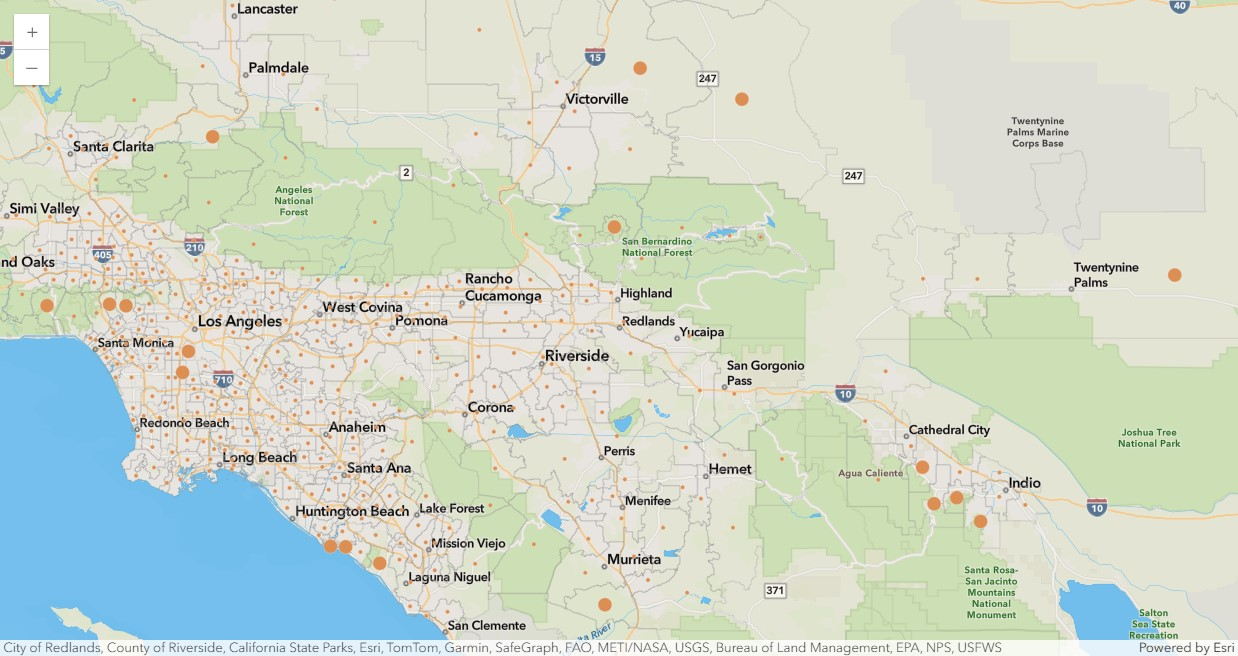

In [85]:
m2 = gis.map('Redlands, CA')
m2

In [83]:
m2.zoom = 8

Similar to m1, we will use `smart mapping` again to visualize zip code boundaries that classified by size based on **days_on_ma** (days_on_market) index.

In [84]:
m2.content.add(mergd_lyr)
sm = m2.content.renderer(0).smart_mapping()
sm.class_breaks_renderer(
    break_type="size",
    field = "days_on_ma",
)

## House Hunting

### Find all ZIP Codes within a specified drive time of important places

In this section, we will use **ImportantPlaces.xlsx** data for selling price analysis. The folloing steps are how we get **ImportantPlaces.xlsx** downloaded from open source and prepared.

1) Create an Excel table with columns for **Street, City, State**, and **Zip**. Add addresses for the locations you want to access from your new home. Mark and Lisa's table below has their current job addresses. They named their Excel file **ImportantPlaces.xlsx** and the Excel sheet **WorkLocations**.

2) Load the **ImportantPlaces.xlsx** excel data from local `datapath` as a Dataframe, and merge the `street`, `city`, `state` colomns as `address` column

In [86]:
file_name3 = datapath[2]
data3 = pd.read_excel(file_name3)

In [87]:
data3.head()

,Place,Street,City,State,Zip
0,Lisa's job,380 New York Street,Redlands,CA,92373
1,Mark's job,4511 E Guasti Road,Ontario,CA,91761


In [88]:
data3['Address'] = data3['Street'] + ' ' + data3['City'] + ' ' + data3['State']

In [89]:
data3['Address']

0    380 New York Street Redlands CA
1      4511 E Guasti Road Ontario CA
Name: Address, dtype: object

3) Draw the addresses on map


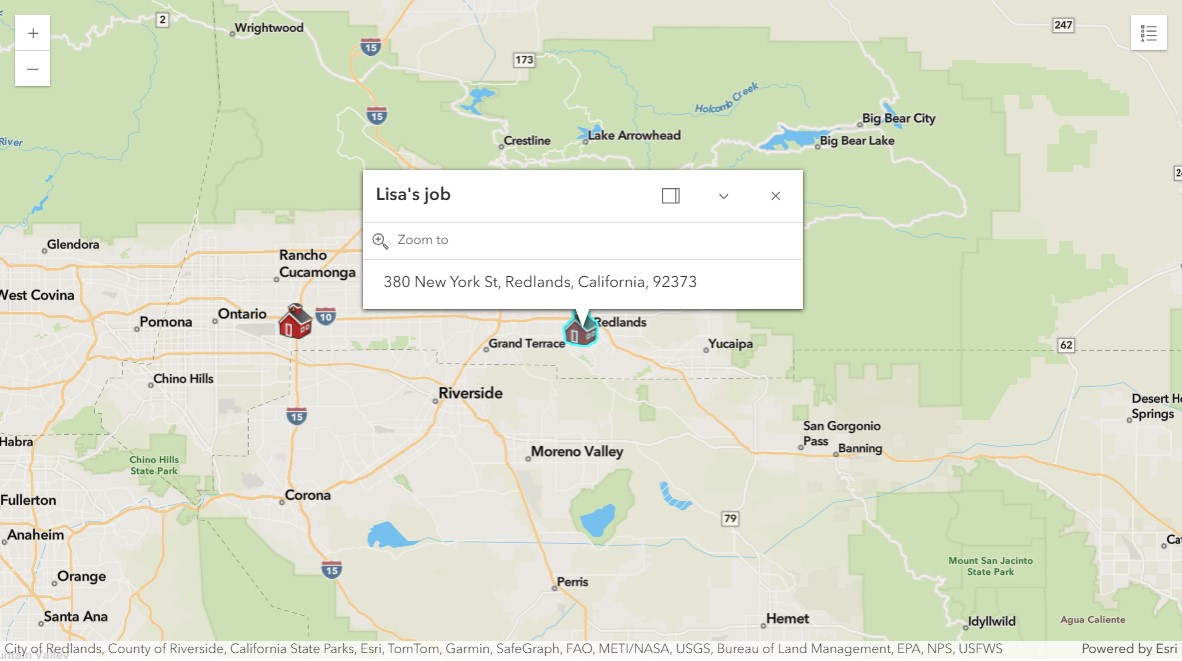

In [95]:
m3_1 = gis.map('Redlands, CA')
m3_1

In [91]:
m3_1.zoom = 9

To visualize popup address info and red house symbols of Lisa and Mark's job locations, we will create the `PopupInfo` and `PictureMarkerSymbolEsriPMS` objects and passing them as parameters when calling `content.draw()` method. 

In [93]:
from arcgis.geocoding import geocode
from arcgis.map.popups import PopupInfo
from arcgis.map.symbols import PictureMarkerSymbolEsriPMS

sr = m3_1.extent['spatialReference']['latestWkid']
data3_addr1 = geocode(data3.Address[0], out_sr=sr)[0]

popup = PopupInfo(title = "Lisa's job", description = data3_addr1['address'])

symbol = PictureMarkerSymbolEsriPMS(
    angle=0,
    xoffset=0,
    yoffset=0,
    content_type="image/png",
    width=24,
    height=25,
    type="esriPMS",
    url="https://static.arcgis.com/images/Symbols/PeoplePlaces/School.png",
)

m3_1.content.draw(data3_addr1['location'], popup = popup, symbol = symbol)

In [94]:
data3_addr2 = geocode(data3.Address[1], out_sr=sr)[0]

popup = PopupInfo(title = "Mark's job", description = data3_addr2['address'])

symbol = PictureMarkerSymbolEsriPMS(
    angle=0,
    xoffset=0,
    yoffset=0,
    content_type="image/png",
    width=24,
    height=25,
    type="esriPMS",
    url="https://static.arcgis.com/images/Symbols/PeoplePlaces/School.png",
)

m3_1.content.draw(data3_addr2['location'], popup = popup, symbol = symbol)

4) We will Create buffer and enter the maximum time they are willing to spend commuting from their new home to their work.

In [96]:
from arcgis.geoenrichment import BufferStudyArea, enrich

> **Note:** Organizations should review the [data attributions](https://www.esri.com/en-us/legal/terms/data-attributions) and [Master Agreement](https://www.esri.com/content/dam/esrisites/en-us/media/legal/ma-full/ma-full.pdf) to make sure they are in compliance when geoenriching data and making it available to other systems.

In [97]:
marks = BufferStudyArea(area='4511 E Guasti Road, Ontario, CA 91761', 
                           radii=[45], units='Minutes', 
                           travel_mode='Driving')
lisas = BufferStudyArea(area='380 New York St Redlands CA 92373', 
                           radii=[45], units='Minutes', 
                           travel_mode='Driving')

drive_time_df = enrich(study_areas=[marks, lisas], data_collections=['Age'])

In [98]:
drive_time_lyr = gis.content.import_data(drive_time_df,
                                         title="DriveTimeLayer_2024")

5) Select the Dissolve buffer style to merge overlapping polygons.

In [99]:
from arcgis.features.manage_data import dissolve_boundaries

In [ ]:
dissolved_lyr = dissolve_boundaries(drive_time_lyr)


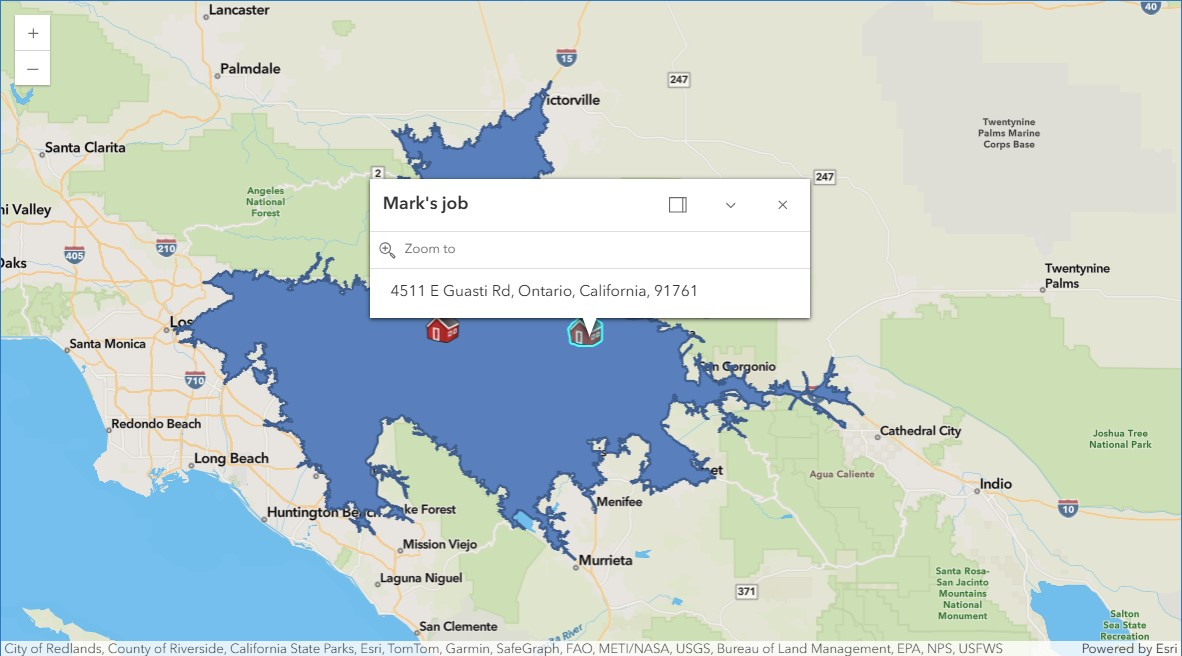

In [105]:
m3_2 = gis.map('Redlands, CA')
m3_2

In [102]:
m3_2.zoom = 8

In this map, we are going to display Lisa and mark's job locations, as well as the dissolved 45 minutes' drive time layer.

In [103]:
m3_2.content.add(dissolved_lyr)

In [104]:
symbol = PictureMarkerSymbolEsriPMS(
    angle=0,
    xoffset=0,
    yoffset=0,
    content_type="image/png",
    width=24,
    height=25,
    type="esriPMS",
    url="https://static.arcgis.com/images/Symbols/PeoplePlaces/School.png",
)

m3_2.content.draw(data3_addr1['location'], popup = popup, symbol = symbol)
m3_2.content.draw(data3_addr2['location'], popup = popup, symbol = symbol)

### Map market health, home values, and projected appreciation

In this section, we will use **MarketHealthIndex.xlsx** for market health, home values, and projected appreciation analysis. The folloing steps are how we get **MarketHealthIndex.xlsx** downloaded from open source and prepared. 

1) Download and prepare the Excel Market Health data as follows:

> a) From <a href="https://www.zillow.com/research/data/">www.zillow.com/reserach/data</a>, download ZIP Code level Market Health Index data.

> b) Open the .csv file using Excel and add the ZIPString column as a text field. Compute the values using =RIGHT(CONCAT("00000",B2),5). Drag the Autofill handle down to the last cell in the column to create text formatted ZIP Code values with leading zeros.

> c) Save the file as an Excel workbook. Close Excel.

> Mark and Lisa named their file MarketHealth.xlsx.

2) Load th **MarketHealthIndex.xlsx** excel data from local `datapath`, and restructure it as Dataframe.

In [106]:
file_name4 = datapath[3]
data4 = pd.read_excel(file_name4)

In [107]:
data4

,RegionType,RegionName,City,State,Metro,CBSATitle,SizeRank,MarketHealthIndex,SellForGain,PrevForeclosed,...,ZHVI,MoM,YoY,ForecastYoYPctChange,StockOfREOs,NegativeEquity,Delinquency,DaysOnMarket,Unnamed: 19,zipstring
0,Zip,1001,Agawam,MA,"Springfield, MA, MA","Springfield, MA",NaN,1.622365,75.00,0.0500,...,214000.0,0.281162,5.263158,0.047047,NaN,0.069028,0.068063,81.0,NaN,1001
1,Zip,1002,Amherst,MA,"Springfield, MA, MA","Springfield, MA",NaN,5.491341,92.31,0.0000,...,331400.0,0.485143,6.972240,0.046192,NaN,0.045415,0.038462,87.5,NaN,1002
2,Zip,1007,Belchertown,MA,"Springfield, MA, MA","Springfield, MA",NaN,4.664384,100.00,0.0000,...,277400.0,0.325497,4.679245,0.054387,NaN,0.046303,0.048387,94.5,NaN,1007
3,Zip,1008,Blandford,MA,"Springfield, MA, MA","Springfield, MA",NaN,2.541281,0.00,NaN,...,224000.0,0.223714,8.843537,0.061817,NaN,0.060109,0.090909,73.0,NaN,1008
4,Zip,1010,Brimfield,MA,"Springfield, MA, MA","Springfield, MA",NaN,3.103101,100.00,NaN,...,255700.0,0.471513,2.608347,0.060555,NaN,0.066778,0.075000,73.0,NaN,1010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14893,Zip,75033,Frisco,TX,"Dallas-Fort Worth, TX, TX","Dallas-Fort Worth, TX",NaN,9.095852,100.00,0.0000,...,395800.0,-0.075738,1.046719,0.066809,NaN,NaN,NaN,74.0,NaN,75033
14894,Zip,84009,South Jordan,UT,"Salt Lake City, UT, UT","Salt Lake City, UT",NaN,6.135052,NaN,0.0000,...,409200.0,0.540541,9.120000,0.040208,NaN,NaN,NaN,48.0,NaN,84009
14895,Zip,97003,Beaverton,OR,"Portland, OR, OR","Portland, OR",NaN,6.806954,100.00,0.0000,...,346900.0,0.173260,5.376671,0.037766,NaN,NaN,NaN,44.0,NaN,97003
14896,Zip,97703,Bend,OR,"Bend, OR, OR","Bend, OR",NaN,6.566653,100.00,NaN,...,590700.0,0.288625,6.489995,-0.011788,NaN,NaN,NaN,77.0,NaN,97703


3) Select **City, MarketHealthIndex, ZHVI, ForecastYoYPctChange**, and **zipstring** fields.

In [108]:
col = ['City', 'MarketHealthIndex', 'ZHVI', 'ForecastYoYPctChange', 'zipstring']

In [109]:
matket_health_index = data4[col]

In [110]:
matket_health_index.head()

,City,MarketHealthIndex,ZHVI,ForecastYoYPctChange,zipstring
0,Agawam,1.622365,214000.0,0.047047,1001
1,Amherst,5.491341,331400.0,0.046192,1002
2,Belchertown,4.664384,277400.0,0.054387,1007
3,Blandford,2.541281,224000.0,0.061817,1008
4,Brimfield,3.103101,255700.0,0.060555,1010


In [111]:
matket_health_index.dtypes

City                     object
MarketHealthIndex       float64
ZHVI                    float64
ForecastYoYPctChange    float64
zipstring                 int64
dtype: object

In [112]:
matket_health_index['MarketHealthIndex'].min()

0.000671231

In [113]:
matket_health_index['MarketHealthIndex'].max()

10.0

In [114]:
matket_health_index.rename(columns={"zipstring": "ZIP_CODE"},
                           inplace=True)

C:\Users\shu12142\AppData\Local\Temp\1\ipykernel_26008\1442553068.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matket_health_index.rename(columns={"zipstring": "ZIP_CODE"},


In [115]:
matket_health_index[matket_health_index['City']=='Crestline']

,City,MarketHealthIndex,ZHVI,ForecastYoYPctChange,ZIP_CODE
13351,Crestline,9.944288,205600.0,0.068084,92322
13353,Crestline,2.882937,228900.0,0.067296,92325


4) Sort the table on the ZIP_CODE field so we can locate their ZIP Code. Make a note of the values for MarketHealthIndex, ZHVI, and ForecastYoYPctChange. In Crestline, for example, the market health index is fair: 6.4 on a scale that ranges from 0 to 10. The median home value for all homes (not just 3-bedroom homes) is $214,100. Homes are expected to appreciate 4.8 percent.

We also want to merge the zip_code layer with market_health_index layer to visualize the result on map.

In [116]:
zip_df.head()

,OBJECTID,ZIP_CODE,PO_NAME,STATE,POPULATION,SQMI,Shape__Area,Shape__Length,SHAPE
0,1,1,N Dillingham Census Area,AK,<NA>,16019.53,6.657141,24.677454,"{""rings"": [[[-160.431152, 58.689351], [-160.43..."
1,2,2,Yukon Flats Nat Wildlife,AK,<NA>,95862.85,48.948815,131.77645,"{""rings"": [[[-160.038452, 61.947605], [-160.03..."
2,3,3,Alaska Peninsula NWR,AK,<NA>,14572.9,5.655405,41.564165,"{""rings"": [[[-159.900745, 56.439047], [-159.90..."
3,4,4,W Kenai Peninsula Borough,AK,<NA>,6510.85,2.728764,20.553203,"{""rings"": [[[-154.748861, 59.259518], [-154.70..."
4,5,5,N Lake and Peninsula Borough,AK,<NA>,3760.07,1.593722,9.571684,"{""rings"": [[[-156.0002144, 60.9074352], [-155...."


In [117]:
zip_df = zip_df.astype({"ZIP_CODE": int})

In [118]:
health_df = pd.merge(zip_df, matket_health_index, on='ZIP_CODE')

In [119]:
health_df.head()

,OBJECTID,ZIP_CODE,PO_NAME,STATE,POPULATION,SQMI,Shape__Area,Shape__Length,SHAPE,City,MarketHealthIndex,ZHVI,ForecastYoYPctChange
0,245,1001,Agawam,MA,16979,12.08,0.003404,0.318991,"{""rings"": [[[-72.66152, 42.052804], [-72.66099...",Agawam,1.622365,214000.0,0.047047
1,246,1002,Amherst,MA,35703,58.03,0.016429,0.932599,"{""rings"": [[[-72.546763, 42.399994], [-72.5467...",Amherst,5.491341,331400.0,0.046192
2,249,1007,Belchertown,MA,15616,55.85,0.015786,0.70547,"{""rings"": [[[-72.471439, 42.346695], [-72.4713...",Belchertown,4.664384,277400.0,0.054387
3,250,1008,Blandford,MA,1618,60.52,0.017082,0.68638,"{""rings"": [[[-73.06734, 42.236958], [-73.06329...",Blandford,2.541281,224000.0,0.061817
4,252,1010,Brimfield,MA,3985,37.36,0.010537,0.601482,"{""rings"": [[[-72.274433, 42.140342], [-72.2742...",Brimfield,3.103101,255700.0,0.060555


In [120]:
health_df.shape

(14894, 13)

In [121]:
health_df.spatial.set_geometry('SHAPE')

In [122]:
hlth_lyr = gis.content.import_data(health_df,
                                  title="MarketHealthLayer_2024")

5) Create a map on **MarketHealthIndex** field


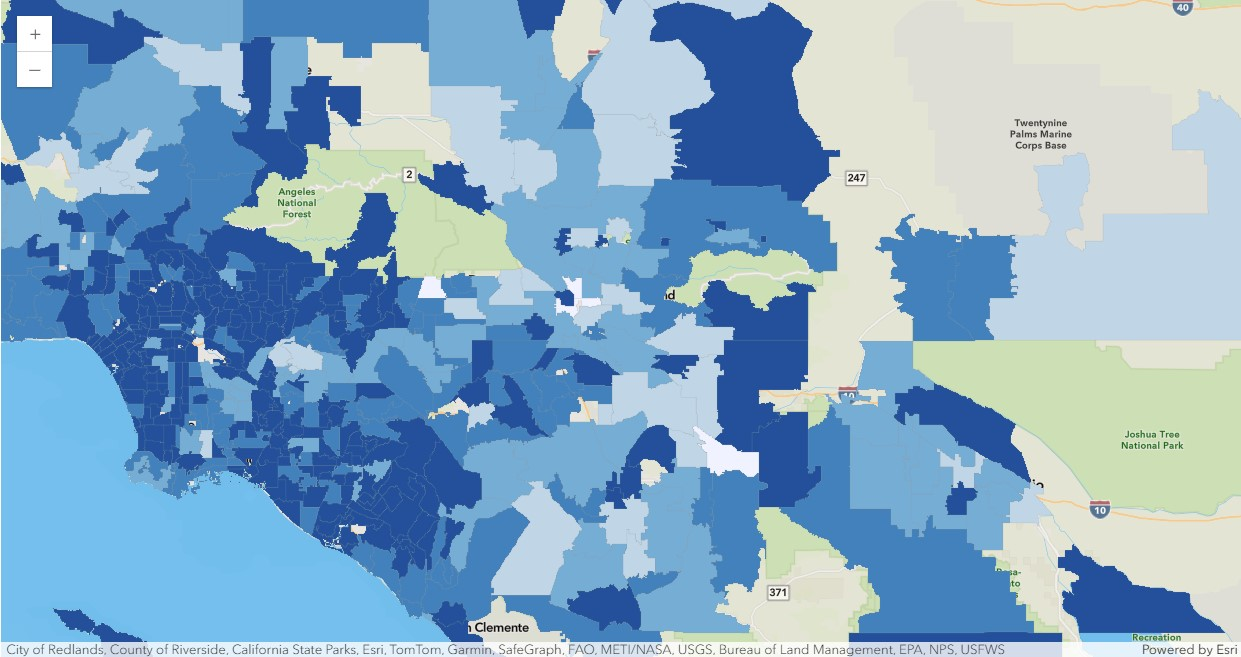

In [127]:
m4 = gis.map('Redlands, CA')
m4

In [125]:
m4.zoom = 8

In [141]:
field_names = hlth_lyr.layers[0].properties['fields']
for field in field_names:
    print(field['name'])

FID
objectid
zip_code
po_name
state
population
sqmi
shape_area
shape_leng
city
market_hea
zhvi
forecast_y
Shape__Area
Shape__Length


Similarly, we will still use `class_breaks_renderer` method to map the zip code areas out and classify it based on **market_hea** (market_health_index) field. In this case, we are also passing `quantile` as parameter to generate class breaks that the total number of data values in each class is the same.

In [126]:
m4.content.add(hlth_lyr)
sm = m4.content.renderer(0).smart_mapping()
sm.class_breaks_renderer(
    break_type="color",
    field = "market_hea",
    classification_method = "quantile",
)

6) Notice how many ZIP Codes intersect the drive time buffer.

We will utilize `overlay_layers` method from Python API's feature analysis functionality to create a feature layer of intersect zip code boundaries.

In [128]:
market_hlth_lyr = hlth_lyr.layers[0]

In [129]:
from arcgis.features.manage_data import overlay_layers

In [130]:
zip_intersect = overlay_layers(drive_time_lyr, 
                               market_hlth_lyr, 
                               output_name="Market Health Data Within drive time Buffer" + str(dt.now().microsecond))

{"cost": 14.896}


In [131]:
zip_intersect

<Item title:"Market_Health_Data_Within_drive_time_Buffer488424" type:Feature Layer Collection owner:arcgis_python>

In [132]:
zip_hlth_intersect = zip_intersect.layers[0]

In [133]:
overlay_df = pd.DataFrame.spatial.from_layer(zip_hlth_intersect)

In [134]:
overlay_df.shape

(360, 65)

7) Create a map that displays the overlap by adding both `hlth_lyr` (classified by **MarketHealthIndex** field) and `drive_time_lyr`.


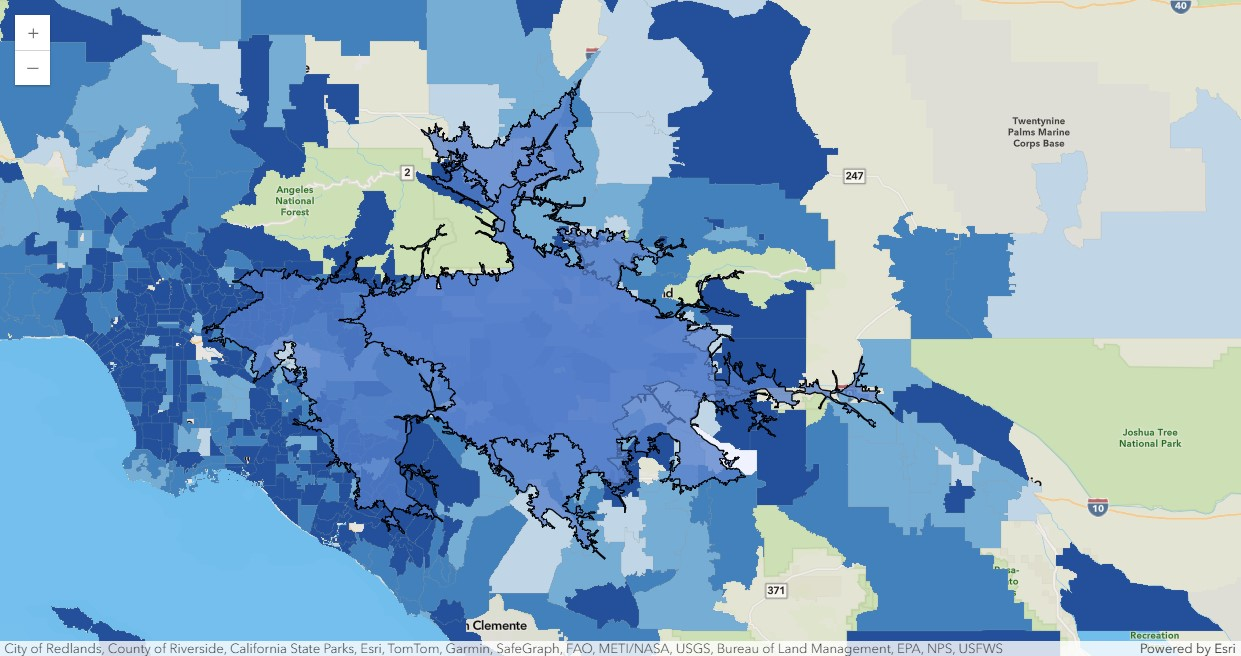

In [140]:
m5 = gis.map('Redlands, CA')
m5

In [136]:
m5.zoom = 8

In [138]:
m5.content.add(hlth_lyr)
sm5 = m5.content.renderer(0).smart_mapping()
sm5.class_breaks_renderer(
    break_type="color",
    field="market_hea",
    classification_method="quantile",
)

In [139]:
m5.content.add(drive_time_lyr)

The larger the index, the darker the color, and the healthier the housing market is. They want to buy their new home in an area with a healthy housing market (rather than a location where there are vacancies, homes that aren't selling, and numerous foreclosures).

This result has all the variables one should be interested in mapping, narrowed down to the ZIP Codes that are within an acceptable drive time to their work.

8) Create a map that displays the overlap by adding both `hlth_lyr` (classified by **ZHVI** field) and `drive_time_lyr`.


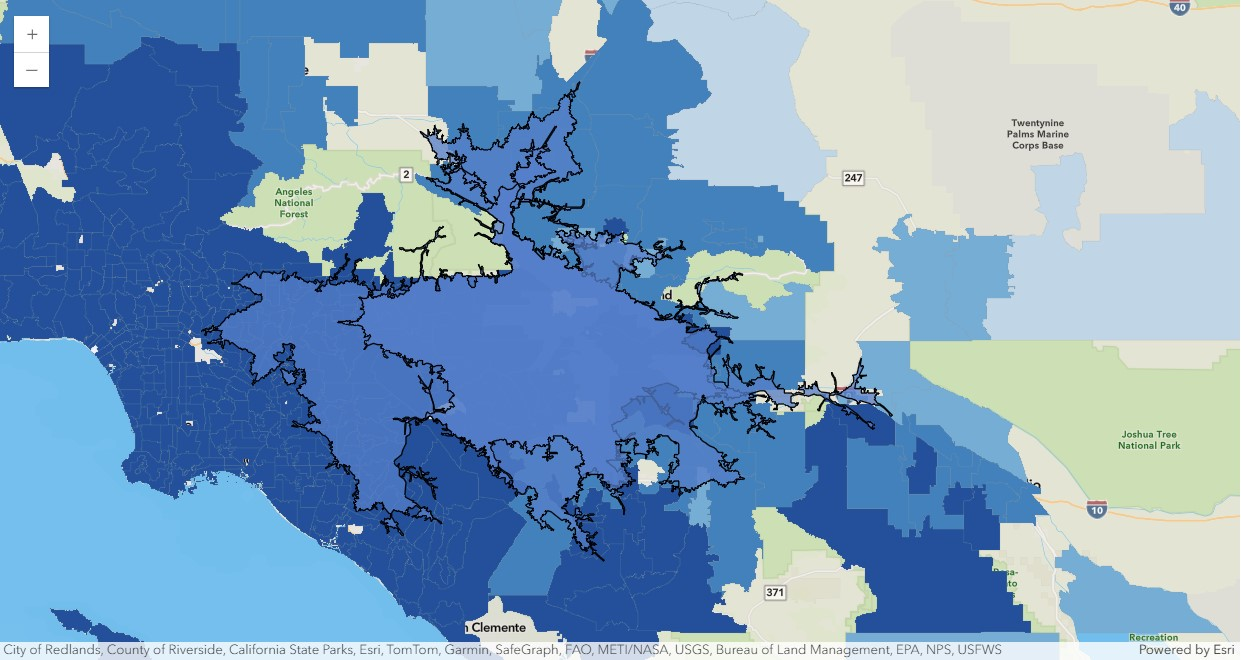

In [146]:
m6 = gis.map('Redlands, CA')
m6

In [143]:
m6.zoom = 8

In [144]:
m6.content.add(hlth_lyr)
sm6 = m6.content.renderer(0).smart_mapping()
sm6.class_breaks_renderer(
    break_type="color",
    field="zhvi",
    classification_method="quantile",
)

In [145]:
m6.content.add(drive_time_lyr)

The dark ZIP Codes have the most expensive average home value estimates.

9) Create a map that displays the overlap by adding both `hlth_lyr` (classified by **ForecastYoYPctChange** field) and `drive_time_lyr`.


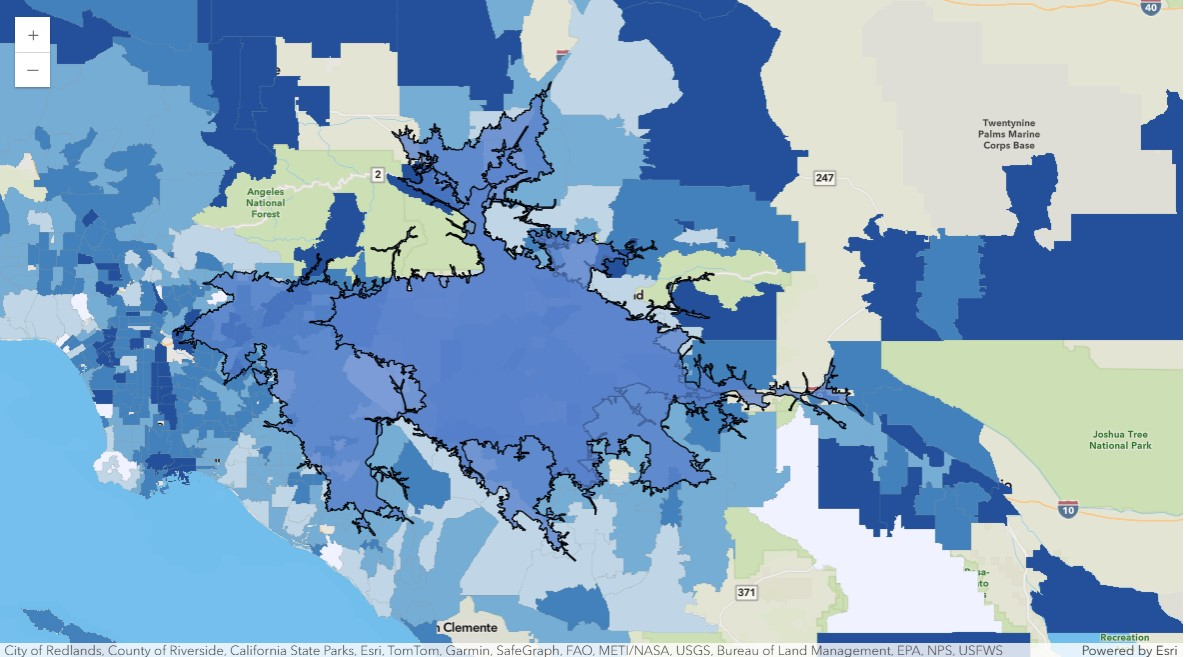

In [151]:
m7 = gis.map('Redlands, CA')
m7

In [148]:
m7.zoom = 8

In [149]:
m7.content.add(hlth_lyr)
sm7 = m7.content.renderer(0).smart_mapping()
sm7.class_breaks_renderer(
    break_type="color",
    field="forecast_y",
    classification_method="quantile",
)

In [150]:
m7.content.add(drive_time_lyr)

The darkest ZIP Codes are expected to have the largest increase in home values over the next year.

### Find the best cities to begin house hunting

1) Narrow the search to ZIP Codes with home values in price range as follows:

> Mark and Lisa will only sell their home for a loss if they can purchase a home valued the same as theirs with better investment potential. They will look for homes that cost about \\$340,000 in neighborhoods with median home values between \\$300,000 and \\$500,000. Being surrounded by homes that are valued higher than theirs is much better than being the most expensive home on the block. That's why Mark and Lisa extended their search to ZIP Codes with median home values as high as \$500,000.

> They also want to narrow their search to areas belonging to healthy housing markets with expected home value appreciation. Mark and Lisa, for example, exclude ZIP Codes in unhealthy housing markets by filtering for MarketHealthIndex > 8. They also focus on ZIP Codes with expected home appreciation higher than Crestline by filtering for ForecastYoYPctChange > 0.060. Set filters to reflect your own criteria for the MarketHealthIndex and ForecastYoYPctChange fields.

In [152]:
field_name = "market_hea"
field_name2 = "forecast_y"

In [153]:
query_str = '((ZHVI > 350000) AND (ZHVI < 600000) AND (' + field_name + ' > 8) AND (' + field_name2 + '> 0.06)) AND (1=1)'

zip_hlth_intersect_df = zip_hlth_intersect.query(where=query_str).sdf
zip_hlth_intersect_df

,OBJECTID_1,FID_DRIVETIMELAYER_20242_DRIVET,source_cou,x,y,area_type,buffer_uni,buffer_u_1,buffer_rad,aggregatio,...,sqmi,shape_leng,city,market_hea,zhvi,forecast_y,Shape__Area_1,Shape__Length_1,AnalysisArea,SHAPE
0,2,1,USA,-117.552866,34.064359,NetworkServiceArea,Minutes,Drive Time Minutes,45.0,BlockApportionment:US.BlockGroups;PointsLayer:...,...,4.2,0.214615,Los Angeles,9.055578,408100.0,0.09147,15880559.84375,25687.278616,0.482092,"{""rings"": [[[-13157517.9452, 4032773.4488], [-..."
1,4,1,USA,-117.552866,34.064359,NetworkServiceArea,Minutes,Drive Time Minutes,45.0,BlockApportionment:US.BlockGroups;PointsLayer:...,...,3.01,0.147502,Los Angeles,9.930192,472000.0,0.07689,11375466.695312,17800.685279,1.779017,"{""rings"": [[[-13157514.1907, 4037443.2303], [-..."
2,14,1,USA,-117.552866,34.064359,NetworkServiceArea,Minutes,Drive Time Minutes,45.0,BlockApportionment:US.BlockGroups;PointsLayer:...,...,3.74,0.183214,West Whittier-Los Nietos,8.272251,485500.0,0.072375,14136917.117188,22634.260753,8.36099,"{""rings"": [[[-13143194.2534, 4028915.1404], [-..."
3,18,1,USA,-117.552866,34.064359,NetworkServiceArea,Minutes,Drive Time Minutes,45.0,BlockApportionment:US.BlockGroups;PointsLayer:...,...,8.23,0.28339,Montebello,8.167539,538500.0,0.061807,31089924.613281,34373.962355,13.017801,"{""rings"": [[[-13143598.3654, 4032788.2902], [-..."
4,20,1,USA,-117.552866,34.064359,NetworkServiceArea,Minutes,Drive Time Minutes,45.0,BlockApportionment:US.BlockGroups;PointsLayer:...,...,8.53,0.438871,Santa Fe Springs,9.151564,494500.0,0.063482,32164136.523438,53469.063308,2.26762,"{""rings"": [[[-13143509.5925, 4023388.3935], [-..."
5,35,1,USA,-117.552866,34.064359,NetworkServiceArea,Minutes,Drive Time Minutes,45.0,BlockApportionment:US.BlockGroups;PointsLayer:...,...,69.99,1.187015,Azusa,9.138139,457600.0,0.0863,265860978.933594,144989.856887,23.94345,"{""rings"": [[[-13123457.5912, 4048674.4978], [-..."
6,36,1,USA,-117.552866,34.064359,NetworkServiceArea,Minutes,Drive Time Minutes,45.0,BlockApportionment:US.BlockGroups;PointsLayer:...,...,15.37,0.381127,Baldwin Park,9.215331,460300.0,0.088173,58195009.007812,46203.383216,39.805003,"{""rings"": [[[-13129355.916, 4047201.7934], [-1..."
7,45,1,USA,-117.552866,34.064359,NetworkServiceArea,Minutes,Drive Time Minutes,45.0,BlockApportionment:US.BlockGroups;PointsLayer:...,...,4.8,0.210419,El Monte,9.203249,506500.0,0.065299,18149214.558594,25938.507566,12.421541,"{""rings"": [[[-13135851.7534, 4040662.4451], [-..."
8,46,1,USA,-117.552866,34.064359,NetworkServiceArea,Minutes,Drive Time Minutes,45.0,BlockApportionment:US.BlockGroups;PointsLayer:...,...,6.99,0.228549,South El Monte,9.615385,501700.0,0.093255,26450814.414062,27596.205783,18.114647,"{""rings"": [[[-13139099.6109, 4037245.849], [-1..."
9,213,1,USA,-117.552866,34.064359,NetworkServiceArea,Minutes,Drive Time Minutes,45.0,BlockApportionment:US.BlockGroups;PointsLayer:...,...,15.19,0.305009,Eastvale,8.270909,503800.0,0.064508,57390709.253906,38277.204055,39.349068,"{""rings"": [[[-13082747.7254, 4033299.2511], [-..."



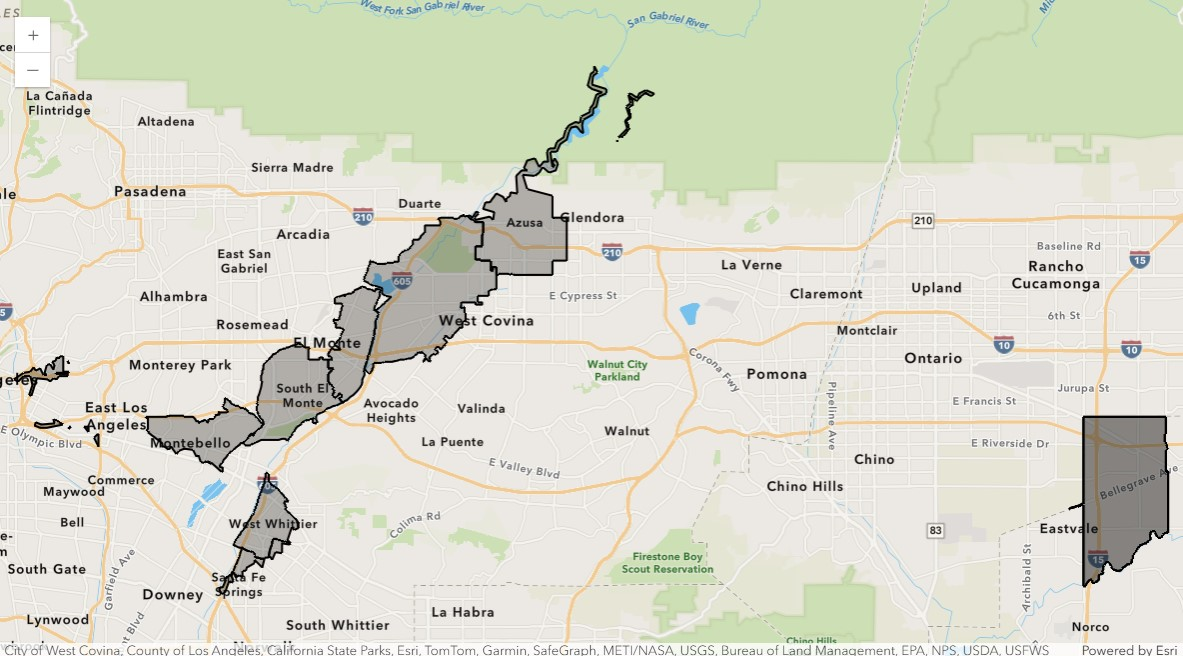

In [160]:
m9 = gis.map('United States')
m9

In [158]:
m9.content.add(zip_hlth_intersect_df)

In [159]:
m9.zoom_to_layer(zip_hlth_intersect_df)

Notice that when the filter is applied, the map changes. ZIP Codes that don't meet the filter criteria are removed from the map and the colors change to reflect the recomputed Quantile classification.

### Conclusion

The results show possible cities and ZIP Codes where they can explore homes for sale. We can use real estate websites such as <a href="https://www.zillow.com/">Zillow.com</a> or <a href="https://www.realtor.com/">Realtor.com</a> to see if they can find a home in their price range with the characteristics and qualities they're are looking for.